In [1]:
# Tensorflow
import tensorflow as tf
# Matplotlib
import matplotlib.pyplot as plt
# Numpy et Panda
import numpy as np
import pandas as pd

# Dataset

Ce dataset provient du site Kaggle et est disponible en téléchargement à l'adresse : https://www.kaggle.com/kazanova/sentiment140

La méthode de classification qui a été utilisée pour ce dataset est décrite à l'adresse : https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/custom/15786247.pdf

Ce dataset comporte pour chaque tweet :
- Le tweet en question 
- Un identifiant
- La date de publication du tweet
- L'utilisateur qui l'a posté
- La polarité du tweet (0 : négatif / 4 : positif)

In [2]:
from sklearn.utils import shuffle

dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", names=['Positivity', 'ID', 'Date', 'Query', 'User', 'Message'])
# Le Dataset est mélangé car seulement une partie sera utilisée
dataset = shuffle(dataset)

# Exploration du dataset

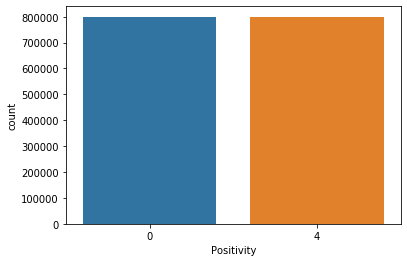

In [3]:
import seaborn as sns

# Analyse de la répartition des avis négatifs et positifs 
ax = sns.countplot(x="Positivity", data=dataset)

On constate que la répartition des deux classes est parfaite, le dataset contient 800 000 tweets positifs et 800 000 tweets négatifs

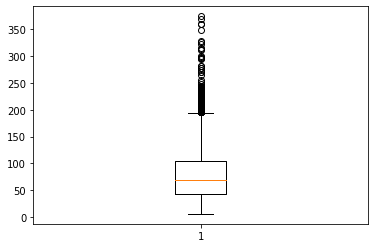

In [4]:
# Analyse de la longueur des tweets
dataset['pre_clean_len'] = [len(t) for t in dataset.Message] 
plt.boxplot(dataset.pre_clean_len) 
plt.show()

Ce graphe nous montre la répartition des tweets en fonction du nombre de caractères qui sont utilisés, on constate que la majorité des messages sont composés de 10 à 200 caractères.

# Traitement des données

Nous allons dans un premier temps nettoyer les tweets en enlevant tous les caractères qui n'ont pas d'intêrets et en les mettant en minuscules. La ponctuation est volontairement conservée car elle est un bon indicateur pour mesurer l'intensité des sentiments qui sont liés au message.

Dans un second temps les tweets sont encodés grâce à un encodeur, il permet de fragmenter les tweets en plusieurs petits mots qui sont encodés avec un dictionnaire définit selon les données qu'on lui a donné. L'encodeur possède un nombre de mots maximum qu'il peut encoder, ce qui veut dire que plus ce nombre est grand plus il sera en capacité d'encoder de longues chaines de caractère mais plus ce nombre est petit et plus les tweets seront encodé par petit fragment.

Si les fragments sont trop petit le tableau encodé (correspondant au tweet) que revoira l'encodeur sera alors trop grand et plus il est grand plus il sera long à être traité par notre réseau.

In [5]:
import nltk
from nltk.corpus import stopwords
import re
import string


def nettoyage_corpus(data_array):
    corpus = []
    for ligne in data_array:
        corpus.append(clean_tweets(ligne))
    return corpus
    
    
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    tweet = tweet.lower()
    
    return tweet


In [6]:
messages = dataset['Message'].tolist()[:300000]
messages = nettoyage_corpus(messages)


# On modifie la valeurs des labels 
# 0 = negatif 
# 1 = positif
labels = np.array(dataset['Positivity'].tolist()[:300000])
labels = np.where(labels==4, 1, labels).tolist()

Le dataset d'entrainement se compose de 150 000 tweets, il sera par la suite divisé en deux 2/3 serviront pour l'entrainement et 1/3 pour la validation. 

Le dataset de test  est composé de 50 000 tweets permettra de tester les performances du réseau après l'entrainement.

In [7]:
from sklearn.model_selection import train_test_split
d = {'values': messages, 'labels': labels}
df = pd.DataFrame(data=d)
X_train, X_test, y_train, y_test = train_test_split(messages, labels, train_size=150000, test_size=50000, random_state=42)

In [8]:
import tensorflow_datasets as tfds
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    messages, target_vocab_size=2**15)

Les tableaux que renvoient l'encodeur ne sont pas tous de la même dimension car ils dépendent de la taille du tweet qui est passé en entrée, cependant il est nécessaire de fournir au réseau de neurone des tableaux de dimensions égales. Nous avons donc du rajouter des 0 sur les tableaux les plus petit afin de mettre tous les tableaux à la même taille.

In [9]:
max_size = 0
for tweet in messages :
    if len(tweet)>max_size:
        max_size=len(tweet)
max_size

186

In [10]:
def encode_tweets(data):
    encoded_tweets = []
    for tweet in data:
        encoded_tweet = encoder.encode(tweet)
        padding = max_size-len(encoded_tweet)
        encoded_tweet = np.pad(encoded_tweet, (0,padding), 'constant')
        encoded_tweets.append(encoded_tweet)
    return encoded_tweets

train_set = encode_tweets(X_train)
test_set = encode_tweets(X_test)
train_labels = y_train
test_labels = y_test

# Création d'un réseau de neurone simple

## Description du réseau

Dans un premier temps, nous utiliserons un réseau de neurone de type LSTM. 

- Sa couche d'entrée est une couche d'Embedding de 64 neurones. 
- La seconde couche est une couche LSTM composée de 64 neurones.
- Une troisième couche Dense de 64 neurones permet d'interpréter les résultats de la couche LSTM.
- Enfin, la dernière couche se compose d'un seul neurone chargé de prédire la positivité ou négativité du message donné en entrée. 


## Choix de la fonction d'activation

Les 3 fonctions d'activation que  nous avons étudié sont les suivantes :

**Sigmoide ou Logistique** : Est la fonction d'activation la plus ancienne et populaire existante mais possède plusieurs défauts :
- Elle n'est pas centrée autour de 0 donc un input négatif peut par exemple engendrer un output positif.
- Elle influe très faiblement sur les neurones ce qui amène à un résultat final souvent très proche de 0 ou 1.
- Plus le réseau de neurones comporte de couche moins le résultat sera précis.
 
**Tanh** : Cette fonction ressemble beaucoup à la Sigmoide mais celle-ci produit un output compris entre -1 et 1. On la préfère tout de même à la Sigmoide car elle est centrée sur 0. Les grandes entrées négatives tendent vers -1 et les grandes entrées positives tendent vers 1. Au niveau de ses défauts, ce sont les mêmes que pour la Sigmoide.

**ReLU** : Unité de rectification linéaire, c'est la fonction d'activation la plus utilisée dans le domaine du deep learning. Cette fonction est reconnue pour sa fiabilité et son efficacité. En effet, elle augmente considérablement la convergence du réseau et ne sature pas. Le problème de la fonction Relu est qu'elle ne traite pas les valeurs négatives et leur attribue une valeur de 0. Cela implique donc que le neurone reste inactif, que les poids ne sont pas mis à jour et que le réseau
n'apprend donc pas.

La fonction d'activation qui a donc été retenue pour les couches deux et trois est la fonction ReLU (Rectified Linear Unit), il s'agit de la fonction qui semble être la plus efficiente pour notre cas d'application.


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
#tf.keras.models.load_model('LSTM_Simple.h5')


# Choix d'optimisation du modèle

Afin d'utiliser la méthode la plus interessante pour optimiser notre réseau nous avons étudié les principales méthode de déscente de gradient :

**Momentum** : accélère de SGD en conduisant à une convergence plus rapide et stable, réduit les oscillations

**Nesterov accelerated gradient** : Cette méthode est basée sur la mise à jour anticipative qui empêche d’aller trop vite et de ne pas manquer les minima et la rend plus réactive aux changements.

**Adagrad** : Il permet simplement au taux d'apprentissage de s'adapter en fonction des paramètres. Il fait donc de grandes mises à jour pour les paramètres peu fréquents et de petites mises à jour pour les paramètres fréquents. Pour cette raison, il est bien adapté pour traiter des données éparses. La principale faiblesse de cette méthode est que son taux d’apprentissage est toujours en baisse.

**AdaDelta** : C’est une extension d’AdaGrad qui vise à supprimer le problème de taux d’apprentissage en décomposition. Au lieu d’accumuler tous les gradients précédents, Adadelta limite la fenêtre des gradients passés accumulés à une certaine taille fixe appellé w

**Adam (Adaptive Moment Estimation)** : L'estimation du moment adaptatif (Adam) est une autre méthode qui calcule les taux d'apprentissage adaptatifs pour chaque paramètre. En plus de stocker une moyenne en décroissance exponentielle des gradients carrés antérieurs comme AdaDelta, Adam conserve également une moyenne en décomposition exponentielle des gradients passés M (t) , semblable au momentum

La méthode qui a été retenue pour entrainer notre réseau est donc la méthode Adam, il s'agit à l'heure actuelle de la méthode qui parait la plus intéressante pour notre cas d'application

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          2064448   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,138,817
Trainable params: 2,138,817
Non-trainable params: 0
_________________________________________________________________


# Entrainement du modèle

Le modèle simple est entrainé sur 20 itérations, son jeu d'entrainement se compose de 100 000 tweets et son jeu de validation de 50 000 tweets.

In [14]:
history = model.fit(np.array(train_set), np.array(train_labels), validation_split=0.33, epochs=20)

Epoch 1/20


 185/3141 [>.............................] - ETA: 0s - loss: 0.6939 - accuracy: 0.46 - ETA: 2:52 - loss: 0.6935 - accuracy: 0.56 - ETA: 3:53 - loss: 0.6935 - accuracy: 0.47 - ETA: 4:21 - loss: 0.6936 - accuracy: 0.46 - ETA: 4:35 - loss: 0.6936 - accuracy: 0.48 - ETA: 4:46 - loss: 0.6936 - accuracy: 0.47 - ETA: 4:52 - loss: 0.6936 - accuracy: 0.44 - ETA: 4:56 - loss: 0.6937 - accuracy: 0.44 - ETA: 5:00 - loss: 0.6936 - accuracy: 0.45 - ETA: 5:08 - loss: 0.6936 - accuracy: 0.45 - ETA: 5:09 - loss: 0.6936 - accuracy: 0.46 - ETA: 5:11 - loss: 0.6935 - accuracy: 0.45 - ETA: 5:15 - loss: 0.6933 - accuracy: 0.44 - ETA: 5:16 - loss: 0.6934 - accuracy: 0.45 - ETA: 5:19 - loss: 0.6934 - accuracy: 0.45 - ETA: 5:20 - loss: 0.6935 - accuracy: 0.46 - ETA: 5:20 - loss: 0.6934 - accuracy: 0.45 - ETA: 5:20 - loss: 0.6933 - accuracy: 0.46 - ETA: 5:21 - loss: 0.6932 - accuracy: 0.45 - ETA: 5:23 - loss: 0.6931 - accuracy: 0.45 - ETA: 5:23 - loss: 0.6931 - accuracy: 0.46 - ETA: 5:23 - loss: 0.6931 - accura

 371/3141 [==>...........................] - ETA: 5:18 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:18 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:18 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:18 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:18 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:17 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:17 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:17 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:17 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:17 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:17 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:16 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:16 - loss: 0.6918 - accuracy: 0.50 - ETA: 5:16 - loss: 0.6917 - accuracy: 0.50 - ETA: 5:16 - loss: 0.6917 - accuracy: 0.50 - ETA: 5:16 - loss: 0.6917 - accuracy: 0.50 - ETA: 5:15 - loss: 0.6917 - accuracy: 0.50 - ETA: 5:15 - loss: 0.6916 - accuracy: 0.50 - ETA: 5:15 - loss: 0.6916 - accuracy: 0.50 - ETA: 5:15 - loss: 0.6916 - accuracy: 0.50 - ETA: 5:15 - loss: 0.6916 - accuracy: 0.50 - ETA: 5:15 - loss: 0.6916 - accu

 557/3141 [====>.........................] - ETA: 4:59 - loss: 0.6800 - accuracy: 0.51 - ETA: 4:59 - loss: 0.6800 - accuracy: 0.51 - ETA: 4:58 - loss: 0.6797 - accuracy: 0.51 - ETA: 4:58 - loss: 0.6794 - accuracy: 0.51 - ETA: 4:58 - loss: 0.6792 - accuracy: 0.51 - ETA: 4:58 - loss: 0.6790 - accuracy: 0.51 - ETA: 4:58 - loss: 0.6788 - accuracy: 0.51 - ETA: 4:58 - loss: 0.6788 - accuracy: 0.51 - ETA: 4:57 - loss: 0.6787 - accuracy: 0.51 - ETA: 4:57 - loss: 0.6787 - accuracy: 0.51 - ETA: 4:57 - loss: 0.6786 - accuracy: 0.51 - ETA: 4:57 - loss: 0.6785 - accuracy: 0.51 - ETA: 4:57 - loss: 0.6785 - accuracy: 0.51 - ETA: 4:57 - loss: 0.6784 - accuracy: 0.51 - ETA: 4:57 - loss: 0.6784 - accuracy: 0.51 - ETA: 4:57 - loss: 0.6784 - accuracy: 0.51 - ETA: 4:56 - loss: 0.6782 - accuracy: 0.51 - ETA: 4:56 - loss: 0.6779 - accuracy: 0.51 - ETA: 4:56 - loss: 0.6778 - accuracy: 0.51 - ETA: 4:56 - loss: 0.6778 - accuracy: 0.51 - ETA: 4:56 - loss: 0.6777 - accuracy: 0.51 - ETA: 4:56 - loss: 0.6774 - accu

 743/3141 [======>.......................] - ETA: 4:37 - loss: 0.6537 - accuracy: 0.55 - ETA: 4:37 - loss: 0.6535 - accuracy: 0.55 - ETA: 4:37 - loss: 0.6533 - accuracy: 0.55 - ETA: 4:37 - loss: 0.6531 - accuracy: 0.55 - ETA: 4:37 - loss: 0.6532 - accuracy: 0.55 - ETA: 4:37 - loss: 0.6529 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6529 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6527 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6527 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6528 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6527 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6525 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6522 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6519 - accuracy: 0.55 - ETA: 4:36 - loss: 0.6518 - accuracy: 0.55 - ETA: 4:35 - loss: 0.6517 - accuracy: 0.55 - ETA: 4:35 - loss: 0.6515 - accuracy: 0.55 - ETA: 4:35 - loss: 0.6514 - accuracy: 0.55 - ETA: 4:35 - loss: 0.6513 - accuracy: 0.55 - ETA: 4:35 - loss: 0.6510 - accuracy: 0.55 - ETA: 4:35 - loss: 0.6512 - accuracy: 0.55 - ETA: 4:35 - loss: 0.6511 - accu

 929/3141 [=======>......................] - ETA: 4:17 - loss: 0.6312 - accuracy: 0.58 - ETA: 4:17 - loss: 0.6310 - accuracy: 0.58 - ETA: 4:17 - loss: 0.6310 - accuracy: 0.58 - ETA: 4:17 - loss: 0.6307 - accuracy: 0.58 - ETA: 4:17 - loss: 0.6307 - accuracy: 0.58 - ETA: 4:17 - loss: 0.6305 - accuracy: 0.58 - ETA: 4:17 - loss: 0.6304 - accuracy: 0.58 - ETA: 4:17 - loss: 0.6302 - accuracy: 0.58 - ETA: 4:17 - loss: 0.6301 - accuracy: 0.58 - ETA: 4:16 - loss: 0.6302 - accuracy: 0.58 - ETA: 4:16 - loss: 0.6302 - accuracy: 0.58 - ETA: 4:16 - loss: 0.6302 - accuracy: 0.58 - ETA: 4:16 - loss: 0.6301 - accuracy: 0.58 - ETA: 4:16 - loss: 0.6300 - accuracy: 0.58 - ETA: 4:16 - loss: 0.6301 - accuracy: 0.58 - ETA: 4:16 - loss: 0.6299 - accuracy: 0.58 - ETA: 4:16 - loss: 0.6298 - accuracy: 0.58 - ETA: 4:15 - loss: 0.6295 - accuracy: 0.58 - ETA: 4:15 - loss: 0.6296 - accuracy: 0.58 - ETA: 4:15 - loss: 0.6294 - accuracy: 0.58 - ETA: 4:15 - loss: 0.6293 - accuracy: 0.58 - ETA: 4:15 - loss: 0.6293 - accu

1115/3141 [=========>....................] - ETA: 3:57 - loss: 0.6150 - accuracy: 0.61 - ETA: 3:57 - loss: 0.6149 - accuracy: 0.61 - ETA: 3:57 - loss: 0.6147 - accuracy: 0.61 - ETA: 3:57 - loss: 0.6147 - accuracy: 0.61 - ETA: 3:57 - loss: 0.6146 - accuracy: 0.61 - ETA: 3:57 - loss: 0.6147 - accuracy: 0.61 - ETA: 3:57 - loss: 0.6147 - accuracy: 0.61 - ETA: 3:57 - loss: 0.6148 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6147 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6146 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6145 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6143 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6142 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6142 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6142 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6140 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6140 - accuracy: 0.61 - ETA: 3:56 - loss: 0.6139 - accuracy: 0.61 - ETA: 3:55 - loss: 0.6138 - accuracy: 0.61 - ETA: 3:55 - loss: 0.6138 - accuracy: 0.61 - ETA: 3:55 - loss: 0.6136 - accuracy: 0.61 - ETA: 3:55 - loss: 0.6136 - accu

1301/3141 [===========>..................] - ETA: 3:37 - loss: 0.6032 - accuracy: 0.62 - ETA: 3:37 - loss: 0.6030 - accuracy: 0.62 - ETA: 3:37 - loss: 0.6029 - accuracy: 0.62 - ETA: 3:37 - loss: 0.6029 - accuracy: 0.62 - ETA: 3:37 - loss: 0.6028 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6028 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6027 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6026 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6024 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6022 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6022 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6022 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6021 - accuracy: 0.62 - ETA: 3:36 - loss: 0.6020 - accuracy: 0.62 - ETA: 3:35 - loss: 0.6019 - accuracy: 0.62 - ETA: 3:35 - loss: 0.6017 - accuracy: 0.62 - ETA: 3:35 - loss: 0.6019 - accuracy: 0.62 - ETA: 3:35 - loss: 0.6018 - accuracy: 0.62 - ETA: 3:35 - loss: 0.6017 - accuracy: 0.62 - ETA: 3:35 - loss: 0.6015 - accuracy: 0.62 - ETA: 3:35 - loss: 0.6015 - accuracy: 0.62 - ETA: 3:35 - loss: 0.6014 - accu

1487/3141 [=============>................] - ETA: 3:17 - loss: 0.5920 - accuracy: 0.63 - ETA: 3:17 - loss: 0.5920 - accuracy: 0.63 - ETA: 3:17 - loss: 0.5919 - accuracy: 0.63 - ETA: 3:17 - loss: 0.5918 - accuracy: 0.63 - ETA: 3:17 - loss: 0.5918 - accuracy: 0.63 - ETA: 3:16 - loss: 0.5917 - accuracy: 0.63 - ETA: 3:16 - loss: 0.5916 - accuracy: 0.63 - ETA: 3:16 - loss: 0.5915 - accuracy: 0.63 - ETA: 3:16 - loss: 0.5914 - accuracy: 0.64 - ETA: 3:16 - loss: 0.5913 - accuracy: 0.64 - ETA: 3:16 - loss: 0.5912 - accuracy: 0.64 - ETA: 3:16 - loss: 0.5912 - accuracy: 0.64 - ETA: 3:16 - loss: 0.5911 - accuracy: 0.64 - ETA: 3:16 - loss: 0.5911 - accuracy: 0.64 - ETA: 3:15 - loss: 0.5910 - accuracy: 0.64 - ETA: 3:15 - loss: 0.5909 - accuracy: 0.64 - ETA: 3:15 - loss: 0.5909 - accuracy: 0.64 - ETA: 3:15 - loss: 0.5908 - accuracy: 0.64 - ETA: 3:15 - loss: 0.5907 - accuracy: 0.64 - ETA: 3:15 - loss: 0.5906 - accuracy: 0.64 - ETA: 3:15 - loss: 0.5906 - accuracy: 0.64 - ETA: 3:15 - loss: 0.5907 - accu

1673/3141 [==============>...............] - ETA: 2:57 - loss: 0.5813 - accuracy: 0.65 - ETA: 2:57 - loss: 0.5812 - accuracy: 0.65 - ETA: 2:57 - loss: 0.5812 - accuracy: 0.65 - ETA: 2:57 - loss: 0.5810 - accuracy: 0.65 - ETA: 2:57 - loss: 0.5811 - accuracy: 0.65 - ETA: 2:57 - loss: 0.5810 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5810 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5810 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5810 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5810 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5809 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5808 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5808 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5807 - accuracy: 0.65 - ETA: 2:56 - loss: 0.5807 - accuracy: 0.65 - ETA: 2:55 - loss: 0.5806 - accuracy: 0.65 - ETA: 2:55 - loss: 0.5806 - accuracy: 0.65 - ETA: 2:55 - loss: 0.5805 - accuracy: 0.65 - ETA: 2:55 - loss: 0.5805 - accuracy: 0.65 - ETA: 2:55 - loss: 0.5806 - accuracy: 0.65 - ETA: 2:55 - loss: 0.5805 - accuracy: 0.65 - ETA: 2:55 - loss: 0.5804 - accu

1859/3141 [================>.............] - ETA: 2:37 - loss: 0.5727 - accuracy: 0.66 - ETA: 2:37 - loss: 0.5727 - accuracy: 0.66 - ETA: 2:37 - loss: 0.5728 - accuracy: 0.66 - ETA: 2:37 - loss: 0.5727 - accuracy: 0.66 - ETA: 2:37 - loss: 0.5726 - accuracy: 0.66 - ETA: 2:37 - loss: 0.5726 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5725 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5726 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5726 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5724 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5724 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5723 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5722 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5722 - accuracy: 0.66 - ETA: 2:36 - loss: 0.5722 - accuracy: 0.66 - ETA: 2:35 - loss: 0.5721 - accuracy: 0.66 - ETA: 2:35 - loss: 0.5721 - accuracy: 0.66 - ETA: 2:35 - loss: 0.5720 - accuracy: 0.66 - ETA: 2:35 - loss: 0.5720 - accuracy: 0.66 - ETA: 2:35 - loss: 0.5720 - accuracy: 0.66 - ETA: 2:35 - loss: 0.5720 - accuracy: 0.66 - ETA: 2:35 - loss: 0.5719 - accu

2045/3141 [==================>...........] - ETA: 2:17 - loss: 0.5658 - accuracy: 0.67 - ETA: 2:17 - loss: 0.5657 - accuracy: 0.67 - ETA: 2:17 - loss: 0.5656 - accuracy: 0.67 - ETA: 2:17 - loss: 0.5656 - accuracy: 0.67 - ETA: 2:17 - loss: 0.5655 - accuracy: 0.67 - ETA: 2:17 - loss: 0.5655 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5656 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5655 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5654 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5655 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5654 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5653 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5653 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5652 - accuracy: 0.67 - ETA: 2:16 - loss: 0.5654 - accuracy: 0.67 - ETA: 2:15 - loss: 0.5653 - accuracy: 0.67 - ETA: 2:15 - loss: 0.5652 - accuracy: 0.67 - ETA: 2:15 - loss: 0.5651 - accuracy: 0.67 - ETA: 2:15 - loss: 0.5651 - accuracy: 0.67 - ETA: 2:15 - loss: 0.5652 - accuracy: 0.67 - ETA: 2:15 - loss: 0.5651 - accuracy: 0.67 - ETA: 2:15 - loss: 0.5651 - accu

2231/3141 [====================>.........] - ETA: 1:57 - loss: 0.5595 - accuracy: 0.67 - ETA: 1:57 - loss: 0.5594 - accuracy: 0.67 - ETA: 1:57 - loss: 0.5594 - accuracy: 0.67 - ETA: 1:57 - loss: 0.5593 - accuracy: 0.67 - ETA: 1:57 - loss: 0.5593 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5593 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5593 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5593 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5593 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5592 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5592 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5592 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5592 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5591 - accuracy: 0.67 - ETA: 1:56 - loss: 0.5590 - accuracy: 0.67 - ETA: 1:55 - loss: 0.5590 - accuracy: 0.67 - ETA: 1:55 - loss: 0.5589 - accuracy: 0.67 - ETA: 1:55 - loss: 0.5588 - accuracy: 0.67 - ETA: 1:55 - loss: 0.5588 - accuracy: 0.67 - ETA: 1:55 - loss: 0.5588 - accuracy: 0.67 - ETA: 1:55 - loss: 0.5587 - accuracy: 0.67 - ETA: 1:55 - loss: 0.5587 - accu

2417/3141 [======================>.......] - ETA: 1:37 - loss: 0.5537 - accuracy: 0.68 - ETA: 1:37 - loss: 0.5537 - accuracy: 0.68 - ETA: 1:37 - loss: 0.5537 - accuracy: 0.68 - ETA: 1:37 - loss: 0.5537 - accuracy: 0.68 - ETA: 1:37 - loss: 0.5536 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5536 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5536 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5536 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5535 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5534 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5534 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5533 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5533 - accuracy: 0.68 - ETA: 1:36 - loss: 0.5534 - accuracy: 0.68 - ETA: 1:35 - loss: 0.5534 - accuracy: 0.68 - ETA: 1:35 - loss: 0.5533 - accuracy: 0.68 - ETA: 1:35 - loss: 0.5533 - accuracy: 0.68 - ETA: 1:35 - loss: 0.5532 - accuracy: 0.68 - ETA: 1:35 - loss: 0.5532 - accuracy: 0.68 - ETA: 1:35 - loss: 0.5531 - accuracy: 0.68 - ETA: 1:35 - loss: 0.5530 - accuracy: 0.68 - ETA: 1:35 - loss: 0.5530 - accu

2603/3141 [=======================>......] - ETA: 1:17 - loss: 0.5483 - accuracy: 0.68 - ETA: 1:17 - loss: 0.5484 - accuracy: 0.68 - ETA: 1:17 - loss: 0.5484 - accuracy: 0.68 - ETA: 1:17 - loss: 0.5484 - accuracy: 0.68 - ETA: 1:17 - loss: 0.5484 - accuracy: 0.68 - ETA: 1:16 - loss: 0.5484 - accuracy: 0.68 - ETA: 1:16 - loss: 0.5483 - accuracy: 0.68 - ETA: 1:16 - loss: 0.5483 - accuracy: 0.68 - ETA: 1:16 - loss: 0.5483 - accuracy: 0.68 - ETA: 1:16 - loss: 0.5484 - accuracy: 0.68 - ETA: 1:16 - loss: 0.5484 - accuracy: 0.68 - ETA: 1:16 - loss: 0.5483 - accuracy: 0.69 - ETA: 1:16 - loss: 0.5483 - accuracy: 0.69 - ETA: 1:16 - loss: 0.5483 - accuracy: 0.69 - ETA: 1:15 - loss: 0.5484 - accuracy: 0.68 - ETA: 1:15 - loss: 0.5483 - accuracy: 0.68 - ETA: 1:15 - loss: 0.5483 - accuracy: 0.69 - ETA: 1:15 - loss: 0.5483 - accuracy: 0.69 - ETA: 1:15 - loss: 0.5483 - accuracy: 0.69 - ETA: 1:15 - loss: 0.5483 - accuracy: 0.69 - ETA: 1:15 - loss: 0.5482 - accuracy: 0.69 - ETA: 1:15 - loss: 0.5482 - accu

2789/3141 [=========================>....] - ETA: 57s - loss: 0.5441 - accuracy: 0.694 - ETA: 57s - loss: 0.5440 - accuracy: 0.694 - ETA: 57s - loss: 0.5441 - accuracy: 0.694 - ETA: 57s - loss: 0.5441 - accuracy: 0.694 - ETA: 57s - loss: 0.5440 - accuracy: 0.694 - ETA: 56s - loss: 0.5440 - accuracy: 0.694 - ETA: 56s - loss: 0.5440 - accuracy: 0.694 - ETA: 56s - loss: 0.5440 - accuracy: 0.694 - ETA: 56s - loss: 0.5439 - accuracy: 0.695 - ETA: 56s - loss: 0.5438 - accuracy: 0.695 - ETA: 56s - loss: 0.5438 - accuracy: 0.695 - ETA: 56s - loss: 0.5437 - accuracy: 0.695 - ETA: 56s - loss: 0.5437 - accuracy: 0.695 - ETA: 56s - loss: 0.5436 - accuracy: 0.695 - ETA: 55s - loss: 0.5435 - accuracy: 0.695 - ETA: 55s - loss: 0.5436 - accuracy: 0.695 - ETA: 55s - loss: 0.5435 - accuracy: 0.695 - ETA: 55s - loss: 0.5435 - accuracy: 0.695 - ETA: 55s - loss: 0.5434 - accuracy: 0.695 - ETA: 55s - loss: 0.5434 - accuracy: 0.695 - ETA: 55s - loss: 0.5434 - accuracy: 0.695 - ETA: 55s - loss: 0.5433 - accur

2975/3141 [===========================>..] - ETA: 37s - loss: 0.5401 - accuracy: 0.699 - ETA: 37s - loss: 0.5401 - accuracy: 0.699 - ETA: 37s - loss: 0.5400 - accuracy: 0.699 - ETA: 37s - loss: 0.5400 - accuracy: 0.699 - ETA: 37s - loss: 0.5400 - accuracy: 0.699 - ETA: 37s - loss: 0.5399 - accuracy: 0.699 - ETA: 36s - loss: 0.5398 - accuracy: 0.699 - ETA: 36s - loss: 0.5398 - accuracy: 0.699 - ETA: 36s - loss: 0.5398 - accuracy: 0.699 - ETA: 36s - loss: 0.5398 - accuracy: 0.699 - ETA: 36s - loss: 0.5398 - accuracy: 0.699 - ETA: 36s - loss: 0.5398 - accuracy: 0.699 - ETA: 36s - loss: 0.5398 - accuracy: 0.699 - ETA: 36s - loss: 0.5397 - accuracy: 0.699 - ETA: 36s - loss: 0.5397 - accuracy: 0.699 - ETA: 35s - loss: 0.5397 - accuracy: 0.699 - ETA: 35s - loss: 0.5397 - accuracy: 0.699 - ETA: 35s - loss: 0.5397 - accuracy: 0.699 - ETA: 35s - loss: 0.5397 - accuracy: 0.699 - ETA: 35s - loss: 0.5397 - accuracy: 0.699 - ETA: 35s - loss: 0.5397 - accuracy: 0.699 - ETA: 35s - loss: 0.5397 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.5358 - accuracy: 0.703 - ETA: 17s - loss: 0.5358 - accuracy: 0.703 - ETA: 17s - loss: 0.5358 - accuracy: 0.703 - ETA: 17s - loss: 0.5358 - accuracy: 0.703 - ETA: 17s - loss: 0.5358 - accuracy: 0.703 - ETA: 17s - loss: 0.5357 - accuracy: 0.703 - ETA: 17s - loss: 0.5357 - accuracy: 0.703 - ETA: 16s - loss: 0.5357 - accuracy: 0.703 - ETA: 16s - loss: 0.5357 - accuracy: 0.703 - ETA: 16s - loss: 0.5358 - accuracy: 0.703 - ETA: 16s - loss: 0.5358 - accuracy: 0.703 - ETA: 16s - loss: 0.5357 - accuracy: 0.703 - ETA: 16s - loss: 0.5357 - accuracy: 0.703 - ETA: 16s - loss: 0.5357 - accuracy: 0.703 - ETA: 16s - loss: 0.5357 - accuracy: 0.703 - ETA: 16s - loss: 0.5357 - accuracy: 0.703 - ETA: 15s - loss: 0.5357 - accuracy: 0.703 - ETA: 15s - loss: 0.5357 - accuracy: 0.703 - ETA: 15s - loss: 0.5357 - accuracy: 0.703 - ETA: 15s - loss: 0.5357 - accuracy: 0.703 - ETA: 15s - loss: 0.5357 - accuracy: 0.703 - ETA: 15s - loss: 0.5356 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.5151 - accuracy: 0.71 - ETA: 2:42 - loss: 0.5675 - accuracy: 0.71 - ETA: 3:32 - loss: 0.5007 - accuracy: 0.76 - ETA: 3:58 - loss: 0.5030 - accuracy: 0.75 - ETA: 4:17 - loss: 0.5024 - accuracy: 0.75 - ETA: 4:29 - loss: 0.4798 - accuracy: 0.78 - ETA: 4:36 - loss: 0.4679 - accuracy: 0.78 - ETA: 4:45 - loss: 0.4570 - accuracy: 0.79 - ETA: 4:51 - loss: 0.4679 - accuracy: 0.78 - ETA: 5:01 - loss: 0.4525 - accuracy: 0.80 - ETA: 5:03 - loss: 0.4510 - accuracy: 0.80 - ETA: 5:04 - loss: 0.4383 - accuracy: 0.81 - ETA: 5:05 - loss: 0.4354 - accuracy: 0.81 - ETA: 5:07 - loss: 0.4369 - accuracy: 0.81 - ETA: 5:08 - loss: 0.4369 - accuracy: 0.81 - ETA: 5:10 - loss: 0.4323 - accuracy: 0.82 - ETA: 5:10 - loss: 0.4307 - accuracy: 0.81 - ETA: 5:12 - loss: 0.4298 - accuracy: 0.81 - ETA: 5:12 - loss: 0.4380 - accuracy: 0.80 - ETA: 5:16 - loss: 0.4363 - accuracy: 0.81 - ETA: 5:16 - loss: 0.4319 - accuracy: 0.81 - ETA: 5:16 - loss: 0.4352 - accura

 372/3141 [==>...........................] - ETA: 5:06 - loss: 0.4138 - accuracy: 0.80 - ETA: 5:06 - loss: 0.4143 - accuracy: 0.80 - ETA: 5:06 - loss: 0.4142 - accuracy: 0.80 - ETA: 5:06 - loss: 0.4144 - accuracy: 0.80 - ETA: 5:06 - loss: 0.4156 - accuracy: 0.80 - ETA: 5:06 - loss: 0.4162 - accuracy: 0.80 - ETA: 5:06 - loss: 0.4161 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4164 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4159 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4155 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4154 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4153 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4154 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4146 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4141 - accuracy: 0.80 - ETA: 5:05 - loss: 0.4138 - accuracy: 0.80 - ETA: 5:04 - loss: 0.4130 - accuracy: 0.80 - ETA: 5:04 - loss: 0.4122 - accuracy: 0.80 - ETA: 5:04 - loss: 0.4116 - accuracy: 0.80 - ETA: 5:04 - loss: 0.4112 - accuracy: 0.80 - ETA: 5:04 - loss: 0.4110 - accuracy: 0.81 - ETA: 5:04 - loss: 0.4115 - accu

 558/3141 [====>.........................] - ETA: 4:47 - loss: 0.4147 - accuracy: 0.80 - ETA: 4:47 - loss: 0.4147 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4147 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4141 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4141 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4143 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4141 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4140 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4136 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4136 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4136 - accuracy: 0.80 - ETA: 4:46 - loss: 0.4134 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4133 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4130 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4128 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4127 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4124 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4125 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4121 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4119 - accuracy: 0.80 - ETA: 4:45 - loss: 0.4121 - accuracy: 0.80 - ETA: 4:44 - loss: 0.4119 - accu

 744/3141 [======>.......................] - ETA: 4:27 - loss: 0.4110 - accuracy: 0.81 - ETA: 4:27 - loss: 0.4110 - accuracy: 0.81 - ETA: 4:27 - loss: 0.4112 - accuracy: 0.81 - ETA: 4:27 - loss: 0.4112 - accuracy: 0.81 - ETA: 4:27 - loss: 0.4112 - accuracy: 0.81 - ETA: 4:27 - loss: 0.4111 - accuracy: 0.81 - ETA: 4:27 - loss: 0.4109 - accuracy: 0.81 - ETA: 4:27 - loss: 0.4109 - accuracy: 0.81 - ETA: 4:27 - loss: 0.4112 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4115 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4113 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4115 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4115 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4115 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4115 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4116 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4117 - accuracy: 0.81 - ETA: 4:26 - loss: 0.4115 - accuracy: 0.81 - ETA: 4:25 - loss: 0.4118 - accuracy: 0.81 - ETA: 4:25 - loss: 0.4117 - accuracy: 0.81 - ETA: 4:25 - loss: 0.4118 - accuracy: 0.81 - ETA: 4:25 - loss: 0.4119 - accu

 930/3141 [=======>......................] - ETA: 4:11 - loss: 0.4171 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4172 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4174 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4174 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4174 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4175 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4173 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4174 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4174 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4177 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4177 - accuracy: 0.80 - ETA: 4:10 - loss: 0.4176 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4175 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4177 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4177 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4178 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4181 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4179 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4179 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4177 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4176 - accuracy: 0.80 - ETA: 4:09 - loss: 0.4178 - accu

1116/3141 [=========>....................] - ETA: 3:52 - loss: 0.4161 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4161 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4160 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4160 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4160 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4160 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4160 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4163 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:51 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4165 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4166 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:50 - loss: 0.4162 - accuracy: 0.80 - ETA: 3:49 - loss: 0.4163 - accuracy: 0.80 - ETA: 3:49 - loss: 0.4164 - accu

1302/3141 [===========>..................] - ETA: 3:34 - loss: 0.4157 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4157 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4157 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4156 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4157 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4158 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4156 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4156 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4156 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4154 - accuracy: 0.80 - ETA: 3:34 - loss: 0.4154 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4152 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4152 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4151 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4151 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4153 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4154 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4156 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4155 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4154 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4154 - accuracy: 0.80 - ETA: 3:33 - loss: 0.4154 - accu

1488/3141 [=============>................] - ETA: 3:16 - loss: 0.4159 - accuracy: 0.80 - ETA: 3:16 - loss: 0.4159 - accuracy: 0.80 - ETA: 3:16 - loss: 0.4158 - accuracy: 0.80 - ETA: 3:16 - loss: 0.4160 - accuracy: 0.80 - ETA: 3:16 - loss: 0.4161 - accuracy: 0.80 - ETA: 3:16 - loss: 0.4162 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4161 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4161 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4162 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4163 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4163 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4163 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4165 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4165 - accuracy: 0.80 - ETA: 3:15 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:14 - loss: 0.4163 - accuracy: 0.80 - ETA: 3:14 - loss: 0.4163 - accuracy: 0.80 - ETA: 3:14 - loss: 0.4163 - accuracy: 0.80 - ETA: 3:14 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:14 - loss: 0.4164 - accuracy: 0.80 - ETA: 3:14 - loss: 0.4164 - accu

1674/3141 [==============>...............] - ETA: 2:57 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4153 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:56 - loss: 0.4156 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4153 - accuracy: 0.80 - ETA: 2:55 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:54 - loss: 0.4155 - accu

1860/3141 [================>.............] - ETA: 2:37 - loss: 0.4157 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4157 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4157 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4156 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4156 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4156 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4156 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4155 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:35 - loss: 0.4154 - accuracy: 0.80 - ETA: 2:34 - loss: 0.4153 - accuracy: 0.80 - ETA: 2:34 - loss: 0.4152 - accuracy: 0.80 - ETA: 2:34 - loss: 0.4152 - accu

2046/3141 [==================>...........] - ETA: 2:17 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:17 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:17 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4151 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4151 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4149 - accuracy: 0.80 - ETA: 2:16 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4151 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4151 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4149 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4149 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4150 - accuracy: 0.80 - ETA: 2:15 - loss: 0.4150 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4149 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4149 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4151 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:57 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4150 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4149 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4148 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4148 - accuracy: 0.80 - ETA: 1:56 - loss: 0.4148 - accuracy: 0.80 - ETA: 1:55 - loss: 0.4147 - accuracy: 0.80 - ETA: 1:55 - loss: 0.4146 - accuracy: 0.80 - ETA: 1:55 - loss: 0.4146 - accu

2418/3141 [======================>.......] - ETA: 1:37 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:37 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:37 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:37 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:37 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:37 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:37 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:36 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:35 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:35 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:35 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:35 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:35 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:35 - loss: 0.4156 - accu

2604/3141 [=======================>......] - ETA: 1:17 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:17 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:17 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:17 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:17 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:17 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4154 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4153 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4153 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:16 - loss: 0.4155 - accuracy: 0.80 - ETA: 1:15 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:15 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:15 - loss: 0.4157 - accuracy: 0.80 - ETA: 1:15 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:15 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:15 - loss: 0.4156 - accuracy: 0.80 - ETA: 1:15 - loss: 0.4156 - accu

2790/3141 [=========================>....] - ETA: 57s - loss: 0.4154 - accuracy: 0.807 - ETA: 57s - loss: 0.4154 - accuracy: 0.807 - ETA: 57s - loss: 0.4154 - accuracy: 0.807 - ETA: 57s - loss: 0.4155 - accuracy: 0.807 - ETA: 57s - loss: 0.4155 - accuracy: 0.807 - ETA: 56s - loss: 0.4155 - accuracy: 0.807 - ETA: 56s - loss: 0.4154 - accuracy: 0.807 - ETA: 56s - loss: 0.4155 - accuracy: 0.807 - ETA: 56s - loss: 0.4155 - accuracy: 0.807 - ETA: 56s - loss: 0.4155 - accuracy: 0.807 - ETA: 56s - loss: 0.4155 - accuracy: 0.807 - ETA: 56s - loss: 0.4156 - accuracy: 0.807 - ETA: 56s - loss: 0.4156 - accuracy: 0.807 - ETA: 56s - loss: 0.4155 - accuracy: 0.807 - ETA: 55s - loss: 0.4155 - accuracy: 0.807 - ETA: 55s - loss: 0.4156 - accuracy: 0.807 - ETA: 55s - loss: 0.4155 - accuracy: 0.807 - ETA: 55s - loss: 0.4154 - accuracy: 0.807 - ETA: 55s - loss: 0.4154 - accuracy: 0.807 - ETA: 55s - loss: 0.4154 - accuracy: 0.807 - ETA: 55s - loss: 0.4154 - accuracy: 0.807 - ETA: 55s - loss: 0.4153 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.4160 - accuracy: 0.807 - ETA: 37s - loss: 0.4160 - accuracy: 0.807 - ETA: 37s - loss: 0.4160 - accuracy: 0.807 - ETA: 37s - loss: 0.4160 - accuracy: 0.807 - ETA: 37s - loss: 0.4160 - accuracy: 0.807 - ETA: 36s - loss: 0.4160 - accuracy: 0.807 - ETA: 36s - loss: 0.4160 - accuracy: 0.807 - ETA: 36s - loss: 0.4160 - accuracy: 0.807 - ETA: 36s - loss: 0.4160 - accuracy: 0.807 - ETA: 36s - loss: 0.4159 - accuracy: 0.807 - ETA: 36s - loss: 0.4159 - accuracy: 0.807 - ETA: 36s - loss: 0.4159 - accuracy: 0.807 - ETA: 36s - loss: 0.4159 - accuracy: 0.807 - ETA: 36s - loss: 0.4159 - accuracy: 0.807 - ETA: 36s - loss: 0.4158 - accuracy: 0.807 - ETA: 35s - loss: 0.4158 - accuracy: 0.807 - ETA: 35s - loss: 0.4158 - accuracy: 0.807 - ETA: 35s - loss: 0.4157 - accuracy: 0.807 - ETA: 35s - loss: 0.4157 - accuracy: 0.807 - ETA: 35s - loss: 0.4156 - accuracy: 0.807 - ETA: 35s - loss: 0.4156 - accuracy: 0.807 - ETA: 35s - loss: 0.4156 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.4150 - accuracy: 0.807 - ETA: 17s - loss: 0.4151 - accuracy: 0.807 - ETA: 17s - loss: 0.4151 - accuracy: 0.807 - ETA: 17s - loss: 0.4152 - accuracy: 0.807 - ETA: 17s - loss: 0.4152 - accuracy: 0.807 - ETA: 17s - loss: 0.4152 - accuracy: 0.807 - ETA: 16s - loss: 0.4152 - accuracy: 0.807 - ETA: 16s - loss: 0.4152 - accuracy: 0.807 - ETA: 16s - loss: 0.4152 - accuracy: 0.807 - ETA: 16s - loss: 0.4151 - accuracy: 0.807 - ETA: 16s - loss: 0.4151 - accuracy: 0.807 - ETA: 16s - loss: 0.4150 - accuracy: 0.807 - ETA: 16s - loss: 0.4151 - accuracy: 0.807 - ETA: 16s - loss: 0.4152 - accuracy: 0.807 - ETA: 16s - loss: 0.4152 - accuracy: 0.807 - ETA: 15s - loss: 0.4152 - accuracy: 0.807 - ETA: 15s - loss: 0.4152 - accuracy: 0.807 - ETA: 15s - loss: 0.4153 - accuracy: 0.807 - ETA: 15s - loss: 0.4152 - accuracy: 0.807 - ETA: 15s - loss: 0.4152 - accuracy: 0.807 - ETA: 15s - loss: 0.4152 - accuracy: 0.807 - ETA: 15s - loss: 0.4152 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.4252 - accuracy: 0.75 - ETA: 2:38 - loss: 0.4438 - accuracy: 0.78 - ETA: 3:33 - loss: 0.3498 - accuracy: 0.84 - ETA: 4:01 - loss: 0.4053 - accuracy: 0.81 - ETA: 4:18 - loss: 0.3921 - accuracy: 0.81 - ETA: 4:28 - loss: 0.3714 - accuracy: 0.81 - ETA: 4:44 - loss: 0.3702 - accuracy: 0.81 - ETA: 4:50 - loss: 0.3737 - accuracy: 0.82 - ETA: 4:53 - loss: 0.3780 - accuracy: 0.82 - ETA: 4:56 - loss: 0.3624 - accuracy: 0.83 - ETA: 4:59 - loss: 0.3615 - accuracy: 0.83 - ETA: 5:02 - loss: 0.3644 - accuracy: 0.83 - ETA: 5:04 - loss: 0.3603 - accuracy: 0.83 - ETA: 5:06 - loss: 0.3609 - accuracy: 0.83 - ETA: 5:07 - loss: 0.3642 - accuracy: 0.83 - ETA: 5:07 - loss: 0.3704 - accuracy: 0.83 - ETA: 5:11 - loss: 0.3687 - accuracy: 0.83 - ETA: 5:11 - loss: 0.3680 - accuracy: 0.83 - ETA: 5:12 - loss: 0.3706 - accuracy: 0.83 - ETA: 5:13 - loss: 0.3710 - accuracy: 0.83 - ETA: 5:13 - loss: 0.3640 - accuracy: 0.84 - ETA: 5:13 - loss: 0.3625 - accura

 372/3141 [==>...........................] - ETA: 5:11 - loss: 0.3610 - accuracy: 0.84 - ETA: 5:10 - loss: 0.3607 - accuracy: 0.84 - ETA: 5:10 - loss: 0.3604 - accuracy: 0.84 - ETA: 5:10 - loss: 0.3616 - accuracy: 0.84 - ETA: 5:10 - loss: 0.3609 - accuracy: 0.84 - ETA: 5:10 - loss: 0.3614 - accuracy: 0.84 - ETA: 5:10 - loss: 0.3615 - accuracy: 0.84 - ETA: 5:09 - loss: 0.3608 - accuracy: 0.84 - ETA: 5:09 - loss: 0.3609 - accuracy: 0.84 - ETA: 5:09 - loss: 0.3605 - accuracy: 0.84 - ETA: 5:09 - loss: 0.3605 - accuracy: 0.84 - ETA: 5:09 - loss: 0.3601 - accuracy: 0.84 - ETA: 5:09 - loss: 0.3605 - accuracy: 0.84 - ETA: 5:09 - loss: 0.3616 - accuracy: 0.84 - ETA: 5:09 - loss: 0.3610 - accuracy: 0.84 - ETA: 5:08 - loss: 0.3611 - accuracy: 0.84 - ETA: 5:08 - loss: 0.3611 - accuracy: 0.84 - ETA: 5:08 - loss: 0.3617 - accuracy: 0.84 - ETA: 5:08 - loss: 0.3616 - accuracy: 0.84 - ETA: 5:08 - loss: 0.3617 - accuracy: 0.84 - ETA: 5:08 - loss: 0.3630 - accuracy: 0.84 - ETA: 5:08 - loss: 0.3627 - accu

 558/3141 [====>.........................] - ETA: 4:50 - loss: 0.3546 - accuracy: 0.84 - ETA: 4:50 - loss: 0.3542 - accuracy: 0.84 - ETA: 4:50 - loss: 0.3542 - accuracy: 0.84 - ETA: 4:50 - loss: 0.3544 - accuracy: 0.84 - ETA: 4:50 - loss: 0.3546 - accuracy: 0.84 - ETA: 4:50 - loss: 0.3548 - accuracy: 0.84 - ETA: 4:50 - loss: 0.3548 - accuracy: 0.84 - ETA: 4:50 - loss: 0.3545 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3542 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3549 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3551 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3547 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3547 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3549 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3549 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3547 - accuracy: 0.84 - ETA: 4:49 - loss: 0.3545 - accuracy: 0.84 - ETA: 4:48 - loss: 0.3545 - accuracy: 0.84 - ETA: 4:48 - loss: 0.3545 - accuracy: 0.84 - ETA: 4:48 - loss: 0.3553 - accuracy: 0.84 - ETA: 4:48 - loss: 0.3553 - accuracy: 0.84 - ETA: 4:48 - loss: 0.3553 - accu

 744/3141 [======>.......................] - ETA: 4:31 - loss: 0.3513 - accuracy: 0.84 - ETA: 4:31 - loss: 0.3513 - accuracy: 0.84 - ETA: 4:31 - loss: 0.3512 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3512 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3514 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3516 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3520 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3518 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3525 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3524 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3524 - accuracy: 0.84 - ETA: 4:30 - loss: 0.3527 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3525 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3524 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3522 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3523 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3521 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3519 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3519 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3518 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3517 - accuracy: 0.84 - ETA: 4:29 - loss: 0.3517 - accu

 930/3141 [=======>......................] - ETA: 4:11 - loss: 0.3538 - accuracy: 0.84 - ETA: 4:11 - loss: 0.3538 - accuracy: 0.84 - ETA: 4:11 - loss: 0.3538 - accuracy: 0.84 - ETA: 4:11 - loss: 0.3537 - accuracy: 0.84 - ETA: 4:11 - loss: 0.3536 - accuracy: 0.84 - ETA: 4:11 - loss: 0.3538 - accuracy: 0.84 - ETA: 4:11 - loss: 0.3539 - accuracy: 0.84 - ETA: 4:11 - loss: 0.3540 - accuracy: 0.84 - ETA: 4:11 - loss: 0.3540 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3542 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3541 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3542 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3541 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3544 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3542 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3540 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3541 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3542 - accuracy: 0.84 - ETA: 4:10 - loss: 0.3542 - accuracy: 0.84 - ETA: 4:09 - loss: 0.3544 - accuracy: 0.84 - ETA: 4:09 - loss: 0.3543 - accuracy: 0.84 - ETA: 4:09 - loss: 0.3542 - accu

1116/3141 [=========>....................] - ETA: 3:52 - loss: 0.3575 - accuracy: 0.84 - ETA: 3:52 - loss: 0.3574 - accuracy: 0.84 - ETA: 3:52 - loss: 0.3573 - accuracy: 0.84 - ETA: 3:52 - loss: 0.3572 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3573 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3574 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3575 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3575 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3575 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3575 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3573 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3573 - accuracy: 0.84 - ETA: 3:51 - loss: 0.3572 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3574 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3573 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3572 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3574 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3575 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3577 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3577 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3578 - accuracy: 0.84 - ETA: 3:50 - loss: 0.3576 - accu

1302/3141 [===========>..................] - ETA: 3:32 - loss: 0.3599 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3598 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3597 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3597 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3596 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3597 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3596 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3596 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3596 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3598 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3598 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3599 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3599 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3599 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3600 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3600 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3601 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3601 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3604 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3603 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3604 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3603 - accu

1488/3141 [=============>................] - ETA: 3:13 - loss: 0.3610 - accuracy: 0.84 - ETA: 3:13 - loss: 0.3610 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3610 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3612 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3613 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3613 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3612 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3611 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3611 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3612 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3611 - accuracy: 0.84 - ETA: 3:12 - loss: 0.3610 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3609 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3609 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3610 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3610 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3609 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3609 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3607 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3607 - accuracy: 0.84 - ETA: 3:11 - loss: 0.3607 - accuracy: 0.84 - ETA: 3:10 - loss: 0.3606 - accu

1674/3141 [==============>...............] - ETA: 2:53 - loss: 0.3605 - accuracy: 0.84 - ETA: 2:53 - loss: 0.3605 - accuracy: 0.84 - ETA: 2:53 - loss: 0.3605 - accuracy: 0.84 - ETA: 2:53 - loss: 0.3606 - accuracy: 0.84 - ETA: 2:53 - loss: 0.3607 - accuracy: 0.84 - ETA: 2:53 - loss: 0.3610 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3611 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3609 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3610 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3611 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3611 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3613 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3612 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3613 - accuracy: 0.84 - ETA: 2:52 - loss: 0.3613 - accuracy: 0.84 - ETA: 2:51 - loss: 0.3612 - accuracy: 0.84 - ETA: 2:51 - loss: 0.3613 - accuracy: 0.84 - ETA: 2:51 - loss: 0.3612 - accuracy: 0.84 - ETA: 2:51 - loss: 0.3613 - accuracy: 0.83 - ETA: 2:51 - loss: 0.3613 - accuracy: 0.83 - ETA: 2:51 - loss: 0.3612 - accuracy: 0.84 - ETA: 2:51 - loss: 0.3611 - accu

1860/3141 [================>.............] - ETA: 2:33 - loss: 0.3626 - accuracy: 0.83 - ETA: 2:33 - loss: 0.3625 - accuracy: 0.83 - ETA: 2:33 - loss: 0.3626 - accuracy: 0.83 - ETA: 2:33 - loss: 0.3626 - accuracy: 0.83 - ETA: 2:33 - loss: 0.3627 - accuracy: 0.83 - ETA: 2:33 - loss: 0.3627 - accuracy: 0.83 - ETA: 2:33 - loss: 0.3628 - accuracy: 0.83 - ETA: 2:33 - loss: 0.3627 - accuracy: 0.83 - ETA: 2:33 - loss: 0.3627 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3628 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3628 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:32 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:31 - loss: 0.3630 - accuracy: 0.83 - ETA: 2:31 - loss: 0.3629 - accuracy: 0.83 - ETA: 2:31 - loss: 0.3629 - accu

2046/3141 [==================>...........] - ETA: 2:14 - loss: 0.3642 - accuracy: 0.83 - ETA: 2:14 - loss: 0.3642 - accuracy: 0.83 - ETA: 2:14 - loss: 0.3642 - accuracy: 0.83 - ETA: 2:14 - loss: 0.3643 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3643 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3645 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3645 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3646 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3645 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3645 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3645 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3644 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3644 - accuracy: 0.83 - ETA: 2:13 - loss: 0.3643 - accuracy: 0.83 - ETA: 2:12 - loss: 0.3643 - accuracy: 0.83 - ETA: 2:12 - loss: 0.3643 - accuracy: 0.83 - ETA: 2:12 - loss: 0.3644 - accuracy: 0.83 - ETA: 2:12 - loss: 0.3644 - accuracy: 0.83 - ETA: 2:12 - loss: 0.3644 - accuracy: 0.83 - ETA: 2:12 - loss: 0.3645 - accuracy: 0.83 - ETA: 2:12 - loss: 0.3644 - accuracy: 0.83 - ETA: 2:12 - loss: 0.3644 - accu

2232/3141 [====================>.........] - ETA: 1:54 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:54 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:54 - loss: 0.3660 - accuracy: 0.83 - ETA: 1:54 - loss: 0.3660 - accuracy: 0.83 - ETA: 1:54 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:54 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:54 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:54 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:54 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3659 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3660 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3660 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3660 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3661 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3661 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3662 - accuracy: 0.83 - ETA: 1:53 - loss: 0.3662 - accuracy: 0.83 - ETA: 1:52 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:52 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:52 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:52 - loss: 0.3663 - accu

2418/3141 [======================>.......] - ETA: 1:35 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:35 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:35 - loss: 0.3662 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3664 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3664 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3664 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3664 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3664 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:34 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3664 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3664 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3663 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3664 - accuracy: 0.83 - ETA: 1:33 - loss: 0.3663 - accu

2604/3141 [=======================>......] - ETA: 1:15 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:15 - loss: 0.3672 - accuracy: 0.83 - ETA: 1:15 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:15 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:15 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:15 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:15 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:15 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3671 - accuracy: 0.83 - ETA: 1:14 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:13 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:13 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:13 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:13 - loss: 0.3670 - accuracy: 0.83 - ETA: 1:13 - loss: 0.3670 - accu

2790/3141 [=========================>....] - ETA: 56s - loss: 0.3676 - accuracy: 0.836 - ETA: 56s - loss: 0.3676 - accuracy: 0.836 - ETA: 56s - loss: 0.3677 - accuracy: 0.836 - ETA: 56s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 55s - loss: 0.3677 - accuracy: 0.836 - ETA: 54s - loss: 0.3677 - accuracy: 0.836 - ETA: 54s - loss: 0.3678 - accuracy: 0.836 - ETA: 54s - loss: 0.3678 - accuracy: 0.836 - ETA: 54s - loss: 0.3678 - accuracy: 0.836 - ETA: 54s - loss: 0.3678 - accuracy: 0.836 - ETA: 54s - loss: 0.3678 - accuracy: 0.836 - ETA: 54s - loss: 0.3678 - accuracy: 0.836 - ETA: 54s - loss: 0.3678 - accur

2976/3141 [===========================>..] - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 36s - loss: 0.3684 - accuracy: 0.835 - ETA: 35s - loss: 0.3684 - accuracy: 0.835 - ETA: 35s - loss: 0.3685 - accuracy: 0.835 - ETA: 35s - loss: 0.3685 - accuracy: 0.835 - ETA: 35s - loss: 0.3685 - accuracy: 0.835 - ETA: 35s - loss: 0.3685 - accuracy: 0.835 - ETA: 35s - loss: 0.3685 - accuracy: 0.835 - ETA: 35s - loss: 0.3684 - accuracy: 0.835 - ETA: 35s - loss: 0.3685 - accuracy: 0.835 - ETA: 35s - loss: 0.3685 - accuracy: 0.835 - ETA: 34s - loss: 0.3684 - accuracy: 0.835 - ETA: 34s - loss: 0.3685 - accuracy: 0.835 - ETA: 34s - loss: 0.3685 - accuracy: 0.835 - ETA: 34s - loss: 0.3685 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.3691 - accuracy: 0.834 - ETA: 17s - loss: 0.3691 - accuracy: 0.834 - ETA: 17s - loss: 0.3692 - accuracy: 0.834 - ETA: 16s - loss: 0.3691 - accuracy: 0.834 - ETA: 16s - loss: 0.3690 - accuracy: 0.834 - ETA: 16s - loss: 0.3690 - accuracy: 0.835 - ETA: 16s - loss: 0.3691 - accuracy: 0.834 - ETA: 16s - loss: 0.3691 - accuracy: 0.834 - ETA: 16s - loss: 0.3692 - accuracy: 0.834 - ETA: 16s - loss: 0.3691 - accuracy: 0.834 - ETA: 16s - loss: 0.3691 - accuracy: 0.834 - ETA: 16s - loss: 0.3691 - accuracy: 0.834 - ETA: 16s - loss: 0.3691 - accuracy: 0.835 - ETA: 15s - loss: 0.3691 - accuracy: 0.835 - ETA: 15s - loss: 0.3692 - accuracy: 0.835 - ETA: 15s - loss: 0.3692 - accuracy: 0.835 - ETA: 15s - loss: 0.3692 - accuracy: 0.835 - ETA: 15s - loss: 0.3692 - accuracy: 0.835 - ETA: 15s - loss: 0.3693 - accuracy: 0.835 - ETA: 15s - loss: 0.3693 - accuracy: 0.835 - ETA: 15s - loss: 0.3694 - accuracy: 0.834 - ETA: 15s - loss: 0.3693 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.6089 - accuracy: 0.81 - ETA: 2:42 - loss: 0.5447 - accuracy: 0.78 - ETA: 3:36 - loss: 0.4704 - accuracy: 0.82 - ETA: 4:05 - loss: 0.4229 - accuracy: 0.85 - ETA: 4:21 - loss: 0.3963 - accuracy: 0.85 - ETA: 4:36 - loss: 0.4063 - accuracy: 0.84 - ETA: 4:43 - loss: 0.3903 - accuracy: 0.84 - ETA: 4:48 - loss: 0.3913 - accuracy: 0.84 - ETA: 5:00 - loss: 0.3836 - accuracy: 0.84 - ETA: 5:02 - loss: 0.3618 - accuracy: 0.85 - ETA: 5:04 - loss: 0.3506 - accuracy: 0.86 - ETA: 5:05 - loss: 0.3528 - accuracy: 0.86 - ETA: 5:06 - loss: 0.3467 - accuracy: 0.87 - ETA: 5:07 - loss: 0.3480 - accuracy: 0.86 - ETA: 5:09 - loss: 0.3508 - accuracy: 0.86 - ETA: 5:12 - loss: 0.3389 - accuracy: 0.87 - ETA: 5:13 - loss: 0.3343 - accuracy: 0.87 - ETA: 5:14 - loss: 0.3326 - accuracy: 0.86 - ETA: 5:14 - loss: 0.3313 - accuracy: 0.86 - ETA: 5:15 - loss: 0.3287 - accuracy: 0.87 - ETA: 5:15 - loss: 0.3248 - accuracy: 0.87 - ETA: 5:15 - loss: 0.3317 - accura

 372/3141 [==>...........................] - ETA: 5:10 - loss: 0.3155 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3157 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3153 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3155 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3147 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3145 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3145 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3144 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3148 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3145 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3152 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3153 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3148 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3148 - accuracy: 0.86 - ETA: 5:10 - loss: 0.3147 - accuracy: 0.86 - ETA: 5:09 - loss: 0.3163 - accuracy: 0.86 - ETA: 5:09 - loss: 0.3163 - accuracy: 0.86 - ETA: 5:09 - loss: 0.3160 - accuracy: 0.86 - ETA: 5:09 - loss: 0.3163 - accuracy: 0.86 - ETA: 5:09 - loss: 0.3159 - accuracy: 0.86 - ETA: 5:09 - loss: 0.3159 - accuracy: 0.86 - ETA: 5:09 - loss: 0.3165 - accu

 558/3141 [====>.........................] - ETA: 4:51 - loss: 0.3211 - accuracy: 0.86 - ETA: 4:51 - loss: 0.3211 - accuracy: 0.86 - ETA: 4:51 - loss: 0.3211 - accuracy: 0.86 - ETA: 4:51 - loss: 0.3211 - accuracy: 0.86 - ETA: 4:51 - loss: 0.3207 - accuracy: 0.86 - ETA: 4:51 - loss: 0.3210 - accuracy: 0.86 - ETA: 4:51 - loss: 0.3207 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3204 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3200 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3199 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3202 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3198 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3197 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3199 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3201 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3202 - accuracy: 0.86 - ETA: 4:50 - loss: 0.3197 - accuracy: 0.86 - ETA: 4:49 - loss: 0.3193 - accuracy: 0.86 - ETA: 4:49 - loss: 0.3195 - accuracy: 0.86 - ETA: 4:49 - loss: 0.3202 - accuracy: 0.86 - ETA: 4:49 - loss: 0.3209 - accuracy: 0.86 - ETA: 4:49 - loss: 0.3207 - accu

 744/3141 [======>.......................] - ETA: 4:32 - loss: 0.3221 - accuracy: 0.86 - ETA: 4:32 - loss: 0.3224 - accuracy: 0.86 - ETA: 4:32 - loss: 0.3222 - accuracy: 0.86 - ETA: 4:32 - loss: 0.3223 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3221 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3221 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3220 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3221 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3220 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3221 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3222 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3221 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3220 - accuracy: 0.86 - ETA: 4:31 - loss: 0.3218 - accuracy: 0.86 - ETA: 4:30 - loss: 0.3218 - accuracy: 0.86 - ETA: 4:30 - loss: 0.3219 - accuracy: 0.86 - ETA: 4:30 - loss: 0.3219 - accuracy: 0.86 - ETA: 4:30 - loss: 0.3217 - accuracy: 0.86 - ETA: 4:30 - loss: 0.3221 - accuracy: 0.86 - ETA: 4:30 - loss: 0.3222 - accuracy: 0.86 - ETA: 4:30 - loss: 0.3221 - accuracy: 0.86 - ETA: 4:30 - loss: 0.3224 - accu

 930/3141 [=======>......................] - ETA: 4:13 - loss: 0.3241 - accuracy: 0.86 - ETA: 4:13 - loss: 0.3241 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3243 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3242 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3243 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3243 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3245 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3245 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3247 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3246 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3245 - accuracy: 0.86 - ETA: 4:12 - loss: 0.3244 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3243 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3247 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3248 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3248 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3250 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3250 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3250 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3250 - accuracy: 0.86 - ETA: 4:11 - loss: 0.3252 - accuracy: 0.86 - ETA: 4:10 - loss: 0.3255 - accu

1116/3141 [=========>....................] - ETA: 3:53 - loss: 0.3263 - accuracy: 0.86 - ETA: 3:53 - loss: 0.3262 - accuracy: 0.86 - ETA: 3:53 - loss: 0.3261 - accuracy: 0.86 - ETA: 3:53 - loss: 0.3263 - accuracy: 0.86 - ETA: 3:53 - loss: 0.3264 - accuracy: 0.86 - ETA: 3:53 - loss: 0.3264 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3264 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3264 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3263 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3263 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3264 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3263 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3263 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3262 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3261 - accuracy: 0.86 - ETA: 3:52 - loss: 0.3261 - accuracy: 0.86 - ETA: 3:51 - loss: 0.3260 - accuracy: 0.86 - ETA: 3:51 - loss: 0.3260 - accuracy: 0.86 - ETA: 3:51 - loss: 0.3260 - accuracy: 0.86 - ETA: 3:51 - loss: 0.3260 - accuracy: 0.86 - ETA: 3:51 - loss: 0.3259 - accuracy: 0.86 - ETA: 3:51 - loss: 0.3258 - accu

1302/3141 [===========>..................] - ETA: 3:33 - loss: 0.3286 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3286 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3286 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3285 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3284 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3284 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3284 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3285 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3284 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3284 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3283 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3284 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3283 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3283 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3283 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3284 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3284 - accuracy: 0.86 - ETA: 3:31 - loss: 0.3285 - accuracy: 0.86 - ETA: 3:31 - loss: 0.3285 - accuracy: 0.86 - ETA: 3:31 - loss: 0.3285 - accuracy: 0.86 - ETA: 3:31 - loss: 0.3285 - accuracy: 0.86 - ETA: 3:31 - loss: 0.3285 - accu

1488/3141 [=============>................] - ETA: 3:14 - loss: 0.3295 - accuracy: 0.86 - ETA: 3:14 - loss: 0.3295 - accuracy: 0.86 - ETA: 3:14 - loss: 0.3295 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3296 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3295 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3295 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3296 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3296 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3297 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3298 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3299 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3300 - accuracy: 0.86 - ETA: 3:13 - loss: 0.3300 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3301 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3300 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3299 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3300 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3299 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3298 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3298 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3299 - accuracy: 0.86 - ETA: 3:12 - loss: 0.3299 - accu

1674/3141 [==============>...............] - ETA: 2:57 - loss: 0.3301 - accuracy: 0.86 - ETA: 2:57 - loss: 0.3302 - accuracy: 0.86 - ETA: 2:57 - loss: 0.3302 - accuracy: 0.86 - ETA: 2:57 - loss: 0.3302 - accuracy: 0.86 - ETA: 2:57 - loss: 0.3303 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3303 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3304 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3304 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3302 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3301 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3302 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3302 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3301 - accuracy: 0.86 - ETA: 2:56 - loss: 0.3300 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3300 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3300 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3301 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3301 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3301 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3302 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3302 - accuracy: 0.86 - ETA: 2:55 - loss: 0.3303 - accu

1860/3141 [================>.............] - ETA: 2:36 - loss: 0.3309 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3309 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3309 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3309 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3308 - accuracy: 0.85 - ETA: 2:36 - loss: 0.3308 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3309 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3309 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3311 - accuracy: 0.85 - ETA: 2:35 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:34 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:34 - loss: 0.3310 - accuracy: 0.85 - ETA: 2:34 - loss: 0.3311 - accuracy: 0.85 - ETA: 2:34 - loss: 0.3311 - accu

2046/3141 [==================>...........] - ETA: 2:16 - loss: 0.3322 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3322 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3323 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3323 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3323 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3323 - accuracy: 0.85 - ETA: 2:16 - loss: 0.3323 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3323 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3323 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3324 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3325 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3325 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3325 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3325 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3325 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3325 - accuracy: 0.85 - ETA: 2:15 - loss: 0.3325 - accuracy: 0.85 - ETA: 2:14 - loss: 0.3325 - accuracy: 0.85 - ETA: 2:14 - loss: 0.3324 - accuracy: 0.85 - ETA: 2:14 - loss: 0.3324 - accuracy: 0.85 - ETA: 2:14 - loss: 0.3324 - accuracy: 0.85 - ETA: 2:14 - loss: 0.3323 - accu

2232/3141 [====================>.........] - ETA: 1:56 - loss: 0.3324 - accuracy: 0.85 - ETA: 1:56 - loss: 0.3324 - accuracy: 0.85 - ETA: 1:56 - loss: 0.3323 - accuracy: 0.85 - ETA: 1:56 - loss: 0.3323 - accuracy: 0.85 - ETA: 1:56 - loss: 0.3322 - accuracy: 0.85 - ETA: 1:56 - loss: 0.3322 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3321 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3321 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3321 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3321 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3320 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3320 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3320 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3320 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3320 - accuracy: 0.85 - ETA: 1:55 - loss: 0.3319 - accuracy: 0.85 - ETA: 1:54 - loss: 0.3319 - accuracy: 0.85 - ETA: 1:54 - loss: 0.3319 - accuracy: 0.85 - ETA: 1:54 - loss: 0.3319 - accuracy: 0.85 - ETA: 1:54 - loss: 0.3319 - accuracy: 0.85 - ETA: 1:54 - loss: 0.3318 - accuracy: 0.85 - ETA: 1:54 - loss: 0.3318 - accu

2418/3141 [======================>.......] - ETA: 1:36 - loss: 0.3337 - accuracy: 0.85 - ETA: 1:36 - loss: 0.3337 - accuracy: 0.85 - ETA: 1:36 - loss: 0.3337 - accuracy: 0.85 - ETA: 1:36 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:36 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:36 - loss: 0.3339 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3339 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3339 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3339 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3339 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3339 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3339 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:35 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:34 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:34 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:34 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:34 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:34 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:34 - loss: 0.3338 - accuracy: 0.85 - ETA: 1:34 - loss: 0.3338 - accu

2604/3141 [=======================>......] - ETA: 1:16 - loss: 0.3358 - accuracy: 0.85 - ETA: 1:16 - loss: 0.3359 - accuracy: 0.85 - ETA: 1:16 - loss: 0.3359 - accuracy: 0.85 - ETA: 1:16 - loss: 0.3360 - accuracy: 0.85 - ETA: 1:16 - loss: 0.3361 - accuracy: 0.85 - ETA: 1:16 - loss: 0.3361 - accuracy: 0.85 - ETA: 1:16 - loss: 0.3361 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3361 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3361 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3362 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3362 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3363 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3362 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3362 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3362 - accuracy: 0.85 - ETA: 1:15 - loss: 0.3364 - accuracy: 0.85 - ETA: 1:14 - loss: 0.3363 - accuracy: 0.85 - ETA: 1:14 - loss: 0.3363 - accuracy: 0.85 - ETA: 1:14 - loss: 0.3363 - accuracy: 0.85 - ETA: 1:14 - loss: 0.3364 - accuracy: 0.85 - ETA: 1:14 - loss: 0.3363 - accuracy: 0.85 - ETA: 1:14 - loss: 0.3364 - accu

2790/3141 [=========================>....] - ETA: 56s - loss: 0.3374 - accuracy: 0.855 - ETA: 56s - loss: 0.3374 - accuracy: 0.855 - ETA: 56s - loss: 0.3374 - accuracy: 0.855 - ETA: 56s - loss: 0.3374 - accuracy: 0.855 - ETA: 56s - loss: 0.3375 - accuracy: 0.855 - ETA: 56s - loss: 0.3374 - accuracy: 0.855 - ETA: 56s - loss: 0.3374 - accuracy: 0.855 - ETA: 56s - loss: 0.3375 - accuracy: 0.855 - ETA: 56s - loss: 0.3375 - accuracy: 0.855 - ETA: 55s - loss: 0.3375 - accuracy: 0.855 - ETA: 55s - loss: 0.3375 - accuracy: 0.855 - ETA: 55s - loss: 0.3376 - accuracy: 0.855 - ETA: 55s - loss: 0.3376 - accuracy: 0.855 - ETA: 55s - loss: 0.3376 - accuracy: 0.855 - ETA: 55s - loss: 0.3377 - accuracy: 0.855 - ETA: 55s - loss: 0.3377 - accuracy: 0.855 - ETA: 55s - loss: 0.3377 - accuracy: 0.855 - ETA: 55s - loss: 0.3376 - accuracy: 0.855 - ETA: 55s - loss: 0.3376 - accuracy: 0.855 - ETA: 54s - loss: 0.3376 - accuracy: 0.855 - ETA: 54s - loss: 0.3376 - accuracy: 0.855 - ETA: 54s - loss: 0.3376 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.3389 - accuracy: 0.854 - ETA: 37s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3389 - accuracy: 0.854 - ETA: 36s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 35s - loss: 0.3391 - accuracy: 0.854 - ETA: 35s - loss: 0.3390 - accuracy: 0.854 - ETA: 34s - loss: 0.3390 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.3406 - accuracy: 0.853 - ETA: 17s - loss: 0.3406 - accuracy: 0.853 - ETA: 17s - loss: 0.3406 - accuracy: 0.853 - ETA: 17s - loss: 0.3406 - accuracy: 0.853 - ETA: 16s - loss: 0.3406 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 16s - loss: 0.3407 - accuracy: 0.853 - ETA: 15s - loss: 0.3408 - accuracy: 0.853 - ETA: 15s - loss: 0.3408 - accuracy: 0.853 - ETA: 15s - loss: 0.3408 - accuracy: 0.853 - ETA: 15s - loss: 0.3408 - accuracy: 0.853 - ETA: 15s - loss: 0.3408 - accuracy: 0.853 - ETA: 15s - loss: 0.3409 - accuracy: 0.853 - ETA: 15s - loss: 0.3409 - accuracy: 0.853 - ETA: 15s - loss: 0.3408 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.3636 - accuracy: 0.81 - ETA: 2:53 - loss: 0.4091 - accuracy: 0.81 - ETA: 3:43 - loss: 0.3851 - accuracy: 0.82 - ETA: 4:12 - loss: 0.3616 - accuracy: 0.83 - ETA: 4:27 - loss: 0.3468 - accuracy: 0.86 - ETA: 4:37 - loss: 0.3470 - accuracy: 0.86 - ETA: 4:44 - loss: 0.3313 - accuracy: 0.87 - ETA: 4:49 - loss: 0.3173 - accuracy: 0.87 - ETA: 4:52 - loss: 0.3228 - accuracy: 0.87 - ETA: 4:56 - loss: 0.3130 - accuracy: 0.87 - ETA: 4:59 - loss: 0.3080 - accuracy: 0.87 - ETA: 5:02 - loss: 0.3131 - accuracy: 0.86 - ETA: 5:04 - loss: 0.3060 - accuracy: 0.87 - ETA: 5:07 - loss: 0.2996 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2996 - accuracy: 0.88 - ETA: 5:10 - loss: 0.3001 - accuracy: 0.87 - ETA: 5:11 - loss: 0.3029 - accuracy: 0.87 - ETA: 5:11 - loss: 0.2980 - accuracy: 0.87 - ETA: 5:12 - loss: 0.2995 - accuracy: 0.87 - ETA: 5:13 - loss: 0.2989 - accuracy: 0.87 - ETA: 5:15 - loss: 0.3047 - accuracy: 0.87 - ETA: 5:19 - loss: 0.2983 - accura

 372/3141 [==>...........................] - ETA: 5:10 - loss: 0.2855 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2857 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2855 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2852 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2845 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2847 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2841 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2838 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2833 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2834 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2834 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2839 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2838 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2834 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2834 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2827 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2819 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2818 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2821 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2815 - accuracy: 0.88 - ETA: 5:07 - loss: 0.2815 - accuracy: 0.88 - ETA: 5:07 - loss: 0.2808 - accu

 558/3141 [====>.........................] - ETA: 4:51 - loss: 0.2893 - accuracy: 0.88 - ETA: 4:51 - loss: 0.2892 - accuracy: 0.88 - ETA: 4:51 - loss: 0.2891 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2887 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2888 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2891 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2894 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2896 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2892 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2894 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2890 - accuracy: 0.88 - ETA: 4:50 - loss: 0.2892 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2891 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2889 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2891 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2889 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2888 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2887 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2885 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2883 - accuracy: 0.88 - ETA: 4:49 - loss: 0.2885 - accuracy: 0.88 - ETA: 4:48 - loss: 0.2883 - accu

 744/3141 [======>.......................] - ETA: 4:31 - loss: 0.2923 - accuracy: 0.87 - ETA: 4:31 - loss: 0.2924 - accuracy: 0.87 - ETA: 4:31 - loss: 0.2925 - accuracy: 0.87 - ETA: 4:31 - loss: 0.2926 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2928 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2930 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2932 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2932 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2931 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2931 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2929 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2930 - accuracy: 0.87 - ETA: 4:30 - loss: 0.2932 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2938 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2937 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2938 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2938 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2938 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2941 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2940 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2940 - accuracy: 0.87 - ETA: 4:29 - loss: 0.2939 - accu

 930/3141 [=======>......................] - ETA: 4:11 - loss: 0.2956 - accuracy: 0.87 - ETA: 4:11 - loss: 0.2959 - accuracy: 0.87 - ETA: 4:11 - loss: 0.2958 - accuracy: 0.87 - ETA: 4:11 - loss: 0.2959 - accuracy: 0.87 - ETA: 4:11 - loss: 0.2959 - accuracy: 0.87 - ETA: 4:11 - loss: 0.2960 - accuracy: 0.87 - ETA: 4:11 - loss: 0.2961 - accuracy: 0.87 - ETA: 4:11 - loss: 0.2961 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2961 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2962 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2964 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2964 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2965 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2966 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2967 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2966 - accuracy: 0.87 - ETA: 4:10 - loss: 0.2968 - accuracy: 0.87 - ETA: 4:09 - loss: 0.2971 - accuracy: 0.87 - ETA: 4:09 - loss: 0.2971 - accuracy: 0.87 - ETA: 4:09 - loss: 0.2971 - accuracy: 0.87 - ETA: 4:09 - loss: 0.2971 - accuracy: 0.87 - ETA: 4:09 - loss: 0.2972 - accu

1116/3141 [=========>....................] - ETA: 3:52 - loss: 0.3003 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3006 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3006 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3008 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3008 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3007 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3007 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3006 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3007 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3008 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3009 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3011 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3009 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3008 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3008 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3011 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3010 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3010 - accuracy: 0.87 - ETA: 3:50 - loss: 0.3011 - accuracy: 0.87 - ETA: 3:49 - loss: 0.3011 - accuracy: 0.87 - ETA: 3:49 - loss: 0.3011 - accuracy: 0.87 - ETA: 3:49 - loss: 0.3012 - accu

1302/3141 [===========>..................] - ETA: 3:32 - loss: 0.3036 - accuracy: 0.87 - ETA: 3:32 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:32 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:32 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3038 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3039 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3038 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3038 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3038 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3039 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3038 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3036 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3037 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3035 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3035 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3034 - accu

1488/3141 [=============>................] - ETA: 3:12 - loss: 0.3051 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3051 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3052 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3052 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3053 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3052 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3052 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3054 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3053 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3053 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3054 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3053 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3053 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3053 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3054 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3056 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3056 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3055 - accuracy: 0.87 - ETA: 3:10 - loss: 0.3055 - accuracy: 0.87 - ETA: 3:10 - loss: 0.3054 - accuracy: 0.87 - ETA: 3:10 - loss: 0.3054 - accuracy: 0.87 - ETA: 3:10 - loss: 0.3056 - accu

1674/3141 [==============>...............] - ETA: 2:53 - loss: 0.3074 - accuracy: 0.87 - ETA: 2:53 - loss: 0.3074 - accuracy: 0.87 - ETA: 2:53 - loss: 0.3074 - accuracy: 0.87 - ETA: 2:53 - loss: 0.3073 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3073 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3073 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3073 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3074 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3075 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3075 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3075 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3077 - accuracy: 0.87 - ETA: 2:52 - loss: 0.3077 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3078 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3078 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3077 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3078 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3079 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3078 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3078 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3078 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3079 - accu

1860/3141 [================>.............] - ETA: 2:35 - loss: 0.3093 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3093 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3093 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3093 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3092 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3091 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3091 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3091 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3091 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3091 - accuracy: 0.87 - ETA: 2:34 - loss: 0.3092 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3091 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3091 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3091 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3090 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3090 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3090 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3090 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3092 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3092 - accuracy: 0.87 - ETA: 2:33 - loss: 0.3092 - accuracy: 0.87 - ETA: 2:32 - loss: 0.3092 - accu

2046/3141 [==================>...........] - ETA: 2:15 - loss: 0.3114 - accuracy: 0.86 - ETA: 2:15 - loss: 0.3114 - accuracy: 0.86 - ETA: 2:15 - loss: 0.3114 - accuracy: 0.86 - ETA: 2:15 - loss: 0.3114 - accuracy: 0.86 - ETA: 2:15 - loss: 0.3113 - accuracy: 0.87 - ETA: 2:14 - loss: 0.3113 - accuracy: 0.87 - ETA: 2:14 - loss: 0.3114 - accuracy: 0.87 - ETA: 2:14 - loss: 0.3114 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3114 - accuracy: 0.87 - ETA: 2:14 - loss: 0.3115 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3115 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3116 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3116 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3116 - accuracy: 0.86 - ETA: 2:14 - loss: 0.3117 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3117 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3116 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3116 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3116 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3115 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3116 - accuracy: 0.86 - ETA: 2:13 - loss: 0.3116 - accu

2232/3141 [====================>.........] - ETA: 1:55 - loss: 0.3138 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3139 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:55 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3141 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3139 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3139 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3139 - accuracy: 0.86 - ETA: 1:54 - loss: 0.3139 - accuracy: 0.86 - ETA: 1:53 - loss: 0.3140 - accuracy: 0.86 - ETA: 1:53 - loss: 0.3139 - accuracy: 0.86 - ETA: 1:53 - loss: 0.3139 - accuracy: 0.86 - ETA: 1:53 - loss: 0.3138 - accu

2418/3141 [======================>.......] - ETA: 1:36 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:36 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3151 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3151 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:35 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3149 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3150 - accuracy: 0.86 - ETA: 1:34 - loss: 0.3151 - accuracy: 0.86 - ETA: 1:33 - loss: 0.3151 - accu

2604/3141 [=======================>......] - ETA: 1:16 - loss: 0.3161 - accuracy: 0.86 - ETA: 1:16 - loss: 0.3161 - accuracy: 0.86 - ETA: 1:16 - loss: 0.3161 - accuracy: 0.86 - ETA: 1:16 - loss: 0.3161 - accuracy: 0.86 - ETA: 1:16 - loss: 0.3162 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3162 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3162 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3163 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3163 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:15 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:14 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:14 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:14 - loss: 0.3163 - accuracy: 0.86 - ETA: 1:14 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:14 - loss: 0.3164 - accuracy: 0.86 - ETA: 1:14 - loss: 0.3163 - accuracy: 0.86 - ETA: 1:14 - loss: 0.3164 - accu

2790/3141 [=========================>....] - ETA: 56s - loss: 0.3171 - accuracy: 0.867 - ETA: 56s - loss: 0.3171 - accuracy: 0.867 - ETA: 56s - loss: 0.3171 - accuracy: 0.867 - ETA: 56s - loss: 0.3171 - accuracy: 0.867 - ETA: 56s - loss: 0.3171 - accuracy: 0.867 - ETA: 56s - loss: 0.3171 - accuracy: 0.867 - ETA: 56s - loss: 0.3171 - accuracy: 0.867 - ETA: 56s - loss: 0.3172 - accuracy: 0.867 - ETA: 55s - loss: 0.3173 - accuracy: 0.866 - ETA: 55s - loss: 0.3173 - accuracy: 0.866 - ETA: 55s - loss: 0.3172 - accuracy: 0.866 - ETA: 55s - loss: 0.3172 - accuracy: 0.866 - ETA: 55s - loss: 0.3172 - accuracy: 0.866 - ETA: 55s - loss: 0.3172 - accuracy: 0.866 - ETA: 55s - loss: 0.3172 - accuracy: 0.866 - ETA: 55s - loss: 0.3172 - accuracy: 0.866 - ETA: 55s - loss: 0.3171 - accuracy: 0.867 - ETA: 55s - loss: 0.3171 - accuracy: 0.866 - ETA: 54s - loss: 0.3171 - accuracy: 0.867 - ETA: 54s - loss: 0.3171 - accuracy: 0.866 - ETA: 54s - loss: 0.3171 - accuracy: 0.866 - ETA: 54s - loss: 0.3171 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.3187 - accuracy: 0.865 - ETA: 37s - loss: 0.3188 - accuracy: 0.865 - ETA: 36s - loss: 0.3188 - accuracy: 0.865 - ETA: 36s - loss: 0.3188 - accuracy: 0.865 - ETA: 36s - loss: 0.3188 - accuracy: 0.865 - ETA: 36s - loss: 0.3188 - accuracy: 0.865 - ETA: 36s - loss: 0.3188 - accuracy: 0.865 - ETA: 36s - loss: 0.3188 - accuracy: 0.865 - ETA: 36s - loss: 0.3189 - accuracy: 0.865 - ETA: 36s - loss: 0.3189 - accuracy: 0.865 - ETA: 36s - loss: 0.3190 - accuracy: 0.865 - ETA: 35s - loss: 0.3190 - accuracy: 0.865 - ETA: 35s - loss: 0.3190 - accuracy: 0.865 - ETA: 35s - loss: 0.3190 - accuracy: 0.865 - ETA: 35s - loss: 0.3190 - accuracy: 0.865 - ETA: 35s - loss: 0.3190 - accuracy: 0.865 - ETA: 35s - loss: 0.3190 - accuracy: 0.865 - ETA: 35s - loss: 0.3191 - accuracy: 0.865 - ETA: 35s - loss: 0.3191 - accuracy: 0.865 - ETA: 35s - loss: 0.3191 - accuracy: 0.865 - ETA: 34s - loss: 0.3191 - accuracy: 0.865 - ETA: 34s - loss: 0.3192 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.3196 - accuracy: 0.865 - ETA: 17s - loss: 0.3197 - accuracy: 0.865 - ETA: 17s - loss: 0.3197 - accuracy: 0.865 - ETA: 17s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3196 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 16s - loss: 0.3197 - accuracy: 0.865 - ETA: 15s - loss: 0.3197 - accuracy: 0.865 - ETA: 15s - loss: 0.3196 - accuracy: 0.865 - ETA: 15s - loss: 0.3196 - accuracy: 0.865 - ETA: 15s - loss: 0.3197 - accuracy: 0.865 - ETA: 15s - loss: 0.3198 - accuracy: 0.865 - ETA: 15s - loss: 0.3197 - accuracy: 0.865 - ETA: 15s - loss: 0.3197 - accuracy: 0.865 - ETA: 15s - loss: 0.3197 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.1855 - accuracy: 0.90 - ETA: 2:45 - loss: 0.2294 - accuracy: 0.87 - ETA: 3:36 - loss: 0.2572 - accuracy: 0.86 - ETA: 4:10 - loss: 0.2318 - accuracy: 0.89 - ETA: 4:28 - loss: 0.2349 - accuracy: 0.89 - ETA: 4:39 - loss: 0.2678 - accuracy: 0.87 - ETA: 4:46 - loss: 0.2517 - accuracy: 0.88 - ETA: 4:51 - loss: 0.2600 - accuracy: 0.88 - ETA: 4:55 - loss: 0.2591 - accuracy: 0.88 - ETA: 4:57 - loss: 0.2717 - accuracy: 0.88 - ETA: 5:00 - loss: 0.2819 - accuracy: 0.87 - ETA: 5:02 - loss: 0.2797 - accuracy: 0.87 - ETA: 5:04 - loss: 0.2814 - accuracy: 0.87 - ETA: 5:06 - loss: 0.2849 - accuracy: 0.87 - ETA: 5:09 - loss: 0.2774 - accuracy: 0.88 - ETA: 5:11 - loss: 0.2818 - accuracy: 0.88 - ETA: 5:12 - loss: 0.2797 - accuracy: 0.88 - ETA: 5:13 - loss: 0.2734 - accuracy: 0.88 - ETA: 5:14 - loss: 0.2734 - accuracy: 0.88 - ETA: 5:14 - loss: 0.2752 - accuracy: 0.88 - ETA: 5:15 - loss: 0.2678 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2626 - accura

 372/3141 [==>...........................] - ETA: 5:15 - loss: 0.2759 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2751 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2749 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2756 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2751 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2752 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2757 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2755 - accuracy: 0.89 - ETA: 5:15 - loss: 0.2752 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2754 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2755 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2754 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2762 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2760 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2763 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2766 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2759 - accuracy: 0.89 - ETA: 5:14 - loss: 0.2761 - accuracy: 0.89 - ETA: 5:13 - loss: 0.2770 - accuracy: 0.89 - ETA: 5:13 - loss: 0.2770 - accuracy: 0.89 - ETA: 5:13 - loss: 0.2766 - accuracy: 0.89 - ETA: 5:13 - loss: 0.2767 - accu

 558/3141 [====>.........................] - ETA: 4:55 - loss: 0.2833 - accuracy: 0.88 - ETA: 4:55 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:55 - loss: 0.2829 - accuracy: 0.88 - ETA: 4:55 - loss: 0.2833 - accuracy: 0.88 - ETA: 4:55 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:55 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:55 - loss: 0.2828 - accuracy: 0.88 - ETA: 4:55 - loss: 0.2827 - accuracy: 0.88 - ETA: 4:54 - loss: 0.2829 - accuracy: 0.88 - ETA: 4:54 - loss: 0.2831 - accuracy: 0.88 - ETA: 4:54 - loss: 0.2833 - accuracy: 0.88 - ETA: 4:54 - loss: 0.2831 - accuracy: 0.88 - ETA: 4:54 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:54 - loss: 0.2839 - accuracy: 0.88 - ETA: 4:54 - loss: 0.2837 - accuracy: 0.88 - ETA: 4:54 - loss: 0.2836 - accuracy: 0.88 - ETA: 4:53 - loss: 0.2834 - accuracy: 0.88 - ETA: 4:53 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:53 - loss: 0.2831 - accuracy: 0.88 - ETA: 4:53 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:53 - loss: 0.2835 - accuracy: 0.88 - ETA: 4:53 - loss: 0.2840 - accu

 744/3141 [======>.......................] - ETA: 4:36 - loss: 0.2828 - accuracy: 0.88 - ETA: 4:36 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:36 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2833 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2831 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2833 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2831 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2829 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2829 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2833 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2834 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2833 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2835 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2835 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2834 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2835 - accu

 930/3141 [=======>......................] - ETA: 4:16 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:16 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:16 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:16 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2832 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2831 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2828 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2830 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2828 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:15 - loss: 0.2825 - accuracy: 0.88 - ETA: 4:14 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:14 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:14 - loss: 0.2827 - accuracy: 0.88 - ETA: 4:14 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:14 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:14 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:14 - loss: 0.2826 - accuracy: 0.88 - ETA: 4:14 - loss: 0.2827 - accu

1116/3141 [=========>....................] - ETA: 3:56 - loss: 0.2834 - accuracy: 0.88 - ETA: 3:56 - loss: 0.2834 - accuracy: 0.88 - ETA: 3:56 - loss: 0.2832 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2831 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2831 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2830 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2832 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2834 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2833 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2832 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2832 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2833 - accuracy: 0.88 - ETA: 3:55 - loss: 0.2832 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2833 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2832 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2831 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2831 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2830 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2831 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2833 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2834 - accuracy: 0.88 - ETA: 3:54 - loss: 0.2834 - accu

1302/3141 [===========>..................] - ETA: 3:36 - loss: 0.2844 - accuracy: 0.88 - ETA: 3:36 - loss: 0.2844 - accuracy: 0.88 - ETA: 3:36 - loss: 0.2844 - accuracy: 0.88 - ETA: 3:36 - loss: 0.2844 - accuracy: 0.88 - ETA: 3:36 - loss: 0.2845 - accuracy: 0.88 - ETA: 3:36 - loss: 0.2845 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2844 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2843 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2843 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2843 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2841 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2841 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2841 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2841 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2841 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2840 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2839 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2839 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2838 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2837 - accu

1488/3141 [=============>................] - ETA: 3:16 - loss: 0.2843 - accuracy: 0.88 - ETA: 3:16 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:16 - loss: 0.2841 - accuracy: 0.88 - ETA: 3:16 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2843 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2842 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2844 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2846 - accuracy: 0.88 - ETA: 3:15 - loss: 0.2845 - accuracy: 0.88 - ETA: 3:14 - loss: 0.2846 - accuracy: 0.88 - ETA: 3:14 - loss: 0.2846 - accuracy: 0.88 - ETA: 3:14 - loss: 0.2847 - accuracy: 0.88 - ETA: 3:14 - loss: 0.2848 - accuracy: 0.88 - ETA: 3:14 - loss: 0.2848 - accuracy: 0.88 - ETA: 3:14 - loss: 0.2848 - accuracy: 0.88 - ETA: 3:14 - loss: 0.2847 - accuracy: 0.88 - ETA: 3:14 - loss: 0.2846 - accu

1674/3141 [==============>...............] - ETA: 2:56 - loss: 0.2877 - accuracy: 0.88 - ETA: 2:56 - loss: 0.2876 - accuracy: 0.88 - ETA: 2:56 - loss: 0.2876 - accuracy: 0.88 - ETA: 2:56 - loss: 0.2875 - accuracy: 0.88 - ETA: 2:56 - loss: 0.2876 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2877 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2877 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2877 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2877 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2877 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2879 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2879 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2880 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2881 - accuracy: 0.88 - ETA: 2:55 - loss: 0.2882 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2883 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2883 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:54 - loss: 0.2885 - accu

1860/3141 [================>.............] - ETA: 2:36 - loss: 0.2886 - accuracy: 0.88 - ETA: 2:36 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:36 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:36 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:36 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:36 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2886 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2886 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2886 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:35 - loss: 0.2885 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2886 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2887 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2887 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2886 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2886 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2886 - accuracy: 0.88 - ETA: 2:34 - loss: 0.2886 - accu

2046/3141 [==================>...........] - ETA: 2:16 - loss: 0.2911 - accuracy: 0.88 - ETA: 2:16 - loss: 0.2912 - accuracy: 0.88 - ETA: 2:16 - loss: 0.2912 - accuracy: 0.88 - ETA: 2:16 - loss: 0.2911 - accuracy: 0.88 - ETA: 2:16 - loss: 0.2912 - accuracy: 0.88 - ETA: 2:16 - loss: 0.2914 - accuracy: 0.88 - ETA: 2:16 - loss: 0.2913 - accuracy: 0.88 - ETA: 2:16 - loss: 0.2914 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2915 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2915 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2915 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:15 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:14 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:14 - loss: 0.2915 - accuracy: 0.88 - ETA: 2:14 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:14 - loss: 0.2916 - accuracy: 0.88 - ETA: 2:14 - loss: 0.2916 - accu

2232/3141 [====================>.........] - ETA: 1:56 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:56 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:56 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:56 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:56 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:56 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:56 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:56 - loss: 0.2935 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2935 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2935 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2935 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2935 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2935 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2935 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2935 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:55 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:54 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:54 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:54 - loss: 0.2934 - accuracy: 0.88 - ETA: 1:54 - loss: 0.2933 - accu

2418/3141 [======================>.......] - ETA: 1:36 - loss: 0.2941 - accuracy: 0.88 - ETA: 1:36 - loss: 0.2942 - accuracy: 0.88 - ETA: 1:36 - loss: 0.2941 - accuracy: 0.88 - ETA: 1:36 - loss: 0.2942 - accuracy: 0.88 - ETA: 1:36 - loss: 0.2941 - accuracy: 0.88 - ETA: 1:36 - loss: 0.2941 - accuracy: 0.88 - ETA: 1:36 - loss: 0.2942 - accuracy: 0.88 - ETA: 1:36 - loss: 0.2942 - accuracy: 0.88 - ETA: 1:36 - loss: 0.2942 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2943 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2943 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2943 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2943 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2943 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2944 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2943 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2944 - accuracy: 0.88 - ETA: 1:35 - loss: 0.2944 - accuracy: 0.88 - ETA: 1:34 - loss: 0.2944 - accuracy: 0.88 - ETA: 1:34 - loss: 0.2945 - accuracy: 0.88 - ETA: 1:34 - loss: 0.2944 - accuracy: 0.88 - ETA: 1:34 - loss: 0.2944 - accu

2604/3141 [=======================>......] - ETA: 1:17 - loss: 0.2956 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2956 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2957 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2957 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2957 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2957 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2957 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2957 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2958 - accuracy: 0.87 - ETA: 1:16 - loss: 0.2958 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2958 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2958 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2958 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2959 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2959 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2959 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2959 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2959 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2958 - accuracy: 0.87 - ETA: 1:15 - loss: 0.2958 - accuracy: 0.87 - ETA: 1:14 - loss: 0.2957 - accuracy: 0.87 - ETA: 1:14 - loss: 0.2957 - accu

2790/3141 [=========================>....] - ETA: 57s - loss: 0.2978 - accuracy: 0.878 - ETA: 57s - loss: 0.2978 - accuracy: 0.878 - ETA: 56s - loss: 0.2977 - accuracy: 0.878 - ETA: 56s - loss: 0.2978 - accuracy: 0.878 - ETA: 56s - loss: 0.2978 - accuracy: 0.878 - ETA: 56s - loss: 0.2979 - accuracy: 0.878 - ETA: 56s - loss: 0.2978 - accuracy: 0.878 - ETA: 56s - loss: 0.2978 - accuracy: 0.878 - ETA: 56s - loss: 0.2978 - accuracy: 0.878 - ETA: 56s - loss: 0.2977 - accuracy: 0.878 - ETA: 56s - loss: 0.2977 - accuracy: 0.878 - ETA: 56s - loss: 0.2977 - accuracy: 0.878 - ETA: 55s - loss: 0.2977 - accuracy: 0.878 - ETA: 55s - loss: 0.2977 - accuracy: 0.878 - ETA: 55s - loss: 0.2977 - accuracy: 0.878 - ETA: 55s - loss: 0.2977 - accuracy: 0.878 - ETA: 55s - loss: 0.2978 - accuracy: 0.878 - ETA: 55s - loss: 0.2978 - accuracy: 0.878 - ETA: 55s - loss: 0.2978 - accuracy: 0.878 - ETA: 55s - loss: 0.2977 - accuracy: 0.878 - ETA: 55s - loss: 0.2977 - accuracy: 0.878 - ETA: 54s - loss: 0.2977 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.2982 - accuracy: 0.877 - ETA: 37s - loss: 0.2982 - accuracy: 0.877 - ETA: 37s - loss: 0.2982 - accuracy: 0.877 - ETA: 37s - loss: 0.2983 - accuracy: 0.877 - ETA: 36s - loss: 0.2982 - accuracy: 0.877 - ETA: 36s - loss: 0.2983 - accuracy: 0.877 - ETA: 36s - loss: 0.2983 - accuracy: 0.877 - ETA: 36s - loss: 0.2983 - accuracy: 0.877 - ETA: 36s - loss: 0.2983 - accuracy: 0.877 - ETA: 36s - loss: 0.2983 - accuracy: 0.877 - ETA: 36s - loss: 0.2983 - accuracy: 0.877 - ETA: 36s - loss: 0.2983 - accuracy: 0.877 - ETA: 36s - loss: 0.2983 - accuracy: 0.877 - ETA: 35s - loss: 0.2984 - accuracy: 0.877 - ETA: 35s - loss: 0.2984 - accuracy: 0.877 - ETA: 35s - loss: 0.2984 - accuracy: 0.877 - ETA: 35s - loss: 0.2983 - accuracy: 0.877 - ETA: 35s - loss: 0.2984 - accuracy: 0.877 - ETA: 35s - loss: 0.2984 - accuracy: 0.877 - ETA: 35s - loss: 0.2985 - accuracy: 0.877 - ETA: 35s - loss: 0.2984 - accuracy: 0.877 - ETA: 35s - loss: 0.2985 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.3001 - accuracy: 0.876 - ETA: 17s - loss: 0.3001 - accuracy: 0.876 - ETA: 17s - loss: 0.3001 - accuracy: 0.876 - ETA: 17s - loss: 0.3001 - accuracy: 0.876 - ETA: 17s - loss: 0.3001 - accuracy: 0.876 - ETA: 16s - loss: 0.3001 - accuracy: 0.876 - ETA: 16s - loss: 0.3001 - accuracy: 0.876 - ETA: 16s - loss: 0.3000 - accuracy: 0.876 - ETA: 16s - loss: 0.3001 - accuracy: 0.876 - ETA: 16s - loss: 0.3001 - accuracy: 0.876 - ETA: 16s - loss: 0.3001 - accuracy: 0.876 - ETA: 16s - loss: 0.3001 - accuracy: 0.876 - ETA: 16s - loss: 0.3002 - accuracy: 0.876 - ETA: 16s - loss: 0.3001 - accuracy: 0.876 - ETA: 16s - loss: 0.3001 - accuracy: 0.876 - ETA: 15s - loss: 0.3001 - accuracy: 0.876 - ETA: 15s - loss: 0.3002 - accuracy: 0.876 - ETA: 15s - loss: 0.3001 - accuracy: 0.876 - ETA: 15s - loss: 0.3002 - accuracy: 0.876 - ETA: 15s - loss: 0.3001 - accuracy: 0.876 - ETA: 15s - loss: 0.3001 - accuracy: 0.876 - ETA: 15s - loss: 0.3001 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.1823 - accuracy: 0.93 - ETA: 2:42 - loss: 0.1718 - accuracy: 0.92 - ETA: 3:41 - loss: 0.1532 - accuracy: 0.94 - ETA: 4:11 - loss: 0.2008 - accuracy: 0.90 - ETA: 4:28 - loss: 0.1988 - accuracy: 0.90 - ETA: 4:41 - loss: 0.2207 - accuracy: 0.90 - ETA: 4:49 - loss: 0.2204 - accuracy: 0.90 - ETA: 4:55 - loss: 0.2097 - accuracy: 0.91 - ETA: 5:08 - loss: 0.2045 - accuracy: 0.91 - ETA: 5:11 - loss: 0.2321 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2228 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2293 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2335 - accuracy: 0.90 - ETA: 5:20 - loss: 0.2325 - accuracy: 0.90 - ETA: 5:21 - loss: 0.2455 - accuracy: 0.90 - ETA: 5:23 - loss: 0.2380 - accuracy: 0.90 - ETA: 5:24 - loss: 0.2324 - accuracy: 0.90 - ETA: 5:24 - loss: 0.2411 - accuracy: 0.90 - ETA: 5:27 - loss: 0.2398 - accuracy: 0.90 - ETA: 5:28 - loss: 0.2387 - accuracy: 0.90 - ETA: 5:30 - loss: 0.2426 - accuracy: 0.90 - ETA: 5:31 - loss: 0.2453 - accura

 372/3141 [==>...........................] - ETA: 5:20 - loss: 0.2482 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2485 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2493 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2497 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2496 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2501 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2499 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2501 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2501 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2508 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2503 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2504 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2500 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2506 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2509 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2513 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2522 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2513 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2507 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2507 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2502 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2503 - accu

 558/3141 [====>.........................] - ETA: 4:58 - loss: 0.2584 - accuracy: 0.90 - ETA: 4:58 - loss: 0.2583 - accuracy: 0.90 - ETA: 4:58 - loss: 0.2583 - accuracy: 0.90 - ETA: 4:58 - loss: 0.2587 - accuracy: 0.90 - ETA: 4:58 - loss: 0.2585 - accuracy: 0.90 - ETA: 4:58 - loss: 0.2589 - accuracy: 0.90 - ETA: 4:58 - loss: 0.2600 - accuracy: 0.90 - ETA: 4:58 - loss: 0.2606 - accuracy: 0.90 - ETA: 4:58 - loss: 0.2603 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2602 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2599 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2599 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2600 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2600 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2601 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2603 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2604 - accuracy: 0.90 - ETA: 4:57 - loss: 0.2602 - accuracy: 0.90 - ETA: 4:56 - loss: 0.2599 - accuracy: 0.90 - ETA: 4:56 - loss: 0.2599 - accuracy: 0.90 - ETA: 4:56 - loss: 0.2597 - accuracy: 0.90 - ETA: 4:56 - loss: 0.2596 - accu

 744/3141 [======>.......................] - ETA: 4:38 - loss: 0.2545 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2546 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2549 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2549 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2549 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2546 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2545 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2549 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2548 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2546 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2548 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2546 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2547 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2546 - accu

 930/3141 [=======>......................] - ETA: 4:18 - loss: 0.2543 - accuracy: 0.90 - ETA: 4:18 - loss: 0.2544 - accuracy: 0.90 - ETA: 4:18 - loss: 0.2545 - accuracy: 0.90 - ETA: 4:18 - loss: 0.2545 - accuracy: 0.90 - ETA: 4:18 - loss: 0.2546 - accuracy: 0.90 - ETA: 4:18 - loss: 0.2544 - accuracy: 0.90 - ETA: 4:18 - loss: 0.2545 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2543 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2544 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2543 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2542 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2543 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2541 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2545 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2545 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2544 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2544 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2543 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2541 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2542 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2543 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2542 - accu

1116/3141 [=========>....................] - ETA: 3:58 - loss: 0.2570 - accuracy: 0.90 - ETA: 3:58 - loss: 0.2571 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2570 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2571 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2571 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2571 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2572 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2572 - accuracy: 0.89 - ETA: 3:57 - loss: 0.2572 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2571 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2570 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2569 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2569 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2568 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2568 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2568 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2569 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2569 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2568 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2569 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2568 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2570 - accu

1302/3141 [===========>..................] - ETA: 3:37 - loss: 0.2603 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2603 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2605 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2605 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2605 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2603 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2605 - accuracy: 0.89 - ETA: 3:36 - loss: 0.2605 - accuracy: 0.89 - ETA: 3:35 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:35 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:35 - loss: 0.2605 - accuracy: 0.89 - ETA: 3:35 - loss: 0.2604 - accu

1488/3141 [=============>................] - ETA: 3:17 - loss: 0.2625 - accuracy: 0.89 - ETA: 3:17 - loss: 0.2624 - accuracy: 0.89 - ETA: 3:17 - loss: 0.2624 - accuracy: 0.89 - ETA: 3:17 - loss: 0.2625 - accuracy: 0.89 - ETA: 3:17 - loss: 0.2625 - accuracy: 0.89 - ETA: 3:17 - loss: 0.2624 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2625 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2627 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2627 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2627 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2628 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2630 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2630 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2631 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2632 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2634 - accuracy: 0.89 - ETA: 3:15 - loss: 0.2633 - accuracy: 0.89 - ETA: 3:15 - loss: 0.2633 - accuracy: 0.89 - ETA: 3:15 - loss: 0.2633 - accuracy: 0.89 - ETA: 3:15 - loss: 0.2633 - accuracy: 0.89 - ETA: 3:15 - loss: 0.2634 - accuracy: 0.89 - ETA: 3:15 - loss: 0.2633 - accu

1674/3141 [==============>...............] - ETA: 2:57 - loss: 0.2660 - accuracy: 0.89 - ETA: 2:57 - loss: 0.2659 - accuracy: 0.89 - ETA: 2:57 - loss: 0.2659 - accuracy: 0.89 - ETA: 2:57 - loss: 0.2660 - accuracy: 0.89 - ETA: 2:57 - loss: 0.2659 - accuracy: 0.89 - ETA: 2:57 - loss: 0.2659 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2660 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2659 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2659 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2660 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2660 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2661 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2661 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2661 - accuracy: 0.89 - ETA: 2:56 - loss: 0.2660 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2660 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2658 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2658 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2657 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2658 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2657 - accuracy: 0.89 - ETA: 2:55 - loss: 0.2657 - accu

1860/3141 [================>.............] - ETA: 2:37 - loss: 0.2681 - accuracy: 0.89 - ETA: 2:37 - loss: 0.2681 - accuracy: 0.89 - ETA: 2:37 - loss: 0.2682 - accuracy: 0.89 - ETA: 2:37 - loss: 0.2683 - accuracy: 0.89 - ETA: 2:37 - loss: 0.2683 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2684 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2684 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2684 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2684 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2685 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2685 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2686 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2685 - accuracy: 0.89 - ETA: 2:36 - loss: 0.2685 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2685 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2685 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2684 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2683 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2683 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2685 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2686 - accuracy: 0.89 - ETA: 2:35 - loss: 0.2685 - accu

2046/3141 [==================>...........] - ETA: 2:17 - loss: 0.2691 - accuracy: 0.89 - ETA: 2:17 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:17 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:17 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:17 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2691 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2691 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2691 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2691 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2689 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2689 - accuracy: 0.89 - ETA: 2:16 - loss: 0.2689 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2689 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2690 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2689 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2689 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2689 - accuracy: 0.89 - ETA: 2:15 - loss: 0.2688 - accu

2232/3141 [====================>.........] - ETA: 1:57 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:57 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:57 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:57 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:57 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:56 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:55 - loss: 0.2703 - accuracy: 0.89 - ETA: 1:55 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:55 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:55 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:55 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:55 - loss: 0.2704 - accuracy: 0.89 - ETA: 1:55 - loss: 0.2705 - accu

2418/3141 [======================>.......] - ETA: 1:37 - loss: 0.2716 - accuracy: 0.89 - ETA: 1:37 - loss: 0.2717 - accuracy: 0.89 - ETA: 1:37 - loss: 0.2717 - accuracy: 0.89 - ETA: 1:37 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:37 - loss: 0.2719 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2717 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:36 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:35 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:35 - loss: 0.2718 - accuracy: 0.89 - ETA: 1:35 - loss: 0.2719 - accuracy: 0.89 - ETA: 1:35 - loss: 0.2719 - accuracy: 0.89 - ETA: 1:35 - loss: 0.2720 - accuracy: 0.89 - ETA: 1:35 - loss: 0.2720 - accuracy: 0.89 - ETA: 1:35 - loss: 0.2720 - accu

2604/3141 [=======================>......] - ETA: 1:17 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:17 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:17 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:17 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:17 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:17 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2732 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2732 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2732 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2732 - accuracy: 0.89 - ETA: 1:16 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:15 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:15 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:15 - loss: 0.2732 - accuracy: 0.89 - ETA: 1:15 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:15 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:15 - loss: 0.2733 - accuracy: 0.89 - ETA: 1:15 - loss: 0.2733 - accu

2790/3141 [=========================>....] - ETA: 57s - loss: 0.2750 - accuracy: 0.889 - ETA: 57s - loss: 0.2750 - accuracy: 0.889 - ETA: 57s - loss: 0.2751 - accuracy: 0.889 - ETA: 57s - loss: 0.2751 - accuracy: 0.889 - ETA: 57s - loss: 0.2751 - accuracy: 0.889 - ETA: 57s - loss: 0.2751 - accuracy: 0.889 - ETA: 56s - loss: 0.2750 - accuracy: 0.889 - ETA: 56s - loss: 0.2750 - accuracy: 0.889 - ETA: 56s - loss: 0.2750 - accuracy: 0.889 - ETA: 56s - loss: 0.2750 - accuracy: 0.889 - ETA: 56s - loss: 0.2750 - accuracy: 0.889 - ETA: 56s - loss: 0.2749 - accuracy: 0.889 - ETA: 56s - loss: 0.2749 - accuracy: 0.889 - ETA: 56s - loss: 0.2749 - accuracy: 0.889 - ETA: 56s - loss: 0.2749 - accuracy: 0.889 - ETA: 55s - loss: 0.2749 - accuracy: 0.889 - ETA: 55s - loss: 0.2750 - accuracy: 0.889 - ETA: 55s - loss: 0.2750 - accuracy: 0.889 - ETA: 55s - loss: 0.2750 - accuracy: 0.889 - ETA: 55s - loss: 0.2750 - accuracy: 0.889 - ETA: 55s - loss: 0.2750 - accuracy: 0.889 - ETA: 55s - loss: 0.2750 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.2757 - accuracy: 0.889 - ETA: 37s - loss: 0.2757 - accuracy: 0.889 - ETA: 37s - loss: 0.2758 - accuracy: 0.889 - ETA: 37s - loss: 0.2757 - accuracy: 0.889 - ETA: 37s - loss: 0.2757 - accuracy: 0.889 - ETA: 37s - loss: 0.2757 - accuracy: 0.889 - ETA: 36s - loss: 0.2756 - accuracy: 0.889 - ETA: 36s - loss: 0.2757 - accuracy: 0.889 - ETA: 36s - loss: 0.2757 - accuracy: 0.889 - ETA: 36s - loss: 0.2757 - accuracy: 0.889 - ETA: 36s - loss: 0.2757 - accuracy: 0.889 - ETA: 36s - loss: 0.2757 - accuracy: 0.889 - ETA: 36s - loss: 0.2757 - accuracy: 0.889 - ETA: 36s - loss: 0.2757 - accuracy: 0.889 - ETA: 36s - loss: 0.2758 - accuracy: 0.888 - ETA: 35s - loss: 0.2758 - accuracy: 0.889 - ETA: 35s - loss: 0.2758 - accuracy: 0.889 - ETA: 35s - loss: 0.2758 - accuracy: 0.889 - ETA: 35s - loss: 0.2758 - accuracy: 0.889 - ETA: 35s - loss: 0.2757 - accuracy: 0.889 - ETA: 35s - loss: 0.2757 - accuracy: 0.889 - ETA: 35s - loss: 0.2757 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.2779 - accuracy: 0.888 - ETA: 17s - loss: 0.2779 - accuracy: 0.888 - ETA: 17s - loss: 0.2779 - accuracy: 0.888 - ETA: 17s - loss: 0.2779 - accuracy: 0.888 - ETA: 17s - loss: 0.2779 - accuracy: 0.888 - ETA: 17s - loss: 0.2779 - accuracy: 0.888 - ETA: 16s - loss: 0.2779 - accuracy: 0.888 - ETA: 16s - loss: 0.2779 - accuracy: 0.888 - ETA: 16s - loss: 0.2779 - accuracy: 0.888 - ETA: 16s - loss: 0.2779 - accuracy: 0.888 - ETA: 16s - loss: 0.2779 - accuracy: 0.888 - ETA: 16s - loss: 0.2779 - accuracy: 0.888 - ETA: 16s - loss: 0.2778 - accuracy: 0.888 - ETA: 16s - loss: 0.2778 - accuracy: 0.888 - ETA: 16s - loss: 0.2778 - accuracy: 0.888 - ETA: 15s - loss: 0.2778 - accuracy: 0.888 - ETA: 15s - loss: 0.2779 - accuracy: 0.888 - ETA: 15s - loss: 0.2779 - accuracy: 0.888 - ETA: 15s - loss: 0.2779 - accuracy: 0.888 - ETA: 15s - loss: 0.2778 - accuracy: 0.888 - ETA: 15s - loss: 0.2778 - accuracy: 0.888 - ETA: 15s - loss: 0.2779 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.4307 - accuracy: 0.78 - ETA: 2:45 - loss: 0.3228 - accuracy: 0.87 - ETA: 3:51 - loss: 0.2729 - accuracy: 0.91 - ETA: 4:14 - loss: 0.2536 - accuracy: 0.92 - ETA: 4:28 - loss: 0.2407 - accuracy: 0.92 - ETA: 4:41 - loss: 0.2245 - accuracy: 0.92 - ETA: 4:45 - loss: 0.2300 - accuracy: 0.91 - ETA: 4:51 - loss: 0.2247 - accuracy: 0.91 - ETA: 4:58 - loss: 0.2273 - accuracy: 0.91 - ETA: 5:02 - loss: 0.2234 - accuracy: 0.91 - ETA: 5:05 - loss: 0.2303 - accuracy: 0.91 - ETA: 5:08 - loss: 0.2391 - accuracy: 0.90 - ETA: 5:11 - loss: 0.2308 - accuracy: 0.90 - ETA: 5:12 - loss: 0.2274 - accuracy: 0.90 - ETA: 5:14 - loss: 0.2256 - accuracy: 0.91 - ETA: 5:14 - loss: 0.2309 - accuracy: 0.91 - ETA: 5:16 - loss: 0.2409 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2347 - accuracy: 0.90 - ETA: 5:18 - loss: 0.2326 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2283 - accuracy: 0.90 - ETA: 5:20 - loss: 0.2321 - accuracy: 0.90 - ETA: 5:20 - loss: 0.2327 - accura

 372/3141 [==>...........................] - ETA: 5:17 - loss: 0.2405 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2400 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2398 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2395 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2400 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2400 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2394 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2393 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2405 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2401 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2399 - accuracy: 0.90 - ETA: 5:16 - loss: 0.2395 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2392 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2395 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2390 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2391 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2392 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2393 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2397 - accuracy: 0.90 - ETA: 5:15 - loss: 0.2404 - accuracy: 0.90 - ETA: 5:14 - loss: 0.2406 - accuracy: 0.90 - ETA: 5:14 - loss: 0.2408 - accu

 558/3141 [====>.........................] - ETA: 4:57 - loss: 0.2338 - accuracy: 0.91 - ETA: 4:57 - loss: 0.2341 - accuracy: 0.91 - ETA: 4:57 - loss: 0.2340 - accuracy: 0.91 - ETA: 4:57 - loss: 0.2335 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2337 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2340 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2342 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2345 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2347 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2346 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2347 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2348 - accuracy: 0.91 - ETA: 4:56 - loss: 0.2353 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2356 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2359 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2358 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2357 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2358 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2360 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2362 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2358 - accuracy: 0.91 - ETA: 4:55 - loss: 0.2362 - accu

 744/3141 [======>.......................] - ETA: 4:37 - loss: 0.2395 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2393 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2392 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2395 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2395 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2394 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2392 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2394 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2393 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2396 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2399 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2398 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2399 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2399 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2399 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2400 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2402 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2403 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2403 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2402 - accuracy: 0.90 - ETA: 4:35 - loss: 0.2401 - accuracy: 0.90 - ETA: 4:34 - loss: 0.2399 - accu

 930/3141 [=======>......................] - ETA: 4:17 - loss: 0.2413 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2415 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2414 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2415 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2416 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2416 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2415 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2415 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2417 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2416 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2417 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2417 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2420 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2425 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2425 - accuracy: 0.90 - ETA: 4:16 - loss: 0.2424 - accuracy: 0.90 - ETA: 4:15 - loss: 0.2423 - accuracy: 0.90 - ETA: 4:15 - loss: 0.2423 - accuracy: 0.90 - ETA: 4:15 - loss: 0.2424 - accuracy: 0.90 - ETA: 4:15 - loss: 0.2425 - accuracy: 0.90 - ETA: 4:15 - loss: 0.2425 - accuracy: 0.90 - ETA: 4:15 - loss: 0.2424 - accu

1116/3141 [=========>....................] - ETA: 3:57 - loss: 0.2414 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2414 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2414 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2413 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2413 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2412 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2415 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2413 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2413 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2414 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2416 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2417 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2417 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2418 - accuracy: 0.90 - ETA: 3:56 - loss: 0.2418 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2419 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2419 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2418 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2419 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2418 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2419 - accuracy: 0.90 - ETA: 3:55 - loss: 0.2421 - accu

1302/3141 [===========>..................] - ETA: 3:37 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:37 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:37 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:37 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:37 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2427 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2425 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2425 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2425 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2424 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2427 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2425 - accu

1488/3141 [=============>................] - ETA: 3:17 - loss: 0.2427 - accuracy: 0.90 - ETA: 3:17 - loss: 0.2427 - accuracy: 0.90 - ETA: 3:17 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:17 - loss: 0.2425 - accuracy: 0.90 - ETA: 3:17 - loss: 0.2425 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2428 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2429 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2429 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2430 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2430 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2431 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2430 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2429 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2429 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2429 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2428 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2427 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2426 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2425 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2426 - accu

1674/3141 [==============>...............] - ETA: 2:57 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:57 - loss: 0.2433 - accuracy: 0.90 - ETA: 2:57 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:57 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:57 - loss: 0.2435 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2435 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2435 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2435 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2435 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2434 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2435 - accuracy: 0.90 - ETA: 2:56 - loss: 0.2436 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2437 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2437 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2438 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2436 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2436 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2437 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2436 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2437 - accu

1860/3141 [================>.............] - ETA: 2:37 - loss: 0.2443 - accuracy: 0.90 - ETA: 2:37 - loss: 0.2443 - accuracy: 0.90 - ETA: 2:37 - loss: 0.2442 - accuracy: 0.90 - ETA: 2:37 - loss: 0.2442 - accuracy: 0.90 - ETA: 2:37 - loss: 0.2442 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2442 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2441 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2440 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2440 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2440 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2441 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2441 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2441 - accuracy: 0.90 - ETA: 2:36 - loss: 0.2440 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2440 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2440 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2440 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2438 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2439 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2438 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2438 - accuracy: 0.90 - ETA: 2:35 - loss: 0.2438 - accu

2046/3141 [==================>...........] - ETA: 2:17 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:17 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:17 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:17 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:17 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:17 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2444 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2445 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2446 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2446 - accuracy: 0.90 - ETA: 2:16 - loss: 0.2447 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2447 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2448 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2448 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2450 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2449 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2449 - accuracy: 0.90 - ETA: 2:15 - loss: 0.2450 - accu

2232/3141 [====================>.........] - ETA: 1:57 - loss: 0.2463 - accuracy: 0.90 - ETA: 1:57 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:57 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:57 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:57 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:57 - loss: 0.2461 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2461 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2461 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2461 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2461 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:56 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:55 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:55 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:55 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:55 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:55 - loss: 0.2462 - accuracy: 0.90 - ETA: 1:55 - loss: 0.2463 - accuracy: 0.90 - ETA: 1:55 - loss: 0.2463 - accu

2418/3141 [======================>.......] - ETA: 1:37 - loss: 0.2478 - accuracy: 0.90 - ETA: 1:37 - loss: 0.2479 - accuracy: 0.90 - ETA: 1:37 - loss: 0.2479 - accuracy: 0.90 - ETA: 1:37 - loss: 0.2479 - accuracy: 0.90 - ETA: 1:37 - loss: 0.2478 - accuracy: 0.90 - ETA: 1:37 - loss: 0.2479 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2479 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2479 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2479 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2480 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2480 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2481 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2480 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2481 - accuracy: 0.90 - ETA: 1:36 - loss: 0.2481 - accuracy: 0.90 - ETA: 1:35 - loss: 0.2481 - accuracy: 0.90 - ETA: 1:35 - loss: 0.2481 - accuracy: 0.90 - ETA: 1:35 - loss: 0.2482 - accuracy: 0.90 - ETA: 1:35 - loss: 0.2482 - accuracy: 0.90 - ETA: 1:35 - loss: 0.2481 - accuracy: 0.90 - ETA: 1:35 - loss: 0.2482 - accuracy: 0.90 - ETA: 1:35 - loss: 0.2481 - accu

2604/3141 [=======================>......] - ETA: 1:17 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:17 - loss: 0.2505 - accuracy: 0.90 - ETA: 1:17 - loss: 0.2505 - accuracy: 0.90 - ETA: 1:17 - loss: 0.2505 - accuracy: 0.90 - ETA: 1:17 - loss: 0.2505 - accuracy: 0.90 - ETA: 1:17 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2505 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2505 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:15 - loss: 0.2506 - accuracy: 0.90 - ETA: 1:15 - loss: 0.2507 - accuracy: 0.90 - ETA: 1:15 - loss: 0.2508 - accuracy: 0.90 - ETA: 1:15 - loss: 0.2508 - accuracy: 0.90 - ETA: 1:15 - loss: 0.2507 - accuracy: 0.90 - ETA: 1:15 - loss: 0.2507 - accuracy: 0.90 - ETA: 1:15 - loss: 0.2506 - accu

2790/3141 [=========================>....] - ETA: 57s - loss: 0.2522 - accuracy: 0.900 - ETA: 57s - loss: 0.2523 - accuracy: 0.900 - ETA: 57s - loss: 0.2523 - accuracy: 0.900 - ETA: 57s - loss: 0.2524 - accuracy: 0.900 - ETA: 57s - loss: 0.2524 - accuracy: 0.900 - ETA: 57s - loss: 0.2524 - accuracy: 0.900 - ETA: 56s - loss: 0.2524 - accuracy: 0.900 - ETA: 56s - loss: 0.2524 - accuracy: 0.900 - ETA: 56s - loss: 0.2524 - accuracy: 0.900 - ETA: 56s - loss: 0.2525 - accuracy: 0.900 - ETA: 56s - loss: 0.2525 - accuracy: 0.900 - ETA: 56s - loss: 0.2524 - accuracy: 0.900 - ETA: 56s - loss: 0.2524 - accuracy: 0.900 - ETA: 56s - loss: 0.2524 - accuracy: 0.900 - ETA: 56s - loss: 0.2524 - accuracy: 0.900 - ETA: 56s - loss: 0.2523 - accuracy: 0.900 - ETA: 55s - loss: 0.2523 - accuracy: 0.900 - ETA: 55s - loss: 0.2523 - accuracy: 0.900 - ETA: 55s - loss: 0.2522 - accuracy: 0.900 - ETA: 55s - loss: 0.2523 - accuracy: 0.900 - ETA: 55s - loss: 0.2523 - accuracy: 0.900 - ETA: 55s - loss: 0.2523 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.2524 - accuracy: 0.900 - ETA: 37s - loss: 0.2524 - accuracy: 0.900 - ETA: 37s - loss: 0.2525 - accuracy: 0.900 - ETA: 37s - loss: 0.2524 - accuracy: 0.900 - ETA: 37s - loss: 0.2524 - accuracy: 0.900 - ETA: 37s - loss: 0.2524 - accuracy: 0.900 - ETA: 36s - loss: 0.2524 - accuracy: 0.900 - ETA: 36s - loss: 0.2524 - accuracy: 0.900 - ETA: 36s - loss: 0.2524 - accuracy: 0.900 - ETA: 36s - loss: 0.2525 - accuracy: 0.900 - ETA: 36s - loss: 0.2525 - accuracy: 0.900 - ETA: 36s - loss: 0.2525 - accuracy: 0.900 - ETA: 36s - loss: 0.2525 - accuracy: 0.900 - ETA: 36s - loss: 0.2525 - accuracy: 0.900 - ETA: 36s - loss: 0.2525 - accuracy: 0.900 - ETA: 36s - loss: 0.2524 - accuracy: 0.900 - ETA: 35s - loss: 0.2524 - accuracy: 0.900 - ETA: 35s - loss: 0.2525 - accuracy: 0.900 - ETA: 35s - loss: 0.2524 - accuracy: 0.900 - ETA: 35s - loss: 0.2524 - accuracy: 0.900 - ETA: 35s - loss: 0.2524 - accuracy: 0.900 - ETA: 35s - loss: 0.2525 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.2530 - accuracy: 0.900 - ETA: 17s - loss: 0.2531 - accuracy: 0.900 - ETA: 17s - loss: 0.2532 - accuracy: 0.900 - ETA: 17s - loss: 0.2531 - accuracy: 0.900 - ETA: 17s - loss: 0.2531 - accuracy: 0.900 - ETA: 17s - loss: 0.2531 - accuracy: 0.900 - ETA: 16s - loss: 0.2531 - accuracy: 0.900 - ETA: 16s - loss: 0.2531 - accuracy: 0.900 - ETA: 16s - loss: 0.2531 - accuracy: 0.900 - ETA: 16s - loss: 0.2531 - accuracy: 0.900 - ETA: 16s - loss: 0.2531 - accuracy: 0.900 - ETA: 16s - loss: 0.2531 - accuracy: 0.900 - ETA: 16s - loss: 0.2531 - accuracy: 0.900 - ETA: 16s - loss: 0.2532 - accuracy: 0.900 - ETA: 16s - loss: 0.2532 - accuracy: 0.900 - ETA: 16s - loss: 0.2532 - accuracy: 0.900 - ETA: 15s - loss: 0.2532 - accuracy: 0.900 - ETA: 15s - loss: 0.2532 - accuracy: 0.900 - ETA: 15s - loss: 0.2532 - accuracy: 0.900 - ETA: 15s - loss: 0.2532 - accuracy: 0.900 - ETA: 15s - loss: 0.2532 - accuracy: 0.900 - ETA: 15s - loss: 0.2533 - accur

 186/3141 [>.............................] - ETA: 3s - loss: 0.2051 - accuracy: 0.93 - ETA: 2:47 - loss: 0.2276 - accuracy: 0.93 - ETA: 3:45 - loss: 0.2422 - accuracy: 0.92 - ETA: 4:09 - loss: 0.2628 - accuracy: 0.90 - ETA: 4:23 - loss: 0.2594 - accuracy: 0.90 - ETA: 4:41 - loss: 0.2386 - accuracy: 0.91 - ETA: 4:48 - loss: 0.2274 - accuracy: 0.92 - ETA: 4:54 - loss: 0.2250 - accuracy: 0.92 - ETA: 4:58 - loss: 0.2227 - accuracy: 0.92 - ETA: 5:01 - loss: 0.2314 - accuracy: 0.92 - ETA: 5:03 - loss: 0.2335 - accuracy: 0.91 - ETA: 5:05 - loss: 0.2299 - accuracy: 0.91 - ETA: 5:07 - loss: 0.2257 - accuracy: 0.91 - ETA: 5:10 - loss: 0.2268 - accuracy: 0.91 - ETA: 5:12 - loss: 0.2296 - accuracy: 0.91 - ETA: 5:14 - loss: 0.2314 - accuracy: 0.91 - ETA: 5:15 - loss: 0.2295 - accuracy: 0.91 - ETA: 5:16 - loss: 0.2226 - accuracy: 0.91 - ETA: 5:17 - loss: 0.2174 - accuracy: 0.92 - ETA: 5:17 - loss: 0.2095 - accuracy: 0.92 - ETA: 5:19 - loss: 0.2075 - accuracy: 0.92 - ETA: 5:19 - loss: 0.2059 - accura

 372/3141 [==>...........................] - ETA: 5:17 - loss: 0.2009 - accuracy: 0.92 - ETA: 5:17 - loss: 0.2008 - accuracy: 0.92 - ETA: 5:17 - loss: 0.2008 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2014 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2016 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2023 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2028 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2024 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2024 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2038 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2046 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2044 - accuracy: 0.92 - ETA: 5:16 - loss: 0.2038 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2042 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2045 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2045 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2049 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2045 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2041 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2039 - accuracy: 0.92 - ETA: 5:15 - loss: 0.2036 - accuracy: 0.92 - ETA: 5:14 - loss: 0.2038 - accu

 558/3141 [====>.........................] - ETA: 4:57 - loss: 0.2018 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2017 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2015 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2016 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2024 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2025 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2023 - accuracy: 0.92 - ETA: 4:57 - loss: 0.2024 - accuracy: 0.92 - ETA: 4:56 - loss: 0.2028 - accuracy: 0.92 - ETA: 4:56 - loss: 0.2028 - accuracy: 0.92 - ETA: 4:56 - loss: 0.2027 - accuracy: 0.92 - ETA: 4:56 - loss: 0.2030 - accuracy: 0.92 - ETA: 4:56 - loss: 0.2028 - accuracy: 0.92 - ETA: 4:56 - loss: 0.2026 - accuracy: 0.92 - ETA: 4:56 - loss: 0.2024 - accuracy: 0.92 - ETA: 4:56 - loss: 0.2027 - accuracy: 0.92 - ETA: 4:55 - loss: 0.2025 - accuracy: 0.92 - ETA: 4:55 - loss: 0.2024 - accuracy: 0.92 - ETA: 4:55 - loss: 0.2031 - accuracy: 0.92 - ETA: 4:55 - loss: 0.2030 - accuracy: 0.92 - ETA: 4:55 - loss: 0.2028 - accuracy: 0.92 - ETA: 4:55 - loss: 0.2030 - accu

 744/3141 [======>.......................] - ETA: 4:37 - loss: 0.2047 - accuracy: 0.92 - ETA: 4:37 - loss: 0.2047 - accuracy: 0.92 - ETA: 4:37 - loss: 0.2048 - accuracy: 0.92 - ETA: 4:37 - loss: 0.2050 - accuracy: 0.92 - ETA: 4:37 - loss: 0.2051 - accuracy: 0.92 - ETA: 4:37 - loss: 0.2050 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2051 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2049 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2049 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2050 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2051 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2053 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2054 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2059 - accuracy: 0.92 - ETA: 4:36 - loss: 0.2057 - accuracy: 0.92 - ETA: 4:35 - loss: 0.2059 - accuracy: 0.92 - ETA: 4:35 - loss: 0.2057 - accuracy: 0.92 - ETA: 4:35 - loss: 0.2057 - accuracy: 0.92 - ETA: 4:35 - loss: 0.2058 - accuracy: 0.92 - ETA: 4:35 - loss: 0.2059 - accuracy: 0.92 - ETA: 4:35 - loss: 0.2056 - accuracy: 0.92 - ETA: 4:35 - loss: 0.2056 - accu

 930/3141 [=======>......................] - ETA: 4:17 - loss: 0.2039 - accuracy: 0.92 - ETA: 4:17 - loss: 0.2041 - accuracy: 0.92 - ETA: 4:17 - loss: 0.2045 - accuracy: 0.92 - ETA: 4:17 - loss: 0.2046 - accuracy: 0.92 - ETA: 4:17 - loss: 0.2045 - accuracy: 0.92 - ETA: 4:17 - loss: 0.2043 - accuracy: 0.92 - ETA: 4:17 - loss: 0.2043 - accuracy: 0.92 - ETA: 4:17 - loss: 0.2045 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2047 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2046 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2045 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2045 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2044 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2044 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2044 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2044 - accuracy: 0.92 - ETA: 4:16 - loss: 0.2043 - accuracy: 0.92 - ETA: 4:15 - loss: 0.2043 - accuracy: 0.92 - ETA: 4:15 - loss: 0.2042 - accuracy: 0.92 - ETA: 4:15 - loss: 0.2041 - accuracy: 0.92 - ETA: 4:15 - loss: 0.2041 - accuracy: 0.92 - ETA: 4:15 - loss: 0.2042 - accu

1116/3141 [=========>....................] - ETA: 3:57 - loss: 0.2065 - accuracy: 0.92 - ETA: 3:57 - loss: 0.2064 - accuracy: 0.92 - ETA: 3:57 - loss: 0.2063 - accuracy: 0.92 - ETA: 3:57 - loss: 0.2064 - accuracy: 0.92 - ETA: 3:57 - loss: 0.2063 - accuracy: 0.92 - ETA: 3:57 - loss: 0.2062 - accuracy: 0.92 - ETA: 3:57 - loss: 0.2062 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2062 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2064 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2066 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2066 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2066 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2067 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2068 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2067 - accuracy: 0.92 - ETA: 3:56 - loss: 0.2068 - accuracy: 0.92 - ETA: 3:55 - loss: 0.2067 - accuracy: 0.92 - ETA: 3:55 - loss: 0.2067 - accuracy: 0.92 - ETA: 3:55 - loss: 0.2069 - accuracy: 0.92 - ETA: 3:55 - loss: 0.2069 - accuracy: 0.92 - ETA: 3:55 - loss: 0.2070 - accuracy: 0.92 - ETA: 3:55 - loss: 0.2069 - accu

1302/3141 [===========>..................] - ETA: 3:37 - loss: 0.2092 - accuracy: 0.92 - ETA: 3:37 - loss: 0.2093 - accuracy: 0.92 - ETA: 3:37 - loss: 0.2093 - accuracy: 0.92 - ETA: 3:37 - loss: 0.2093 - accuracy: 0.92 - ETA: 3:37 - loss: 0.2093 - accuracy: 0.92 - ETA: 3:37 - loss: 0.2093 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2093 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2092 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2093 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2095 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2097 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2097 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2097 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2096 - accuracy: 0.92 - ETA: 3:36 - loss: 0.2095 - accuracy: 0.92 - ETA: 3:35 - loss: 0.2098 - accuracy: 0.92 - ETA: 3:35 - loss: 0.2099 - accuracy: 0.92 - ETA: 3:35 - loss: 0.2099 - accuracy: 0.92 - ETA: 3:35 - loss: 0.2099 - accuracy: 0.92 - ETA: 3:35 - loss: 0.2099 - accuracy: 0.92 - ETA: 3:35 - loss: 0.2099 - accuracy: 0.92 - ETA: 3:35 - loss: 0.2098 - accu

1488/3141 [=============>................] - ETA: 3:17 - loss: 0.2113 - accuracy: 0.92 - ETA: 3:17 - loss: 0.2114 - accuracy: 0.92 - ETA: 3:17 - loss: 0.2114 - accuracy: 0.92 - ETA: 3:17 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2115 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2115 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2115 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2115 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2118 - accuracy: 0.91 - ETA: 3:16 - loss: 0.2119 - accuracy: 0.91 - ETA: 3:15 - loss: 0.2118 - accuracy: 0.91 - ETA: 3:15 - loss: 0.2117 - accuracy: 0.91 - ETA: 3:15 - loss: 0.2116 - accuracy: 0.91 - ETA: 3:15 - loss: 0.2117 - accuracy: 0.91 - ETA: 3:15 - loss: 0.2118 - accu

1674/3141 [==============>...............] - ETA: 2:57 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:57 - loss: 0.2124 - accuracy: 0.91 - ETA: 2:57 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:57 - loss: 0.2124 - accuracy: 0.91 - ETA: 2:57 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:57 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:57 - loss: 0.2124 - accuracy: 0.91 - ETA: 2:57 - loss: 0.2124 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2123 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2123 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2123 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2124 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2124 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:56 - loss: 0.2124 - accuracy: 0.91 - ETA: 2:55 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:55 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:55 - loss: 0.2125 - accuracy: 0.91 - ETA: 2:55 - loss: 0.2124 - accuracy: 0.91 - ETA: 2:55 - loss: 0.2124 - accu

1860/3141 [================>.............] - ETA: 2:38 - loss: 0.2140 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2142 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2142 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2142 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2143 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2142 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2142 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2142 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2142 - accuracy: 0.91 - ETA: 2:38 - loss: 0.2142 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2144 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2143 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2144 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2144 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2143 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2144 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2143 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2143 - accuracy: 0.91 - ETA: 2:37 - loss: 0.2143 - accuracy: 0.91 - ETA: 2:36 - loss: 0.2143 - accuracy: 0.91 - ETA: 2:36 - loss: 0.2143 - accuracy: 0.91 - ETA: 2:36 - loss: 0.2144 - accu

2046/3141 [==================>...........] - ETA: 2:19 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:19 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2156 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2158 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2158 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2158 - accuracy: 0.91 - ETA: 2:17 - loss: 0.2157 - accuracy: 0.91 - ETA: 2:16 - loss: 0.2157 - accu

2232/3141 [====================>.........] - ETA: 1:59 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2180 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2180 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:58 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2182 - accuracy: 0.91 - ETA: 1:57 - loss: 0.2182 - accuracy: 0.91 - ETA: 1:56 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:56 - loss: 0.2181 - accuracy: 0.91 - ETA: 1:56 - loss: 0.2182 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.2201 - accuracy: 0.91 - ETA: 1:38 - loss: 0.2201 - accuracy: 0.91 - ETA: 1:38 - loss: 0.2201 - accuracy: 0.91 - ETA: 1:38 - loss: 0.2201 - accuracy: 0.91 - ETA: 1:38 - loss: 0.2201 - accuracy: 0.91 - ETA: 1:38 - loss: 0.2200 - accuracy: 0.91 - ETA: 1:38 - loss: 0.2200 - accuracy: 0.91 - ETA: 1:38 - loss: 0.2200 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2201 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2201 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:37 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2202 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2203 - accuracy: 0.91 - ETA: 1:36 - loss: 0.2203 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2215 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2216 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2216 - accu

2790/3141 [=========================>....] - ETA: 58s - loss: 0.2225 - accuracy: 0.914 - ETA: 58s - loss: 0.2226 - accuracy: 0.914 - ETA: 58s - loss: 0.2226 - accuracy: 0.914 - ETA: 57s - loss: 0.2226 - accuracy: 0.914 - ETA: 57s - loss: 0.2225 - accuracy: 0.914 - ETA: 57s - loss: 0.2226 - accuracy: 0.914 - ETA: 57s - loss: 0.2226 - accuracy: 0.914 - ETA: 57s - loss: 0.2226 - accuracy: 0.914 - ETA: 57s - loss: 0.2226 - accuracy: 0.914 - ETA: 57s - loss: 0.2227 - accuracy: 0.914 - ETA: 57s - loss: 0.2227 - accuracy: 0.914 - ETA: 57s - loss: 0.2228 - accuracy: 0.914 - ETA: 56s - loss: 0.2227 - accuracy: 0.914 - ETA: 56s - loss: 0.2228 - accuracy: 0.914 - ETA: 56s - loss: 0.2227 - accuracy: 0.914 - ETA: 56s - loss: 0.2227 - accuracy: 0.914 - ETA: 56s - loss: 0.2228 - accuracy: 0.914 - ETA: 56s - loss: 0.2228 - accuracy: 0.914 - ETA: 56s - loss: 0.2229 - accuracy: 0.914 - ETA: 56s - loss: 0.2228 - accuracy: 0.914 - ETA: 56s - loss: 0.2228 - accuracy: 0.914 - ETA: 55s - loss: 0.2228 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.2241 - accuracy: 0.913 - ETA: 37s - loss: 0.2241 - accuracy: 0.913 - ETA: 37s - loss: 0.2242 - accuracy: 0.913 - ETA: 37s - loss: 0.2242 - accuracy: 0.913 - ETA: 37s - loss: 0.2242 - accuracy: 0.913 - ETA: 37s - loss: 0.2242 - accuracy: 0.913 - ETA: 37s - loss: 0.2241 - accuracy: 0.913 - ETA: 37s - loss: 0.2241 - accuracy: 0.913 - ETA: 37s - loss: 0.2241 - accuracy: 0.913 - ETA: 37s - loss: 0.2241 - accuracy: 0.913 - ETA: 36s - loss: 0.2241 - accuracy: 0.913 - ETA: 36s - loss: 0.2242 - accuracy: 0.913 - ETA: 36s - loss: 0.2241 - accuracy: 0.913 - ETA: 36s - loss: 0.2242 - accuracy: 0.913 - ETA: 36s - loss: 0.2242 - accuracy: 0.913 - ETA: 36s - loss: 0.2242 - accuracy: 0.913 - ETA: 36s - loss: 0.2242 - accuracy: 0.913 - ETA: 36s - loss: 0.2243 - accuracy: 0.913 - ETA: 36s - loss: 0.2243 - accuracy: 0.913 - ETA: 35s - loss: 0.2244 - accuracy: 0.913 - ETA: 35s - loss: 0.2244 - accuracy: 0.913 - ETA: 35s - loss: 0.2244 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.2258 - accuracy: 0.912 - ETA: 17s - loss: 0.2258 - accuracy: 0.912 - ETA: 17s - loss: 0.2258 - accuracy: 0.912 - ETA: 17s - loss: 0.2259 - accuracy: 0.912 - ETA: 17s - loss: 0.2259 - accuracy: 0.912 - ETA: 17s - loss: 0.2259 - accuracy: 0.912 - ETA: 17s - loss: 0.2260 - accuracy: 0.912 - ETA: 17s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 16s - loss: 0.2261 - accuracy: 0.912 - ETA: 15s - loss: 0.2261 - accuracy: 0.912 - ETA: 15s - loss: 0.2260 - accuracy: 0.912 - ETA: 15s - loss: 0.2261 - accuracy: 0.912 - ETA: 15s - loss: 0.2261 - accuracy: 0.912 - ETA: 15s - loss: 0.2261 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1411 - accuracy: 0.96 - ETA: 3:42 - loss: 0.1374 - accuracy: 0.96 - ETA: 4:10 - loss: 0.1584 - accuracy: 0.96 - ETA: 4:25 - loss: 0.1709 - accuracy: 0.95 - ETA: 4:46 - loss: 0.1535 - accuracy: 0.96 - ETA: 4:53 - loss: 0.1756 - accuracy: 0.95 - ETA: 4:58 - loss: 0.1703 - accuracy: 0.95 - ETA: 5:01 - loss: 0.1712 - accuracy: 0.95 - ETA: 5:05 - loss: 0.1722 - accuracy: 0.95 - ETA: 5:08 - loss: 0.1882 - accuracy: 0.94 - ETA: 5:10 - loss: 0.1850 - accuracy: 0.94 - ETA: 5:13 - loss: 0.1932 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1903 - accuracy: 0.94 - ETA: 5:16 - loss: 0.1952 - accuracy: 0.94 - ETA: 5:17 - loss: 0.1904 - accuracy: 0.94 - ETA: 5:19 - loss: 0.1926 - accuracy: 0.94 - ETA: 5:20 - loss: 0.1938 - accuracy: 0.94 - ETA: 5:20 - loss: 0.1928 - accuracy: 0.94 - ETA: 5:22 - loss: 0.1888 - accuracy: 0.94 - ETA: 5:22 - loss: 0.1903 - accuracy: 0.94 - ETA: 5:23 - loss: 0.1948 - accura

 372/3141 [==>...........................] - ETA: 5:16 - loss: 0.1877 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1883 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1877 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1883 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1890 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1886 - accuracy: 0.93 - ETA: 5:15 - loss: 0.1892 - accuracy: 0.93 - ETA: 5:15 - loss: 0.1898 - accuracy: 0.93 - ETA: 5:15 - loss: 0.1897 - accuracy: 0.93 - ETA: 5:15 - loss: 0.1892 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1900 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1897 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1892 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1893 - accuracy: 0.93 - ETA: 5:17 - loss: 0.1889 - accuracy: 0.93 - ETA: 5:17 - loss: 0.1889 - accuracy: 0.93 - ETA: 5:17 - loss: 0.1885 - accuracy: 0.93 - ETA: 5:17 - loss: 0.1883 - accuracy: 0.93 - ETA: 5:17 - loss: 0.1879 - accuracy: 0.93 - ETA: 5:17 - loss: 0.1879 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1876 - accuracy: 0.93 - ETA: 5:16 - loss: 0.1881 - accu

 558/3141 [====>.........................] - ETA: 5:00 - loss: 0.1828 - accuracy: 0.93 - ETA: 5:00 - loss: 0.1828 - accuracy: 0.93 - ETA: 5:00 - loss: 0.1830 - accuracy: 0.93 - ETA: 5:00 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1835 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1829 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1827 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1829 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1828 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1827 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1834 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1834 - accuracy: 0.93 - ETA: 4:59 - loss: 0.1831 - accuracy: 0.93 - ETA: 4:58 - loss: 0.1832 - accuracy: 0.93 - ETA: 4:58 - loss: 0.1831 - accuracy: 0.93 - ETA: 4:58 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:58 - loss: 0.1837 - accuracy: 0.93 - ETA: 4:58 - loss: 0.1835 - accuracy: 0.93 - ETA: 4:58 - loss: 0.1835 - accuracy: 0.93 - ETA: 4:58 - loss: 0.1834 - accu

 744/3141 [======>.......................] - ETA: 4:42 - loss: 0.1823 - accuracy: 0.93 - ETA: 4:42 - loss: 0.1826 - accuracy: 0.93 - ETA: 4:42 - loss: 0.1826 - accuracy: 0.93 - ETA: 4:42 - loss: 0.1834 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1835 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1834 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1834 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1836 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1835 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:41 - loss: 0.1834 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1835 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1831 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1833 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1832 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1831 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1831 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1830 - accuracy: 0.93 - ETA: 4:40 - loss: 0.1830 - accu

 930/3141 [=======>......................] - ETA: 4:22 - loss: 0.1838 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1839 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1837 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1837 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1836 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1836 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1836 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1837 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1837 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1836 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1837 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1838 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1839 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1838 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1839 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1838 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1836 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1836 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1840 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1840 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1838 - accuracy: 0.93 - ETA: 4:19 - loss: 0.1840 - accu

1116/3141 [=========>....................] - ETA: 4:01 - loss: 0.1863 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1865 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1864 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1864 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1865 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1864 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1866 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1866 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1866 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1865 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1865 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1864 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1864 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1864 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1865 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1864 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1865 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1864 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1863 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1864 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1864 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1865 - accu

1302/3141 [===========>..................] - ETA: 3:40 - loss: 0.1875 - accuracy: 0.93 - ETA: 3:40 - loss: 0.1874 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1876 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1875 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1875 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1874 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1876 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1876 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1876 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1877 - accuracy: 0.93 - ETA: 3:39 - loss: 0.1877 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1876 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1876 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1877 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1878 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1877 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1877 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1877 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1879 - accuracy: 0.93 - ETA: 3:38 - loss: 0.1878 - accuracy: 0.93 - ETA: 3:37 - loss: 0.1879 - accuracy: 0.93 - ETA: 3:37 - loss: 0.1878 - accu

1488/3141 [=============>................] - ETA: 3:19 - loss: 0.1890 - accuracy: 0.92 - ETA: 3:19 - loss: 0.1890 - accuracy: 0.92 - ETA: 3:19 - loss: 0.1890 - accuracy: 0.92 - ETA: 3:19 - loss: 0.1891 - accuracy: 0.92 - ETA: 3:19 - loss: 0.1892 - accuracy: 0.92 - ETA: 3:19 - loss: 0.1892 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1891 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1892 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1891 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1891 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1891 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1891 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1891 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1890 - accuracy: 0.92 - ETA: 3:18 - loss: 0.1892 - accuracy: 0.92 - ETA: 3:17 - loss: 0.1892 - accuracy: 0.92 - ETA: 3:17 - loss: 0.1892 - accuracy: 0.92 - ETA: 3:17 - loss: 0.1893 - accuracy: 0.92 - ETA: 3:17 - loss: 0.1892 - accuracy: 0.92 - ETA: 3:17 - loss: 0.1893 - accuracy: 0.92 - ETA: 3:17 - loss: 0.1892 - accuracy: 0.92 - ETA: 3:17 - loss: 0.1892 - accu

1674/3141 [==============>...............] - ETA: 2:59 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:59 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1916 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1916 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1916 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1916 - accuracy: 0.92 - ETA: 2:58 - loss: 0.1916 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1916 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1917 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1918 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1917 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1917 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1918 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1918 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1918 - accuracy: 0.92 - ETA: 2:57 - loss: 0.1919 - accuracy: 0.92 - ETA: 2:56 - loss: 0.1919 - accuracy: 0.92 - ETA: 2:56 - loss: 0.1918 - accu

1860/3141 [================>.............] - ETA: 2:38 - loss: 0.1916 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1913 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1913 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1913 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1913 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1914 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1915 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1916 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1917 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.1928 - accuracy: 0.92 - ETA: 2:18 - loss: 0.1929 - accuracy: 0.92 - ETA: 2:18 - loss: 0.1928 - accuracy: 0.92 - ETA: 2:18 - loss: 0.1928 - accuracy: 0.92 - ETA: 2:18 - loss: 0.1928 - accuracy: 0.92 - ETA: 2:18 - loss: 0.1929 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1930 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1930 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1930 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1930 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1930 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1931 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1931 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1932 - accuracy: 0.92 - ETA: 2:17 - loss: 0.1932 - accuracy: 0.92 - ETA: 2:16 - loss: 0.1932 - accuracy: 0.92 - ETA: 2:16 - loss: 0.1932 - accuracy: 0.92 - ETA: 2:16 - loss: 0.1933 - accuracy: 0.92 - ETA: 2:16 - loss: 0.1933 - accuracy: 0.92 - ETA: 2:16 - loss: 0.1933 - accuracy: 0.92 - ETA: 2:16 - loss: 0.1934 - accuracy: 0.92 - ETA: 2:16 - loss: 0.1934 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:58 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:58 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:58 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1936 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:57 - loss: 0.1935 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1936 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1936 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1936 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1937 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1937 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1937 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1937 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1937 - accuracy: 0.92 - ETA: 1:56 - loss: 0.1938 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.1944 - accuracy: 0.92 - ETA: 1:38 - loss: 0.1944 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1945 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1945 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1945 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1945 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1945 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1945 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1945 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1946 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1946 - accuracy: 0.92 - ETA: 1:37 - loss: 0.1947 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1947 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1947 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1948 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1948 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1949 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1950 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1949 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1950 - accuracy: 0.92 - ETA: 1:36 - loss: 0.1950 - accuracy: 0.92 - ETA: 1:35 - loss: 0.1950 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.1962 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1962 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1962 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1962 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1962 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:17 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:16 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:15 - loss: 0.1963 - accuracy: 0.92 - ETA: 1:15 - loss: 0.1963 - accu

2790/3141 [=========================>....] - ETA: 57s - loss: 0.1973 - accuracy: 0.925 - ETA: 57s - loss: 0.1973 - accuracy: 0.925 - ETA: 57s - loss: 0.1973 - accuracy: 0.925 - ETA: 57s - loss: 0.1973 - accuracy: 0.925 - ETA: 57s - loss: 0.1973 - accuracy: 0.925 - ETA: 57s - loss: 0.1974 - accuracy: 0.925 - ETA: 57s - loss: 0.1974 - accuracy: 0.925 - ETA: 57s - loss: 0.1974 - accuracy: 0.925 - ETA: 57s - loss: 0.1974 - accuracy: 0.925 - ETA: 56s - loss: 0.1974 - accuracy: 0.925 - ETA: 56s - loss: 0.1974 - accuracy: 0.925 - ETA: 56s - loss: 0.1974 - accuracy: 0.925 - ETA: 56s - loss: 0.1974 - accuracy: 0.925 - ETA: 56s - loss: 0.1974 - accuracy: 0.925 - ETA: 56s - loss: 0.1974 - accuracy: 0.925 - ETA: 56s - loss: 0.1975 - accuracy: 0.925 - ETA: 56s - loss: 0.1975 - accuracy: 0.925 - ETA: 56s - loss: 0.1975 - accuracy: 0.925 - ETA: 56s - loss: 0.1975 - accuracy: 0.925 - ETA: 55s - loss: 0.1974 - accuracy: 0.925 - ETA: 55s - loss: 0.1974 - accuracy: 0.925 - ETA: 55s - loss: 0.1974 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.1980 - accuracy: 0.924 - ETA: 37s - loss: 0.1980 - accuracy: 0.924 - ETA: 37s - loss: 0.1980 - accuracy: 0.924 - ETA: 37s - loss: 0.1980 - accuracy: 0.924 - ETA: 37s - loss: 0.1981 - accuracy: 0.924 - ETA: 37s - loss: 0.1981 - accuracy: 0.924 - ETA: 37s - loss: 0.1981 - accuracy: 0.924 - ETA: 37s - loss: 0.1981 - accuracy: 0.924 - ETA: 36s - loss: 0.1981 - accuracy: 0.924 - ETA: 36s - loss: 0.1980 - accuracy: 0.924 - ETA: 36s - loss: 0.1981 - accuracy: 0.924 - ETA: 36s - loss: 0.1981 - accuracy: 0.924 - ETA: 36s - loss: 0.1982 - accuracy: 0.924 - ETA: 36s - loss: 0.1982 - accuracy: 0.924 - ETA: 36s - loss: 0.1981 - accuracy: 0.924 - ETA: 36s - loss: 0.1981 - accuracy: 0.924 - ETA: 36s - loss: 0.1981 - accuracy: 0.924 - ETA: 35s - loss: 0.1981 - accuracy: 0.924 - ETA: 35s - loss: 0.1981 - accuracy: 0.924 - ETA: 35s - loss: 0.1980 - accuracy: 0.924 - ETA: 35s - loss: 0.1981 - accuracy: 0.924 - ETA: 35s - loss: 0.1981 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.1992 - accuracy: 0.924 - ETA: 17s - loss: 0.1993 - accuracy: 0.924 - ETA: 17s - loss: 0.1993 - accuracy: 0.923 - ETA: 17s - loss: 0.1992 - accuracy: 0.924 - ETA: 17s - loss: 0.1993 - accuracy: 0.924 - ETA: 17s - loss: 0.1993 - accuracy: 0.923 - ETA: 17s - loss: 0.1993 - accuracy: 0.924 - ETA: 16s - loss: 0.1992 - accuracy: 0.924 - ETA: 16s - loss: 0.1992 - accuracy: 0.924 - ETA: 16s - loss: 0.1992 - accuracy: 0.924 - ETA: 16s - loss: 0.1993 - accuracy: 0.923 - ETA: 16s - loss: 0.1993 - accuracy: 0.923 - ETA: 16s - loss: 0.1993 - accuracy: 0.923 - ETA: 16s - loss: 0.1993 - accuracy: 0.924 - ETA: 16s - loss: 0.1993 - accuracy: 0.923 - ETA: 16s - loss: 0.1993 - accuracy: 0.924 - ETA: 15s - loss: 0.1993 - accuracy: 0.924 - ETA: 15s - loss: 0.1993 - accuracy: 0.924 - ETA: 15s - loss: 0.1993 - accuracy: 0.924 - ETA: 15s - loss: 0.1993 - accuracy: 0.924 - ETA: 15s - loss: 0.1994 - accuracy: 0.924 - ETA: 15s - loss: 0.1993 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.1694 - accuracy: 0.90 - ETA: 3:04 - loss: 0.1731 - accuracy: 0.92 - ETA: 3:55 - loss: 0.1465 - accuracy: 0.93 - ETA: 4:18 - loss: 0.1426 - accuracy: 0.94 - ETA: 4:31 - loss: 0.1662 - accuracy: 0.93 - ETA: 4:42 - loss: 0.1534 - accuracy: 0.93 - ETA: 4:51 - loss: 0.1487 - accuracy: 0.94 - ETA: 4:58 - loss: 0.1711 - accuracy: 0.94 - ETA: 5:02 - loss: 0.1738 - accuracy: 0.94 - ETA: 5:05 - loss: 0.1666 - accuracy: 0.95 - ETA: 5:11 - loss: 0.1608 - accuracy: 0.95 - ETA: 5:15 - loss: 0.1693 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1621 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1538 - accuracy: 0.95 - ETA: 5:18 - loss: 0.1580 - accuracy: 0.95 - ETA: 5:18 - loss: 0.1552 - accuracy: 0.95 - ETA: 5:19 - loss: 0.1498 - accuracy: 0.95 - ETA: 5:19 - loss: 0.1553 - accuracy: 0.94 - ETA: 5:20 - loss: 0.1548 - accuracy: 0.94 - ETA: 5:21 - loss: 0.1531 - accuracy: 0.95 - ETA: 5:24 - loss: 0.1595 - accuracy: 0.94 - ETA: 5:24 - loss: 0.1619 - accura

 372/3141 [==>...........................] - ETA: 5:15 - loss: 0.1592 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1590 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1589 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1586 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1588 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1588 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1582 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1583 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1580 - accuracy: 0.94 - ETA: 5:15 - loss: 0.1592 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1589 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1586 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1587 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1587 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1585 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1581 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1578 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1587 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1585 - accuracy: 0.94 - ETA: 5:14 - loss: 0.1590 - accuracy: 0.94 - ETA: 5:13 - loss: 0.1587 - accuracy: 0.94 - ETA: 5:13 - loss: 0.1599 - accu

 558/3141 [====>.........................] - ETA: 4:57 - loss: 0.1569 - accuracy: 0.94 - ETA: 4:57 - loss: 0.1567 - accuracy: 0.94 - ETA: 4:57 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:57 - loss: 0.1563 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1564 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1561 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1559 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1558 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1556 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1553 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1555 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1559 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1559 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1558 - accuracy: 0.94 - ETA: 4:55 - loss: 0.1558 - accuracy: 0.94 - ETA: 4:55 - loss: 0.1555 - accuracy: 0.94 - ETA: 4:55 - loss: 0.1555 - accuracy: 0.94 - ETA: 4:55 - loss: 0.1560 - accuracy: 0.94 - ETA: 4:55 - loss: 0.1557 - accuracy: 0.94 - ETA: 4:55 - loss: 0.1558 - accuracy: 0.94 - ETA: 4:55 - loss: 0.1559 - accuracy: 0.94 - ETA: 4:55 - loss: 0.1556 - accu

 744/3141 [======>.......................] - ETA: 4:38 - loss: 0.1565 - accuracy: 0.94 - ETA: 4:38 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:38 - loss: 0.1569 - accuracy: 0.94 - ETA: 4:38 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:38 - loss: 0.1567 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1569 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1564 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1565 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1565 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1563 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1563 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1563 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1565 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1564 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1565 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1565 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1567 - accu

 930/3141 [=======>......................] - ETA: 4:18 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1567 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1567 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1565 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1567 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1568 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1567 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:16 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:16 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:16 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:16 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:16 - loss: 0.1566 - accuracy: 0.94 - ETA: 4:16 - loss: 0.1565 - accu

1116/3141 [=========>....................] - ETA: 3:59 - loss: 0.1572 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1571 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1572 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1572 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1573 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1573 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1575 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1576 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1576 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1575 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1576 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1575 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1574 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1574 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1574 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1575 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1576 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1575 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1574 - accuracy: 0.94 - ETA: 3:56 - loss: 0.1574 - accuracy: 0.94 - ETA: 3:56 - loss: 0.1574 - accuracy: 0.94 - ETA: 3:56 - loss: 0.1575 - accu

1302/3141 [===========>..................] - ETA: 3:39 - loss: 0.1593 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1592 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1592 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1592 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1593 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1595 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1596 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1596 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1596 - accuracy: 0.94 - ETA: 3:38 - loss: 0.1596 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1597 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1597 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1597 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1598 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1598 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1599 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1600 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1601 - accuracy: 0.94 - ETA: 3:37 - loss: 0.1602 - accuracy: 0.94 - ETA: 3:36 - loss: 0.1601 - accuracy: 0.94 - ETA: 3:36 - loss: 0.1600 - accuracy: 0.94 - ETA: 3:36 - loss: 0.1601 - accu

1488/3141 [=============>................] - ETA: 3:18 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1606 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1606 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1605 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1606 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1606 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1608 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1608 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1608 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1606 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1606 - accuracy: 0.94 - ETA: 3:17 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1606 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1607 - accuracy: 0.94 - ETA: 3:16 - loss: 0.1607 - accu

1674/3141 [==============>...............] - ETA: 2:58 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1617 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1617 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1616 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1615 - accuracy: 0.94 - ETA: 2:56 - loss: 0.1615 - accu

1860/3141 [================>.............] - ETA: 2:38 - loss: 0.1629 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1629 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1629 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1632 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1631 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1631 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1631 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1632 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1633 - accuracy: 0.93 - ETA: 2:37 - loss: 0.1632 - accuracy: 0.93 - ETA: 2:37 - loss: 0.1632 - accuracy: 0.93 - ETA: 2:37 - loss: 0.1632 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1632 - accuracy: 0.93 - ETA: 2:37 - loss: 0.1633 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1633 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1633 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1633 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1633 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1634 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1634 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1634 - accuracy: 0.93 - ETA: 2:36 - loss: 0.1633 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.1647 - accuracy: 0.93 - ETA: 2:18 - loss: 0.1647 - accuracy: 0.93 - ETA: 2:18 - loss: 0.1648 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1648 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1648 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1650 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:17 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1650 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1650 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1650 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1650 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1650 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1649 - accuracy: 0.93 - ETA: 2:16 - loss: 0.1649 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:58 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1659 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1659 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1659 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1659 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1659 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:57 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1661 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1660 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1661 - accuracy: 0.93 - ETA: 1:56 - loss: 0.1661 - accuracy: 0.93 - ETA: 1:55 - loss: 0.1661 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.1675 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1675 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1675 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1675 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1676 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1676 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1677 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:37 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1678 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1679 - accuracy: 0.93 - ETA: 1:35 - loss: 0.1679 - accuracy: 0.93 - ETA: 1:35 - loss: 0.1678 - accu

2604/3141 [=======================>......] - ETA: 1:17 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:17 - loss: 0.1690 - accuracy: 0.93 - ETA: 1:17 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:17 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:17 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:17 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:17 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:17 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:17 - loss: 0.1690 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1690 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1690 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1691 - accuracy: 0.93 - ETA: 1:16 - loss: 0.1692 - accuracy: 0.93 - ETA: 1:15 - loss: 0.1692 - accuracy: 0.93 - ETA: 1:15 - loss: 0.1692 - accuracy: 0.93 - ETA: 1:15 - loss: 0.1691 - accu

2790/3141 [=========================>....] - ETA: 57s - loss: 0.1700 - accuracy: 0.936 - ETA: 57s - loss: 0.1700 - accuracy: 0.936 - ETA: 57s - loss: 0.1701 - accuracy: 0.936 - ETA: 57s - loss: 0.1702 - accuracy: 0.936 - ETA: 57s - loss: 0.1701 - accuracy: 0.936 - ETA: 57s - loss: 0.1701 - accuracy: 0.936 - ETA: 57s - loss: 0.1701 - accuracy: 0.936 - ETA: 57s - loss: 0.1701 - accuracy: 0.936 - ETA: 57s - loss: 0.1701 - accuracy: 0.936 - ETA: 56s - loss: 0.1701 - accuracy: 0.936 - ETA: 56s - loss: 0.1701 - accuracy: 0.936 - ETA: 56s - loss: 0.1702 - accuracy: 0.936 - ETA: 56s - loss: 0.1702 - accuracy: 0.936 - ETA: 56s - loss: 0.1702 - accuracy: 0.936 - ETA: 56s - loss: 0.1701 - accuracy: 0.936 - ETA: 56s - loss: 0.1701 - accuracy: 0.936 - ETA: 56s - loss: 0.1702 - accuracy: 0.936 - ETA: 56s - loss: 0.1702 - accuracy: 0.936 - ETA: 55s - loss: 0.1702 - accuracy: 0.936 - ETA: 55s - loss: 0.1703 - accuracy: 0.936 - ETA: 55s - loss: 0.1703 - accuracy: 0.936 - ETA: 55s - loss: 0.1703 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.1714 - accuracy: 0.935 - ETA: 37s - loss: 0.1714 - accuracy: 0.935 - ETA: 37s - loss: 0.1714 - accuracy: 0.935 - ETA: 37s - loss: 0.1714 - accuracy: 0.935 - ETA: 37s - loss: 0.1714 - accuracy: 0.935 - ETA: 37s - loss: 0.1714 - accuracy: 0.935 - ETA: 37s - loss: 0.1714 - accuracy: 0.935 - ETA: 37s - loss: 0.1714 - accuracy: 0.935 - ETA: 36s - loss: 0.1714 - accuracy: 0.935 - ETA: 36s - loss: 0.1715 - accuracy: 0.935 - ETA: 36s - loss: 0.1714 - accuracy: 0.935 - ETA: 36s - loss: 0.1714 - accuracy: 0.935 - ETA: 36s - loss: 0.1714 - accuracy: 0.935 - ETA: 36s - loss: 0.1714 - accuracy: 0.935 - ETA: 36s - loss: 0.1715 - accuracy: 0.935 - ETA: 36s - loss: 0.1715 - accuracy: 0.935 - ETA: 36s - loss: 0.1715 - accuracy: 0.935 - ETA: 35s - loss: 0.1715 - accuracy: 0.935 - ETA: 35s - loss: 0.1715 - accuracy: 0.935 - ETA: 35s - loss: 0.1715 - accuracy: 0.935 - ETA: 35s - loss: 0.1715 - accuracy: 0.935 - ETA: 35s - loss: 0.1715 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.1725 - accuracy: 0.934 - ETA: 17s - loss: 0.1725 - accuracy: 0.934 - ETA: 17s - loss: 0.1725 - accuracy: 0.934 - ETA: 17s - loss: 0.1725 - accuracy: 0.934 - ETA: 17s - loss: 0.1725 - accuracy: 0.934 - ETA: 17s - loss: 0.1726 - accuracy: 0.934 - ETA: 17s - loss: 0.1726 - accuracy: 0.934 - ETA: 16s - loss: 0.1726 - accuracy: 0.934 - ETA: 16s - loss: 0.1726 - accuracy: 0.934 - ETA: 16s - loss: 0.1726 - accuracy: 0.934 - ETA: 16s - loss: 0.1726 - accuracy: 0.934 - ETA: 16s - loss: 0.1726 - accuracy: 0.934 - ETA: 16s - loss: 0.1727 - accuracy: 0.934 - ETA: 16s - loss: 0.1727 - accuracy: 0.934 - ETA: 16s - loss: 0.1727 - accuracy: 0.934 - ETA: 16s - loss: 0.1727 - accuracy: 0.934 - ETA: 15s - loss: 0.1727 - accuracy: 0.934 - ETA: 15s - loss: 0.1727 - accuracy: 0.934 - ETA: 15s - loss: 0.1726 - accuracy: 0.934 - ETA: 15s - loss: 0.1726 - accuracy: 0.934 - ETA: 15s - loss: 0.1727 - accuracy: 0.934 - ETA: 15s - loss: 0.1727 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.2210 - accuracy: 0.90 - ETA: 2:53 - loss: 0.1824 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1366 - accuracy: 0.95 - ETA: 4:25 - loss: 0.1812 - accuracy: 0.94 - ETA: 4:38 - loss: 0.1753 - accuracy: 0.95 - ETA: 4:48 - loss: 0.1566 - accuracy: 0.95 - ETA: 4:54 - loss: 0.1384 - accuracy: 0.96 - ETA: 4:59 - loss: 0.1304 - accuracy: 0.96 - ETA: 5:09 - loss: 0.1290 - accuracy: 0.96 - ETA: 5:13 - loss: 0.1342 - accuracy: 0.95 - ETA: 5:17 - loss: 0.1270 - accuracy: 0.96 - ETA: 5:20 - loss: 0.1482 - accuracy: 0.95 - ETA: 5:23 - loss: 0.1410 - accuracy: 0.95 - ETA: 5:24 - loss: 0.1358 - accuracy: 0.95 - ETA: 5:24 - loss: 0.1371 - accuracy: 0.95 - ETA: 5:25 - loss: 0.1337 - accuracy: 0.95 - ETA: 5:25 - loss: 0.1281 - accuracy: 0.95 - ETA: 5:25 - loss: 0.1277 - accuracy: 0.95 - ETA: 5:26 - loss: 0.1277 - accuracy: 0.95 - ETA: 5:27 - loss: 0.1264 - accuracy: 0.95 - ETA: 5:26 - loss: 0.1232 - accuracy: 0.95 - ETA: 5:27 - loss: 0.1224 - accura

 372/3141 [==>...........................] - ETA: 5:17 - loss: 0.1254 - accuracy: 0.95 - ETA: 5:17 - loss: 0.1262 - accuracy: 0.95 - ETA: 5:17 - loss: 0.1258 - accuracy: 0.95 - ETA: 5:17 - loss: 0.1254 - accuracy: 0.95 - ETA: 5:17 - loss: 0.1250 - accuracy: 0.95 - ETA: 5:17 - loss: 0.1262 - accuracy: 0.95 - ETA: 5:17 - loss: 0.1259 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1255 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1251 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1258 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1257 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1270 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1266 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1267 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1267 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1263 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1258 - accuracy: 0.95 - ETA: 5:16 - loss: 0.1254 - accuracy: 0.95 - ETA: 5:15 - loss: 0.1251 - accuracy: 0.95 - ETA: 5:15 - loss: 0.1248 - accuracy: 0.95 - ETA: 5:15 - loss: 0.1246 - accuracy: 0.95 - ETA: 5:15 - loss: 0.1250 - accu

 558/3141 [====>.........................] - ETA: 4:58 - loss: 0.1331 - accuracy: 0.95 - ETA: 4:58 - loss: 0.1331 - accuracy: 0.95 - ETA: 4:58 - loss: 0.1335 - accuracy: 0.95 - ETA: 4:58 - loss: 0.1337 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1335 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1335 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1335 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1334 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1336 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1336 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1334 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1333 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1335 - accuracy: 0.95 - ETA: 4:57 - loss: 0.1334 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1334 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1333 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1331 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1330 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1331 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1330 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1327 - accuracy: 0.95 - ETA: 4:56 - loss: 0.1326 - accu

 744/3141 [======>.......................] - ETA: 4:39 - loss: 0.1329 - accuracy: 0.95 - ETA: 4:39 - loss: 0.1333 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1333 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1331 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1333 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1333 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1331 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1332 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1331 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1330 - accuracy: 0.95 - ETA: 4:38 - loss: 0.1330 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1330 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1329 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1328 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1327 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1328 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1328 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1328 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1329 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1329 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1327 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1329 - accu

 930/3141 [=======>......................] - ETA: 4:18 - loss: 0.1365 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1364 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1366 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1366 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1367 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1368 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1367 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1368 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1371 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1370 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1369 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1368 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1369 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1368 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1369 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1369 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1369 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1368 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1367 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1370 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1370 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1370 - accu

1116/3141 [=========>....................] - ETA: 3:58 - loss: 0.1366 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1369 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1369 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1369 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1367 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1368 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1368 - accu

1302/3141 [===========>..................] - ETA: 3:41 - loss: 0.1381 - accuracy: 0.94 - ETA: 3:40 - loss: 0.1381 - accuracy: 0.94 - ETA: 3:40 - loss: 0.1381 - accuracy: 0.95 - ETA: 3:40 - loss: 0.1381 - accuracy: 0.94 - ETA: 3:40 - loss: 0.1380 - accuracy: 0.94 - ETA: 3:40 - loss: 0.1381 - accuracy: 0.94 - ETA: 3:40 - loss: 0.1380 - accuracy: 0.94 - ETA: 3:40 - loss: 0.1380 - accuracy: 0.95 - ETA: 3:40 - loss: 0.1379 - accuracy: 0.95 - ETA: 3:40 - loss: 0.1379 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1380 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1379 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1379 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1380 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1379 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1378 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1379 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1378 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1378 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1378 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1376 - accu

1488/3141 [=============>................] - ETA: 3:20 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:20 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:20 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1376 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1376 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1378 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1378 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1379 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1379 - accuracy: 0.94 - ETA: 3:19 - loss: 0.1378 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1378 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1377 - accuracy: 0.94 - ETA: 3:18 - loss: 0.1377 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1376 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1376 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1376 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1375 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1375 - accu

1674/3141 [==============>...............] - ETA: 2:59 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1376 - accuracy: 0.94 - ETA: 2:59 - loss: 0.1376 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1376 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1376 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1376 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1376 - accuracy: 0.94 - ETA: 2:58 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1375 - accuracy: 0.94 - ETA: 2:57 - loss: 0.1375 - accu

1860/3141 [================>.............] - ETA: 2:40 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1391 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1391 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1391 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1391 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1391 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1391 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1393 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1393 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1393 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1392 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1391 - accu

2046/3141 [==================>...........] - ETA: 2:19 - loss: 0.1413 - accuracy: 0.94 - ETA: 2:19 - loss: 0.1413 - accuracy: 0.94 - ETA: 2:19 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:19 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:19 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:19 - loss: 0.1415 - accuracy: 0.94 - ETA: 2:19 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1415 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1415 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1415 - accuracy: 0.94 - ETA: 2:18 - loss: 0.1415 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1414 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1415 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1415 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1415 - accu

2232/3141 [====================>.........] - ETA: 1:59 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:59 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:59 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:58 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1425 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1426 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1427 - accuracy: 0.94 - ETA: 1:57 - loss: 0.1427 - accuracy: 0.94 - ETA: 1:56 - loss: 0.1427 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1436 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1436 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1436 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1436 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1436 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:37 - loss: 0.1436 - accuracy: 0.94 - ETA: 1:36 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:36 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:36 - loss: 0.1435 - accuracy: 0.94 - ETA: 1:36 - loss: 0.1435 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:18 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:18 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:18 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:18 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:18 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1445 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1444 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1445 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1445 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1446 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1447 - accuracy: 0.94 - ETA: 1:17 - loss: 0.1447 - accuracy: 0.94 - ETA: 1:16 - loss: 0.1447 - accuracy: 0.94 - ETA: 1:16 - loss: 0.1447 - accuracy: 0.94 - ETA: 1:16 - loss: 0.1448 - accuracy: 0.94 - ETA: 1:16 - loss: 0.1448 - accuracy: 0.94 - ETA: 1:16 - loss: 0.1448 - accuracy: 0.94 - ETA: 1:16 - loss: 0.1448 - accuracy: 0.94 - ETA: 1:16 - loss: 0.1448 - accu

2790/3141 [=========================>....] - ETA: 58s - loss: 0.1453 - accuracy: 0.945 - ETA: 58s - loss: 0.1453 - accuracy: 0.945 - ETA: 58s - loss: 0.1453 - accuracy: 0.945 - ETA: 57s - loss: 0.1454 - accuracy: 0.945 - ETA: 57s - loss: 0.1454 - accuracy: 0.945 - ETA: 57s - loss: 0.1453 - accuracy: 0.945 - ETA: 57s - loss: 0.1453 - accuracy: 0.945 - ETA: 57s - loss: 0.1453 - accuracy: 0.945 - ETA: 57s - loss: 0.1453 - accuracy: 0.945 - ETA: 57s - loss: 0.1453 - accuracy: 0.945 - ETA: 57s - loss: 0.1453 - accuracy: 0.945 - ETA: 57s - loss: 0.1453 - accuracy: 0.945 - ETA: 56s - loss: 0.1453 - accuracy: 0.945 - ETA: 56s - loss: 0.1453 - accuracy: 0.945 - ETA: 56s - loss: 0.1453 - accuracy: 0.945 - ETA: 56s - loss: 0.1453 - accuracy: 0.945 - ETA: 56s - loss: 0.1453 - accuracy: 0.945 - ETA: 56s - loss: 0.1454 - accuracy: 0.945 - ETA: 56s - loss: 0.1454 - accuracy: 0.945 - ETA: 56s - loss: 0.1454 - accuracy: 0.945 - ETA: 56s - loss: 0.1454 - accuracy: 0.945 - ETA: 56s - loss: 0.1455 - accur

2976/3141 [===========================>..] - ETA: 38s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1468 - accuracy: 0.944 - ETA: 37s - loss: 0.1469 - accuracy: 0.944 - ETA: 36s - loss: 0.1468 - accuracy: 0.944 - ETA: 36s - loss: 0.1468 - accuracy: 0.944 - ETA: 36s - loss: 0.1469 - accuracy: 0.944 - ETA: 36s - loss: 0.1469 - accuracy: 0.944 - ETA: 36s - loss: 0.1469 - accuracy: 0.944 - ETA: 36s - loss: 0.1469 - accuracy: 0.944 - ETA: 36s - loss: 0.1470 - accuracy: 0.944 - ETA: 36s - loss: 0.1469 - accuracy: 0.944 - ETA: 36s - loss: 0.1469 - accuracy: 0.944 - ETA: 35s - loss: 0.1469 - accuracy: 0.944 - ETA: 35s - loss: 0.1469 - accuracy: 0.944 - ETA: 35s - loss: 0.1470 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.1487 - accuracy: 0.943 - ETA: 17s - loss: 0.1487 - accuracy: 0.943 - ETA: 17s - loss: 0.1487 - accuracy: 0.943 - ETA: 17s - loss: 0.1487 - accuracy: 0.943 - ETA: 17s - loss: 0.1487 - accuracy: 0.943 - ETA: 17s - loss: 0.1487 - accuracy: 0.943 - ETA: 17s - loss: 0.1487 - accuracy: 0.943 - ETA: 17s - loss: 0.1487 - accuracy: 0.943 - ETA: 16s - loss: 0.1487 - accuracy: 0.943 - ETA: 16s - loss: 0.1488 - accuracy: 0.943 - ETA: 16s - loss: 0.1488 - accuracy: 0.943 - ETA: 16s - loss: 0.1487 - accuracy: 0.943 - ETA: 16s - loss: 0.1488 - accuracy: 0.943 - ETA: 16s - loss: 0.1487 - accuracy: 0.943 - ETA: 16s - loss: 0.1487 - accuracy: 0.944 - ETA: 16s - loss: 0.1487 - accuracy: 0.944 - ETA: 16s - loss: 0.1487 - accuracy: 0.944 - ETA: 15s - loss: 0.1487 - accuracy: 0.944 - ETA: 15s - loss: 0.1487 - accuracy: 0.944 - ETA: 15s - loss: 0.1486 - accuracy: 0.944 - ETA: 15s - loss: 0.1487 - accuracy: 0.944 - ETA: 15s - loss: 0.1487 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.1366 - accuracy: 0.90 - ETA: 2:47 - loss: 0.0941 - accuracy: 0.93 - ETA: 3:44 - loss: 0.1017 - accuracy: 0.94 - ETA: 4:20 - loss: 0.1213 - accuracy: 0.94 - ETA: 4:30 - loss: 0.1258 - accuracy: 0.95 - ETA: 4:43 - loss: 0.1210 - accuracy: 0.94 - ETA: 4:50 - loss: 0.1260 - accuracy: 0.94 - ETA: 4:56 - loss: 0.1175 - accuracy: 0.95 - ETA: 5:00 - loss: 0.1261 - accuracy: 0.95 - ETA: 5:04 - loss: 0.1184 - accuracy: 0.95 - ETA: 5:08 - loss: 0.1213 - accuracy: 0.95 - ETA: 5:10 - loss: 0.1232 - accuracy: 0.95 - ETA: 5:12 - loss: 0.1187 - accuracy: 0.95 - ETA: 5:18 - loss: 0.1194 - accuracy: 0.95 - ETA: 5:19 - loss: 0.1225 - accuracy: 0.95 - ETA: 5:20 - loss: 0.1244 - accuracy: 0.94 - ETA: 5:21 - loss: 0.1258 - accuracy: 0.95 - ETA: 5:21 - loss: 0.1267 - accuracy: 0.94 - ETA: 5:22 - loss: 0.1248 - accuracy: 0.95 - ETA: 5:23 - loss: 0.1234 - accuracy: 0.95 - ETA: 5:24 - loss: 0.1248 - accuracy: 0.94 - ETA: 5:25 - loss: 0.1210 - accura

 372/3141 [==>...........................] - ETA: 5:18 - loss: 0.1004 - accuracy: 0.96 - ETA: 5:17 - loss: 0.1000 - accuracy: 0.96 - ETA: 5:18 - loss: 0.0996 - accuracy: 0.96 - ETA: 5:18 - loss: 0.0999 - accuracy: 0.96 - ETA: 5:17 - loss: 0.0998 - accuracy: 0.96 - ETA: 5:17 - loss: 0.1000 - accuracy: 0.96 - ETA: 5:17 - loss: 0.0998 - accuracy: 0.96 - ETA: 5:17 - loss: 0.0998 - accuracy: 0.96 - ETA: 5:17 - loss: 0.0994 - accuracy: 0.96 - ETA: 5:17 - loss: 0.1000 - accuracy: 0.96 - ETA: 5:17 - loss: 0.1007 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1003 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1003 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1007 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1004 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1006 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1005 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1010 - accuracy: 0.96 - ETA: 5:16 - loss: 0.1015 - accuracy: 0.96 - ETA: 5:15 - loss: 0.1013 - accuracy: 0.96 - ETA: 5:15 - loss: 0.1010 - accuracy: 0.96 - ETA: 5:15 - loss: 0.1006 - accu

 558/3141 [====>.........................] - ETA: 4:58 - loss: 0.1061 - accuracy: 0.96 - ETA: 4:58 - loss: 0.1061 - accuracy: 0.96 - ETA: 4:58 - loss: 0.1060 - accuracy: 0.96 - ETA: 4:58 - loss: 0.1060 - accuracy: 0.96 - ETA: 4:58 - loss: 0.1058 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1057 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1055 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1056 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1061 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1065 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1064 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1062 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1063 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1064 - accuracy: 0.96 - ETA: 4:57 - loss: 0.1065 - accuracy: 0.96 - ETA: 4:56 - loss: 0.1064 - accuracy: 0.96 - ETA: 4:56 - loss: 0.1067 - accuracy: 0.96 - ETA: 4:56 - loss: 0.1068 - accuracy: 0.96 - ETA: 4:56 - loss: 0.1067 - accuracy: 0.96 - ETA: 4:56 - loss: 0.1064 - accuracy: 0.96 - ETA: 4:56 - loss: 0.1063 - accuracy: 0.96 - ETA: 4:56 - loss: 0.1064 - accu

 744/3141 [======>.......................] - ETA: 4:38 - loss: 0.1071 - accuracy: 0.96 - ETA: 4:38 - loss: 0.1072 - accuracy: 0.96 - ETA: 4:38 - loss: 0.1074 - accuracy: 0.96 - ETA: 4:38 - loss: 0.1073 - accuracy: 0.96 - ETA: 4:38 - loss: 0.1073 - accuracy: 0.96 - ETA: 4:38 - loss: 0.1076 - accuracy: 0.96 - ETA: 4:38 - loss: 0.1074 - accuracy: 0.96 - ETA: 4:37 - loss: 0.1076 - accuracy: 0.96 - ETA: 4:37 - loss: 0.1075 - accuracy: 0.96 - ETA: 4:37 - loss: 0.1075 - accuracy: 0.96 - ETA: 4:37 - loss: 0.1075 - accuracy: 0.96 - ETA: 4:37 - loss: 0.1077 - accuracy: 0.96 - ETA: 4:37 - loss: 0.1077 - accuracy: 0.96 - ETA: 4:37 - loss: 0.1079 - accuracy: 0.96 - ETA: 4:37 - loss: 0.1081 - accuracy: 0.95 - ETA: 4:37 - loss: 0.1081 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1082 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1086 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1086 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1088 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1088 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1089 - accu

 930/3141 [=======>......................] - ETA: 4:18 - loss: 0.1102 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1103 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1105 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1104 - accuracy: 0.95 - ETA: 4:18 - loss: 0.1107 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1107 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1106 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1107 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1107 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1107 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1108 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1107 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1107 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1107 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1106 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1105 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1108 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1110 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1111 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1114 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1115 - accuracy: 0.95 - ETA: 4:16 - loss: 0.1114 - accu

1116/3141 [=========>....................] - ETA: 3:58 - loss: 0.1132 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1131 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1131 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:58 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1132 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1132 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1132 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1132 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1134 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1133 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1134 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1134 - accuracy: 0.95 - ETA: 3:56 - loss: 0.1135 - accu

1302/3141 [===========>..................] - ETA: 3:38 - loss: 0.1141 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1142 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1144 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1144 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1144 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1146 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1145 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1144 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1143 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1144 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1144 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1143 - accuracy: 0.95 - ETA: 3:36 - loss: 0.1143 - accu

1488/3141 [=============>................] - ETA: 3:18 - loss: 0.1147 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1146 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1146 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1146 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1146 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1146 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1146 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1147 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1148 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1148 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1147 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1147 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1148 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1148 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1149 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1149 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1149 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1148 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1149 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1150 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1150 - accuracy: 0.95 - ETA: 3:16 - loss: 0.1150 - accu

1674/3141 [==============>...............] - ETA: 2:58 - loss: 0.1165 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1165 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1165 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1165 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1165 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1165 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1165 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1165 - accuracy: 0.95 - ETA: 2:57 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1163 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1163 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1163 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:56 - loss: 0.1164 - accuracy: 0.95 - ETA: 2:55 - loss: 0.1164 - accu

1860/3141 [================>.............] - ETA: 2:38 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:38 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:38 - loss: 0.1189 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1191 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1191 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1189 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1190 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1189 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1189 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1189 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1189 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1189 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1189 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1188 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1188 - accuracy: 0.95 - ETA: 2:36 - loss: 0.1188 - accuracy: 0.95 - ETA: 2:35 - loss: 0.1188 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.1208 - accuracy: 0.95 - ETA: 2:18 - loss: 0.1208 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1208 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1208 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1208 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1210 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1210 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1210 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1210 - accuracy: 0.95 - ETA: 2:15 - loss: 0.1209 - accuracy: 0.95 - ETA: 2:15 - loss: 0.1209 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:58 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1224 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1224 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1224 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1224 - accuracy: 0.95 - ETA: 1:57 - loss: 0.1224 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1224 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1224 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:56 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:55 - loss: 0.1223 - accuracy: 0.95 - ETA: 1:55 - loss: 0.1223 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1234 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1234 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1234 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1234 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1234 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:37 - loss: 0.1232 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1232 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:36 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:35 - loss: 0.1233 - accuracy: 0.95 - ETA: 1:35 - loss: 0.1233 - accu

2604/3141 [=======================>......] - ETA: 1:17 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1243 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:16 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:15 - loss: 0.1245 - accuracy: 0.95 - ETA: 1:15 - loss: 0.1244 - accuracy: 0.95 - ETA: 1:15 - loss: 0.1245 - accu

2790/3141 [=========================>....] - ETA: 57s - loss: 0.1255 - accuracy: 0.952 - ETA: 57s - loss: 0.1254 - accuracy: 0.952 - ETA: 57s - loss: 0.1254 - accuracy: 0.952 - ETA: 57s - loss: 0.1254 - accuracy: 0.952 - ETA: 57s - loss: 0.1254 - accuracy: 0.952 - ETA: 57s - loss: 0.1254 - accuracy: 0.952 - ETA: 57s - loss: 0.1254 - accuracy: 0.952 - ETA: 57s - loss: 0.1254 - accuracy: 0.952 - ETA: 57s - loss: 0.1255 - accuracy: 0.952 - ETA: 56s - loss: 0.1254 - accuracy: 0.952 - ETA: 56s - loss: 0.1254 - accuracy: 0.952 - ETA: 56s - loss: 0.1254 - accuracy: 0.952 - ETA: 56s - loss: 0.1254 - accuracy: 0.952 - ETA: 56s - loss: 0.1255 - accuracy: 0.952 - ETA: 56s - loss: 0.1255 - accuracy: 0.952 - ETA: 56s - loss: 0.1255 - accuracy: 0.952 - ETA: 56s - loss: 0.1256 - accuracy: 0.952 - ETA: 56s - loss: 0.1256 - accuracy: 0.952 - ETA: 55s - loss: 0.1256 - accuracy: 0.952 - ETA: 55s - loss: 0.1256 - accuracy: 0.952 - ETA: 55s - loss: 0.1256 - accuracy: 0.952 - ETA: 55s - loss: 0.1255 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.1264 - accuracy: 0.952 - ETA: 37s - loss: 0.1264 - accuracy: 0.952 - ETA: 37s - loss: 0.1265 - accuracy: 0.952 - ETA: 37s - loss: 0.1264 - accuracy: 0.952 - ETA: 37s - loss: 0.1264 - accuracy: 0.952 - ETA: 37s - loss: 0.1265 - accuracy: 0.952 - ETA: 37s - loss: 0.1265 - accuracy: 0.952 - ETA: 37s - loss: 0.1264 - accuracy: 0.952 - ETA: 36s - loss: 0.1265 - accuracy: 0.952 - ETA: 36s - loss: 0.1265 - accuracy: 0.952 - ETA: 36s - loss: 0.1264 - accuracy: 0.952 - ETA: 36s - loss: 0.1265 - accuracy: 0.952 - ETA: 36s - loss: 0.1265 - accuracy: 0.952 - ETA: 36s - loss: 0.1265 - accuracy: 0.952 - ETA: 36s - loss: 0.1265 - accuracy: 0.952 - ETA: 36s - loss: 0.1266 - accuracy: 0.952 - ETA: 36s - loss: 0.1266 - accuracy: 0.952 - ETA: 35s - loss: 0.1266 - accuracy: 0.952 - ETA: 35s - loss: 0.1266 - accuracy: 0.952 - ETA: 35s - loss: 0.1266 - accuracy: 0.952 - ETA: 35s - loss: 0.1266 - accuracy: 0.952 - ETA: 35s - loss: 0.1266 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.1278 - accuracy: 0.951 - ETA: 17s - loss: 0.1279 - accuracy: 0.951 - ETA: 17s - loss: 0.1279 - accuracy: 0.951 - ETA: 17s - loss: 0.1280 - accuracy: 0.951 - ETA: 17s - loss: 0.1279 - accuracy: 0.951 - ETA: 17s - loss: 0.1279 - accuracy: 0.951 - ETA: 17s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 16s - loss: 0.1279 - accuracy: 0.951 - ETA: 15s - loss: 0.1279 - accuracy: 0.951 - ETA: 15s - loss: 0.1279 - accuracy: 0.951 - ETA: 15s - loss: 0.1279 - accuracy: 0.951 - ETA: 15s - loss: 0.1278 - accuracy: 0.951 - ETA: 15s - loss: 0.1279 - accuracy: 0.951 - ETA: 15s - loss: 0.1279 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.0243 - accuracy: 1.00 - ETA: 2:47 - loss: 0.0317 - accuracy: 1.00 - ETA: 3:46 - loss: 0.0283 - accuracy: 1.00 - ETA: 4:12 - loss: 0.0332 - accuracy: 1.00 - ETA: 4:30 - loss: 0.0647 - accuracy: 0.98 - ETA: 4:41 - loss: 0.0666 - accuracy: 0.98 - ETA: 4:50 - loss: 0.0602 - accuracy: 0.98 - ETA: 4:54 - loss: 0.0621 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0711 - accuracy: 0.97 - ETA: 5:03 - loss: 0.0662 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0715 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0687 - accuracy: 0.97 - ETA: 5:10 - loss: 0.0654 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0655 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0702 - accuracy: 0.97 - ETA: 5:14 - loss: 0.0703 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0752 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0765 - accuracy: 0.96 - ETA: 5:20 - loss: 0.0758 - accuracy: 0.97 - ETA: 5:21 - loss: 0.0754 - accuracy: 0.97 - ETA: 5:22 - loss: 0.0744 - accuracy: 0.97 - ETA: 5:22 - loss: 0.0731 - accura

 372/3141 [==>...........................] - ETA: 5:17 - loss: 0.0865 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0869 - accuracy: 0.96 - ETA: 5:17 - loss: 0.0866 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0870 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0870 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0876 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0876 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0875 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0886 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0893 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0895 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0900 - accuracy: 0.96 - ETA: 5:16 - loss: 0.0897 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0899 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0900 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0897 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0896 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0903 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0903 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0899 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0900 - accuracy: 0.96 - ETA: 5:15 - loss: 0.0898 - accu

 558/3141 [====>.........................] - ETA: 4:58 - loss: 0.0905 - accuracy: 0.96 - ETA: 4:58 - loss: 0.0907 - accuracy: 0.96 - ETA: 4:58 - loss: 0.0905 - accuracy: 0.96 - ETA: 4:57 - loss: 0.0904 - accuracy: 0.96 - ETA: 4:57 - loss: 0.0902 - accuracy: 0.96 - ETA: 4:57 - loss: 0.0900 - accuracy: 0.96 - ETA: 4:57 - loss: 0.0899 - accuracy: 0.96 - ETA: 4:57 - loss: 0.0906 - accuracy: 0.96 - ETA: 4:57 - loss: 0.0906 - accuracy: 0.96 - ETA: 4:57 - loss: 0.0905 - accuracy: 0.96 - ETA: 4:57 - loss: 0.0906 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0907 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0906 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0907 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0908 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0910 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0909 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0907 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0905 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0904 - accuracy: 0.96 - ETA: 4:56 - loss: 0.0902 - accuracy: 0.96 - ETA: 4:55 - loss: 0.0900 - accu

 744/3141 [======>.......................] - ETA: 4:38 - loss: 0.0913 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0912 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0911 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0912 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0911 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0911 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0911 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0910 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0913 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0913 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0914 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0915 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0914 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0913 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0913 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0915 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0915 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0914 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0912 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0912 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0912 - accuracy: 0.96 - ETA: 4:36 - loss: 0.0912 - accu

 930/3141 [=======>......................] - ETA: 4:18 - loss: 0.0932 - accuracy: 0.96 - ETA: 4:18 - loss: 0.0931 - accuracy: 0.96 - ETA: 4:18 - loss: 0.0931 - accuracy: 0.96 - ETA: 4:18 - loss: 0.0933 - accuracy: 0.96 - ETA: 4:18 - loss: 0.0934 - accuracy: 0.96 - ETA: 4:17 - loss: 0.0934 - accuracy: 0.96 - ETA: 4:17 - loss: 0.0933 - accuracy: 0.96 - ETA: 4:17 - loss: 0.0932 - accuracy: 0.96 - ETA: 4:17 - loss: 0.0931 - accuracy: 0.96 - ETA: 4:17 - loss: 0.0931 - accuracy: 0.96 - ETA: 4:17 - loss: 0.0931 - accuracy: 0.96 - ETA: 4:17 - loss: 0.0931 - accuracy: 0.96 - ETA: 4:17 - loss: 0.0931 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0930 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0930 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0929 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0929 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0929 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0929 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0929 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0929 - accuracy: 0.96 - ETA: 4:16 - loss: 0.0930 - accu

1116/3141 [=========>....................] - ETA: 3:58 - loss: 0.0944 - accuracy: 0.96 - ETA: 3:58 - loss: 0.0943 - accuracy: 0.96 - ETA: 3:58 - loss: 0.0943 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0943 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0943 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0944 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0944 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0945 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0945 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0944 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0944 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0945 - accuracy: 0.96 - ETA: 3:57 - loss: 0.0945 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0944 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0944 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0945 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0946 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0945 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0947 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0946 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0946 - accuracy: 0.96 - ETA: 3:56 - loss: 0.0946 - accu

1302/3141 [===========>..................] - ETA: 3:38 - loss: 0.0963 - accuracy: 0.96 - ETA: 3:38 - loss: 0.0963 - accuracy: 0.96 - ETA: 3:38 - loss: 0.0964 - accuracy: 0.96 - ETA: 3:38 - loss: 0.0963 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0965 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0965 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0968 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0967 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0967 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0968 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0969 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0969 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0969 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0969 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0969 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0969 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0969 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0969 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0968 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0968 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0968 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0968 - accu

1488/3141 [=============>................] - ETA: 3:18 - loss: 0.0973 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0973 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0973 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0973 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0975 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0975 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0975 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0974 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0975 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0976 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0976 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0976 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0977 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0977 - accu

1674/3141 [==============>...............] - ETA: 2:58 - loss: 0.0996 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0997 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0998 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0999 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0999 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1000 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1000 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1001 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1001 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1002 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1002 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1002 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1002 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1002 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1002 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1002 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1004 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1004 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1004 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1003 - accuracy: 0.96 - ETA: 2:56 - loss: 0.1004 - accuracy: 0.96 - ETA: 2:55 - loss: 0.1006 - accu

1860/3141 [================>.............] - ETA: 2:38 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:38 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:38 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1015 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1015 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1015 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1017 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1018 - accuracy: 0.96 - ETA: 2:37 - loss: 0.1017 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1017 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1017 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1017 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1017 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1016 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1016 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.1022 - accuracy: 0.96 - ETA: 2:18 - loss: 0.1023 - accuracy: 0.96 - ETA: 2:18 - loss: 0.1023 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1023 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1023 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1025 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1024 - accuracy: 0.96 - ETA: 2:15 - loss: 0.1025 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.1037 - accuracy: 0.96 - ETA: 1:58 - loss: 0.1037 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1037 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1039 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1039 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:57 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1038 - accuracy: 0.96 - ETA: 1:56 - loss: 0.1037 - accuracy: 0.96 - ETA: 1:55 - loss: 0.1037 - accuracy: 0.96 - ETA: 1:55 - loss: 0.1037 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:37 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1049 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1051 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:35 - loss: 0.1050 - accuracy: 0.96 - ETA: 1:35 - loss: 0.1051 - accu

2604/3141 [=======================>......] - ETA: 1:17 - loss: 0.1055 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1055 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1055 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1055 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1055 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1056 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:17 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1058 - accuracy: 0.96 - ETA: 1:16 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:15 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:15 - loss: 0.1057 - accuracy: 0.96 - ETA: 1:15 - loss: 0.1058 - accu

2790/3141 [=========================>....] - ETA: 57s - loss: 0.1074 - accuracy: 0.960 - ETA: 57s - loss: 0.1075 - accuracy: 0.960 - ETA: 57s - loss: 0.1074 - accuracy: 0.960 - ETA: 57s - loss: 0.1074 - accuracy: 0.960 - ETA: 57s - loss: 0.1075 - accuracy: 0.960 - ETA: 57s - loss: 0.1075 - accuracy: 0.960 - ETA: 57s - loss: 0.1075 - accuracy: 0.960 - ETA: 57s - loss: 0.1075 - accuracy: 0.960 - ETA: 57s - loss: 0.1075 - accuracy: 0.960 - ETA: 56s - loss: 0.1075 - accuracy: 0.960 - ETA: 56s - loss: 0.1076 - accuracy: 0.960 - ETA: 56s - loss: 0.1076 - accuracy: 0.960 - ETA: 56s - loss: 0.1075 - accuracy: 0.960 - ETA: 56s - loss: 0.1075 - accuracy: 0.960 - ETA: 56s - loss: 0.1075 - accuracy: 0.960 - ETA: 56s - loss: 0.1075 - accuracy: 0.960 - ETA: 56s - loss: 0.1075 - accuracy: 0.960 - ETA: 56s - loss: 0.1075 - accuracy: 0.960 - ETA: 55s - loss: 0.1075 - accuracy: 0.960 - ETA: 55s - loss: 0.1076 - accuracy: 0.960 - ETA: 55s - loss: 0.1076 - accuracy: 0.960 - ETA: 55s - loss: 0.1076 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.1088 - accuracy: 0.959 - ETA: 37s - loss: 0.1088 - accuracy: 0.959 - ETA: 37s - loss: 0.1088 - accuracy: 0.959 - ETA: 37s - loss: 0.1088 - accuracy: 0.959 - ETA: 37s - loss: 0.1088 - accuracy: 0.959 - ETA: 37s - loss: 0.1088 - accuracy: 0.959 - ETA: 37s - loss: 0.1088 - accuracy: 0.959 - ETA: 37s - loss: 0.1088 - accuracy: 0.959 - ETA: 36s - loss: 0.1088 - accuracy: 0.959 - ETA: 36s - loss: 0.1087 - accuracy: 0.959 - ETA: 36s - loss: 0.1087 - accuracy: 0.959 - ETA: 36s - loss: 0.1087 - accuracy: 0.959 - ETA: 36s - loss: 0.1088 - accuracy: 0.959 - ETA: 36s - loss: 0.1087 - accuracy: 0.959 - ETA: 36s - loss: 0.1087 - accuracy: 0.959 - ETA: 36s - loss: 0.1087 - accuracy: 0.959 - ETA: 36s - loss: 0.1087 - accuracy: 0.959 - ETA: 35s - loss: 0.1087 - accuracy: 0.959 - ETA: 35s - loss: 0.1088 - accuracy: 0.959 - ETA: 35s - loss: 0.1087 - accuracy: 0.959 - ETA: 35s - loss: 0.1087 - accuracy: 0.959 - ETA: 35s - loss: 0.1087 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.1096 - accuracy: 0.959 - ETA: 17s - loss: 0.1096 - accuracy: 0.959 - ETA: 17s - loss: 0.1096 - accuracy: 0.959 - ETA: 17s - loss: 0.1096 - accuracy: 0.959 - ETA: 17s - loss: 0.1096 - accuracy: 0.959 - ETA: 17s - loss: 0.1096 - accuracy: 0.959 - ETA: 17s - loss: 0.1096 - accuracy: 0.959 - ETA: 16s - loss: 0.1096 - accuracy: 0.959 - ETA: 16s - loss: 0.1096 - accuracy: 0.959 - ETA: 16s - loss: 0.1096 - accuracy: 0.959 - ETA: 16s - loss: 0.1097 - accuracy: 0.959 - ETA: 16s - loss: 0.1096 - accuracy: 0.959 - ETA: 16s - loss: 0.1096 - accuracy: 0.959 - ETA: 16s - loss: 0.1096 - accuracy: 0.959 - ETA: 16s - loss: 0.1096 - accuracy: 0.959 - ETA: 16s - loss: 0.1096 - accuracy: 0.959 - ETA: 15s - loss: 0.1096 - accuracy: 0.959 - ETA: 15s - loss: 0.1096 - accuracy: 0.959 - ETA: 15s - loss: 0.1096 - accuracy: 0.959 - ETA: 15s - loss: 0.1096 - accuracy: 0.959 - ETA: 15s - loss: 0.1097 - accuracy: 0.959 - ETA: 15s - loss: 0.1097 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.0364 - accuracy: 1.00 - ETA: 2:49 - loss: 0.0254 - accuracy: 1.00 - ETA: 3:50 - loss: 0.0903 - accuracy: 0.96 - ETA: 4:14 - loss: 0.0795 - accuracy: 0.97 - ETA: 4:28 - loss: 0.0759 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0676 - accuracy: 0.97 - ETA: 4:45 - loss: 0.0797 - accuracy: 0.97 - ETA: 4:50 - loss: 0.0739 - accuracy: 0.98 - ETA: 4:55 - loss: 0.0708 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0769 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0721 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0695 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0759 - accuracy: 0.97 - ETA: 5:11 - loss: 0.0713 - accuracy: 0.97 - ETA: 5:12 - loss: 0.0694 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0662 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0705 - accuracy: 0.97 - ETA: 5:15 - loss: 0.0684 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0670 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:20 - loss: 0.0787 - accuracy: 0.97 - ETA: 5:21 - loss: 0.0774 - accura

 372/3141 [==>...........................] - ETA: 5:17 - loss: 0.0767 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0770 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0768 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0764 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0771 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0770 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0772 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0770 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0768 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0766 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0766 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0774 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0771 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0771 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0775 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0774 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0779 - accuracy: 0.97 - ETA: 5:15 - loss: 0.0789 - accuracy: 0.97 - ETA: 5:15 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:15 - loss: 0.0788 - accuracy: 0.97 - ETA: 5:15 - loss: 0.0793 - accuracy: 0.97 - ETA: 5:15 - loss: 0.0791 - accu

 558/3141 [====>.........................] - ETA: 4:59 - loss: 0.0772 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0771 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0775 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0776 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0775 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0773 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0773 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0772 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0773 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0773 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0773 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0771 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0771 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0770 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0773 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0779 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0780 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0781 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0783 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0782 - accuracy: 0.97 - ETA: 4:56 - loss: 0.0783 - accu

 744/3141 [======>.......................] - ETA: 4:39 - loss: 0.0803 - accuracy: 0.97 - ETA: 4:39 - loss: 0.0805 - accuracy: 0.97 - ETA: 4:39 - loss: 0.0804 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0802 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0803 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0802 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0805 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0806 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0807 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0807 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0807 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0807 - accuracy: 0.96 - ETA: 4:38 - loss: 0.0806 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0806 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0807 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0807 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0809 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0808 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0807 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0807 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0808 - accuracy: 0.96 - ETA: 4:37 - loss: 0.0807 - accu

 930/3141 [=======>......................] - ETA: 4:19 - loss: 0.0799 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0804 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0806 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0809 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0809 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0808 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0809 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0808 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0808 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0808 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0807 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0808 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0808 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0807 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0807 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0806 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0806 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0806 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0805 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0805 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0804 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0804 - accu

1116/3141 [=========>....................] - ETA: 3:59 - loss: 0.0815 - accuracy: 0.97 - ETA: 3:59 - loss: 0.0816 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0816 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0816 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0815 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0815 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0817 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0818 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0819 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0819 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0818 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0818 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0821 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0822 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0822 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0821 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0821 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0822 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0822 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0822 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0822 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0822 - accu

1302/3141 [===========>..................] - ETA: 3:39 - loss: 0.0829 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0828 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0829 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0828 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0828 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0828 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0827 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0827 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0829 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0831 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0831 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0831 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0831 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0831 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0831 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0831 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0831 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0830 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0830 - accuracy: 0.96 - ETA: 3:37 - loss: 0.0830 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0832 - accuracy: 0.96 - ETA: 3:36 - loss: 0.0831 - accu

1488/3141 [=============>................] - ETA: 3:18 - loss: 0.0855 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0855 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0856 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0857 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0857 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0857 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0857 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0857 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0857 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0857 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0859 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0859 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0858 - accuracy: 0.96 - ETA: 3:16 - loss: 0.0858 - accu

1674/3141 [==============>...............] - ETA: 2:58 - loss: 0.0861 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0861 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0861 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:58 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0859 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0862 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0861 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0861 - accuracy: 0.96 - ETA: 2:57 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:56 - loss: 0.0861 - accuracy: 0.96 - ETA: 2:56 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:56 - loss: 0.0860 - accuracy: 0.96 - ETA: 2:56 - loss: 0.0859 - accu

1860/3141 [================>.............] - ETA: 2:38 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:38 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:38 - loss: 0.0863 - accuracy: 0.96 - ETA: 2:38 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:38 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:38 - loss: 0.0863 - accuracy: 0.96 - ETA: 2:38 - loss: 0.0863 - accuracy: 0.96 - ETA: 2:38 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:37 - loss: 0.0863 - accuracy: 0.96 - ETA: 2:36 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:36 - loss: 0.0864 - accuracy: 0.96 - ETA: 2:36 - loss: 0.0863 - accuracy: 0.96 - ETA: 2:36 - loss: 0.0863 - accuracy: 0.96 - ETA: 2:36 - loss: 0.0863 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:18 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:18 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:18 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:18 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:18 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0879 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0880 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0880 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0880 - accuracy: 0.96 - ETA: 2:17 - loss: 0.0881 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0880 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0881 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0881 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0880 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0880 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0880 - accuracy: 0.96 - ETA: 2:16 - loss: 0.0880 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.0889 - accuracy: 0.96 - ETA: 1:58 - loss: 0.0890 - accuracy: 0.96 - ETA: 1:58 - loss: 0.0890 - accuracy: 0.96 - ETA: 1:58 - loss: 0.0890 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0890 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0890 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0890 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0890 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0891 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0892 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0892 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0892 - accuracy: 0.96 - ETA: 1:57 - loss: 0.0893 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0893 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0893 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0893 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0893 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0893 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0892 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0892 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0892 - accuracy: 0.96 - ETA: 1:56 - loss: 0.0892 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:38 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:38 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0907 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0908 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0907 - accuracy: 0.96 - ETA: 1:37 - loss: 0.0907 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0907 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0907 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0909 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0910 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0910 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0910 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0910 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0910 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0910 - accuracy: 0.96 - ETA: 1:36 - loss: 0.0910 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.0915 - accuracy: 0.96 - ETA: 1:18 - loss: 0.0914 - accuracy: 0.96 - ETA: 1:18 - loss: 0.0915 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0914 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0914 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0914 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0915 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:17 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0916 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0915 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0915 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0915 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0915 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0915 - accuracy: 0.96 - ETA: 1:16 - loss: 0.0916 - accu

2790/3141 [=========================>....] - ETA: 58s - loss: 0.0924 - accuracy: 0.965 - ETA: 58s - loss: 0.0924 - accuracy: 0.965 - ETA: 57s - loss: 0.0923 - accuracy: 0.965 - ETA: 57s - loss: 0.0923 - accuracy: 0.965 - ETA: 57s - loss: 0.0924 - accuracy: 0.965 - ETA: 57s - loss: 0.0924 - accuracy: 0.965 - ETA: 57s - loss: 0.0924 - accuracy: 0.965 - ETA: 57s - loss: 0.0924 - accuracy: 0.965 - ETA: 57s - loss: 0.0924 - accuracy: 0.965 - ETA: 57s - loss: 0.0924 - accuracy: 0.965 - ETA: 57s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 56s - loss: 0.0924 - accuracy: 0.965 - ETA: 55s - loss: 0.0924 - accuracy: 0.965 - ETA: 55s - loss: 0.0924 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 37s - loss: 0.0932 - accuracy: 0.965 - ETA: 36s - loss: 0.0932 - accuracy: 0.965 - ETA: 36s - loss: 0.0933 - accuracy: 0.965 - ETA: 36s - loss: 0.0933 - accuracy: 0.965 - ETA: 36s - loss: 0.0933 - accuracy: 0.965 - ETA: 36s - loss: 0.0933 - accuracy: 0.965 - ETA: 36s - loss: 0.0933 - accuracy: 0.965 - ETA: 36s - loss: 0.0933 - accuracy: 0.965 - ETA: 36s - loss: 0.0933 - accuracy: 0.965 - ETA: 36s - loss: 0.0934 - accuracy: 0.965 - ETA: 36s - loss: 0.0933 - accuracy: 0.965 - ETA: 35s - loss: 0.0933 - accuracy: 0.965 - ETA: 35s - loss: 0.0933 - accuracy: 0.965 - ETA: 35s - loss: 0.0933 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.0946 - accuracy: 0.965 - ETA: 17s - loss: 0.0946 - accuracy: 0.965 - ETA: 17s - loss: 0.0946 - accuracy: 0.965 - ETA: 17s - loss: 0.0946 - accuracy: 0.965 - ETA: 17s - loss: 0.0946 - accuracy: 0.965 - ETA: 17s - loss: 0.0947 - accuracy: 0.965 - ETA: 17s - loss: 0.0947 - accuracy: 0.965 - ETA: 17s - loss: 0.0947 - accuracy: 0.965 - ETA: 16s - loss: 0.0947 - accuracy: 0.965 - ETA: 16s - loss: 0.0947 - accuracy: 0.965 - ETA: 16s - loss: 0.0947 - accuracy: 0.965 - ETA: 16s - loss: 0.0946 - accuracy: 0.965 - ETA: 16s - loss: 0.0946 - accuracy: 0.965 - ETA: 16s - loss: 0.0946 - accuracy: 0.965 - ETA: 16s - loss: 0.0946 - accuracy: 0.965 - ETA: 16s - loss: 0.0947 - accuracy: 0.964 - ETA: 16s - loss: 0.0947 - accuracy: 0.964 - ETA: 15s - loss: 0.0947 - accuracy: 0.964 - ETA: 15s - loss: 0.0947 - accuracy: 0.964 - ETA: 15s - loss: 0.0947 - accuracy: 0.964 - ETA: 15s - loss: 0.0947 - accuracy: 0.964 - ETA: 15s - loss: 0.0947 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.0528 - accuracy: 0.96 - ETA: 3:17 - loss: 0.0584 - accuracy: 0.95 - ETA: 4:03 - loss: 0.0867 - accuracy: 0.95 - ETA: 4:22 - loss: 0.0849 - accuracy: 0.96 - ETA: 4:33 - loss: 0.0775 - accuracy: 0.96 - ETA: 4:46 - loss: 0.0807 - accuracy: 0.96 - ETA: 4:52 - loss: 0.0726 - accuracy: 0.96 - ETA: 4:59 - loss: 0.0649 - accuracy: 0.97 - ETA: 5:04 - loss: 0.0689 - accuracy: 0.97 - ETA: 5:08 - loss: 0.0818 - accuracy: 0.96 - ETA: 5:09 - loss: 0.0780 - accuracy: 0.97 - ETA: 5:14 - loss: 0.0746 - accuracy: 0.97 - ETA: 5:15 - loss: 0.0782 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0767 - accuracy: 0.97 - ETA: 5:18 - loss: 0.0750 - accuracy: 0.97 - ETA: 5:18 - loss: 0.0705 - accuracy: 0.97 - ETA: 5:19 - loss: 0.0766 - accuracy: 0.97 - ETA: 5:19 - loss: 0.0737 - accuracy: 0.97 - ETA: 5:20 - loss: 0.0784 - accuracy: 0.96 - ETA: 5:21 - loss: 0.0753 - accuracy: 0.96 - ETA: 5:23 - loss: 0.0837 - accuracy: 0.96 - ETA: 5:25 - loss: 0.0817 - accura

 372/3141 [==>...........................] - ETA: 5:18 - loss: 0.0736 - accuracy: 0.97 - ETA: 5:18 - loss: 0.0733 - accuracy: 0.97 - ETA: 5:18 - loss: 0.0734 - accuracy: 0.97 - ETA: 5:18 - loss: 0.0738 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0737 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0734 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0731 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0734 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0732 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0739 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0735 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0737 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0734 - accuracy: 0.97 - ETA: 5:17 - loss: 0.0731 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0729 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0728 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0733 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0736 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0734 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0733 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0731 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0737 - accu

 558/3141 [====>.........................] - ETA: 4:59 - loss: 0.0724 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0723 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0721 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0723 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0722 - accuracy: 0.97 - ETA: 4:59 - loss: 0.0721 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0719 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0719 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0718 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0717 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0720 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0722 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0721 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0724 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0723 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0722 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0721 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0720 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0719 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0718 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0719 - accuracy: 0.97 - ETA: 4:57 - loss: 0.0719 - accu

 744/3141 [======>.......................] - ETA: 4:39 - loss: 0.0732 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0732 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0732 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0734 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0733 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0733 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0735 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0737 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0737 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0737 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0736 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0736 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0736 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0735 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0734 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0733 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0733 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0735 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0734 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0735 - accuracy: 0.97 - ETA: 4:36 - loss: 0.0735 - accuracy: 0.97 - ETA: 4:36 - loss: 0.0734 - accu

 930/3141 [=======>......................] - ETA: 4:19 - loss: 0.0751 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0750 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0750 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0749 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0749 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0749 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0748 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0749 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0748 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0748 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0747 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0748 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0747 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0747 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0747 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0747 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0746 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0746 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0746 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0745 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0745 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0744 - accu

1116/3141 [=========>....................] - ETA: 3:59 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0735 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0735 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0735 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0735 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0735 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0737 - accu

1302/3141 [===========>..................] - ETA: 3:39 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0754 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0755 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0754 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0755 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0755 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0755 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0755 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0755 - accu

1488/3141 [=============>................] - ETA: 3:19 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:19 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:19 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:19 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:19 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0753 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0751 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0750 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0750 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0750 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0750 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0752 - accu

1674/3141 [==============>...............] - ETA: 2:59 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:59 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0749 - accu

1860/3141 [================>.............] - ETA: 2:39 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0749 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0750 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0751 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0752 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.0759 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0762 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0762 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0776 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0775 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0774 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0771 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0772 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0773 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0774 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0773 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0773 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0773 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0773 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0773 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:18 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:18 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0784 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0784 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0784 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0784 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0784 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0784 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0784 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0785 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0784 - accu

2790/3141 [=========================>....] - ETA: 58s - loss: 0.0785 - accuracy: 0.971 - ETA: 58s - loss: 0.0785 - accuracy: 0.971 - ETA: 57s - loss: 0.0786 - accuracy: 0.971 - ETA: 57s - loss: 0.0786 - accuracy: 0.971 - ETA: 57s - loss: 0.0786 - accuracy: 0.971 - ETA: 57s - loss: 0.0785 - accuracy: 0.971 - ETA: 57s - loss: 0.0785 - accuracy: 0.971 - ETA: 57s - loss: 0.0786 - accuracy: 0.971 - ETA: 57s - loss: 0.0786 - accuracy: 0.971 - ETA: 57s - loss: 0.0786 - accuracy: 0.971 - ETA: 57s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0786 - accuracy: 0.971 - ETA: 56s - loss: 0.0787 - accuracy: 0.971 - ETA: 55s - loss: 0.0787 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.0799 - accuracy: 0.970 - ETA: 37s - loss: 0.0799 - accuracy: 0.970 - ETA: 37s - loss: 0.0799 - accuracy: 0.970 - ETA: 37s - loss: 0.0799 - accuracy: 0.970 - ETA: 37s - loss: 0.0799 - accuracy: 0.970 - ETA: 37s - loss: 0.0799 - accuracy: 0.970 - ETA: 37s - loss: 0.0799 - accuracy: 0.970 - ETA: 37s - loss: 0.0799 - accuracy: 0.970 - ETA: 37s - loss: 0.0798 - accuracy: 0.970 - ETA: 37s - loss: 0.0798 - accuracy: 0.970 - ETA: 36s - loss: 0.0798 - accuracy: 0.970 - ETA: 36s - loss: 0.0798 - accuracy: 0.970 - ETA: 36s - loss: 0.0798 - accuracy: 0.970 - ETA: 36s - loss: 0.0799 - accuracy: 0.970 - ETA: 36s - loss: 0.0798 - accuracy: 0.970 - ETA: 36s - loss: 0.0798 - accuracy: 0.970 - ETA: 36s - loss: 0.0798 - accuracy: 0.970 - ETA: 36s - loss: 0.0798 - accuracy: 0.970 - ETA: 36s - loss: 0.0799 - accuracy: 0.970 - ETA: 35s - loss: 0.0799 - accuracy: 0.970 - ETA: 35s - loss: 0.0798 - accuracy: 0.970 - ETA: 35s - loss: 0.0799 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.0806 - accuracy: 0.970 - ETA: 17s - loss: 0.0806 - accuracy: 0.970 - ETA: 17s - loss: 0.0805 - accuracy: 0.970 - ETA: 17s - loss: 0.0805 - accuracy: 0.970 - ETA: 17s - loss: 0.0805 - accuracy: 0.970 - ETA: 17s - loss: 0.0805 - accuracy: 0.970 - ETA: 17s - loss: 0.0805 - accuracy: 0.970 - ETA: 17s - loss: 0.0806 - accuracy: 0.970 - ETA: 16s - loss: 0.0806 - accuracy: 0.970 - ETA: 16s - loss: 0.0806 - accuracy: 0.970 - ETA: 16s - loss: 0.0805 - accuracy: 0.970 - ETA: 16s - loss: 0.0805 - accuracy: 0.970 - ETA: 16s - loss: 0.0805 - accuracy: 0.970 - ETA: 16s - loss: 0.0805 - accuracy: 0.970 - ETA: 16s - loss: 0.0805 - accuracy: 0.970 - ETA: 16s - loss: 0.0805 - accuracy: 0.970 - ETA: 16s - loss: 0.0805 - accuracy: 0.970 - ETA: 15s - loss: 0.0805 - accuracy: 0.970 - ETA: 15s - loss: 0.0805 - accuracy: 0.970 - ETA: 15s - loss: 0.0805 - accuracy: 0.970 - ETA: 15s - loss: 0.0806 - accuracy: 0.970 - ETA: 15s - loss: 0.0806 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.1189 - accuracy: 0.93 - ETA: 2:50 - loss: 0.0667 - accuracy: 0.96 - ETA: 3:41 - loss: 0.0569 - accuracy: 0.97 - ETA: 4:11 - loss: 0.0730 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0813 - accuracy: 0.96 - ETA: 4:46 - loss: 0.0712 - accuracy: 0.97 - ETA: 4:58 - loss: 0.0655 - accuracy: 0.97 - ETA: 5:01 - loss: 0.0615 - accuracy: 0.97 - ETA: 5:05 - loss: 0.0589 - accuracy: 0.97 - ETA: 5:09 - loss: 0.0591 - accuracy: 0.97 - ETA: 5:11 - loss: 0.0556 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0527 - accuracy: 0.98 - ETA: 5:14 - loss: 0.0535 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0580 - accuracy: 0.97 - ETA: 5:16 - loss: 0.0556 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0535 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0520 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0500 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0519 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0534 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0517 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0500 - accura

 372/3141 [==>...........................] - ETA: 5:18 - loss: 0.0527 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0532 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0534 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0534 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0532 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0530 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0536 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0535 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0533 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0531 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0531 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0536 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0534 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0533 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0531 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0532 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0541 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0546 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0545 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0548 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0546 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0544 - accu

 558/3141 [====>.........................] - ETA: 4:59 - loss: 0.0548 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0547 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0546 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0547 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0548 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0548 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0549 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0548 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0547 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0550 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0553 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0556 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0555 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0554 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0557 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0558 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0558 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0557 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0559 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0559 - accuracy: 0.98 - ETA: 4:56 - loss: 0.0562 - accuracy: 0.98 - ETA: 4:56 - loss: 0.0562 - accu

 744/3141 [======>.......................] - ETA: 4:38 - loss: 0.0619 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0618 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0617 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0617 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0618 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0617 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0617 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0619 - accuracy: 0.97 - ETA: 4:38 - loss: 0.0619 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0620 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0620 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0622 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0622 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0620 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:37 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:36 - loss: 0.0620 - accuracy: 0.97 - ETA: 4:36 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:36 - loss: 0.0621 - accu

 930/3141 [=======>......................] - ETA: 4:18 - loss: 0.0623 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0623 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0624 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0624 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0625 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0624 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0624 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0623 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0623 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0624 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0623 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0623 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0622 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0623 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0622 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0622 - accuracy: 0.97 - ETA: 4:17 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0622 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0621 - accuracy: 0.97 - ETA: 4:16 - loss: 0.0621 - accu

1116/3141 [=========>....................] - ETA: 3:58 - loss: 0.0617 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0621 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0621 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:58 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0619 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0619 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0619 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0619 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0621 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0620 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0619 - accu

1302/3141 [===========>..................] - ETA: 3:38 - loss: 0.0617 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0617 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0617 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0615 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0615 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0615 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0614 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0615 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0614 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0614 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0614 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0613 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0613 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0613 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0613 - accu

1488/3141 [=============>................] - ETA: 3:18 - loss: 0.0626 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0626 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0628 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0626 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0626 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0628 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0628 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0628 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0627 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0627 - accu

1674/3141 [==============>...............] - ETA: 2:58 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0629 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:58 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0627 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0628 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0627 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0627 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0627 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0627 - accuracy: 0.97 - ETA: 2:56 - loss: 0.0627 - accu

1860/3141 [================>.............] - ETA: 2:38 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0641 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:38 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0641 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0641 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0642 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0643 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0643 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0655 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0657 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0656 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0657 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:58 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0667 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0667 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0667 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.0667 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0667 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0669 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0668 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0669 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0669 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0669 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0670 - accuracy: 0.97 - ETA: 1:35 - loss: 0.0670 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:18 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0676 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0677 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0677 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0677 - accu

2790/3141 [=========================>....] - ETA: 58s - loss: 0.0683 - accuracy: 0.975 - ETA: 57s - loss: 0.0682 - accuracy: 0.975 - ETA: 57s - loss: 0.0683 - accuracy: 0.975 - ETA: 57s - loss: 0.0683 - accuracy: 0.975 - ETA: 57s - loss: 0.0683 - accuracy: 0.975 - ETA: 57s - loss: 0.0683 - accuracy: 0.975 - ETA: 57s - loss: 0.0683 - accuracy: 0.975 - ETA: 57s - loss: 0.0683 - accuracy: 0.975 - ETA: 57s - loss: 0.0683 - accuracy: 0.975 - ETA: 57s - loss: 0.0683 - accuracy: 0.975 - ETA: 56s - loss: 0.0683 - accuracy: 0.975 - ETA: 56s - loss: 0.0684 - accuracy: 0.975 - ETA: 56s - loss: 0.0683 - accuracy: 0.975 - ETA: 56s - loss: 0.0683 - accuracy: 0.975 - ETA: 56s - loss: 0.0683 - accuracy: 0.975 - ETA: 56s - loss: 0.0683 - accuracy: 0.975 - ETA: 56s - loss: 0.0683 - accuracy: 0.975 - ETA: 56s - loss: 0.0683 - accuracy: 0.975 - ETA: 56s - loss: 0.0683 - accuracy: 0.975 - ETA: 55s - loss: 0.0683 - accuracy: 0.975 - ETA: 55s - loss: 0.0683 - accuracy: 0.975 - ETA: 55s - loss: 0.0683 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.0687 - accuracy: 0.975 - ETA: 37s - loss: 0.0687 - accuracy: 0.975 - ETA: 37s - loss: 0.0687 - accuracy: 0.975 - ETA: 37s - loss: 0.0687 - accuracy: 0.975 - ETA: 37s - loss: 0.0687 - accuracy: 0.975 - ETA: 37s - loss: 0.0688 - accuracy: 0.975 - ETA: 37s - loss: 0.0688 - accuracy: 0.975 - ETA: 37s - loss: 0.0688 - accuracy: 0.975 - ETA: 37s - loss: 0.0688 - accuracy: 0.975 - ETA: 36s - loss: 0.0688 - accuracy: 0.975 - ETA: 36s - loss: 0.0688 - accuracy: 0.975 - ETA: 36s - loss: 0.0689 - accuracy: 0.974 - ETA: 36s - loss: 0.0689 - accuracy: 0.974 - ETA: 36s - loss: 0.0689 - accuracy: 0.974 - ETA: 36s - loss: 0.0689 - accuracy: 0.974 - ETA: 36s - loss: 0.0689 - accuracy: 0.974 - ETA: 36s - loss: 0.0689 - accuracy: 0.974 - ETA: 36s - loss: 0.0689 - accuracy: 0.974 - ETA: 35s - loss: 0.0689 - accuracy: 0.974 - ETA: 35s - loss: 0.0688 - accuracy: 0.974 - ETA: 35s - loss: 0.0688 - accuracy: 0.974 - ETA: 35s - loss: 0.0688 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.0697 - accuracy: 0.974 - ETA: 17s - loss: 0.0697 - accuracy: 0.974 - ETA: 17s - loss: 0.0697 - accuracy: 0.974 - ETA: 17s - loss: 0.0697 - accuracy: 0.974 - ETA: 17s - loss: 0.0697 - accuracy: 0.974 - ETA: 17s - loss: 0.0697 - accuracy: 0.974 - ETA: 17s - loss: 0.0697 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 16s - loss: 0.0698 - accuracy: 0.974 - ETA: 15s - loss: 0.0698 - accuracy: 0.974 - ETA: 15s - loss: 0.0698 - accuracy: 0.974 - ETA: 15s - loss: 0.0698 - accuracy: 0.974 - ETA: 15s - loss: 0.0698 - accuracy: 0.974 - ETA: 15s - loss: 0.0697 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.0194 - accuracy: 1.00 - ETA: 2:44 - loss: 0.0464 - accuracy: 1.00 - ETA: 3:41 - loss: 0.0392 - accuracy: 1.00 - ETA: 4:13 - loss: 0.0386 - accuracy: 1.00 - ETA: 4:28 - loss: 0.0345 - accuracy: 1.00 - ETA: 4:38 - loss: 0.0343 - accuracy: 1.00 - ETA: 4:48 - loss: 0.0316 - accuracy: 1.00 - ETA: 4:54 - loss: 0.0726 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0732 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0778 - accuracy: 0.98 - ETA: 5:08 - loss: 0.0721 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0682 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0696 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0650 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0635 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0607 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0625 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0602 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0660 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0705 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0681 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0666 - accura

 372/3141 [==>...........................] - ETA: 5:19 - loss: 0.0488 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0486 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0484 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0482 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0483 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0481 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0481 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0479 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0480 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0479 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0477 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0479 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0477 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0476 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0477 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0477 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0486 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0484 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0489 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0487 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0485 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0485 - accu

 558/3141 [====>.........................] - ETA: 5:00 - loss: 0.0482 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0480 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0480 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0482 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0481 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0480 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0479 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0480 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0481 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0481 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0484 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0485 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0485 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0485 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0493 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0493 - accu

 744/3141 [======>.......................] - ETA: 4:40 - loss: 0.0492 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0492 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0491 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0491 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0488 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0488 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0488 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0487 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0486 - accu

 930/3141 [=======>......................] - ETA: 4:20 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0520 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0522 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0522 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0522 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0520 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0520 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0520 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0520 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0521 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0523 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0523 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0522 - accu

1116/3141 [=========>....................] - ETA: 3:59 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0528 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0528 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0526 - accu

1302/3141 [===========>..................] - ETA: 3:39 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0527 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0525 - accu

1488/3141 [=============>................] - ETA: 3:19 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0534 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0534 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0534 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0534 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0534 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0534 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0534 - accu

1674/3141 [==============>...............] - ETA: 2:59 - loss: 0.0535 - accuracy: 0.98 - ETA: 2:59 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:59 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0534 - accu

1860/3141 [================>.............] - ETA: 2:39 - loss: 0.0532 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0532 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0532 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0532 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0532 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0532 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0532 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0532 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0534 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0533 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0539 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0539 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0539 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0539 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0539 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0539 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0539 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0538 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0538 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.0545 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0545 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0545 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0545 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0545 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0546 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.0560 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0560 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0562 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0562 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0562 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0561 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0562 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0562 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0562 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0562 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0562 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:18 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:18 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:18 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:17 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0571 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0570 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0571 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0571 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0571 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0571 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0571 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0571 - accuracy: 0.97 - ETA: 1:16 - loss: 0.0571 - accu

2790/3141 [=========================>....] - ETA: 58s - loss: 0.0578 - accuracy: 0.979 - ETA: 58s - loss: 0.0578 - accuracy: 0.979 - ETA: 57s - loss: 0.0578 - accuracy: 0.979 - ETA: 57s - loss: 0.0578 - accuracy: 0.979 - ETA: 57s - loss: 0.0578 - accuracy: 0.979 - ETA: 57s - loss: 0.0578 - accuracy: 0.979 - ETA: 57s - loss: 0.0578 - accuracy: 0.979 - ETA: 57s - loss: 0.0579 - accuracy: 0.979 - ETA: 57s - loss: 0.0579 - accuracy: 0.979 - ETA: 57s - loss: 0.0579 - accuracy: 0.979 - ETA: 57s - loss: 0.0579 - accuracy: 0.979 - ETA: 57s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0579 - accuracy: 0.979 - ETA: 56s - loss: 0.0580 - accuracy: 0.979 - ETA: 55s - loss: 0.0579 - accur

2976/3141 [===========================>..] - ETA: 38s - loss: 0.0587 - accuracy: 0.978 - ETA: 37s - loss: 0.0587 - accuracy: 0.978 - ETA: 37s - loss: 0.0587 - accuracy: 0.978 - ETA: 37s - loss: 0.0587 - accuracy: 0.978 - ETA: 37s - loss: 0.0587 - accuracy: 0.978 - ETA: 37s - loss: 0.0586 - accuracy: 0.978 - ETA: 37s - loss: 0.0587 - accuracy: 0.978 - ETA: 37s - loss: 0.0586 - accuracy: 0.978 - ETA: 37s - loss: 0.0587 - accuracy: 0.978 - ETA: 37s - loss: 0.0587 - accuracy: 0.978 - ETA: 36s - loss: 0.0587 - accuracy: 0.978 - ETA: 36s - loss: 0.0587 - accuracy: 0.978 - ETA: 36s - loss: 0.0587 - accuracy: 0.978 - ETA: 36s - loss: 0.0587 - accuracy: 0.978 - ETA: 36s - loss: 0.0587 - accuracy: 0.978 - ETA: 36s - loss: 0.0587 - accuracy: 0.978 - ETA: 36s - loss: 0.0586 - accuracy: 0.978 - ETA: 36s - loss: 0.0587 - accuracy: 0.978 - ETA: 36s - loss: 0.0587 - accuracy: 0.978 - ETA: 35s - loss: 0.0587 - accuracy: 0.978 - ETA: 35s - loss: 0.0587 - accuracy: 0.978 - ETA: 35s - loss: 0.0588 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.0601 - accuracy: 0.978 - ETA: 17s - loss: 0.0601 - accuracy: 0.978 - ETA: 17s - loss: 0.0601 - accuracy: 0.978 - ETA: 17s - loss: 0.0601 - accuracy: 0.978 - ETA: 17s - loss: 0.0601 - accuracy: 0.978 - ETA: 17s - loss: 0.0601 - accuracy: 0.978 - ETA: 17s - loss: 0.0601 - accuracy: 0.978 - ETA: 17s - loss: 0.0601 - accuracy: 0.978 - ETA: 16s - loss: 0.0601 - accuracy: 0.978 - ETA: 16s - loss: 0.0602 - accuracy: 0.978 - ETA: 16s - loss: 0.0602 - accuracy: 0.978 - ETA: 16s - loss: 0.0602 - accuracy: 0.978 - ETA: 16s - loss: 0.0602 - accuracy: 0.978 - ETA: 16s - loss: 0.0602 - accuracy: 0.978 - ETA: 16s - loss: 0.0602 - accuracy: 0.978 - ETA: 16s - loss: 0.0602 - accuracy: 0.978 - ETA: 16s - loss: 0.0602 - accuracy: 0.978 - ETA: 15s - loss: 0.0602 - accuracy: 0.978 - ETA: 15s - loss: 0.0602 - accuracy: 0.978 - ETA: 15s - loss: 0.0602 - accuracy: 0.978 - ETA: 15s - loss: 0.0602 - accuracy: 0.978 - ETA: 15s - loss: 0.0602 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.0198 - accuracy: 1.00 - ETA: 2:47 - loss: 0.0336 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0400 - accuracy: 0.97 - ETA: 4:29 - loss: 0.0429 - accuracy: 0.98 - ETA: 4:42 - loss: 0.0447 - accuracy: 0.98 - ETA: 4:51 - loss: 0.0414 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0379 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0341 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0308 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0339 - accuracy: 0.98 - ETA: 5:09 - loss: 0.0332 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0344 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0382 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0404 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0392 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0378 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0376 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0482 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0473 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0502 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0492 - accuracy: 0.98 - ETA: 5:24 - loss: 0.0479 - accura

 372/3141 [==>...........................] - ETA: 5:20 - loss: 0.0449 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0448 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0447 - accuracy: 0.98 - ETA: 5:20 - loss: 0.0448 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0447 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0445 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0452 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0451 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0451 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0449 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0447 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0447 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0445 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0449 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0454 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0453 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0458 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0457 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0455 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0455 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0453 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0452 - accu

 558/3141 [====>.........................] - ETA: 5:00 - loss: 0.0485 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0484 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0484 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0482 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0485 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0485 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0486 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0485 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0484 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0482 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0482 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0484 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0487 - accu

 744/3141 [======>.......................] - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0488 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0488 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0490 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0489 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0489 - accu

 930/3141 [=======>......................] - ETA: 4:20 - loss: 0.0474 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0474 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0474 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0474 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0473 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0472 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0473 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0472 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0472 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0472 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0471 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0471 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0470 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0470 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0469 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0469 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0469 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0468 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0468 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0467 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0467 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0467 - accu

1116/3141 [=========>....................] - ETA: 3:59 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0472 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0472 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0472 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0472 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0471 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0471 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0471 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0471 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0470 - accu

1302/3141 [===========>..................] - ETA: 3:39 - loss: 0.0466 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0467 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0467 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0467 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0469 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0471 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0471 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0473 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0473 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0474 - accu

1488/3141 [=============>................] - ETA: 3:19 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0483 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0483 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0483 - accu

1674/3141 [==============>...............] - ETA: 2:59 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:59 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0483 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0482 - accu

1860/3141 [================>.............] - ETA: 2:39 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0484 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0486 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0485 - accu

2046/3141 [==================>...........] - ETA: 2:19 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0499 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0499 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0499 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0498 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0499 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0499 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0500 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0500 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0500 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0501 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0502 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0502 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0503 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0503 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0502 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0508 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0508 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0511 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:18 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:18 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:18 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0514 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0514 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0514 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0514 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0514 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0514 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0514 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0513 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0513 - accu

2790/3141 [=========================>....] - ETA: 58s - loss: 0.0520 - accuracy: 0.981 - ETA: 58s - loss: 0.0520 - accuracy: 0.981 - ETA: 57s - loss: 0.0520 - accuracy: 0.981 - ETA: 57s - loss: 0.0520 - accuracy: 0.981 - ETA: 57s - loss: 0.0520 - accuracy: 0.981 - ETA: 57s - loss: 0.0520 - accuracy: 0.981 - ETA: 57s - loss: 0.0520 - accuracy: 0.981 - ETA: 57s - loss: 0.0519 - accuracy: 0.981 - ETA: 57s - loss: 0.0519 - accuracy: 0.981 - ETA: 57s - loss: 0.0519 - accuracy: 0.981 - ETA: 57s - loss: 0.0519 - accuracy: 0.981 - ETA: 57s - loss: 0.0519 - accuracy: 0.981 - ETA: 56s - loss: 0.0519 - accuracy: 0.981 - ETA: 56s - loss: 0.0519 - accuracy: 0.981 - ETA: 56s - loss: 0.0519 - accuracy: 0.981 - ETA: 56s - loss: 0.0518 - accuracy: 0.981 - ETA: 56s - loss: 0.0518 - accuracy: 0.981 - ETA: 56s - loss: 0.0518 - accuracy: 0.981 - ETA: 56s - loss: 0.0518 - accuracy: 0.981 - ETA: 56s - loss: 0.0518 - accuracy: 0.981 - ETA: 56s - loss: 0.0518 - accuracy: 0.981 - ETA: 55s - loss: 0.0518 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.0523 - accuracy: 0.981 - ETA: 37s - loss: 0.0523 - accuracy: 0.981 - ETA: 37s - loss: 0.0523 - accuracy: 0.981 - ETA: 37s - loss: 0.0523 - accuracy: 0.981 - ETA: 37s - loss: 0.0522 - accuracy: 0.981 - ETA: 37s - loss: 0.0522 - accuracy: 0.981 - ETA: 37s - loss: 0.0523 - accuracy: 0.981 - ETA: 37s - loss: 0.0523 - accuracy: 0.981 - ETA: 37s - loss: 0.0523 - accuracy: 0.981 - ETA: 37s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 36s - loss: 0.0523 - accuracy: 0.981 - ETA: 35s - loss: 0.0523 - accuracy: 0.981 - ETA: 35s - loss: 0.0523 - accuracy: 0.981 - ETA: 35s - loss: 0.0523 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.0524 - accuracy: 0.981 - ETA: 17s - loss: 0.0524 - accuracy: 0.981 - ETA: 17s - loss: 0.0524 - accuracy: 0.981 - ETA: 17s - loss: 0.0524 - accuracy: 0.981 - ETA: 17s - loss: 0.0524 - accuracy: 0.981 - ETA: 17s - loss: 0.0524 - accuracy: 0.981 - ETA: 17s - loss: 0.0524 - accuracy: 0.981 - ETA: 17s - loss: 0.0524 - accuracy: 0.981 - ETA: 16s - loss: 0.0524 - accuracy: 0.981 - ETA: 16s - loss: 0.0524 - accuracy: 0.981 - ETA: 16s - loss: 0.0524 - accuracy: 0.981 - ETA: 16s - loss: 0.0524 - accuracy: 0.981 - ETA: 16s - loss: 0.0524 - accuracy: 0.981 - ETA: 16s - loss: 0.0525 - accuracy: 0.981 - ETA: 16s - loss: 0.0525 - accuracy: 0.981 - ETA: 16s - loss: 0.0525 - accuracy: 0.981 - ETA: 16s - loss: 0.0525 - accuracy: 0.981 - ETA: 15s - loss: 0.0525 - accuracy: 0.981 - ETA: 15s - loss: 0.0525 - accuracy: 0.981 - ETA: 15s - loss: 0.0525 - accuracy: 0.981 - ETA: 15s - loss: 0.0525 - accuracy: 0.981 - ETA: 15s - loss: 0.0525 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.0342 - accuracy: 0.96 - ETA: 3:00 - loss: 0.0255 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0379 - accuracy: 0.97 - ETA: 4:20 - loss: 0.0324 - accuracy: 0.98 - ETA: 4:36 - loss: 0.0329 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0285 - accuracy: 0.98 - ETA: 4:51 - loss: 0.0252 - accuracy: 0.98 - ETA: 4:54 - loss: 0.0312 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0341 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0340 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0316 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0311 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0295 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0279 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0290 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0281 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0277 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0341 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0349 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0447 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0431 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0428 - accura

 372/3141 [==>...........................] - ETA: 5:18 - loss: 0.0343 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0341 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0340 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0338 - accuracy: 0.98 - ETA: 5:18 - loss: 0.0342 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0341 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0343 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0342 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0345 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0343 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0343 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0347 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0347 - accuracy: 0.98 - ETA: 5:17 - loss: 0.0346 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0345 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0343 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0342 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0341 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0339 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0338 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0342 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0341 - accu

 558/3141 [====>.........................] - ETA: 4:59 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0356 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0356 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0355 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0359 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0360 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0359 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0359 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0359 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0359 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0358 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0358 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0357 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0361 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0361 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0360 - accuracy: 0.98 - ETA: 4:56 - loss: 0.0359 - accuracy: 0.98 - ETA: 4:57 - loss: 0.0359 - accuracy: 0.98 - ETA: 4:56 - loss: 0.0359 - accu

 744/3141 [======>.......................] - ETA: 4:39 - loss: 0.0345 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0344 - accuracy: 0.98 - ETA: 4:39 - loss: 0.0344 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0344 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0343 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0343 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0342 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0342 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0342 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0342 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0343 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0343 - accuracy: 0.98 - ETA: 4:38 - loss: 0.0343 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0343 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0342 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0342 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0343 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0342 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0344 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0344 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0344 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0346 - accu

 930/3141 [=======>......................] - ETA: 4:19 - loss: 0.0353 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0353 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0353 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0351 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0351 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0351 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0351 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0351 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0352 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0353 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0353 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0353 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0353 - accuracy: 0.98 - ETA: 4:16 - loss: 0.0352 - accu

1116/3141 [=========>....................] - ETA: 3:59 - loss: 0.0361 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0361 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0361 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0362 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0362 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0361 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0361 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0361 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0361 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0361 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0359 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0360 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0359 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0359 - accuracy: 0.98 - ETA: 3:56 - loss: 0.0359 - accuracy: 0.98 - ETA: 3:56 - loss: 0.0359 - accu

1302/3141 [===========>..................] - ETA: 3:38 - loss: 0.0365 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0365 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0365 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0365 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0365 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0365 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0363 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0364 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0363 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0363 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0363 - accu

1488/3141 [=============>................] - ETA: 3:18 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0376 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0376 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0378 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0378 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0378 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0378 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0377 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0377 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0377 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0377 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0377 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0377 - accu

1674/3141 [==============>...............] - ETA: 2:58 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0388 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0388 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0388 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0388 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0388 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0388 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0388 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0387 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0387 - accu

1860/3141 [================>.............] - ETA: 2:38 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:38 - loss: 0.0399 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0399 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0397 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0398 - accuracy: 0.98 - ETA: 2:36 - loss: 0.0398 - accu

2046/3141 [==================>...........] - ETA: 2:18 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0406 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0406 - accu

2232/3141 [====================>.........] - ETA: 1:58 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0414 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0414 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0413 - accu

2418/3141 [======================>.......] - ETA: 1:38 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0423 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0425 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0424 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0424 - accu

2604/3141 [=======================>......] - ETA: 1:18 - loss: 0.0428 - accuracy: 0.98 - ETA: 1:18 - loss: 0.0428 - accuracy: 0.98 - ETA: 1:18 - loss: 0.0428 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0430 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0430 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0430 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0430 - accuracy: 0.98 - ETA: 1:17 - loss: 0.0430 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.98 - ETA: 1:15 - loss: 0.0429 - accu

2790/3141 [=========================>....] - ETA: 58s - loss: 0.0430 - accuracy: 0.984 - ETA: 57s - loss: 0.0430 - accuracy: 0.984 - ETA: 57s - loss: 0.0431 - accuracy: 0.984 - ETA: 57s - loss: 0.0430 - accuracy: 0.984 - ETA: 57s - loss: 0.0430 - accuracy: 0.984 - ETA: 57s - loss: 0.0430 - accuracy: 0.984 - ETA: 57s - loss: 0.0430 - accuracy: 0.984 - ETA: 57s - loss: 0.0431 - accuracy: 0.984 - ETA: 57s - loss: 0.0430 - accuracy: 0.984 - ETA: 57s - loss: 0.0431 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0430 - accuracy: 0.984 - ETA: 56s - loss: 0.0431 - accuracy: 0.984 - ETA: 55s - loss: 0.0431 - accuracy: 0.984 - ETA: 55s - loss: 0.0431 - accur

2976/3141 [===========================>..] - ETA: 37s - loss: 0.0431 - accuracy: 0.984 - ETA: 37s - loss: 0.0432 - accuracy: 0.984 - ETA: 37s - loss: 0.0432 - accuracy: 0.984 - ETA: 37s - loss: 0.0432 - accuracy: 0.984 - ETA: 37s - loss: 0.0432 - accuracy: 0.984 - ETA: 37s - loss: 0.0432 - accuracy: 0.984 - ETA: 37s - loss: 0.0432 - accuracy: 0.984 - ETA: 37s - loss: 0.0432 - accuracy: 0.984 - ETA: 37s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 36s - loss: 0.0432 - accuracy: 0.984 - ETA: 35s - loss: 0.0432 - accuracy: 0.984 - ETA: 35s - loss: 0.0432 - accuracy: 0.984 - ETA: 35s - loss: 0.0432 - accuracy: 0.984 - ETA: 35s - loss: 0.0432 - accur

3141/3141 [==============================] - ETA: 17s - loss: 0.0436 - accuracy: 0.984 - ETA: 17s - loss: 0.0436 - accuracy: 0.984 - ETA: 17s - loss: 0.0436 - accuracy: 0.984 - ETA: 17s - loss: 0.0436 - accuracy: 0.984 - ETA: 17s - loss: 0.0436 - accuracy: 0.984 - ETA: 17s - loss: 0.0436 - accuracy: 0.984 - ETA: 17s - loss: 0.0436 - accuracy: 0.984 - ETA: 17s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 16s - loss: 0.0436 - accuracy: 0.984 - ETA: 15s - loss: 0.0436 - accuracy: 0.984 - ETA: 15s - loss: 0.0436 - accuracy: 0.984 - ETA: 15s - loss: 0.0436 - accuracy: 0.984 - ETA: 15s - loss: 0.0436 - accuracy: 0.984 - ETA: 15s - loss: 0.0436 - accur

# Etude des performances

In [15]:
test_loss, test_acc = model.evaluate(np.array(test_set), np.array(test_labels))

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

 547/1563 [=========>....................] - ETA: 0s - loss: 3.4662 - accuracy: 0.68 - ETA: 25s - loss: 2.2991 - accuracy: 0.750 - ETA: 33s - loss: 2.3186 - accuracy: 0.744 - ETA: 35s - loss: 2.1469 - accuracy: 0.757 - ETA: 34s - loss: 2.4507 - accuracy: 0.727 - ETA: 33s - loss: 2.2990 - accuracy: 0.729 - ETA: 35s - loss: 2.3001 - accuracy: 0.720 - ETA: 34s - loss: 2.1412 - accuracy: 0.731 - ETA: 33s - loss: 2.1334 - accuracy: 0.728 - ETA: 32s - loss: 2.1185 - accuracy: 0.731 - ETA: 32s - loss: 2.1210 - accuracy: 0.732 - ETA: 31s - loss: 2.1490 - accuracy: 0.732 - ETA: 31s - loss: 2.2050 - accuracy: 0.734 - ETA: 31s - loss: 2.1906 - accuracy: 0.739 - ETA: 31s - loss: 2.1978 - accuracy: 0.737 - ETA: 31s - loss: 2.2104 - accuracy: 0.733 - ETA: 31s - loss: 2.2164 - accuracy: 0.733 - ETA: 31s - loss: 2.1827 - accuracy: 0.731 - ETA: 31s - loss: 2.2108 - accuracy: 0.731 - ETA: 31s - loss: 2.1878 - accuracy: 0.733 - ETA: 31s - loss: 2.2306 - accuracy: 0.733 - ETA: 31s - loss: 2.2414 - accurac

1105/1563 [====================>.........] - ETA: 19s - loss: 2.1773 - accuracy: 0.734 - ETA: 19s - loss: 2.1805 - accuracy: 0.734 - ETA: 19s - loss: 2.1826 - accuracy: 0.734 - ETA: 19s - loss: 2.1865 - accuracy: 0.733 - ETA: 19s - loss: 2.1871 - accuracy: 0.733 - ETA: 19s - loss: 2.1862 - accuracy: 0.733 - ETA: 19s - loss: 2.1903 - accuracy: 0.733 - ETA: 19s - loss: 2.1928 - accuracy: 0.733 - ETA: 19s - loss: 2.1931 - accuracy: 0.733 - ETA: 19s - loss: 2.1960 - accuracy: 0.733 - ETA: 19s - loss: 2.1938 - accuracy: 0.733 - ETA: 18s - loss: 2.1893 - accuracy: 0.733 - ETA: 18s - loss: 2.1901 - accuracy: 0.733 - ETA: 18s - loss: 2.1900 - accuracy: 0.733 - ETA: 18s - loss: 2.1913 - accuracy: 0.733 - ETA: 18s - loss: 2.1909 - accuracy: 0.733 - ETA: 18s - loss: 2.1936 - accuracy: 0.733 - ETA: 18s - loss: 2.1909 - accuracy: 0.733 - ETA: 18s - loss: 2.1902 - accuracy: 0.733 - ETA: 18s - loss: 2.1865 - accuracy: 0.733 - ETA: 18s - loss: 2.1865 - accuracy: 0.734 - ETA: 18s - loss: 2.1880 - accur

1563/1563 [==============================] - ETA: 8s - loss: 2.1959 - accuracy: 0.73 - ETA: 8s - loss: 2.1950 - accuracy: 0.73 - ETA: 8s - loss: 2.1940 - accuracy: 0.73 - ETA: 8s - loss: 2.1949 - accuracy: 0.73 - ETA: 8s - loss: 2.1932 - accuracy: 0.73 - ETA: 8s - loss: 2.1922 - accuracy: 0.73 - ETA: 8s - loss: 2.1920 - accuracy: 0.73 - ETA: 8s - loss: 2.1915 - accuracy: 0.73 - ETA: 8s - loss: 2.1914 - accuracy: 0.73 - ETA: 8s - loss: 2.1921 - accuracy: 0.73 - ETA: 8s - loss: 2.1923 - accuracy: 0.73 - ETA: 8s - loss: 2.1923 - accuracy: 0.73 - ETA: 8s - loss: 2.1918 - accuracy: 0.73 - ETA: 8s - loss: 2.1902 - accuracy: 0.73 - ETA: 7s - loss: 2.1891 - accuracy: 0.73 - ETA: 7s - loss: 2.1897 - accuracy: 0.73 - ETA: 7s - loss: 2.1886 - accuracy: 0.73 - ETA: 7s - loss: 2.1881 - accuracy: 0.73 - ETA: 7s - loss: 2.1883 - accuracy: 0.73 - ETA: 7s - loss: 2.1887 - accuracy: 0.73 - ETA: 7s - loss: 2.1886 - accuracy: 0.73 - ETA: 7s - loss: 2.1888 - accuracy: 0.73 - ETA: 7s - loss: 2.1883 - accura

In [16]:
import matplotlib.pyplot as plt

# Méthode pour afficher un graph avec la metrique sur le jeu de test et la métrique sur le jeu de validation
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [39]:
sample_pred_text = ("this is nice")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("this is not nice")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("this is bad")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("this is not bad")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[4.5452647]]
[[-3.7960508]]
[[-1.9308395]]
[[-2.7089024]]


On constate avec ce simple exemple que l'algorithme est capable de faire le lien entre les mots car il est capable de traiter "this is nice" comme étant positif et "this is not nice" comme étant négatif. Mais en regardant plus bas on comprend que le "not" est peut être interprété comme quelque chose de négatif et pas comme quelque chose qui renvoie l'opposé de ce que le message peut laisser penser car il accentue la négativité entre le message "this is bad" et le message "this is not bad". 

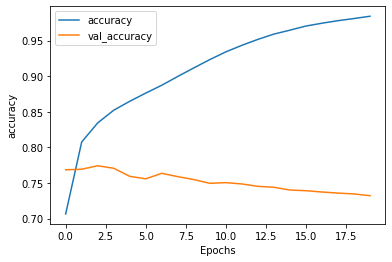

In [19]:
plot_graphs(history, 'accuracy')

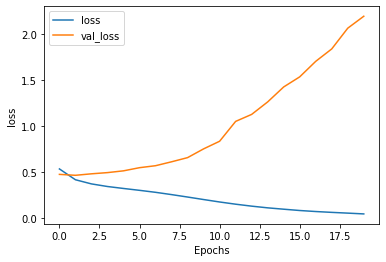

In [20]:
plot_graphs(history, 'loss')

La précision du modèle sur notre jeu de test est de 0.729, cette valeur est peu satisfaisante sachant que la précision sur le jeu de test est de 0.98.

On constate sur le graphique ci-dessus que la précision et la perte sur le jeu de données d'entrainement augmentent alors que la précision et la perte sur le jeu de données de validation diminuent d'itération en itération.

Il y a plusieurs possibilités pour expliquer cela : 
- Le modèle est en train de sur-apprendre. Ce qui peut parraitre étrange dans ce cas car le nombre d'itération est relativement faible
- Il n'y a pas asser de données. Actuellement 100 000 tweets sont utilisés pour l'apprentissage, cependant il est fort possible que ce nombre soit encore trop faible, l'algorithme aurait alors rencontré trop peu de patterns différents et aurait donc du mal a généraliser. La raison pour laquelle nous avons utilisé si peu de tweet est le temps d'apprentissage très long mais il serait simple de vérifier si ces courbes évoluent en augmentant le nombre de données d'entrée.
- Le nombre d'itération est trop faible. On voit souvent des algorithmes qui mettent plusieurs centaines ou milliers d'itérations (epochs) avant de sur-apprendre, le graphique qu'on obtient ici aurait peut être un tout autre aspect si le nombre d'itération était de quelques centaines. Il serait simple de vérifier cette hypothèse en augmentant simplement le nombre d'époques lors de l'entrainement mais cela prendrait plusieurs jours pour être exécuté. 
- Le modèle n'est pas asser complexe et a du mal a modéliser le problème. Il est tout à fait probable que ce modèle relativement simple ne soit pas asser puissant pour détecter toutes les spécificités qui font qu'un tweet sera classé comme positif ou négatif, c'est pour cela que nous avons décidé d'implémenter un réseau de neurone avec une couche LSTM supplémentaire. 

# Modèle plus complexe

Suite aux résultats moyennement satisfaisant nous avons obtenus avec le réseau précédent, nous avons décidé de complexifier le premier modèle. 

Ce nouveau modèle se compose de :
- Une couche d'Embedding de 64 neurones qui servira aux données d'entrée
- Une couche LSTM de 64 neurones
- Une couche LSTM de 32 neurones
- Une couche Dense de 64 neurones
- Une couche Dropout destinées à désactiver 50% des neurones de la couche Dense
- Une couche Dense de sortie d'un seul neurone

In [21]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
#tf.keras.models.load_model('LSTM_Complexe.h5')

In [22]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history2 = model2.fit(np.array(train_set), np.array(train_labels), validation_split=0.33, 
                      epochs=10, validation_steps=30)

Epoch 1/10


 185/3141 [>.............................] - ETA: 0s - loss: 0.6926 - accuracy: 0.37 - ETA: 4:44 - loss: 0.6919 - accuracy: 0.40 - ETA: 6:05 - loss: 0.6928 - accuracy: 0.44 - ETA: 6:44 - loss: 0.6935 - accuracy: 0.50 - ETA: 7:05 - loss: 0.6940 - accuracy: 0.51 - ETA: 7:23 - loss: 0.6936 - accuracy: 0.49 - ETA: 7:34 - loss: 0.6939 - accuracy: 0.50 - ETA: 7:41 - loss: 0.6938 - accuracy: 0.50 - ETA: 7:53 - loss: 0.6938 - accuracy: 0.48 - ETA: 7:58 - loss: 0.6938 - accuracy: 0.48 - ETA: 8:01 - loss: 0.6938 - accuracy: 0.48 - ETA: 8:04 - loss: 0.6936 - accuracy: 0.47 - ETA: 8:07 - loss: 0.6936 - accuracy: 0.47 - ETA: 8:08 - loss: 0.6933 - accuracy: 0.46 - ETA: 8:13 - loss: 0.6933 - accuracy: 0.47 - ETA: 8:14 - loss: 0.6933 - accuracy: 0.47 - ETA: 8:16 - loss: 0.6933 - accuracy: 0.47 - ETA: 8:17 - loss: 0.6935 - accuracy: 0.48 - ETA: 8:18 - loss: 0.6936 - accuracy: 0.48 - ETA: 8:19 - loss: 0.6937 - accuracy: 0.48 - ETA: 8:22 - loss: 0.6937 - accuracy: 0.48 - ETA: 8:22 - loss: 0.6937 - accura

 371/3141 [==>...........................] - ETA: 8:09 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:09 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:09 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:09 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:09 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:08 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:08 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:08 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:08 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:08 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:07 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:07 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:07 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:07 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:07 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:07 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:06 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:06 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:06 - loss: 0.6930 - accuracy: 0.50 - ETA: 8:06 - loss: 0.6929 - accuracy: 0.50 - ETA: 8:06 - loss: 0.6929 - accuracy: 0.50 - ETA: 8:06 - loss: 0.6929 - accu

 557/3141 [====>.........................] - ETA: 7:39 - loss: 0.6895 - accuracy: 0.50 - ETA: 7:39 - loss: 0.6894 - accuracy: 0.50 - ETA: 7:39 - loss: 0.6893 - accuracy: 0.50 - ETA: 7:39 - loss: 0.6893 - accuracy: 0.50 - ETA: 7:38 - loss: 0.6892 - accuracy: 0.50 - ETA: 7:38 - loss: 0.6892 - accuracy: 0.50 - ETA: 7:38 - loss: 0.6891 - accuracy: 0.50 - ETA: 7:38 - loss: 0.6891 - accuracy: 0.50 - ETA: 7:38 - loss: 0.6890 - accuracy: 0.50 - ETA: 7:38 - loss: 0.6889 - accuracy: 0.50 - ETA: 7:37 - loss: 0.6888 - accuracy: 0.50 - ETA: 7:37 - loss: 0.6888 - accuracy: 0.50 - ETA: 7:37 - loss: 0.6887 - accuracy: 0.50 - ETA: 7:37 - loss: 0.6885 - accuracy: 0.50 - ETA: 7:37 - loss: 0.6885 - accuracy: 0.50 - ETA: 7:36 - loss: 0.6884 - accuracy: 0.50 - ETA: 7:36 - loss: 0.6883 - accuracy: 0.50 - ETA: 7:36 - loss: 0.6882 - accuracy: 0.50 - ETA: 7:36 - loss: 0.6881 - accuracy: 0.50 - ETA: 7:36 - loss: 0.6880 - accuracy: 0.50 - ETA: 7:36 - loss: 0.6880 - accuracy: 0.50 - ETA: 7:36 - loss: 0.6878 - accu

 743/3141 [======>.......................] - ETA: 7:10 - loss: 0.6648 - accuracy: 0.54 - ETA: 7:10 - loss: 0.6650 - accuracy: 0.54 - ETA: 7:10 - loss: 0.6650 - accuracy: 0.54 - ETA: 7:09 - loss: 0.6647 - accuracy: 0.54 - ETA: 7:09 - loss: 0.6644 - accuracy: 0.54 - ETA: 7:09 - loss: 0.6640 - accuracy: 0.54 - ETA: 7:09 - loss: 0.6639 - accuracy: 0.54 - ETA: 7:09 - loss: 0.6638 - accuracy: 0.54 - ETA: 7:09 - loss: 0.6638 - accuracy: 0.54 - ETA: 7:08 - loss: 0.6635 - accuracy: 0.54 - ETA: 7:08 - loss: 0.6636 - accuracy: 0.54 - ETA: 7:08 - loss: 0.6637 - accuracy: 0.54 - ETA: 7:08 - loss: 0.6635 - accuracy: 0.54 - ETA: 7:08 - loss: 0.6636 - accuracy: 0.54 - ETA: 7:07 - loss: 0.6635 - accuracy: 0.54 - ETA: 7:07 - loss: 0.6634 - accuracy: 0.54 - ETA: 7:07 - loss: 0.6632 - accuracy: 0.54 - ETA: 7:07 - loss: 0.6628 - accuracy: 0.54 - ETA: 7:07 - loss: 0.6626 - accuracy: 0.54 - ETA: 7:07 - loss: 0.6626 - accuracy: 0.54 - ETA: 7:06 - loss: 0.6624 - accuracy: 0.54 - ETA: 7:06 - loss: 0.6623 - accu

 929/3141 [=======>......................] - ETA: 6:39 - loss: 0.6417 - accuracy: 0.57 - ETA: 6:39 - loss: 0.6417 - accuracy: 0.57 - ETA: 6:38 - loss: 0.6415 - accuracy: 0.57 - ETA: 6:38 - loss: 0.6413 - accuracy: 0.58 - ETA: 6:38 - loss: 0.6412 - accuracy: 0.58 - ETA: 6:38 - loss: 0.6412 - accuracy: 0.58 - ETA: 6:38 - loss: 0.6412 - accuracy: 0.58 - ETA: 6:38 - loss: 0.6411 - accuracy: 0.58 - ETA: 6:37 - loss: 0.6409 - accuracy: 0.58 - ETA: 6:37 - loss: 0.6408 - accuracy: 0.58 - ETA: 6:37 - loss: 0.6407 - accuracy: 0.58 - ETA: 6:37 - loss: 0.6406 - accuracy: 0.58 - ETA: 6:37 - loss: 0.6404 - accuracy: 0.58 - ETA: 6:36 - loss: 0.6402 - accuracy: 0.58 - ETA: 6:36 - loss: 0.6399 - accuracy: 0.58 - ETA: 6:36 - loss: 0.6398 - accuracy: 0.58 - ETA: 6:36 - loss: 0.6395 - accuracy: 0.58 - ETA: 6:36 - loss: 0.6394 - accuracy: 0.58 - ETA: 6:36 - loss: 0.6394 - accuracy: 0.58 - ETA: 6:35 - loss: 0.6395 - accuracy: 0.58 - ETA: 6:35 - loss: 0.6394 - accuracy: 0.58 - ETA: 6:35 - loss: 0.6393 - accu

1115/3141 [=========>....................] - ETA: 6:08 - loss: 0.6234 - accuracy: 0.60 - ETA: 6:07 - loss: 0.6233 - accuracy: 0.60 - ETA: 6:07 - loss: 0.6234 - accuracy: 0.60 - ETA: 6:07 - loss: 0.6234 - accuracy: 0.60 - ETA: 6:07 - loss: 0.6233 - accuracy: 0.60 - ETA: 6:07 - loss: 0.6231 - accuracy: 0.60 - ETA: 6:07 - loss: 0.6230 - accuracy: 0.60 - ETA: 6:06 - loss: 0.6231 - accuracy: 0.60 - ETA: 6:06 - loss: 0.6232 - accuracy: 0.60 - ETA: 6:06 - loss: 0.6230 - accuracy: 0.60 - ETA: 6:06 - loss: 0.6230 - accuracy: 0.60 - ETA: 6:06 - loss: 0.6230 - accuracy: 0.60 - ETA: 6:06 - loss: 0.6229 - accuracy: 0.60 - ETA: 6:05 - loss: 0.6228 - accuracy: 0.60 - ETA: 6:05 - loss: 0.6228 - accuracy: 0.60 - ETA: 6:05 - loss: 0.6227 - accuracy: 0.60 - ETA: 6:05 - loss: 0.6226 - accuracy: 0.60 - ETA: 6:05 - loss: 0.6225 - accuracy: 0.60 - ETA: 6:05 - loss: 0.6225 - accuracy: 0.60 - ETA: 6:04 - loss: 0.6225 - accuracy: 0.60 - ETA: 6:04 - loss: 0.6224 - accuracy: 0.60 - ETA: 6:04 - loss: 0.6223 - accu

1301/3141 [===========>..................] - ETA: 5:37 - loss: 0.6106 - accuracy: 0.62 - ETA: 5:36 - loss: 0.6105 - accuracy: 0.62 - ETA: 5:36 - loss: 0.6105 - accuracy: 0.62 - ETA: 5:36 - loss: 0.6103 - accuracy: 0.62 - ETA: 5:36 - loss: 0.6103 - accuracy: 0.62 - ETA: 5:36 - loss: 0.6102 - accuracy: 0.62 - ETA: 5:36 - loss: 0.6102 - accuracy: 0.62 - ETA: 5:35 - loss: 0.6102 - accuracy: 0.62 - ETA: 5:35 - loss: 0.6101 - accuracy: 0.62 - ETA: 5:35 - loss: 0.6101 - accuracy: 0.62 - ETA: 5:35 - loss: 0.6099 - accuracy: 0.62 - ETA: 5:35 - loss: 0.6099 - accuracy: 0.62 - ETA: 5:35 - loss: 0.6099 - accuracy: 0.62 - ETA: 5:34 - loss: 0.6099 - accuracy: 0.62 - ETA: 5:34 - loss: 0.6100 - accuracy: 0.62 - ETA: 5:34 - loss: 0.6100 - accuracy: 0.62 - ETA: 5:34 - loss: 0.6099 - accuracy: 0.62 - ETA: 5:34 - loss: 0.6099 - accuracy: 0.62 - ETA: 5:34 - loss: 0.6098 - accuracy: 0.62 - ETA: 5:33 - loss: 0.6097 - accuracy: 0.62 - ETA: 5:33 - loss: 0.6096 - accuracy: 0.62 - ETA: 5:33 - loss: 0.6096 - accu

1487/3141 [=============>................] - ETA: 5:06 - loss: 0.5983 - accuracy: 0.64 - ETA: 5:06 - loss: 0.5984 - accuracy: 0.64 - ETA: 5:06 - loss: 0.5983 - accuracy: 0.64 - ETA: 5:06 - loss: 0.5983 - accuracy: 0.64 - ETA: 5:05 - loss: 0.5981 - accuracy: 0.64 - ETA: 5:05 - loss: 0.5980 - accuracy: 0.64 - ETA: 5:05 - loss: 0.5980 - accuracy: 0.64 - ETA: 5:05 - loss: 0.5978 - accuracy: 0.64 - ETA: 5:05 - loss: 0.5978 - accuracy: 0.64 - ETA: 5:04 - loss: 0.5976 - accuracy: 0.64 - ETA: 5:04 - loss: 0.5975 - accuracy: 0.64 - ETA: 5:04 - loss: 0.5974 - accuracy: 0.64 - ETA: 5:04 - loss: 0.5974 - accuracy: 0.64 - ETA: 5:04 - loss: 0.5973 - accuracy: 0.64 - ETA: 5:04 - loss: 0.5973 - accuracy: 0.64 - ETA: 5:03 - loss: 0.5972 - accuracy: 0.64 - ETA: 5:03 - loss: 0.5971 - accuracy: 0.64 - ETA: 5:03 - loss: 0.5971 - accuracy: 0.64 - ETA: 5:03 - loss: 0.5971 - accuracy: 0.64 - ETA: 5:03 - loss: 0.5971 - accuracy: 0.64 - ETA: 5:03 - loss: 0.5969 - accuracy: 0.64 - ETA: 5:02 - loss: 0.5970 - accu

1673/3141 [==============>...............] - ETA: 4:35 - loss: 0.5882 - accuracy: 0.65 - ETA: 4:35 - loss: 0.5881 - accuracy: 0.65 - ETA: 4:35 - loss: 0.5880 - accuracy: 0.65 - ETA: 4:34 - loss: 0.5880 - accuracy: 0.65 - ETA: 4:34 - loss: 0.5879 - accuracy: 0.65 - ETA: 4:34 - loss: 0.5878 - accuracy: 0.65 - ETA: 4:34 - loss: 0.5877 - accuracy: 0.65 - ETA: 4:34 - loss: 0.5878 - accuracy: 0.65 - ETA: 4:34 - loss: 0.5877 - accuracy: 0.65 - ETA: 4:33 - loss: 0.5876 - accuracy: 0.65 - ETA: 4:33 - loss: 0.5876 - accuracy: 0.65 - ETA: 4:33 - loss: 0.5875 - accuracy: 0.65 - ETA: 4:33 - loss: 0.5874 - accuracy: 0.65 - ETA: 4:33 - loss: 0.5874 - accuracy: 0.65 - ETA: 4:33 - loss: 0.5872 - accuracy: 0.65 - ETA: 4:32 - loss: 0.5873 - accuracy: 0.65 - ETA: 4:32 - loss: 0.5873 - accuracy: 0.65 - ETA: 4:32 - loss: 0.5871 - accuracy: 0.65 - ETA: 4:32 - loss: 0.5870 - accuracy: 0.65 - ETA: 4:32 - loss: 0.5869 - accuracy: 0.65 - ETA: 4:32 - loss: 0.5868 - accuracy: 0.65 - ETA: 4:31 - loss: 0.5866 - accu

1859/3141 [================>.............] - ETA: 4:04 - loss: 0.5791 - accuracy: 0.66 - ETA: 4:04 - loss: 0.5789 - accuracy: 0.66 - ETA: 4:03 - loss: 0.5789 - accuracy: 0.66 - ETA: 4:03 - loss: 0.5788 - accuracy: 0.66 - ETA: 4:03 - loss: 0.5788 - accuracy: 0.66 - ETA: 4:03 - loss: 0.5788 - accuracy: 0.66 - ETA: 4:03 - loss: 0.5788 - accuracy: 0.66 - ETA: 4:03 - loss: 0.5787 - accuracy: 0.66 - ETA: 4:02 - loss: 0.5786 - accuracy: 0.66 - ETA: 4:02 - loss: 0.5787 - accuracy: 0.66 - ETA: 4:02 - loss: 0.5787 - accuracy: 0.66 - ETA: 4:02 - loss: 0.5787 - accuracy: 0.66 - ETA: 4:02 - loss: 0.5786 - accuracy: 0.66 - ETA: 4:02 - loss: 0.5786 - accuracy: 0.66 - ETA: 4:01 - loss: 0.5785 - accuracy: 0.66 - ETA: 4:01 - loss: 0.5784 - accuracy: 0.66 - ETA: 4:01 - loss: 0.5784 - accuracy: 0.66 - ETA: 4:01 - loss: 0.5784 - accuracy: 0.66 - ETA: 4:01 - loss: 0.5784 - accuracy: 0.66 - ETA: 4:01 - loss: 0.5783 - accuracy: 0.66 - ETA: 4:00 - loss: 0.5783 - accuracy: 0.66 - ETA: 4:00 - loss: 0.5783 - accu

2045/3141 [==================>...........] - ETA: 3:33 - loss: 0.5703 - accuracy: 0.67 - ETA: 3:33 - loss: 0.5702 - accuracy: 0.67 - ETA: 3:33 - loss: 0.5702 - accuracy: 0.67 - ETA: 3:32 - loss: 0.5702 - accuracy: 0.67 - ETA: 3:32 - loss: 0.5702 - accuracy: 0.67 - ETA: 3:32 - loss: 0.5700 - accuracy: 0.67 - ETA: 3:32 - loss: 0.5700 - accuracy: 0.67 - ETA: 3:32 - loss: 0.5700 - accuracy: 0.67 - ETA: 3:32 - loss: 0.5699 - accuracy: 0.67 - ETA: 3:31 - loss: 0.5699 - accuracy: 0.67 - ETA: 3:31 - loss: 0.5699 - accuracy: 0.67 - ETA: 3:31 - loss: 0.5699 - accuracy: 0.67 - ETA: 3:31 - loss: 0.5698 - accuracy: 0.67 - ETA: 3:31 - loss: 0.5698 - accuracy: 0.67 - ETA: 3:31 - loss: 0.5698 - accuracy: 0.67 - ETA: 3:30 - loss: 0.5697 - accuracy: 0.67 - ETA: 3:30 - loss: 0.5696 - accuracy: 0.67 - ETA: 3:30 - loss: 0.5695 - accuracy: 0.67 - ETA: 3:30 - loss: 0.5695 - accuracy: 0.67 - ETA: 3:30 - loss: 0.5694 - accuracy: 0.67 - ETA: 3:30 - loss: 0.5694 - accuracy: 0.67 - ETA: 3:29 - loss: 0.5693 - accu

2231/3141 [====================>.........] - ETA: 3:02 - loss: 0.5629 - accuracy: 0.68 - ETA: 3:02 - loss: 0.5628 - accuracy: 0.68 - ETA: 3:02 - loss: 0.5628 - accuracy: 0.68 - ETA: 3:01 - loss: 0.5628 - accuracy: 0.68 - ETA: 3:01 - loss: 0.5628 - accuracy: 0.68 - ETA: 3:01 - loss: 0.5627 - accuracy: 0.68 - ETA: 3:01 - loss: 0.5627 - accuracy: 0.68 - ETA: 3:01 - loss: 0.5627 - accuracy: 0.68 - ETA: 3:01 - loss: 0.5627 - accuracy: 0.68 - ETA: 3:00 - loss: 0.5627 - accuracy: 0.68 - ETA: 3:00 - loss: 0.5627 - accuracy: 0.68 - ETA: 3:00 - loss: 0.5626 - accuracy: 0.68 - ETA: 3:00 - loss: 0.5626 - accuracy: 0.68 - ETA: 3:00 - loss: 0.5626 - accuracy: 0.68 - ETA: 3:00 - loss: 0.5625 - accuracy: 0.68 - ETA: 2:59 - loss: 0.5624 - accuracy: 0.68 - ETA: 2:59 - loss: 0.5624 - accuracy: 0.68 - ETA: 2:59 - loss: 0.5623 - accuracy: 0.68 - ETA: 2:59 - loss: 0.5622 - accuracy: 0.68 - ETA: 2:59 - loss: 0.5622 - accuracy: 0.68 - ETA: 2:59 - loss: 0.5622 - accuracy: 0.68 - ETA: 2:58 - loss: 0.5621 - accu

2417/3141 [======================>.......] - ETA: 2:31 - loss: 0.5569 - accuracy: 0.68 - ETA: 2:31 - loss: 0.5569 - accuracy: 0.68 - ETA: 2:31 - loss: 0.5568 - accuracy: 0.68 - ETA: 2:30 - loss: 0.5569 - accuracy: 0.68 - ETA: 2:30 - loss: 0.5568 - accuracy: 0.68 - ETA: 2:30 - loss: 0.5568 - accuracy: 0.68 - ETA: 2:30 - loss: 0.5568 - accuracy: 0.68 - ETA: 2:30 - loss: 0.5567 - accuracy: 0.68 - ETA: 2:30 - loss: 0.5567 - accuracy: 0.68 - ETA: 2:29 - loss: 0.5566 - accuracy: 0.68 - ETA: 2:29 - loss: 0.5566 - accuracy: 0.68 - ETA: 2:29 - loss: 0.5566 - accuracy: 0.68 - ETA: 2:29 - loss: 0.5566 - accuracy: 0.68 - ETA: 2:29 - loss: 0.5566 - accuracy: 0.68 - ETA: 2:29 - loss: 0.5565 - accuracy: 0.68 - ETA: 2:28 - loss: 0.5565 - accuracy: 0.68 - ETA: 2:28 - loss: 0.5564 - accuracy: 0.68 - ETA: 2:28 - loss: 0.5563 - accuracy: 0.68 - ETA: 2:28 - loss: 0.5563 - accuracy: 0.68 - ETA: 2:28 - loss: 0.5563 - accuracy: 0.68 - ETA: 2:28 - loss: 0.5562 - accuracy: 0.68 - ETA: 2:27 - loss: 0.5562 - accu

2603/3141 [=======================>......] - ETA: 2:00 - loss: 0.5512 - accuracy: 0.69 - ETA: 2:00 - loss: 0.5511 - accuracy: 0.69 - ETA: 2:00 - loss: 0.5511 - accuracy: 0.69 - ETA: 1:59 - loss: 0.5510 - accuracy: 0.69 - ETA: 1:59 - loss: 0.5510 - accuracy: 0.69 - ETA: 1:59 - loss: 0.5509 - accuracy: 0.69 - ETA: 1:59 - loss: 0.5508 - accuracy: 0.69 - ETA: 1:59 - loss: 0.5508 - accuracy: 0.69 - ETA: 1:59 - loss: 0.5509 - accuracy: 0.69 - ETA: 1:58 - loss: 0.5509 - accuracy: 0.69 - ETA: 1:58 - loss: 0.5508 - accuracy: 0.69 - ETA: 1:58 - loss: 0.5508 - accuracy: 0.69 - ETA: 1:58 - loss: 0.5508 - accuracy: 0.69 - ETA: 1:58 - loss: 0.5508 - accuracy: 0.69 - ETA: 1:58 - loss: 0.5508 - accuracy: 0.69 - ETA: 1:57 - loss: 0.5509 - accuracy: 0.69 - ETA: 1:57 - loss: 0.5509 - accuracy: 0.69 - ETA: 1:57 - loss: 0.5508 - accuracy: 0.69 - ETA: 1:57 - loss: 0.5509 - accuracy: 0.69 - ETA: 1:57 - loss: 0.5509 - accuracy: 0.69 - ETA: 1:57 - loss: 0.5509 - accuracy: 0.69 - ETA: 1:56 - loss: 0.5508 - accu

2789/3141 [=========================>....] - ETA: 1:29 - loss: 0.5456 - accuracy: 0.69 - ETA: 1:29 - loss: 0.5455 - accuracy: 0.69 - ETA: 1:29 - loss: 0.5455 - accuracy: 0.69 - ETA: 1:28 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:28 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:28 - loss: 0.5455 - accuracy: 0.69 - ETA: 1:28 - loss: 0.5455 - accuracy: 0.69 - ETA: 1:28 - loss: 0.5455 - accuracy: 0.69 - ETA: 1:28 - loss: 0.5455 - accuracy: 0.69 - ETA: 1:27 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:27 - loss: 0.5455 - accuracy: 0.69 - ETA: 1:27 - loss: 0.5455 - accuracy: 0.69 - ETA: 1:27 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:27 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:27 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:26 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:26 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:26 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:26 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:26 - loss: 0.5453 - accuracy: 0.69 - ETA: 1:26 - loss: 0.5454 - accuracy: 0.69 - ETA: 1:25 - loss: 0.5453 - accu

2975/3141 [===========================>..] - ETA: 58s - loss: 0.5413 - accuracy: 0.702 - ETA: 58s - loss: 0.5412 - accuracy: 0.702 - ETA: 58s - loss: 0.5412 - accuracy: 0.702 - ETA: 57s - loss: 0.5411 - accuracy: 0.702 - ETA: 57s - loss: 0.5410 - accuracy: 0.702 - ETA: 57s - loss: 0.5411 - accuracy: 0.702 - ETA: 57s - loss: 0.5410 - accuracy: 0.702 - ETA: 57s - loss: 0.5410 - accuracy: 0.702 - ETA: 57s - loss: 0.5410 - accuracy: 0.702 - ETA: 56s - loss: 0.5410 - accuracy: 0.702 - ETA: 56s - loss: 0.5409 - accuracy: 0.702 - ETA: 56s - loss: 0.5409 - accuracy: 0.702 - ETA: 56s - loss: 0.5409 - accuracy: 0.702 - ETA: 56s - loss: 0.5408 - accuracy: 0.702 - ETA: 56s - loss: 0.5407 - accuracy: 0.702 - ETA: 55s - loss: 0.5407 - accuracy: 0.702 - ETA: 55s - loss: 0.5406 - accuracy: 0.702 - ETA: 55s - loss: 0.5406 - accuracy: 0.702 - ETA: 55s - loss: 0.5405 - accuracy: 0.702 - ETA: 55s - loss: 0.5406 - accuracy: 0.702 - ETA: 55s - loss: 0.5407 - accuracy: 0.702 - ETA: 54s - loss: 0.5407 - accur

3141/3141 [==============================] - ETA: 27s - loss: 0.5374 - accuracy: 0.705 - ETA: 27s - loss: 0.5374 - accuracy: 0.705 - ETA: 27s - loss: 0.5374 - accuracy: 0.705 - ETA: 26s - loss: 0.5374 - accuracy: 0.705 - ETA: 26s - loss: 0.5374 - accuracy: 0.705 - ETA: 26s - loss: 0.5374 - accuracy: 0.705 - ETA: 26s - loss: 0.5374 - accuracy: 0.705 - ETA: 26s - loss: 0.5373 - accuracy: 0.705 - ETA: 26s - loss: 0.5373 - accuracy: 0.705 - ETA: 25s - loss: 0.5373 - accuracy: 0.705 - ETA: 25s - loss: 0.5373 - accuracy: 0.705 - ETA: 25s - loss: 0.5373 - accuracy: 0.705 - ETA: 25s - loss: 0.5372 - accuracy: 0.705 - ETA: 25s - loss: 0.5372 - accuracy: 0.705 - ETA: 25s - loss: 0.5372 - accuracy: 0.705 - ETA: 24s - loss: 0.5372 - accuracy: 0.705 - ETA: 24s - loss: 0.5372 - accuracy: 0.705 - ETA: 24s - loss: 0.5372 - accuracy: 0.705 - ETA: 24s - loss: 0.5371 - accuracy: 0.705 - ETA: 24s - loss: 0.5371 - accuracy: 0.705 - ETA: 24s - loss: 0.5371 - accuracy: 0.706 - ETA: 23s - loss: 0.5371 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.3238 - accuracy: 0.84 - ETA: 4:21 - loss: 0.3184 - accuracy: 0.84 - ETA: 5:48 - loss: 0.3600 - accuracy: 0.82 - ETA: 6:43 - loss: 0.3978 - accuracy: 0.78 - ETA: 7:06 - loss: 0.3918 - accuracy: 0.80 - ETA: 7:21 - loss: 0.4010 - accuracy: 0.80 - ETA: 7:30 - loss: 0.4237 - accuracy: 0.80 - ETA: 7:39 - loss: 0.4117 - accuracy: 0.80 - ETA: 7:46 - loss: 0.4213 - accuracy: 0.79 - ETA: 7:54 - loss: 0.4149 - accuracy: 0.79 - ETA: 7:58 - loss: 0.4140 - accuracy: 0.79 - ETA: 8:01 - loss: 0.4169 - accuracy: 0.78 - ETA: 8:03 - loss: 0.4140 - accuracy: 0.78 - ETA: 8:05 - loss: 0.4081 - accuracy: 0.79 - ETA: 8:07 - loss: 0.4129 - accuracy: 0.78 - ETA: 8:10 - loss: 0.4030 - accuracy: 0.79 - ETA: 8:11 - loss: 0.4082 - accuracy: 0.79 - ETA: 8:12 - loss: 0.4037 - accuracy: 0.79 - ETA: 8:13 - loss: 0.4099 - accuracy: 0.79 - ETA: 8:13 - loss: 0.4053 - accuracy: 0.79 - ETA: 8:14 - loss: 0.4037 - accuracy: 0.80 - ETA: 8:15 - loss: 0.4079 - accura

 372/3141 [==>...........................] - ETA: 8:08 - loss: 0.4078 - accuracy: 0.81 - ETA: 8:08 - loss: 0.4068 - accuracy: 0.81 - ETA: 8:07 - loss: 0.4068 - accuracy: 0.81 - ETA: 8:07 - loss: 0.4070 - accuracy: 0.81 - ETA: 8:07 - loss: 0.4067 - accuracy: 0.81 - ETA: 8:07 - loss: 0.4068 - accuracy: 0.81 - ETA: 8:07 - loss: 0.4070 - accuracy: 0.81 - ETA: 8:07 - loss: 0.4062 - accuracy: 0.81 - ETA: 8:07 - loss: 0.4069 - accuracy: 0.81 - ETA: 8:06 - loss: 0.4075 - accuracy: 0.81 - ETA: 8:06 - loss: 0.4070 - accuracy: 0.81 - ETA: 8:06 - loss: 0.4073 - accuracy: 0.81 - ETA: 8:06 - loss: 0.4073 - accuracy: 0.81 - ETA: 8:06 - loss: 0.4071 - accuracy: 0.81 - ETA: 8:06 - loss: 0.4066 - accuracy: 0.81 - ETA: 8:05 - loss: 0.4069 - accuracy: 0.81 - ETA: 8:05 - loss: 0.4069 - accuracy: 0.81 - ETA: 8:05 - loss: 0.4065 - accuracy: 0.81 - ETA: 8:05 - loss: 0.4067 - accuracy: 0.81 - ETA: 8:05 - loss: 0.4067 - accuracy: 0.81 - ETA: 8:05 - loss: 0.4068 - accuracy: 0.81 - ETA: 8:04 - loss: 0.4068 - accu

 558/3141 [====>.........................] - ETA: 7:39 - loss: 0.4047 - accuracy: 0.81 - ETA: 7:39 - loss: 0.4046 - accuracy: 0.81 - ETA: 7:39 - loss: 0.4046 - accuracy: 0.81 - ETA: 7:39 - loss: 0.4048 - accuracy: 0.81 - ETA: 7:39 - loss: 0.4050 - accuracy: 0.81 - ETA: 7:38 - loss: 0.4049 - accuracy: 0.81 - ETA: 7:38 - loss: 0.4048 - accuracy: 0.81 - ETA: 7:38 - loss: 0.4047 - accuracy: 0.81 - ETA: 7:38 - loss: 0.4046 - accuracy: 0.81 - ETA: 7:38 - loss: 0.4046 - accuracy: 0.81 - ETA: 7:38 - loss: 0.4046 - accuracy: 0.81 - ETA: 7:37 - loss: 0.4044 - accuracy: 0.81 - ETA: 7:37 - loss: 0.4048 - accuracy: 0.81 - ETA: 7:37 - loss: 0.4047 - accuracy: 0.81 - ETA: 7:37 - loss: 0.4045 - accuracy: 0.81 - ETA: 7:37 - loss: 0.4047 - accuracy: 0.81 - ETA: 7:37 - loss: 0.4046 - accuracy: 0.81 - ETA: 7:36 - loss: 0.4046 - accuracy: 0.81 - ETA: 7:36 - loss: 0.4047 - accuracy: 0.81 - ETA: 7:36 - loss: 0.4043 - accuracy: 0.81 - ETA: 7:36 - loss: 0.4042 - accuracy: 0.81 - ETA: 7:36 - loss: 0.4048 - accu

 744/3141 [======>.......................] - ETA: 7:09 - loss: 0.4103 - accuracy: 0.81 - ETA: 7:09 - loss: 0.4102 - accuracy: 0.81 - ETA: 7:08 - loss: 0.4101 - accuracy: 0.81 - ETA: 7:08 - loss: 0.4102 - accuracy: 0.81 - ETA: 7:08 - loss: 0.4104 - accuracy: 0.81 - ETA: 7:08 - loss: 0.4103 - accuracy: 0.81 - ETA: 7:08 - loss: 0.4103 - accuracy: 0.81 - ETA: 7:08 - loss: 0.4102 - accuracy: 0.81 - ETA: 7:07 - loss: 0.4104 - accuracy: 0.81 - ETA: 7:07 - loss: 0.4102 - accuracy: 0.81 - ETA: 7:07 - loss: 0.4102 - accuracy: 0.81 - ETA: 7:07 - loss: 0.4104 - accuracy: 0.81 - ETA: 7:07 - loss: 0.4106 - accuracy: 0.81 - ETA: 7:07 - loss: 0.4106 - accuracy: 0.81 - ETA: 7:06 - loss: 0.4105 - accuracy: 0.81 - ETA: 7:06 - loss: 0.4104 - accuracy: 0.81 - ETA: 7:06 - loss: 0.4104 - accuracy: 0.81 - ETA: 7:06 - loss: 0.4102 - accuracy: 0.81 - ETA: 7:06 - loss: 0.4100 - accuracy: 0.81 - ETA: 7:06 - loss: 0.4099 - accuracy: 0.81 - ETA: 7:05 - loss: 0.4098 - accuracy: 0.81 - ETA: 7:05 - loss: 0.4099 - accu

 930/3141 [=======>......................] - ETA: 6:38 - loss: 0.4086 - accuracy: 0.81 - ETA: 6:38 - loss: 0.4085 - accuracy: 0.81 - ETA: 6:38 - loss: 0.4086 - accuracy: 0.81 - ETA: 6:38 - loss: 0.4089 - accuracy: 0.81 - ETA: 6:38 - loss: 0.4087 - accuracy: 0.81 - ETA: 6:38 - loss: 0.4085 - accuracy: 0.81 - ETA: 6:37 - loss: 0.4085 - accuracy: 0.81 - ETA: 6:37 - loss: 0.4085 - accuracy: 0.81 - ETA: 6:37 - loss: 0.4088 - accuracy: 0.81 - ETA: 6:37 - loss: 0.4089 - accuracy: 0.81 - ETA: 6:37 - loss: 0.4089 - accuracy: 0.81 - ETA: 6:37 - loss: 0.4089 - accuracy: 0.81 - ETA: 6:36 - loss: 0.4090 - accuracy: 0.81 - ETA: 6:36 - loss: 0.4090 - accuracy: 0.81 - ETA: 6:36 - loss: 0.4090 - accuracy: 0.81 - ETA: 6:36 - loss: 0.4089 - accuracy: 0.81 - ETA: 6:36 - loss: 0.4090 - accuracy: 0.81 - ETA: 6:36 - loss: 0.4091 - accuracy: 0.81 - ETA: 6:35 - loss: 0.4094 - accuracy: 0.81 - ETA: 6:35 - loss: 0.4092 - accuracy: 0.81 - ETA: 6:35 - loss: 0.4091 - accuracy: 0.81 - ETA: 6:35 - loss: 0.4090 - accu

1116/3141 [=========>....................] - ETA: 6:07 - loss: 0.4079 - accuracy: 0.81 - ETA: 6:07 - loss: 0.4078 - accuracy: 0.81 - ETA: 6:07 - loss: 0.4077 - accuracy: 0.81 - ETA: 6:07 - loss: 0.4078 - accuracy: 0.81 - ETA: 6:07 - loss: 0.4077 - accuracy: 0.81 - ETA: 6:07 - loss: 0.4075 - accuracy: 0.81 - ETA: 6:06 - loss: 0.4074 - accuracy: 0.81 - ETA: 6:06 - loss: 0.4073 - accuracy: 0.81 - ETA: 6:06 - loss: 0.4071 - accuracy: 0.81 - ETA: 6:06 - loss: 0.4071 - accuracy: 0.81 - ETA: 6:06 - loss: 0.4072 - accuracy: 0.81 - ETA: 6:06 - loss: 0.4071 - accuracy: 0.81 - ETA: 6:05 - loss: 0.4070 - accuracy: 0.81 - ETA: 6:05 - loss: 0.4068 - accuracy: 0.81 - ETA: 6:05 - loss: 0.4068 - accuracy: 0.81 - ETA: 6:05 - loss: 0.4068 - accuracy: 0.81 - ETA: 6:05 - loss: 0.4068 - accuracy: 0.81 - ETA: 6:04 - loss: 0.4066 - accuracy: 0.81 - ETA: 6:04 - loss: 0.4066 - accuracy: 0.81 - ETA: 6:04 - loss: 0.4066 - accuracy: 0.81 - ETA: 6:04 - loss: 0.4064 - accuracy: 0.81 - ETA: 6:04 - loss: 0.4063 - accu

1302/3141 [===========>..................] - ETA: 5:36 - loss: 0.4072 - accuracy: 0.81 - ETA: 5:36 - loss: 0.4073 - accuracy: 0.81 - ETA: 5:36 - loss: 0.4073 - accuracy: 0.81 - ETA: 5:36 - loss: 0.4075 - accuracy: 0.81 - ETA: 5:36 - loss: 0.4074 - accuracy: 0.81 - ETA: 5:36 - loss: 0.4075 - accuracy: 0.81 - ETA: 5:35 - loss: 0.4076 - accuracy: 0.81 - ETA: 5:35 - loss: 0.4075 - accuracy: 0.81 - ETA: 5:35 - loss: 0.4073 - accuracy: 0.81 - ETA: 5:35 - loss: 0.4076 - accuracy: 0.81 - ETA: 5:35 - loss: 0.4076 - accuracy: 0.81 - ETA: 5:35 - loss: 0.4075 - accuracy: 0.81 - ETA: 5:34 - loss: 0.4074 - accuracy: 0.81 - ETA: 5:34 - loss: 0.4074 - accuracy: 0.81 - ETA: 5:34 - loss: 0.4074 - accuracy: 0.81 - ETA: 5:34 - loss: 0.4074 - accuracy: 0.81 - ETA: 5:34 - loss: 0.4074 - accuracy: 0.81 - ETA: 5:34 - loss: 0.4074 - accuracy: 0.81 - ETA: 5:33 - loss: 0.4076 - accuracy: 0.81 - ETA: 5:33 - loss: 0.4075 - accuracy: 0.81 - ETA: 5:33 - loss: 0.4074 - accuracy: 0.81 - ETA: 5:33 - loss: 0.4073 - accu

1488/3141 [=============>................] - ETA: 5:05 - loss: 0.4069 - accuracy: 0.81 - ETA: 5:05 - loss: 0.4069 - accuracy: 0.81 - ETA: 5:05 - loss: 0.4068 - accuracy: 0.81 - ETA: 5:05 - loss: 0.4069 - accuracy: 0.81 - ETA: 5:05 - loss: 0.4069 - accuracy: 0.81 - ETA: 5:05 - loss: 0.4070 - accuracy: 0.81 - ETA: 5:04 - loss: 0.4069 - accuracy: 0.81 - ETA: 5:04 - loss: 0.4069 - accuracy: 0.81 - ETA: 5:04 - loss: 0.4069 - accuracy: 0.81 - ETA: 5:04 - loss: 0.4068 - accuracy: 0.81 - ETA: 5:04 - loss: 0.4070 - accuracy: 0.81 - ETA: 5:04 - loss: 0.4071 - accuracy: 0.81 - ETA: 5:03 - loss: 0.4071 - accuracy: 0.81 - ETA: 5:03 - loss: 0.4071 - accuracy: 0.81 - ETA: 5:03 - loss: 0.4071 - accuracy: 0.81 - ETA: 5:03 - loss: 0.4072 - accuracy: 0.81 - ETA: 5:03 - loss: 0.4072 - accuracy: 0.81 - ETA: 5:03 - loss: 0.4072 - accuracy: 0.81 - ETA: 5:02 - loss: 0.4071 - accuracy: 0.81 - ETA: 5:02 - loss: 0.4071 - accuracy: 0.81 - ETA: 5:02 - loss: 0.4071 - accuracy: 0.81 - ETA: 5:02 - loss: 0.4070 - accu

1674/3141 [==============>...............] - ETA: 4:35 - loss: 0.4094 - accuracy: 0.81 - ETA: 4:34 - loss: 0.4094 - accuracy: 0.81 - ETA: 4:34 - loss: 0.4093 - accuracy: 0.81 - ETA: 4:34 - loss: 0.4093 - accuracy: 0.81 - ETA: 4:34 - loss: 0.4092 - accuracy: 0.81 - ETA: 4:34 - loss: 0.4092 - accuracy: 0.81 - ETA: 4:34 - loss: 0.4091 - accuracy: 0.81 - ETA: 4:33 - loss: 0.4091 - accuracy: 0.81 - ETA: 4:33 - loss: 0.4091 - accuracy: 0.81 - ETA: 4:33 - loss: 0.4090 - accuracy: 0.81 - ETA: 4:33 - loss: 0.4090 - accuracy: 0.81 - ETA: 4:33 - loss: 0.4090 - accuracy: 0.81 - ETA: 4:33 - loss: 0.4090 - accuracy: 0.81 - ETA: 4:32 - loss: 0.4089 - accuracy: 0.81 - ETA: 4:32 - loss: 0.4089 - accuracy: 0.81 - ETA: 4:32 - loss: 0.4090 - accuracy: 0.81 - ETA: 4:32 - loss: 0.4091 - accuracy: 0.81 - ETA: 4:32 - loss: 0.4090 - accuracy: 0.81 - ETA: 4:32 - loss: 0.4089 - accuracy: 0.81 - ETA: 4:31 - loss: 0.4088 - accuracy: 0.81 - ETA: 4:31 - loss: 0.4088 - accuracy: 0.81 - ETA: 4:31 - loss: 0.4089 - accu

1860/3141 [================>.............] - ETA: 4:04 - loss: 0.4094 - accuracy: 0.81 - ETA: 4:04 - loss: 0.4095 - accuracy: 0.81 - ETA: 4:03 - loss: 0.4095 - accuracy: 0.81 - ETA: 4:03 - loss: 0.4095 - accuracy: 0.81 - ETA: 4:03 - loss: 0.4095 - accuracy: 0.81 - ETA: 4:03 - loss: 0.4096 - accuracy: 0.81 - ETA: 4:03 - loss: 0.4096 - accuracy: 0.81 - ETA: 4:03 - loss: 0.4096 - accuracy: 0.81 - ETA: 4:02 - loss: 0.4096 - accuracy: 0.81 - ETA: 4:02 - loss: 0.4096 - accuracy: 0.81 - ETA: 4:02 - loss: 0.4095 - accuracy: 0.81 - ETA: 4:02 - loss: 0.4094 - accuracy: 0.81 - ETA: 4:02 - loss: 0.4094 - accuracy: 0.81 - ETA: 4:02 - loss: 0.4093 - accuracy: 0.81 - ETA: 4:01 - loss: 0.4093 - accuracy: 0.81 - ETA: 4:01 - loss: 0.4092 - accuracy: 0.81 - ETA: 4:01 - loss: 0.4093 - accuracy: 0.81 - ETA: 4:01 - loss: 0.4093 - accuracy: 0.81 - ETA: 4:01 - loss: 0.4094 - accuracy: 0.81 - ETA: 4:01 - loss: 0.4093 - accuracy: 0.81 - ETA: 4:00 - loss: 0.4094 - accuracy: 0.81 - ETA: 4:00 - loss: 0.4093 - accu

2046/3141 [==================>...........] - ETA: 3:33 - loss: 0.4077 - accuracy: 0.81 - ETA: 3:33 - loss: 0.4077 - accuracy: 0.81 - ETA: 3:32 - loss: 0.4076 - accuracy: 0.81 - ETA: 3:32 - loss: 0.4076 - accuracy: 0.81 - ETA: 3:32 - loss: 0.4077 - accuracy: 0.81 - ETA: 3:32 - loss: 0.4076 - accuracy: 0.81 - ETA: 3:32 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:32 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:31 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:31 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:31 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:31 - loss: 0.4079 - accuracy: 0.81 - ETA: 3:31 - loss: 0.4079 - accuracy: 0.81 - ETA: 3:31 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:30 - loss: 0.4079 - accuracy: 0.81 - ETA: 3:30 - loss: 0.4079 - accuracy: 0.81 - ETA: 3:30 - loss: 0.4079 - accuracy: 0.81 - ETA: 3:30 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:30 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:30 - loss: 0.4078 - accuracy: 0.81 - ETA: 3:29 - loss: 0.4077 - accuracy: 0.81 - ETA: 3:29 - loss: 0.4077 - accu

2232/3141 [====================>.........] - ETA: 3:02 - loss: 0.4080 - accuracy: 0.81 - ETA: 3:02 - loss: 0.4081 - accuracy: 0.81 - ETA: 3:01 - loss: 0.4081 - accuracy: 0.81 - ETA: 3:01 - loss: 0.4080 - accuracy: 0.81 - ETA: 3:01 - loss: 0.4081 - accuracy: 0.81 - ETA: 3:01 - loss: 0.4081 - accuracy: 0.81 - ETA: 3:01 - loss: 0.4081 - accuracy: 0.81 - ETA: 3:01 - loss: 0.4080 - accuracy: 0.81 - ETA: 3:00 - loss: 0.4080 - accuracy: 0.81 - ETA: 3:00 - loss: 0.4080 - accuracy: 0.81 - ETA: 3:00 - loss: 0.4080 - accuracy: 0.81 - ETA: 3:00 - loss: 0.4081 - accuracy: 0.81 - ETA: 3:00 - loss: 0.4081 - accuracy: 0.81 - ETA: 3:00 - loss: 0.4080 - accuracy: 0.81 - ETA: 2:59 - loss: 0.4080 - accuracy: 0.81 - ETA: 2:59 - loss: 0.4080 - accuracy: 0.81 - ETA: 2:59 - loss: 0.4080 - accuracy: 0.81 - ETA: 2:59 - loss: 0.4080 - accuracy: 0.81 - ETA: 2:59 - loss: 0.4082 - accuracy: 0.81 - ETA: 2:59 - loss: 0.4082 - accuracy: 0.81 - ETA: 2:58 - loss: 0.4083 - accuracy: 0.81 - ETA: 2:58 - loss: 0.4082 - accu

2418/3141 [======================>.......] - ETA: 2:31 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:31 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:30 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:30 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:30 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:30 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:30 - loss: 0.4095 - accuracy: 0.81 - ETA: 2:30 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:29 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:29 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:29 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:29 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:29 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:29 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:28 - loss: 0.4093 - accuracy: 0.81 - ETA: 2:28 - loss: 0.4093 - accuracy: 0.81 - ETA: 2:28 - loss: 0.4093 - accuracy: 0.81 - ETA: 2:28 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:28 - loss: 0.4095 - accuracy: 0.81 - ETA: 2:28 - loss: 0.4095 - accuracy: 0.81 - ETA: 2:27 - loss: 0.4094 - accuracy: 0.81 - ETA: 2:27 - loss: 0.4095 - accu

2604/3141 [=======================>......] - ETA: 2:00 - loss: 0.4098 - accuracy: 0.81 - ETA: 2:00 - loss: 0.4099 - accuracy: 0.81 - ETA: 1:59 - loss: 0.4100 - accuracy: 0.81 - ETA: 1:59 - loss: 0.4100 - accuracy: 0.81 - ETA: 1:59 - loss: 0.4100 - accuracy: 0.81 - ETA: 1:59 - loss: 0.4100 - accuracy: 0.81 - ETA: 1:59 - loss: 0.4099 - accuracy: 0.81 - ETA: 1:59 - loss: 0.4099 - accuracy: 0.81 - ETA: 1:58 - loss: 0.4099 - accuracy: 0.81 - ETA: 1:58 - loss: 0.4099 - accuracy: 0.81 - ETA: 1:58 - loss: 0.4099 - accuracy: 0.81 - ETA: 1:58 - loss: 0.4098 - accuracy: 0.81 - ETA: 1:58 - loss: 0.4098 - accuracy: 0.81 - ETA: 1:58 - loss: 0.4099 - accuracy: 0.81 - ETA: 1:57 - loss: 0.4099 - accuracy: 0.81 - ETA: 1:57 - loss: 0.4098 - accuracy: 0.81 - ETA: 1:57 - loss: 0.4098 - accuracy: 0.81 - ETA: 1:57 - loss: 0.4098 - accuracy: 0.81 - ETA: 1:57 - loss: 0.4098 - accuracy: 0.81 - ETA: 1:57 - loss: 0.4097 - accuracy: 0.81 - ETA: 1:56 - loss: 0.4096 - accuracy: 0.81 - ETA: 1:56 - loss: 0.4096 - accu

2790/3141 [=========================>....] - ETA: 1:29 - loss: 0.4101 - accuracy: 0.81 - ETA: 1:29 - loss: 0.4101 - accuracy: 0.81 - ETA: 1:29 - loss: 0.4101 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:28 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:27 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:27 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:27 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:27 - loss: 0.4103 - accuracy: 0.81 - ETA: 1:27 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:26 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:26 - loss: 0.4101 - accuracy: 0.81 - ETA: 1:26 - loss: 0.4102 - accuracy: 0.81 - ETA: 1:26 - loss: 0.4103 - accuracy: 0.81 - ETA: 1:26 - loss: 0.4103 - accuracy: 0.81 - ETA: 1:26 - loss: 0.4103 - accuracy: 0.81 - ETA: 1:25 - loss: 0.4103 - accuracy: 0.81 - ETA: 1:25 - loss: 0.4103 - accu

2976/3141 [===========================>..] - ETA: 58s - loss: 0.4111 - accuracy: 0.809 - ETA: 58s - loss: 0.4111 - accuracy: 0.809 - ETA: 58s - loss: 0.4112 - accuracy: 0.809 - ETA: 57s - loss: 0.4112 - accuracy: 0.809 - ETA: 57s - loss: 0.4112 - accuracy: 0.809 - ETA: 57s - loss: 0.4112 - accuracy: 0.809 - ETA: 57s - loss: 0.4112 - accuracy: 0.809 - ETA: 57s - loss: 0.4113 - accuracy: 0.809 - ETA: 57s - loss: 0.4112 - accuracy: 0.809 - ETA: 56s - loss: 0.4112 - accuracy: 0.809 - ETA: 56s - loss: 0.4112 - accuracy: 0.809 - ETA: 56s - loss: 0.4112 - accuracy: 0.809 - ETA: 56s - loss: 0.4112 - accuracy: 0.809 - ETA: 56s - loss: 0.4112 - accuracy: 0.809 - ETA: 56s - loss: 0.4112 - accuracy: 0.809 - ETA: 55s - loss: 0.4112 - accuracy: 0.809 - ETA: 55s - loss: 0.4113 - accuracy: 0.809 - ETA: 55s - loss: 0.4112 - accuracy: 0.809 - ETA: 55s - loss: 0.4112 - accuracy: 0.809 - ETA: 55s - loss: 0.4112 - accuracy: 0.809 - ETA: 55s - loss: 0.4112 - accuracy: 0.809 - ETA: 54s - loss: 0.4112 - accur

3141/3141 [==============================] - ETA: 27s - loss: 0.4120 - accuracy: 0.808 - ETA: 27s - loss: 0.4120 - accuracy: 0.808 - ETA: 27s - loss: 0.4120 - accuracy: 0.808 - ETA: 26s - loss: 0.4120 - accuracy: 0.808 - ETA: 26s - loss: 0.4120 - accuracy: 0.808 - ETA: 26s - loss: 0.4120 - accuracy: 0.808 - ETA: 26s - loss: 0.4120 - accuracy: 0.808 - ETA: 26s - loss: 0.4120 - accuracy: 0.808 - ETA: 26s - loss: 0.4120 - accuracy: 0.808 - ETA: 25s - loss: 0.4120 - accuracy: 0.808 - ETA: 25s - loss: 0.4120 - accuracy: 0.808 - ETA: 25s - loss: 0.4120 - accuracy: 0.808 - ETA: 25s - loss: 0.4120 - accuracy: 0.808 - ETA: 25s - loss: 0.4120 - accuracy: 0.808 - ETA: 25s - loss: 0.4120 - accuracy: 0.808 - ETA: 24s - loss: 0.4120 - accuracy: 0.808 - ETA: 24s - loss: 0.4120 - accuracy: 0.808 - ETA: 24s - loss: 0.4120 - accuracy: 0.808 - ETA: 24s - loss: 0.4120 - accuracy: 0.808 - ETA: 24s - loss: 0.4120 - accuracy: 0.808 - ETA: 24s - loss: 0.4119 - accuracy: 0.808 - ETA: 23s - loss: 0.4120 - accur

 186/3141 [>.............................] - ETA: 3s - loss: 0.4877 - accuracy: 0.81 - ETA: 4:18 - loss: 0.4264 - accuracy: 0.76 - ETA: 5:43 - loss: 0.4005 - accuracy: 0.79 - ETA: 6:27 - loss: 0.4357 - accuracy: 0.79 - ETA: 6:53 - loss: 0.4167 - accuracy: 0.81 - ETA: 7:13 - loss: 0.4134 - accuracy: 0.80 - ETA: 7:28 - loss: 0.3924 - accuracy: 0.82 - ETA: 7:36 - loss: 0.3817 - accuracy: 0.82 - ETA: 7:42 - loss: 0.3992 - accuracy: 0.81 - ETA: 7:48 - loss: 0.3986 - accuracy: 0.82 - ETA: 7:51 - loss: 0.3935 - accuracy: 0.82 - ETA: 7:56 - loss: 0.3998 - accuracy: 0.82 - ETA: 8:00 - loss: 0.3966 - accuracy: 0.82 - ETA: 8:09 - loss: 0.3903 - accuracy: 0.82 - ETA: 8:15 - loss: 0.3800 - accuracy: 0.83 - ETA: 8:15 - loss: 0.3779 - accuracy: 0.83 - ETA: 8:19 - loss: 0.3955 - accuracy: 0.83 - ETA: 8:23 - loss: 0.3904 - accuracy: 0.84 - ETA: 8:28 - loss: 0.3849 - accuracy: 0.84 - ETA: 8:30 - loss: 0.3911 - accuracy: 0.83 - ETA: 8:30 - loss: 0.3885 - accuracy: 0.83 - ETA: 8:31 - loss: 0.3949 - accura

 372/3141 [==>...........................] - ETA: 8:11 - loss: 0.3546 - accuracy: 0.84 - ETA: 8:11 - loss: 0.3539 - accuracy: 0.84 - ETA: 8:11 - loss: 0.3541 - accuracy: 0.84 - ETA: 8:10 - loss: 0.3534 - accuracy: 0.84 - ETA: 8:10 - loss: 0.3531 - accuracy: 0.84 - ETA: 8:10 - loss: 0.3537 - accuracy: 0.84 - ETA: 8:10 - loss: 0.3539 - accuracy: 0.84 - ETA: 8:10 - loss: 0.3536 - accuracy: 0.84 - ETA: 8:10 - loss: 0.3541 - accuracy: 0.84 - ETA: 8:09 - loss: 0.3547 - accuracy: 0.84 - ETA: 8:09 - loss: 0.3548 - accuracy: 0.84 - ETA: 8:09 - loss: 0.3551 - accuracy: 0.84 - ETA: 8:09 - loss: 0.3549 - accuracy: 0.84 - ETA: 8:09 - loss: 0.3544 - accuracy: 0.84 - ETA: 8:09 - loss: 0.3549 - accuracy: 0.84 - ETA: 8:08 - loss: 0.3551 - accuracy: 0.84 - ETA: 8:08 - loss: 0.3547 - accuracy: 0.84 - ETA: 8:08 - loss: 0.3536 - accuracy: 0.84 - ETA: 8:08 - loss: 0.3533 - accuracy: 0.84 - ETA: 8:08 - loss: 0.3530 - accuracy: 0.84 - ETA: 8:07 - loss: 0.3525 - accuracy: 0.84 - ETA: 8:07 - loss: 0.3521 - accu

 558/3141 [====>.........................] - ETA: 7:41 - loss: 0.3556 - accuracy: 0.84 - ETA: 7:40 - loss: 0.3559 - accuracy: 0.84 - ETA: 7:40 - loss: 0.3559 - accuracy: 0.84 - ETA: 7:40 - loss: 0.3560 - accuracy: 0.84 - ETA: 7:40 - loss: 0.3561 - accuracy: 0.84 - ETA: 7:40 - loss: 0.3563 - accuracy: 0.84 - ETA: 7:40 - loss: 0.3561 - accuracy: 0.84 - ETA: 7:40 - loss: 0.3556 - accuracy: 0.84 - ETA: 7:39 - loss: 0.3557 - accuracy: 0.84 - ETA: 7:39 - loss: 0.3553 - accuracy: 0.84 - ETA: 7:39 - loss: 0.3555 - accuracy: 0.84 - ETA: 7:39 - loss: 0.3552 - accuracy: 0.84 - ETA: 7:39 - loss: 0.3551 - accuracy: 0.84 - ETA: 7:39 - loss: 0.3549 - accuracy: 0.84 - ETA: 7:38 - loss: 0.3545 - accuracy: 0.84 - ETA: 7:38 - loss: 0.3545 - accuracy: 0.84 - ETA: 7:38 - loss: 0.3545 - accuracy: 0.84 - ETA: 7:38 - loss: 0.3545 - accuracy: 0.84 - ETA: 7:38 - loss: 0.3546 - accuracy: 0.84 - ETA: 7:38 - loss: 0.3545 - accuracy: 0.84 - ETA: 7:37 - loss: 0.3547 - accuracy: 0.84 - ETA: 7:37 - loss: 0.3547 - accu

 744/3141 [======>.......................] - ETA: 7:10 - loss: 0.3565 - accuracy: 0.84 - ETA: 7:10 - loss: 0.3564 - accuracy: 0.84 - ETA: 7:09 - loss: 0.3565 - accuracy: 0.84 - ETA: 7:09 - loss: 0.3566 - accuracy: 0.84 - ETA: 7:09 - loss: 0.3566 - accuracy: 0.84 - ETA: 7:09 - loss: 0.3566 - accuracy: 0.84 - ETA: 7:09 - loss: 0.3568 - accuracy: 0.84 - ETA: 7:09 - loss: 0.3567 - accuracy: 0.84 - ETA: 7:08 - loss: 0.3567 - accuracy: 0.84 - ETA: 7:08 - loss: 0.3567 - accuracy: 0.84 - ETA: 7:08 - loss: 0.3568 - accuracy: 0.84 - ETA: 7:08 - loss: 0.3566 - accuracy: 0.84 - ETA: 7:08 - loss: 0.3565 - accuracy: 0.84 - ETA: 7:08 - loss: 0.3565 - accuracy: 0.84 - ETA: 7:07 - loss: 0.3565 - accuracy: 0.84 - ETA: 7:07 - loss: 0.3565 - accuracy: 0.84 - ETA: 7:07 - loss: 0.3565 - accuracy: 0.84 - ETA: 7:07 - loss: 0.3566 - accuracy: 0.84 - ETA: 7:07 - loss: 0.3567 - accuracy: 0.84 - ETA: 7:07 - loss: 0.3567 - accuracy: 0.84 - ETA: 7:06 - loss: 0.3565 - accuracy: 0.84 - ETA: 7:06 - loss: 0.3564 - accu

 930/3141 [=======>......................] - ETA: 6:39 - loss: 0.3554 - accuracy: 0.84 - ETA: 6:39 - loss: 0.3555 - accuracy: 0.84 - ETA: 6:39 - loss: 0.3555 - accuracy: 0.84 - ETA: 6:39 - loss: 0.3556 - accuracy: 0.84 - ETA: 6:39 - loss: 0.3554 - accuracy: 0.84 - ETA: 6:38 - loss: 0.3553 - accuracy: 0.84 - ETA: 6:38 - loss: 0.3552 - accuracy: 0.84 - ETA: 6:38 - loss: 0.3552 - accuracy: 0.84 - ETA: 6:38 - loss: 0.3551 - accuracy: 0.84 - ETA: 6:38 - loss: 0.3553 - accuracy: 0.84 - ETA: 6:38 - loss: 0.3550 - accuracy: 0.84 - ETA: 6:37 - loss: 0.3549 - accuracy: 0.84 - ETA: 6:37 - loss: 0.3548 - accuracy: 0.84 - ETA: 6:37 - loss: 0.3546 - accuracy: 0.84 - ETA: 6:37 - loss: 0.3546 - accuracy: 0.84 - ETA: 6:37 - loss: 0.3545 - accuracy: 0.84 - ETA: 6:37 - loss: 0.3544 - accuracy: 0.84 - ETA: 6:36 - loss: 0.3544 - accuracy: 0.84 - ETA: 6:36 - loss: 0.3542 - accuracy: 0.84 - ETA: 6:36 - loss: 0.3543 - accuracy: 0.84 - ETA: 6:36 - loss: 0.3541 - accuracy: 0.84 - ETA: 6:36 - loss: 0.3544 - accu

1116/3141 [=========>....................] - ETA: 6:08 - loss: 0.3570 - accuracy: 0.84 - ETA: 6:08 - loss: 0.3572 - accuracy: 0.84 - ETA: 6:08 - loss: 0.3572 - accuracy: 0.84 - ETA: 6:08 - loss: 0.3571 - accuracy: 0.84 - ETA: 6:07 - loss: 0.3570 - accuracy: 0.84 - ETA: 6:07 - loss: 0.3569 - accuracy: 0.84 - ETA: 6:07 - loss: 0.3569 - accuracy: 0.84 - ETA: 6:07 - loss: 0.3569 - accuracy: 0.84 - ETA: 6:07 - loss: 0.3570 - accuracy: 0.84 - ETA: 6:07 - loss: 0.3570 - accuracy: 0.84 - ETA: 6:06 - loss: 0.3570 - accuracy: 0.84 - ETA: 6:06 - loss: 0.3569 - accuracy: 0.84 - ETA: 6:06 - loss: 0.3569 - accuracy: 0.84 - ETA: 6:06 - loss: 0.3569 - accuracy: 0.84 - ETA: 6:06 - loss: 0.3569 - accuracy: 0.84 - ETA: 6:06 - loss: 0.3568 - accuracy: 0.84 - ETA: 6:05 - loss: 0.3569 - accuracy: 0.84 - ETA: 6:05 - loss: 0.3568 - accuracy: 0.84 - ETA: 6:05 - loss: 0.3568 - accuracy: 0.84 - ETA: 6:05 - loss: 0.3568 - accuracy: 0.84 - ETA: 6:05 - loss: 0.3567 - accuracy: 0.84 - ETA: 6:05 - loss: 0.3568 - accu

1302/3141 [===========>..................] - ETA: 5:37 - loss: 0.3569 - accuracy: 0.84 - ETA: 5:37 - loss: 0.3568 - accuracy: 0.84 - ETA: 5:37 - loss: 0.3568 - accuracy: 0.84 - ETA: 5:37 - loss: 0.3569 - accuracy: 0.84 - ETA: 5:37 - loss: 0.3568 - accuracy: 0.84 - ETA: 5:36 - loss: 0.3566 - accuracy: 0.84 - ETA: 5:36 - loss: 0.3566 - accuracy: 0.84 - ETA: 5:36 - loss: 0.3565 - accuracy: 0.84 - ETA: 5:36 - loss: 0.3564 - accuracy: 0.84 - ETA: 5:36 - loss: 0.3565 - accuracy: 0.84 - ETA: 5:35 - loss: 0.3564 - accuracy: 0.84 - ETA: 5:35 - loss: 0.3564 - accuracy: 0.84 - ETA: 5:35 - loss: 0.3564 - accuracy: 0.84 - ETA: 5:35 - loss: 0.3565 - accuracy: 0.84 - ETA: 5:35 - loss: 0.3565 - accuracy: 0.84 - ETA: 5:35 - loss: 0.3564 - accuracy: 0.84 - ETA: 5:34 - loss: 0.3562 - accuracy: 0.84 - ETA: 5:34 - loss: 0.3561 - accuracy: 0.84 - ETA: 5:34 - loss: 0.3561 - accuracy: 0.84 - ETA: 5:34 - loss: 0.3560 - accuracy: 0.84 - ETA: 5:34 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:34 - loss: 0.3559 - accu

1488/3141 [=============>................] - ETA: 5:06 - loss: 0.3562 - accuracy: 0.84 - ETA: 5:06 - loss: 0.3561 - accuracy: 0.84 - ETA: 5:06 - loss: 0.3562 - accuracy: 0.84 - ETA: 5:06 - loss: 0.3562 - accuracy: 0.84 - ETA: 5:05 - loss: 0.3562 - accuracy: 0.84 - ETA: 5:05 - loss: 0.3562 - accuracy: 0.84 - ETA: 5:05 - loss: 0.3560 - accuracy: 0.84 - ETA: 5:05 - loss: 0.3561 - accuracy: 0.84 - ETA: 5:05 - loss: 0.3560 - accuracy: 0.84 - ETA: 5:05 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:04 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:04 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:04 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:04 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:04 - loss: 0.3558 - accuracy: 0.84 - ETA: 5:04 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:03 - loss: 0.3558 - accuracy: 0.84 - ETA: 5:03 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:03 - loss: 0.3559 - accuracy: 0.84 - ETA: 5:03 - loss: 0.3560 - accuracy: 0.84 - ETA: 5:03 - loss: 0.3560 - accuracy: 0.84 - ETA: 5:03 - loss: 0.3559 - accu

1674/3141 [==============>...............] - ETA: 4:35 - loss: 0.3553 - accuracy: 0.84 - ETA: 4:35 - loss: 0.3555 - accuracy: 0.84 - ETA: 4:35 - loss: 0.3557 - accuracy: 0.84 - ETA: 4:35 - loss: 0.3557 - accuracy: 0.84 - ETA: 4:34 - loss: 0.3557 - accuracy: 0.84 - ETA: 4:34 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:34 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:34 - loss: 0.3555 - accuracy: 0.84 - ETA: 4:34 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:34 - loss: 0.3555 - accuracy: 0.84 - ETA: 4:33 - loss: 0.3555 - accuracy: 0.84 - ETA: 4:33 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:33 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:33 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:33 - loss: 0.3555 - accuracy: 0.84 - ETA: 4:33 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:32 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:32 - loss: 0.3557 - accuracy: 0.84 - ETA: 4:32 - loss: 0.3558 - accuracy: 0.84 - ETA: 4:32 - loss: 0.3558 - accuracy: 0.84 - ETA: 4:32 - loss: 0.3559 - accuracy: 0.84 - ETA: 4:32 - loss: 0.3559 - accu

1860/3141 [================>.............] - ETA: 4:04 - loss: 0.3553 - accuracy: 0.84 - ETA: 4:04 - loss: 0.3553 - accuracy: 0.84 - ETA: 4:04 - loss: 0.3552 - accuracy: 0.84 - ETA: 4:04 - loss: 0.3554 - accuracy: 0.84 - ETA: 4:03 - loss: 0.3555 - accuracy: 0.84 - ETA: 4:03 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:03 - loss: 0.3556 - accuracy: 0.84 - ETA: 4:03 - loss: 0.3557 - accuracy: 0.84 - ETA: 4:03 - loss: 0.3558 - accuracy: 0.84 - ETA: 4:03 - loss: 0.3557 - accuracy: 0.84 - ETA: 4:02 - loss: 0.3558 - accuracy: 0.84 - ETA: 4:02 - loss: 0.3558 - accuracy: 0.84 - ETA: 4:02 - loss: 0.3558 - accuracy: 0.84 - ETA: 4:02 - loss: 0.3559 - accuracy: 0.84 - ETA: 4:02 - loss: 0.3559 - accuracy: 0.84 - ETA: 4:02 - loss: 0.3559 - accuracy: 0.84 - ETA: 4:01 - loss: 0.3558 - accuracy: 0.84 - ETA: 4:01 - loss: 0.3559 - accuracy: 0.84 - ETA: 4:01 - loss: 0.3558 - accuracy: 0.84 - ETA: 4:01 - loss: 0.3560 - accuracy: 0.84 - ETA: 4:01 - loss: 0.3560 - accuracy: 0.84 - ETA: 4:01 - loss: 0.3559 - accu

2046/3141 [==================>...........] - ETA: 3:33 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:33 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:33 - loss: 0.3562 - accuracy: 0.84 - ETA: 3:33 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3562 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3562 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3562 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:32 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:31 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3566 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3566 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3567 - accuracy: 0.84 - ETA: 3:30 - loss: 0.3567 - accu

2232/3141 [====================>.........] - ETA: 3:02 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:02 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:02 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:01 - loss: 0.3563 - accuracy: 0.84 - ETA: 3:01 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:01 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:01 - loss: 0.3564 - accuracy: 0.84 - ETA: 3:01 - loss: 0.3566 - accuracy: 0.84 - ETA: 3:01 - loss: 0.3566 - accuracy: 0.84 - ETA: 3:00 - loss: 0.3568 - accuracy: 0.84 - ETA: 3:00 - loss: 0.3567 - accuracy: 0.84 - ETA: 3:00 - loss: 0.3568 - accuracy: 0.84 - ETA: 3:00 - loss: 0.3568 - accuracy: 0.84 - ETA: 3:00 - loss: 0.3568 - accuracy: 0.84 - ETA: 3:00 - loss: 0.3568 - accuracy: 0.84 - ETA: 2:59 - loss: 0.3568 - accuracy: 0.84 - ETA: 2:59 - loss: 0.3569 - accuracy: 0.84 - ETA: 2:59 - loss: 0.3570 - accuracy: 0.84 - ETA: 2:59 - loss: 0.3570 - accuracy: 0.84 - ETA: 2:59 - loss: 0.3570 - accuracy: 0.84 - ETA: 2:59 - loss: 0.3570 - accuracy: 0.84 - ETA: 2:58 - loss: 0.3570 - accu

2418/3141 [======================>.......] - ETA: 2:31 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:31 - loss: 0.3577 - accuracy: 0.84 - ETA: 2:31 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:30 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:30 - loss: 0.3577 - accuracy: 0.84 - ETA: 2:30 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:30 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:30 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:30 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:29 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:29 - loss: 0.3579 - accuracy: 0.84 - ETA: 2:29 - loss: 0.3579 - accuracy: 0.84 - ETA: 2:29 - loss: 0.3579 - accuracy: 0.84 - ETA: 2:29 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:29 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:28 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:28 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:28 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:28 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:28 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:28 - loss: 0.3578 - accuracy: 0.84 - ETA: 2:27 - loss: 0.3578 - accu

2604/3141 [=======================>......] - ETA: 2:00 - loss: 0.3595 - accuracy: 0.84 - ETA: 2:00 - loss: 0.3594 - accuracy: 0.84 - ETA: 2:00 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:59 - loss: 0.3593 - accuracy: 0.84 - ETA: 1:59 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:59 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:59 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:59 - loss: 0.3595 - accuracy: 0.84 - ETA: 1:59 - loss: 0.3595 - accuracy: 0.84 - ETA: 1:58 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:58 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:58 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:58 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:58 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:58 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:57 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:57 - loss: 0.3594 - accuracy: 0.84 - ETA: 1:57 - loss: 0.3595 - accuracy: 0.84 - ETA: 1:57 - loss: 0.3596 - accuracy: 0.84 - ETA: 1:57 - loss: 0.3595 - accuracy: 0.84 - ETA: 1:57 - loss: 0.3595 - accuracy: 0.84 - ETA: 1:56 - loss: 0.3596 - accu

2790/3141 [=========================>....] - ETA: 1:29 - loss: 0.3598 - accuracy: 0.84 - ETA: 1:29 - loss: 0.3598 - accuracy: 0.84 - ETA: 1:29 - loss: 0.3598 - accuracy: 0.84 - ETA: 1:28 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:28 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:28 - loss: 0.3598 - accuracy: 0.84 - ETA: 1:28 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:28 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:28 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:27 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:27 - loss: 0.3598 - accuracy: 0.84 - ETA: 1:27 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:27 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:27 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:27 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:27 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:26 - loss: 0.3600 - accuracy: 0.84 - ETA: 1:26 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:26 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:26 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:26 - loss: 0.3599 - accuracy: 0.84 - ETA: 1:26 - loss: 0.3600 - accu

2976/3141 [===========================>..] - ETA: 58s - loss: 0.3612 - accuracy: 0.840 - ETA: 58s - loss: 0.3612 - accuracy: 0.840 - ETA: 58s - loss: 0.3613 - accuracy: 0.840 - ETA: 58s - loss: 0.3613 - accuracy: 0.840 - ETA: 58s - loss: 0.3613 - accuracy: 0.840 - ETA: 57s - loss: 0.3613 - accuracy: 0.840 - ETA: 57s - loss: 0.3613 - accuracy: 0.840 - ETA: 57s - loss: 0.3613 - accuracy: 0.840 - ETA: 57s - loss: 0.3613 - accuracy: 0.840 - ETA: 57s - loss: 0.3613 - accuracy: 0.840 - ETA: 57s - loss: 0.3614 - accuracy: 0.840 - ETA: 56s - loss: 0.3613 - accuracy: 0.840 - ETA: 56s - loss: 0.3613 - accuracy: 0.840 - ETA: 56s - loss: 0.3614 - accuracy: 0.840 - ETA: 56s - loss: 0.3613 - accuracy: 0.840 - ETA: 56s - loss: 0.3614 - accuracy: 0.840 - ETA: 56s - loss: 0.3615 - accuracy: 0.840 - ETA: 55s - loss: 0.3614 - accuracy: 0.840 - ETA: 55s - loss: 0.3615 - accuracy: 0.840 - ETA: 55s - loss: 0.3615 - accuracy: 0.840 - ETA: 55s - loss: 0.3615 - accuracy: 0.840 - ETA: 55s - loss: 0.3615 - accur

3141/3141 [==============================] - ETA: 27s - loss: 0.3628 - accuracy: 0.838 - ETA: 27s - loss: 0.3627 - accuracy: 0.838 - ETA: 27s - loss: 0.3628 - accuracy: 0.838 - ETA: 27s - loss: 0.3627 - accuracy: 0.838 - ETA: 26s - loss: 0.3627 - accuracy: 0.838 - ETA: 26s - loss: 0.3627 - accuracy: 0.838 - ETA: 26s - loss: 0.3627 - accuracy: 0.838 - ETA: 26s - loss: 0.3627 - accuracy: 0.838 - ETA: 26s - loss: 0.3627 - accuracy: 0.838 - ETA: 26s - loss: 0.3627 - accuracy: 0.838 - ETA: 25s - loss: 0.3627 - accuracy: 0.838 - ETA: 25s - loss: 0.3626 - accuracy: 0.838 - ETA: 25s - loss: 0.3626 - accuracy: 0.838 - ETA: 25s - loss: 0.3626 - accuracy: 0.838 - ETA: 25s - loss: 0.3626 - accuracy: 0.838 - ETA: 25s - loss: 0.3626 - accuracy: 0.838 - ETA: 24s - loss: 0.3626 - accuracy: 0.838 - ETA: 24s - loss: 0.3626 - accuracy: 0.838 - ETA: 24s - loss: 0.3627 - accuracy: 0.838 - ETA: 24s - loss: 0.3627 - accuracy: 0.838 - ETA: 24s - loss: 0.3627 - accuracy: 0.838 - ETA: 23s - loss: 0.3627 - accur

 186/3141 [>.............................] - ETA: 3s - loss: 0.3279 - accuracy: 0.90 - ETA: 4:26 - loss: 0.3673 - accuracy: 0.84 - ETA: 6:07 - loss: 0.3600 - accuracy: 0.84 - ETA: 6:46 - loss: 0.4158 - accuracy: 0.81 - ETA: 7:09 - loss: 0.3898 - accuracy: 0.83 - ETA: 7:24 - loss: 0.3693 - accuracy: 0.83 - ETA: 7:35 - loss: 0.3783 - accuracy: 0.83 - ETA: 7:43 - loss: 0.3571 - accuracy: 0.84 - ETA: 7:52 - loss: 0.3561 - accuracy: 0.84 - ETA: 8:01 - loss: 0.3408 - accuracy: 0.85 - ETA: 8:04 - loss: 0.3270 - accuracy: 0.85 - ETA: 8:07 - loss: 0.3219 - accuracy: 0.86 - ETA: 8:09 - loss: 0.3163 - accuracy: 0.86 - ETA: 8:11 - loss: 0.3210 - accuracy: 0.86 - ETA: 8:14 - loss: 0.3193 - accuracy: 0.86 - ETA: 8:17 - loss: 0.3176 - accuracy: 0.86 - ETA: 8:18 - loss: 0.3161 - accuracy: 0.86 - ETA: 8:19 - loss: 0.3138 - accuracy: 0.86 - ETA: 8:20 - loss: 0.3120 - accuracy: 0.86 - ETA: 8:21 - loss: 0.3158 - accuracy: 0.86 - ETA: 8:21 - loss: 0.3117 - accuracy: 0.86 - ETA: 8:25 - loss: 0.3145 - accura

 372/3141 [==>...........................] - ETA: 8:19 - loss: 0.2949 - accuracy: 0.88 - ETA: 8:19 - loss: 0.2954 - accuracy: 0.88 - ETA: 8:18 - loss: 0.2956 - accuracy: 0.88 - ETA: 8:18 - loss: 0.2951 - accuracy: 0.88 - ETA: 8:18 - loss: 0.2950 - accuracy: 0.88 - ETA: 8:18 - loss: 0.2955 - accuracy: 0.88 - ETA: 8:18 - loss: 0.2964 - accuracy: 0.88 - ETA: 8:18 - loss: 0.2961 - accuracy: 0.88 - ETA: 8:17 - loss: 0.2962 - accuracy: 0.88 - ETA: 8:17 - loss: 0.2963 - accuracy: 0.88 - ETA: 8:17 - loss: 0.2962 - accuracy: 0.88 - ETA: 8:17 - loss: 0.2962 - accuracy: 0.88 - ETA: 8:17 - loss: 0.2966 - accuracy: 0.88 - ETA: 8:17 - loss: 0.2963 - accuracy: 0.88 - ETA: 8:16 - loss: 0.2965 - accuracy: 0.88 - ETA: 8:16 - loss: 0.2965 - accuracy: 0.88 - ETA: 8:16 - loss: 0.2961 - accuracy: 0.88 - ETA: 8:16 - loss: 0.2966 - accuracy: 0.88 - ETA: 8:16 - loss: 0.2959 - accuracy: 0.88 - ETA: 8:15 - loss: 0.2955 - accuracy: 0.88 - ETA: 8:15 - loss: 0.2957 - accuracy: 0.88 - ETA: 8:15 - loss: 0.2964 - accu

 558/3141 [====>.........................] - ETA: 7:46 - loss: 0.3022 - accuracy: 0.87 - ETA: 7:46 - loss: 0.3020 - accuracy: 0.87 - ETA: 7:46 - loss: 0.3017 - accuracy: 0.87 - ETA: 7:46 - loss: 0.3016 - accuracy: 0.87 - ETA: 7:45 - loss: 0.3020 - accuracy: 0.87 - ETA: 7:45 - loss: 0.3020 - accuracy: 0.87 - ETA: 7:45 - loss: 0.3027 - accuracy: 0.87 - ETA: 7:45 - loss: 0.3028 - accuracy: 0.87 - ETA: 7:45 - loss: 0.3031 - accuracy: 0.87 - ETA: 7:45 - loss: 0.3030 - accuracy: 0.87 - ETA: 7:44 - loss: 0.3027 - accuracy: 0.87 - ETA: 7:44 - loss: 0.3033 - accuracy: 0.87 - ETA: 7:44 - loss: 0.3030 - accuracy: 0.87 - ETA: 7:44 - loss: 0.3029 - accuracy: 0.87 - ETA: 7:44 - loss: 0.3028 - accuracy: 0.87 - ETA: 7:44 - loss: 0.3023 - accuracy: 0.87 - ETA: 7:43 - loss: 0.3026 - accuracy: 0.87 - ETA: 7:43 - loss: 0.3025 - accuracy: 0.87 - ETA: 7:43 - loss: 0.3023 - accuracy: 0.87 - ETA: 7:43 - loss: 0.3021 - accuracy: 0.87 - ETA: 7:43 - loss: 0.3023 - accuracy: 0.87 - ETA: 7:42 - loss: 0.3027 - accu

 744/3141 [======>.......................] - ETA: 7:16 - loss: 0.3055 - accuracy: 0.87 - ETA: 7:16 - loss: 0.3053 - accuracy: 0.87 - ETA: 7:15 - loss: 0.3052 - accuracy: 0.87 - ETA: 7:15 - loss: 0.3051 - accuracy: 0.87 - ETA: 7:15 - loss: 0.3055 - accuracy: 0.87 - ETA: 7:15 - loss: 0.3051 - accuracy: 0.87 - ETA: 7:15 - loss: 0.3051 - accuracy: 0.87 - ETA: 7:15 - loss: 0.3051 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3052 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3052 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3048 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3046 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3044 - accuracy: 0.87 - ETA: 7:14 - loss: 0.3048 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3046 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3047 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3046 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3049 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3047 - accuracy: 0.87 - ETA: 7:13 - loss: 0.3048 - accuracy: 0.87 - ETA: 7:12 - loss: 0.3048 - accuracy: 0.87 - ETA: 7:12 - loss: 0.3047 - accu

 930/3141 [=======>......................] - ETA: 6:45 - loss: 0.3123 - accuracy: 0.87 - ETA: 6:45 - loss: 0.3124 - accuracy: 0.87 - ETA: 6:44 - loss: 0.3122 - accuracy: 0.87 - ETA: 6:44 - loss: 0.3120 - accuracy: 0.87 - ETA: 6:44 - loss: 0.3120 - accuracy: 0.87 - ETA: 6:44 - loss: 0.3120 - accuracy: 0.87 - ETA: 6:44 - loss: 0.3119 - accuracy: 0.87 - ETA: 6:44 - loss: 0.3121 - accuracy: 0.87 - ETA: 6:43 - loss: 0.3122 - accuracy: 0.87 - ETA: 6:43 - loss: 0.3123 - accuracy: 0.87 - ETA: 6:43 - loss: 0.3121 - accuracy: 0.87 - ETA: 6:43 - loss: 0.3121 - accuracy: 0.87 - ETA: 6:43 - loss: 0.3118 - accuracy: 0.87 - ETA: 6:43 - loss: 0.3118 - accuracy: 0.87 - ETA: 6:42 - loss: 0.3118 - accuracy: 0.87 - ETA: 6:42 - loss: 0.3116 - accuracy: 0.87 - ETA: 6:42 - loss: 0.3115 - accuracy: 0.87 - ETA: 6:42 - loss: 0.3116 - accuracy: 0.87 - ETA: 6:42 - loss: 0.3116 - accuracy: 0.87 - ETA: 6:42 - loss: 0.3116 - accuracy: 0.87 - ETA: 6:41 - loss: 0.3117 - accuracy: 0.87 - ETA: 6:41 - loss: 0.3117 - accu

1116/3141 [=========>....................] - ETA: 6:14 - loss: 0.3124 - accuracy: 0.87 - ETA: 6:14 - loss: 0.3124 - accuracy: 0.87 - ETA: 6:14 - loss: 0.3123 - accuracy: 0.87 - ETA: 6:13 - loss: 0.3121 - accuracy: 0.87 - ETA: 6:13 - loss: 0.3120 - accuracy: 0.87 - ETA: 6:13 - loss: 0.3118 - accuracy: 0.87 - ETA: 6:13 - loss: 0.3119 - accuracy: 0.87 - ETA: 6:13 - loss: 0.3121 - accuracy: 0.87 - ETA: 6:13 - loss: 0.3121 - accuracy: 0.87 - ETA: 6:12 - loss: 0.3121 - accuracy: 0.87 - ETA: 6:12 - loss: 0.3120 - accuracy: 0.87 - ETA: 6:12 - loss: 0.3120 - accuracy: 0.87 - ETA: 6:12 - loss: 0.3120 - accuracy: 0.87 - ETA: 6:12 - loss: 0.3119 - accuracy: 0.87 - ETA: 6:12 - loss: 0.3123 - accuracy: 0.87 - ETA: 6:11 - loss: 0.3123 - accuracy: 0.87 - ETA: 6:11 - loss: 0.3122 - accuracy: 0.87 - ETA: 6:11 - loss: 0.3122 - accuracy: 0.87 - ETA: 6:11 - loss: 0.3123 - accuracy: 0.87 - ETA: 6:11 - loss: 0.3124 - accuracy: 0.87 - ETA: 6:10 - loss: 0.3123 - accuracy: 0.87 - ETA: 6:10 - loss: 0.3124 - accu

1302/3141 [===========>..................] - ETA: 5:42 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:42 - loss: 0.3093 - accuracy: 0.87 - ETA: 5:41 - loss: 0.3095 - accuracy: 0.87 - ETA: 5:41 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:41 - loss: 0.3093 - accuracy: 0.87 - ETA: 5:41 - loss: 0.3093 - accuracy: 0.87 - ETA: 5:41 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:41 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3093 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3092 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3093 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3092 - accuracy: 0.87 - ETA: 5:40 - loss: 0.3093 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3094 - accuracy: 0.87 - ETA: 5:39 - loss: 0.3092 - accuracy: 0.87 - ETA: 5:38 - loss: 0.3092 - accuracy: 0.87 - ETA: 5:38 - loss: 0.3091 - accu

1488/3141 [=============>................] - ETA: 5:10 - loss: 0.3114 - accuracy: 0.87 - ETA: 5:10 - loss: 0.3114 - accuracy: 0.87 - ETA: 5:10 - loss: 0.3114 - accuracy: 0.87 - ETA: 5:10 - loss: 0.3115 - accuracy: 0.87 - ETA: 5:09 - loss: 0.3115 - accuracy: 0.87 - ETA: 5:09 - loss: 0.3115 - accuracy: 0.87 - ETA: 5:09 - loss: 0.3114 - accuracy: 0.87 - ETA: 5:09 - loss: 0.3116 - accuracy: 0.87 - ETA: 5:09 - loss: 0.3117 - accuracy: 0.87 - ETA: 5:09 - loss: 0.3117 - accuracy: 0.87 - ETA: 5:08 - loss: 0.3116 - accuracy: 0.87 - ETA: 5:08 - loss: 0.3116 - accuracy: 0.87 - ETA: 5:08 - loss: 0.3115 - accuracy: 0.87 - ETA: 5:08 - loss: 0.3115 - accuracy: 0.87 - ETA: 5:08 - loss: 0.3117 - accuracy: 0.87 - ETA: 5:08 - loss: 0.3117 - accuracy: 0.87 - ETA: 5:07 - loss: 0.3116 - accuracy: 0.87 - ETA: 5:07 - loss: 0.3116 - accuracy: 0.87 - ETA: 5:07 - loss: 0.3115 - accuracy: 0.87 - ETA: 5:07 - loss: 0.3117 - accuracy: 0.87 - ETA: 5:07 - loss: 0.3116 - accuracy: 0.87 - ETA: 5:06 - loss: 0.3115 - accu

1674/3141 [==============>...............] - ETA: 4:38 - loss: 0.3127 - accuracy: 0.87 - ETA: 4:38 - loss: 0.3127 - accuracy: 0.87 - ETA: 4:38 - loss: 0.3127 - accuracy: 0.87 - ETA: 4:38 - loss: 0.3126 - accuracy: 0.87 - ETA: 4:38 - loss: 0.3125 - accuracy: 0.87 - ETA: 4:38 - loss: 0.3125 - accuracy: 0.87 - ETA: 4:37 - loss: 0.3125 - accuracy: 0.87 - ETA: 4:37 - loss: 0.3126 - accuracy: 0.87 - ETA: 4:37 - loss: 0.3127 - accuracy: 0.87 - ETA: 4:37 - loss: 0.3127 - accuracy: 0.87 - ETA: 4:37 - loss: 0.3128 - accuracy: 0.87 - ETA: 4:37 - loss: 0.3128 - accuracy: 0.87 - ETA: 4:36 - loss: 0.3128 - accuracy: 0.87 - ETA: 4:36 - loss: 0.3127 - accuracy: 0.87 - ETA: 4:36 - loss: 0.3127 - accuracy: 0.87 - ETA: 4:36 - loss: 0.3128 - accuracy: 0.87 - ETA: 4:36 - loss: 0.3130 - accuracy: 0.87 - ETA: 4:36 - loss: 0.3130 - accuracy: 0.87 - ETA: 4:35 - loss: 0.3131 - accuracy: 0.87 - ETA: 4:35 - loss: 0.3131 - accuracy: 0.87 - ETA: 4:35 - loss: 0.3131 - accuracy: 0.87 - ETA: 4:35 - loss: 0.3131 - accu

1860/3141 [================>.............] - ETA: 4:07 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:07 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:07 - loss: 0.3151 - accuracy: 0.86 - ETA: 4:07 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:06 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:06 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:06 - loss: 0.3151 - accuracy: 0.86 - ETA: 4:06 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:06 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:06 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:05 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:05 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:05 - loss: 0.3150 - accuracy: 0.86 - ETA: 4:05 - loss: 0.3149 - accuracy: 0.86 - ETA: 4:05 - loss: 0.3151 - accuracy: 0.86 - ETA: 4:05 - loss: 0.3152 - accuracy: 0.86 - ETA: 4:04 - loss: 0.3151 - accuracy: 0.86 - ETA: 4:04 - loss: 0.3151 - accuracy: 0.86 - ETA: 4:04 - loss: 0.3151 - accuracy: 0.86 - ETA: 4:04 - loss: 0.3151 - accuracy: 0.86 - ETA: 4:04 - loss: 0.3151 - accuracy: 0.86 - ETA: 4:04 - loss: 0.3152 - accu

2046/3141 [==================>...........] - ETA: 3:36 - loss: 0.3164 - accuracy: 0.86 - ETA: 3:35 - loss: 0.3163 - accuracy: 0.86 - ETA: 3:35 - loss: 0.3163 - accuracy: 0.86 - ETA: 3:35 - loss: 0.3163 - accuracy: 0.86 - ETA: 3:35 - loss: 0.3162 - accuracy: 0.86 - ETA: 3:35 - loss: 0.3162 - accuracy: 0.86 - ETA: 3:35 - loss: 0.3161 - accuracy: 0.86 - ETA: 3:34 - loss: 0.3162 - accuracy: 0.86 - ETA: 3:34 - loss: 0.3162 - accuracy: 0.86 - ETA: 3:34 - loss: 0.3163 - accuracy: 0.86 - ETA: 3:34 - loss: 0.3163 - accuracy: 0.86 - ETA: 3:34 - loss: 0.3164 - accuracy: 0.86 - ETA: 3:34 - loss: 0.3165 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3166 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3167 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3167 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3167 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3166 - accuracy: 0.86 - ETA: 3:33 - loss: 0.3166 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3167 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3167 - accuracy: 0.86 - ETA: 3:32 - loss: 0.3166 - accu

2232/3141 [====================>.........] - ETA: 3:04 - loss: 0.3179 - accuracy: 0.86 - ETA: 3:04 - loss: 0.3179 - accuracy: 0.86 - ETA: 3:04 - loss: 0.3179 - accuracy: 0.86 - ETA: 3:04 - loss: 0.3179 - accuracy: 0.86 - ETA: 3:03 - loss: 0.3179 - accuracy: 0.86 - ETA: 3:03 - loss: 0.3179 - accuracy: 0.86 - ETA: 3:03 - loss: 0.3180 - accuracy: 0.86 - ETA: 3:03 - loss: 0.3181 - accuracy: 0.86 - ETA: 3:03 - loss: 0.3182 - accuracy: 0.86 - ETA: 3:03 - loss: 0.3181 - accuracy: 0.86 - ETA: 3:02 - loss: 0.3182 - accuracy: 0.86 - ETA: 3:02 - loss: 0.3182 - accuracy: 0.86 - ETA: 3:02 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:02 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:02 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:02 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:01 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:01 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:01 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:01 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:01 - loss: 0.3183 - accuracy: 0.86 - ETA: 3:01 - loss: 0.3183 - accu

2418/3141 [======================>.......] - ETA: 2:33 - loss: 0.3187 - accuracy: 0.86 - ETA: 2:32 - loss: 0.3187 - accuracy: 0.86 - ETA: 2:32 - loss: 0.3187 - accuracy: 0.86 - ETA: 2:32 - loss: 0.3187 - accuracy: 0.86 - ETA: 2:32 - loss: 0.3186 - accuracy: 0.86 - ETA: 2:32 - loss: 0.3187 - accuracy: 0.86 - ETA: 2:32 - loss: 0.3187 - accuracy: 0.86 - ETA: 2:31 - loss: 0.3188 - accuracy: 0.86 - ETA: 2:31 - loss: 0.3189 - accuracy: 0.86 - ETA: 2:31 - loss: 0.3189 - accuracy: 0.86 - ETA: 2:31 - loss: 0.3189 - accuracy: 0.86 - ETA: 2:31 - loss: 0.3190 - accuracy: 0.86 - ETA: 2:31 - loss: 0.3190 - accuracy: 0.86 - ETA: 2:30 - loss: 0.3191 - accuracy: 0.86 - ETA: 2:30 - loss: 0.3192 - accuracy: 0.86 - ETA: 2:30 - loss: 0.3192 - accuracy: 0.86 - ETA: 2:30 - loss: 0.3192 - accuracy: 0.86 - ETA: 2:30 - loss: 0.3192 - accuracy: 0.86 - ETA: 2:30 - loss: 0.3192 - accuracy: 0.86 - ETA: 2:29 - loss: 0.3192 - accuracy: 0.86 - ETA: 2:29 - loss: 0.3192 - accuracy: 0.86 - ETA: 2:29 - loss: 0.3192 - accu

2604/3141 [=======================>......] - ETA: 2:01 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:01 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:01 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:01 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:01 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:00 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:00 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:00 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:00 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:00 - loss: 0.3199 - accuracy: 0.86 - ETA: 2:00 - loss: 0.3199 - accuracy: 0.86 - ETA: 1:59 - loss: 0.3198 - accuracy: 0.86 - ETA: 1:59 - loss: 0.3199 - accuracy: 0.86 - ETA: 1:59 - loss: 0.3199 - accuracy: 0.86 - ETA: 1:59 - loss: 0.3200 - accuracy: 0.86 - ETA: 1:59 - loss: 0.3199 - accuracy: 0.86 - ETA: 1:59 - loss: 0.3199 - accuracy: 0.86 - ETA: 1:58 - loss: 0.3199 - accuracy: 0.86 - ETA: 1:58 - loss: 0.3200 - accuracy: 0.86 - ETA: 1:58 - loss: 0.3200 - accuracy: 0.86 - ETA: 1:58 - loss: 0.3200 - accuracy: 0.86 - ETA: 1:58 - loss: 0.3200 - accu

2790/3141 [=========================>....] - ETA: 1:30 - loss: 0.3212 - accuracy: 0.86 - ETA: 1:30 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:29 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:29 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:29 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:29 - loss: 0.3212 - accuracy: 0.86 - ETA: 1:29 - loss: 0.3212 - accuracy: 0.86 - ETA: 1:29 - loss: 0.3212 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3212 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3212 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3212 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3212 - accuracy: 0.86 - ETA: 1:28 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:27 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:27 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:27 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:27 - loss: 0.3213 - accuracy: 0.86 - ETA: 1:27 - loss: 0.3214 - accuracy: 0.86 - ETA: 1:27 - loss: 0.3214 - accuracy: 0.86 - ETA: 1:26 - loss: 0.3214 - accuracy: 0.86 - ETA: 1:26 - loss: 0.3215 - accu

2976/3141 [===========================>..] - ETA: 58s - loss: 0.3219 - accuracy: 0.863 - ETA: 58s - loss: 0.3219 - accuracy: 0.863 - ETA: 58s - loss: 0.3219 - accuracy: 0.863 - ETA: 58s - loss: 0.3219 - accuracy: 0.863 - ETA: 58s - loss: 0.3219 - accuracy: 0.863 - ETA: 58s - loss: 0.3219 - accuracy: 0.863 - ETA: 57s - loss: 0.3219 - accuracy: 0.863 - ETA: 57s - loss: 0.3220 - accuracy: 0.863 - ETA: 57s - loss: 0.3220 - accuracy: 0.863 - ETA: 57s - loss: 0.3220 - accuracy: 0.863 - ETA: 57s - loss: 0.3220 - accuracy: 0.863 - ETA: 57s - loss: 0.3219 - accuracy: 0.863 - ETA: 56s - loss: 0.3219 - accuracy: 0.863 - ETA: 56s - loss: 0.3220 - accuracy: 0.863 - ETA: 56s - loss: 0.3221 - accuracy: 0.863 - ETA: 56s - loss: 0.3221 - accuracy: 0.863 - ETA: 56s - loss: 0.3221 - accuracy: 0.863 - ETA: 56s - loss: 0.3221 - accuracy: 0.863 - ETA: 55s - loss: 0.3222 - accuracy: 0.863 - ETA: 55s - loss: 0.3222 - accuracy: 0.863 - ETA: 55s - loss: 0.3222 - accuracy: 0.863 - ETA: 55s - loss: 0.3222 - accur

3141/3141 [==============================] - ETA: 27s - loss: 0.3240 - accuracy: 0.862 - ETA: 27s - loss: 0.3240 - accuracy: 0.862 - ETA: 27s - loss: 0.3240 - accuracy: 0.862 - ETA: 27s - loss: 0.3240 - accuracy: 0.862 - ETA: 26s - loss: 0.3240 - accuracy: 0.862 - ETA: 26s - loss: 0.3240 - accuracy: 0.862 - ETA: 26s - loss: 0.3240 - accuracy: 0.862 - ETA: 26s - loss: 0.3240 - accuracy: 0.862 - ETA: 26s - loss: 0.3241 - accuracy: 0.862 - ETA: 26s - loss: 0.3241 - accuracy: 0.862 - ETA: 25s - loss: 0.3241 - accuracy: 0.862 - ETA: 25s - loss: 0.3241 - accuracy: 0.862 - ETA: 25s - loss: 0.3241 - accuracy: 0.862 - ETA: 25s - loss: 0.3241 - accuracy: 0.862 - ETA: 25s - loss: 0.3241 - accuracy: 0.862 - ETA: 25s - loss: 0.3241 - accuracy: 0.862 - ETA: 24s - loss: 0.3242 - accuracy: 0.862 - ETA: 24s - loss: 0.3242 - accuracy: 0.862 - ETA: 24s - loss: 0.3243 - accuracy: 0.862 - ETA: 24s - loss: 0.3243 - accuracy: 0.862 - ETA: 24s - loss: 0.3242 - accuracy: 0.862 - ETA: 24s - loss: 0.3242 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.2971 - accuracy: 0.90 - ETA: 4:29 - loss: 0.2975 - accuracy: 0.90 - ETA: 6:07 - loss: 0.2465 - accuracy: 0.92 - ETA: 6:52 - loss: 0.2533 - accuracy: 0.92 - ETA: 7:13 - loss: 0.2596 - accuracy: 0.90 - ETA: 7:28 - loss: 0.2844 - accuracy: 0.89 - ETA: 7:39 - loss: 0.2726 - accuracy: 0.89 - ETA: 7:47 - loss: 0.2600 - accuracy: 0.90 - ETA: 7:55 - loss: 0.2701 - accuracy: 0.89 - ETA: 8:03 - loss: 0.2795 - accuracy: 0.89 - ETA: 8:06 - loss: 0.2774 - accuracy: 0.88 - ETA: 8:07 - loss: 0.2865 - accuracy: 0.88 - ETA: 8:11 - loss: 0.2869 - accuracy: 0.88 - ETA: 8:12 - loss: 0.2792 - accuracy: 0.88 - ETA: 8:15 - loss: 0.2760 - accuracy: 0.88 - ETA: 8:17 - loss: 0.2767 - accuracy: 0.88 - ETA: 8:20 - loss: 0.2728 - accuracy: 0.88 - ETA: 8:21 - loss: 0.2638 - accuracy: 0.89 - ETA: 8:23 - loss: 0.2662 - accuracy: 0.89 - ETA: 8:23 - loss: 0.2663 - accuracy: 0.88 - ETA: 8:25 - loss: 0.2633 - accuracy: 0.89 - ETA: 8:26 - loss: 0.2665 - accura

 372/3141 [==>...........................] - ETA: 8:14 - loss: 0.2707 - accuracy: 0.89 - ETA: 8:14 - loss: 0.2701 - accuracy: 0.89 - ETA: 8:14 - loss: 0.2703 - accuracy: 0.89 - ETA: 8:14 - loss: 0.2705 - accuracy: 0.89 - ETA: 8:14 - loss: 0.2705 - accuracy: 0.89 - ETA: 8:14 - loss: 0.2713 - accuracy: 0.89 - ETA: 8:14 - loss: 0.2707 - accuracy: 0.89 - ETA: 8:14 - loss: 0.2704 - accuracy: 0.89 - ETA: 8:13 - loss: 0.2704 - accuracy: 0.89 - ETA: 8:13 - loss: 0.2699 - accuracy: 0.89 - ETA: 8:13 - loss: 0.2697 - accuracy: 0.89 - ETA: 8:13 - loss: 0.2697 - accuracy: 0.89 - ETA: 8:13 - loss: 0.2694 - accuracy: 0.89 - ETA: 8:13 - loss: 0.2696 - accuracy: 0.89 - ETA: 8:13 - loss: 0.2693 - accuracy: 0.89 - ETA: 8:13 - loss: 0.2703 - accuracy: 0.89 - ETA: 8:12 - loss: 0.2702 - accuracy: 0.89 - ETA: 8:12 - loss: 0.2701 - accuracy: 0.89 - ETA: 8:12 - loss: 0.2696 - accuracy: 0.89 - ETA: 8:12 - loss: 0.2691 - accuracy: 0.89 - ETA: 8:12 - loss: 0.2690 - accuracy: 0.89 - ETA: 8:12 - loss: 0.2684 - accu

 558/3141 [====>.........................] - ETA: 7:44 - loss: 0.2633 - accuracy: 0.89 - ETA: 7:44 - loss: 0.2633 - accuracy: 0.89 - ETA: 7:44 - loss: 0.2638 - accuracy: 0.89 - ETA: 7:44 - loss: 0.2643 - accuracy: 0.89 - ETA: 7:44 - loss: 0.2641 - accuracy: 0.89 - ETA: 7:44 - loss: 0.2642 - accuracy: 0.89 - ETA: 7:43 - loss: 0.2638 - accuracy: 0.89 - ETA: 7:43 - loss: 0.2637 - accuracy: 0.89 - ETA: 7:43 - loss: 0.2637 - accuracy: 0.89 - ETA: 7:43 - loss: 0.2638 - accuracy: 0.89 - ETA: 7:43 - loss: 0.2639 - accuracy: 0.89 - ETA: 7:43 - loss: 0.2639 - accuracy: 0.89 - ETA: 7:42 - loss: 0.2641 - accuracy: 0.89 - ETA: 7:42 - loss: 0.2640 - accuracy: 0.89 - ETA: 7:42 - loss: 0.2637 - accuracy: 0.89 - ETA: 7:42 - loss: 0.2636 - accuracy: 0.89 - ETA: 7:42 - loss: 0.2636 - accuracy: 0.89 - ETA: 7:42 - loss: 0.2638 - accuracy: 0.89 - ETA: 7:41 - loss: 0.2636 - accuracy: 0.89 - ETA: 7:41 - loss: 0.2640 - accuracy: 0.89 - ETA: 7:41 - loss: 0.2644 - accuracy: 0.89 - ETA: 7:41 - loss: 0.2642 - accu

 744/3141 [======>.......................] - ETA: 7:14 - loss: 0.2698 - accuracy: 0.89 - ETA: 7:13 - loss: 0.2696 - accuracy: 0.89 - ETA: 7:13 - loss: 0.2696 - accuracy: 0.89 - ETA: 7:13 - loss: 0.2696 - accuracy: 0.89 - ETA: 7:13 - loss: 0.2698 - accuracy: 0.89 - ETA: 7:13 - loss: 0.2696 - accuracy: 0.89 - ETA: 7:13 - loss: 0.2693 - accuracy: 0.89 - ETA: 7:12 - loss: 0.2691 - accuracy: 0.89 - ETA: 7:12 - loss: 0.2690 - accuracy: 0.89 - ETA: 7:12 - loss: 0.2689 - accuracy: 0.89 - ETA: 7:12 - loss: 0.2692 - accuracy: 0.89 - ETA: 7:12 - loss: 0.2690 - accuracy: 0.89 - ETA: 7:12 - loss: 0.2691 - accuracy: 0.89 - ETA: 7:11 - loss: 0.2690 - accuracy: 0.89 - ETA: 7:11 - loss: 0.2691 - accuracy: 0.89 - ETA: 7:11 - loss: 0.2691 - accuracy: 0.89 - ETA: 7:11 - loss: 0.2691 - accuracy: 0.89 - ETA: 7:11 - loss: 0.2690 - accuracy: 0.89 - ETA: 7:11 - loss: 0.2691 - accuracy: 0.89 - ETA: 7:10 - loss: 0.2689 - accuracy: 0.89 - ETA: 7:10 - loss: 0.2690 - accuracy: 0.89 - ETA: 7:10 - loss: 0.2689 - accu

 930/3141 [=======>......................] - ETA: 6:42 - loss: 0.2697 - accuracy: 0.89 - ETA: 6:42 - loss: 0.2696 - accuracy: 0.89 - ETA: 6:42 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:42 - loss: 0.2696 - accuracy: 0.89 - ETA: 6:42 - loss: 0.2697 - accuracy: 0.89 - ETA: 6:41 - loss: 0.2696 - accuracy: 0.89 - ETA: 6:41 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:41 - loss: 0.2696 - accuracy: 0.89 - ETA: 6:41 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:41 - loss: 0.2694 - accuracy: 0.89 - ETA: 6:41 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:40 - loss: 0.2694 - accuracy: 0.89 - ETA: 6:40 - loss: 0.2693 - accuracy: 0.89 - ETA: 6:40 - loss: 0.2694 - accuracy: 0.89 - ETA: 6:40 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:40 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:40 - loss: 0.2696 - accuracy: 0.89 - ETA: 6:39 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:39 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:39 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:39 - loss: 0.2695 - accuracy: 0.89 - ETA: 6:39 - loss: 0.2696 - accu

1116/3141 [=========>....................] - ETA: 6:12 - loss: 0.2718 - accuracy: 0.88 - ETA: 6:12 - loss: 0.2725 - accuracy: 0.88 - ETA: 6:11 - loss: 0.2724 - accuracy: 0.88 - ETA: 6:11 - loss: 0.2724 - accuracy: 0.88 - ETA: 6:11 - loss: 0.2724 - accuracy: 0.88 - ETA: 6:11 - loss: 0.2724 - accuracy: 0.88 - ETA: 6:11 - loss: 0.2725 - accuracy: 0.88 - ETA: 6:11 - loss: 0.2726 - accuracy: 0.88 - ETA: 6:10 - loss: 0.2726 - accuracy: 0.88 - ETA: 6:10 - loss: 0.2725 - accuracy: 0.88 - ETA: 6:10 - loss: 0.2725 - accuracy: 0.88 - ETA: 6:10 - loss: 0.2725 - accuracy: 0.88 - ETA: 6:10 - loss: 0.2726 - accuracy: 0.88 - ETA: 6:10 - loss: 0.2725 - accuracy: 0.88 - ETA: 6:09 - loss: 0.2726 - accuracy: 0.88 - ETA: 6:09 - loss: 0.2727 - accuracy: 0.88 - ETA: 6:09 - loss: 0.2727 - accuracy: 0.88 - ETA: 6:09 - loss: 0.2726 - accuracy: 0.88 - ETA: 6:09 - loss: 0.2726 - accuracy: 0.88 - ETA: 6:09 - loss: 0.2726 - accuracy: 0.88 - ETA: 6:08 - loss: 0.2724 - accuracy: 0.88 - ETA: 6:08 - loss: 0.2724 - accu

1302/3141 [===========>..................] - ETA: 5:40 - loss: 0.2743 - accuracy: 0.88 - ETA: 5:40 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:40 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:40 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:40 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:39 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:39 - loss: 0.2743 - accuracy: 0.88 - ETA: 5:39 - loss: 0.2743 - accuracy: 0.88 - ETA: 5:39 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:39 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:39 - loss: 0.2743 - accuracy: 0.88 - ETA: 5:38 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:38 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:38 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:38 - loss: 0.2743 - accuracy: 0.88 - ETA: 5:38 - loss: 0.2744 - accuracy: 0.88 - ETA: 5:38 - loss: 0.2743 - accuracy: 0.88 - ETA: 5:37 - loss: 0.2743 - accuracy: 0.88 - ETA: 5:37 - loss: 0.2742 - accuracy: 0.88 - ETA: 5:37 - loss: 0.2742 - accuracy: 0.88 - ETA: 5:37 - loss: 0.2741 - accuracy: 0.88 - ETA: 5:37 - loss: 0.2740 - accu

1488/3141 [=============>................] - ETA: 5:09 - loss: 0.2757 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2757 - accuracy: 0.88 - ETA: 5:09 - loss: 0.2758 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2760 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2761 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2761 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2761 - accuracy: 0.88 - ETA: 5:08 - loss: 0.2761 - accuracy: 0.88 - ETA: 5:07 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:07 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:07 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:07 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:07 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:07 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:06 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:06 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:06 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:06 - loss: 0.2762 - accuracy: 0.88 - ETA: 5:06 - loss: 0.2761 - accuracy: 0.88 - ETA: 5:06 - loss: 0.2761 - accuracy: 0.88 - ETA: 5:05 - loss: 0.2761 - accu

1674/3141 [==============>...............] - ETA: 4:38 - loss: 0.2775 - accuracy: 0.88 - ETA: 4:37 - loss: 0.2775 - accuracy: 0.88 - ETA: 4:37 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:37 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:37 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:37 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:37 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:36 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:36 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:36 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:36 - loss: 0.2777 - accuracy: 0.88 - ETA: 4:36 - loss: 0.2777 - accuracy: 0.88 - ETA: 4:36 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2775 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2775 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2775 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2775 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2775 - accuracy: 0.88 - ETA: 4:35 - loss: 0.2776 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2775 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2774 - accuracy: 0.88 - ETA: 4:34 - loss: 0.2774 - accu

1860/3141 [================>.............] - ETA: 4:06 - loss: 0.2792 - accuracy: 0.88 - ETA: 4:06 - loss: 0.2792 - accuracy: 0.88 - ETA: 4:06 - loss: 0.2792 - accuracy: 0.88 - ETA: 4:06 - loss: 0.2792 - accuracy: 0.88 - ETA: 4:06 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:06 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:05 - loss: 0.2794 - accuracy: 0.88 - ETA: 4:05 - loss: 0.2794 - accuracy: 0.88 - ETA: 4:05 - loss: 0.2794 - accuracy: 0.88 - ETA: 4:05 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:05 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:05 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:04 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:04 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:04 - loss: 0.2792 - accuracy: 0.88 - ETA: 4:04 - loss: 0.2792 - accuracy: 0.88 - ETA: 4:04 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:03 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:03 - loss: 0.2793 - accuracy: 0.88 - ETA: 4:03 - loss: 0.2794 - accuracy: 0.88 - ETA: 4:03 - loss: 0.2794 - accuracy: 0.88 - ETA: 4:03 - loss: 0.2794 - accu

2046/3141 [==================>...........] - ETA: 3:35 - loss: 0.2802 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2803 - accuracy: 0.88 - ETA: 3:35 - loss: 0.2802 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2803 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2803 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2804 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2806 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2806 - accuracy: 0.88 - ETA: 3:34 - loss: 0.2806 - accuracy: 0.88 - ETA: 3:33 - loss: 0.2805 - accuracy: 0.88 - ETA: 3:33 - loss: 0.2806 - accuracy: 0.88 - ETA: 3:33 - loss: 0.2806 - accuracy: 0.88 - ETA: 3:33 - loss: 0.2806 - accuracy: 0.88 - ETA: 3:33 - loss: 0.2806 - accuracy: 0.88 - ETA: 3:33 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:32 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:32 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:32 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:32 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:32 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:32 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:31 - loss: 0.2809 - accu

2232/3141 [====================>.........] - ETA: 3:04 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:04 - loss: 0.2810 - accuracy: 0.88 - ETA: 3:03 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:03 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:03 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:03 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:03 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:03 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:02 - loss: 0.2810 - accuracy: 0.88 - ETA: 3:02 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:02 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:02 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:02 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:01 - loss: 0.2809 - accuracy: 0.88 - ETA: 3:01 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:01 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:01 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:01 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:01 - loss: 0.2808 - accuracy: 0.88 - ETA: 3:00 - loss: 0.2810 - accuracy: 0.88 - ETA: 3:00 - loss: 0.2810 - accuracy: 0.88 - ETA: 3:00 - loss: 0.2810 - accu

2418/3141 [======================>.......] - ETA: 2:32 - loss: 0.2841 - accuracy: 0.88 - ETA: 2:32 - loss: 0.2841 - accuracy: 0.88 - ETA: 2:32 - loss: 0.2842 - accuracy: 0.88 - ETA: 2:32 - loss: 0.2842 - accuracy: 0.88 - ETA: 2:32 - loss: 0.2842 - accuracy: 0.88 - ETA: 2:32 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:31 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:31 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:31 - loss: 0.2844 - accuracy: 0.88 - ETA: 2:31 - loss: 0.2844 - accuracy: 0.88 - ETA: 2:31 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:30 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:30 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:30 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:30 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:30 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:30 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:29 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:29 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:29 - loss: 0.2843 - accuracy: 0.88 - ETA: 2:29 - loss: 0.2842 - accuracy: 0.88 - ETA: 2:29 - loss: 0.2842 - accu

2604/3141 [=======================>......] - ETA: 2:01 - loss: 0.2854 - accuracy: 0.88 - ETA: 2:01 - loss: 0.2854 - accuracy: 0.88 - ETA: 2:01 - loss: 0.2854 - accuracy: 0.88 - ETA: 2:01 - loss: 0.2854 - accuracy: 0.88 - ETA: 2:00 - loss: 0.2854 - accuracy: 0.88 - ETA: 2:00 - loss: 0.2854 - accuracy: 0.88 - ETA: 2:00 - loss: 0.2853 - accuracy: 0.88 - ETA: 2:00 - loss: 0.2853 - accuracy: 0.88 - ETA: 2:00 - loss: 0.2854 - accuracy: 0.88 - ETA: 2:00 - loss: 0.2854 - accuracy: 0.88 - ETA: 1:59 - loss: 0.2853 - accuracy: 0.88 - ETA: 1:59 - loss: 0.2853 - accuracy: 0.88 - ETA: 1:59 - loss: 0.2853 - accuracy: 0.88 - ETA: 1:59 - loss: 0.2853 - accuracy: 0.88 - ETA: 1:59 - loss: 0.2853 - accuracy: 0.88 - ETA: 1:59 - loss: 0.2853 - accuracy: 0.88 - ETA: 1:58 - loss: 0.2852 - accuracy: 0.88 - ETA: 1:58 - loss: 0.2852 - accuracy: 0.88 - ETA: 1:58 - loss: 0.2852 - accuracy: 0.88 - ETA: 1:58 - loss: 0.2852 - accuracy: 0.88 - ETA: 1:58 - loss: 0.2852 - accuracy: 0.88 - ETA: 1:58 - loss: 0.2851 - accu

2790/3141 [=========================>....] - ETA: 1:30 - loss: 0.2861 - accuracy: 0.88 - ETA: 1:30 - loss: 0.2862 - accuracy: 0.88 - ETA: 1:29 - loss: 0.2862 - accuracy: 0.88 - ETA: 1:29 - loss: 0.2862 - accuracy: 0.88 - ETA: 1:29 - loss: 0.2863 - accuracy: 0.88 - ETA: 1:29 - loss: 0.2863 - accuracy: 0.88 - ETA: 1:29 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:29 - loss: 0.2863 - accuracy: 0.88 - ETA: 1:28 - loss: 0.2863 - accuracy: 0.88 - ETA: 1:28 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:28 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:28 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:28 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:28 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2863 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:27 - loss: 0.2864 - accuracy: 0.88 - ETA: 1:26 - loss: 0.2865 - accuracy: 0.88 - ETA: 1:26 - loss: 0.2865 - accu

2976/3141 [===========================>..] - ETA: 58s - loss: 0.2881 - accuracy: 0.879 - ETA: 58s - loss: 0.2881 - accuracy: 0.879 - ETA: 58s - loss: 0.2881 - accuracy: 0.879 - ETA: 58s - loss: 0.2881 - accuracy: 0.879 - ETA: 58s - loss: 0.2881 - accuracy: 0.879 - ETA: 58s - loss: 0.2880 - accuracy: 0.879 - ETA: 57s - loss: 0.2881 - accuracy: 0.879 - ETA: 57s - loss: 0.2881 - accuracy: 0.879 - ETA: 57s - loss: 0.2881 - accuracy: 0.879 - ETA: 57s - loss: 0.2881 - accuracy: 0.879 - ETA: 57s - loss: 0.2881 - accuracy: 0.879 - ETA: 57s - loss: 0.2881 - accuracy: 0.879 - ETA: 56s - loss: 0.2881 - accuracy: 0.879 - ETA: 56s - loss: 0.2881 - accuracy: 0.879 - ETA: 56s - loss: 0.2881 - accuracy: 0.879 - ETA: 56s - loss: 0.2881 - accuracy: 0.879 - ETA: 56s - loss: 0.2881 - accuracy: 0.879 - ETA: 56s - loss: 0.2880 - accuracy: 0.879 - ETA: 55s - loss: 0.2880 - accuracy: 0.879 - ETA: 55s - loss: 0.2880 - accuracy: 0.879 - ETA: 55s - loss: 0.2880 - accuracy: 0.879 - ETA: 55s - loss: 0.2881 - accur

3141/3141 [==============================] - ETA: 27s - loss: 0.2896 - accuracy: 0.879 - ETA: 27s - loss: 0.2896 - accuracy: 0.879 - ETA: 27s - loss: 0.2896 - accuracy: 0.879 - ETA: 27s - loss: 0.2896 - accuracy: 0.879 - ETA: 26s - loss: 0.2896 - accuracy: 0.879 - ETA: 26s - loss: 0.2896 - accuracy: 0.879 - ETA: 26s - loss: 0.2897 - accuracy: 0.879 - ETA: 26s - loss: 0.2897 - accuracy: 0.879 - ETA: 26s - loss: 0.2896 - accuracy: 0.879 - ETA: 26s - loss: 0.2896 - accuracy: 0.879 - ETA: 25s - loss: 0.2897 - accuracy: 0.879 - ETA: 25s - loss: 0.2897 - accuracy: 0.879 - ETA: 25s - loss: 0.2897 - accuracy: 0.879 - ETA: 25s - loss: 0.2896 - accuracy: 0.879 - ETA: 25s - loss: 0.2896 - accuracy: 0.879 - ETA: 25s - loss: 0.2896 - accuracy: 0.879 - ETA: 24s - loss: 0.2896 - accuracy: 0.879 - ETA: 24s - loss: 0.2896 - accuracy: 0.879 - ETA: 24s - loss: 0.2896 - accuracy: 0.879 - ETA: 24s - loss: 0.2896 - accuracy: 0.879 - ETA: 24s - loss: 0.2896 - accuracy: 0.879 - ETA: 24s - loss: 0.2895 - accur

 186/3141 [>.............................] - ETA: 3s - loss: 0.1884 - accuracy: 1.00 - ETA: 4:43 - loss: 0.2024 - accuracy: 0.98 - ETA: 6:04 - loss: 0.2706 - accuracy: 0.92 - ETA: 6:46 - loss: 0.2383 - accuracy: 0.92 - ETA: 7:09 - loss: 0.2333 - accuracy: 0.93 - ETA: 7:26 - loss: 0.2573 - accuracy: 0.92 - ETA: 7:36 - loss: 0.3101 - accuracy: 0.90 - ETA: 7:44 - loss: 0.2986 - accuracy: 0.90 - ETA: 7:53 - loss: 0.3081 - accuracy: 0.89 - ETA: 7:58 - loss: 0.2906 - accuracy: 0.90 - ETA: 8:01 - loss: 0.2805 - accuracy: 0.90 - ETA: 8:04 - loss: 0.2769 - accuracy: 0.90 - ETA: 8:07 - loss: 0.2646 - accuracy: 0.90 - ETA: 8:09 - loss: 0.2612 - accuracy: 0.90 - ETA: 8:15 - loss: 0.2533 - accuracy: 0.91 - ETA: 8:16 - loss: 0.2478 - accuracy: 0.91 - ETA: 8:17 - loss: 0.2483 - accuracy: 0.91 - ETA: 8:19 - loss: 0.2440 - accuracy: 0.91 - ETA: 8:20 - loss: 0.2425 - accuracy: 0.91 - ETA: 8:20 - loss: 0.2394 - accuracy: 0.91 - ETA: 8:24 - loss: 0.2360 - accuracy: 0.91 - ETA: 8:24 - loss: 0.2350 - accura

 372/3141 [==>...........................] - ETA: 8:16 - loss: 0.2268 - accuracy: 0.91 - ETA: 8:15 - loss: 0.2267 - accuracy: 0.91 - ETA: 8:15 - loss: 0.2266 - accuracy: 0.91 - ETA: 8:15 - loss: 0.2266 - accuracy: 0.91 - ETA: 8:15 - loss: 0.2268 - accuracy: 0.91 - ETA: 8:15 - loss: 0.2267 - accuracy: 0.91 - ETA: 8:15 - loss: 0.2265 - accuracy: 0.91 - ETA: 8:15 - loss: 0.2266 - accuracy: 0.91 - ETA: 8:14 - loss: 0.2263 - accuracy: 0.91 - ETA: 8:14 - loss: 0.2263 - accuracy: 0.91 - ETA: 8:14 - loss: 0.2265 - accuracy: 0.91 - ETA: 8:14 - loss: 0.2270 - accuracy: 0.91 - ETA: 8:14 - loss: 0.2278 - accuracy: 0.91 - ETA: 8:14 - loss: 0.2284 - accuracy: 0.91 - ETA: 8:13 - loss: 0.2281 - accuracy: 0.91 - ETA: 8:13 - loss: 0.2297 - accuracy: 0.91 - ETA: 8:13 - loss: 0.2302 - accuracy: 0.91 - ETA: 8:13 - loss: 0.2296 - accuracy: 0.91 - ETA: 8:13 - loss: 0.2304 - accuracy: 0.91 - ETA: 8:13 - loss: 0.2304 - accuracy: 0.91 - ETA: 8:13 - loss: 0.2306 - accuracy: 0.91 - ETA: 8:13 - loss: 0.2310 - accu

 558/3141 [====>.........................] - ETA: 7:47 - loss: 0.2333 - accuracy: 0.91 - ETA: 7:47 - loss: 0.2338 - accuracy: 0.91 - ETA: 7:47 - loss: 0.2339 - accuracy: 0.91 - ETA: 7:47 - loss: 0.2339 - accuracy: 0.91 - ETA: 7:46 - loss: 0.2340 - accuracy: 0.91 - ETA: 7:46 - loss: 0.2337 - accuracy: 0.91 - ETA: 7:46 - loss: 0.2340 - accuracy: 0.91 - ETA: 7:46 - loss: 0.2339 - accuracy: 0.91 - ETA: 7:46 - loss: 0.2336 - accuracy: 0.91 - ETA: 7:46 - loss: 0.2337 - accuracy: 0.91 - ETA: 7:45 - loss: 0.2335 - accuracy: 0.91 - ETA: 7:45 - loss: 0.2333 - accuracy: 0.91 - ETA: 7:45 - loss: 0.2331 - accuracy: 0.91 - ETA: 7:45 - loss: 0.2333 - accuracy: 0.91 - ETA: 7:45 - loss: 0.2334 - accuracy: 0.91 - ETA: 7:45 - loss: 0.2338 - accuracy: 0.91 - ETA: 7:44 - loss: 0.2339 - accuracy: 0.91 - ETA: 7:44 - loss: 0.2340 - accuracy: 0.91 - ETA: 7:44 - loss: 0.2336 - accuracy: 0.91 - ETA: 7:44 - loss: 0.2340 - accuracy: 0.91 - ETA: 7:44 - loss: 0.2340 - accuracy: 0.91 - ETA: 7:44 - loss: 0.2339 - accu

 744/3141 [======>.......................] - ETA: 7:16 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:15 - loss: 0.2353 - accuracy: 0.91 - ETA: 7:15 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:15 - loss: 0.2357 - accuracy: 0.91 - ETA: 7:15 - loss: 0.2357 - accuracy: 0.91 - ETA: 7:15 - loss: 0.2357 - accuracy: 0.91 - ETA: 7:15 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:14 - loss: 0.2355 - accuracy: 0.91 - ETA: 7:14 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:14 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:14 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:14 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:14 - loss: 0.2353 - accuracy: 0.91 - ETA: 7:13 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:13 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:13 - loss: 0.2357 - accuracy: 0.91 - ETA: 7:13 - loss: 0.2357 - accuracy: 0.91 - ETA: 7:13 - loss: 0.2356 - accuracy: 0.91 - ETA: 7:13 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2354 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2353 - accuracy: 0.91 - ETA: 7:12 - loss: 0.2353 - accu

 930/3141 [=======>......................] - ETA: 6:46 - loss: 0.2389 - accuracy: 0.90 - ETA: 6:46 - loss: 0.2390 - accuracy: 0.90 - ETA: 6:45 - loss: 0.2388 - accuracy: 0.90 - ETA: 6:45 - loss: 0.2389 - accuracy: 0.90 - ETA: 6:45 - loss: 0.2387 - accuracy: 0.90 - ETA: 6:45 - loss: 0.2387 - accuracy: 0.90 - ETA: 6:45 - loss: 0.2386 - accuracy: 0.90 - ETA: 6:45 - loss: 0.2384 - accuracy: 0.90 - ETA: 6:44 - loss: 0.2384 - accuracy: 0.90 - ETA: 6:44 - loss: 0.2387 - accuracy: 0.90 - ETA: 6:44 - loss: 0.2386 - accuracy: 0.90 - ETA: 6:44 - loss: 0.2384 - accuracy: 0.90 - ETA: 6:44 - loss: 0.2385 - accuracy: 0.90 - ETA: 6:44 - loss: 0.2385 - accuracy: 0.90 - ETA: 6:43 - loss: 0.2386 - accuracy: 0.90 - ETA: 6:43 - loss: 0.2386 - accuracy: 0.90 - ETA: 6:43 - loss: 0.2386 - accuracy: 0.90 - ETA: 6:43 - loss: 0.2384 - accuracy: 0.90 - ETA: 6:43 - loss: 0.2383 - accuracy: 0.90 - ETA: 6:43 - loss: 0.2382 - accuracy: 0.90 - ETA: 6:42 - loss: 0.2381 - accuracy: 0.90 - ETA: 6:42 - loss: 0.2380 - accu

1116/3141 [=========>....................] - ETA: 6:14 - loss: 0.2401 - accuracy: 0.90 - ETA: 6:14 - loss: 0.2401 - accuracy: 0.90 - ETA: 6:14 - loss: 0.2401 - accuracy: 0.90 - ETA: 6:14 - loss: 0.2400 - accuracy: 0.90 - ETA: 6:13 - loss: 0.2399 - accuracy: 0.90 - ETA: 6:13 - loss: 0.2399 - accuracy: 0.90 - ETA: 6:13 - loss: 0.2401 - accuracy: 0.90 - ETA: 6:13 - loss: 0.2400 - accuracy: 0.90 - ETA: 6:13 - loss: 0.2400 - accuracy: 0.90 - ETA: 6:13 - loss: 0.2400 - accuracy: 0.90 - ETA: 6:13 - loss: 0.2400 - accuracy: 0.90 - ETA: 6:12 - loss: 0.2399 - accuracy: 0.90 - ETA: 6:12 - loss: 0.2399 - accuracy: 0.90 - ETA: 6:12 - loss: 0.2400 - accuracy: 0.90 - ETA: 6:12 - loss: 0.2401 - accuracy: 0.90 - ETA: 6:12 - loss: 0.2401 - accuracy: 0.90 - ETA: 6:11 - loss: 0.2401 - accuracy: 0.90 - ETA: 6:11 - loss: 0.2401 - accuracy: 0.90 - ETA: 6:11 - loss: 0.2400 - accuracy: 0.90 - ETA: 6:11 - loss: 0.2404 - accuracy: 0.90 - ETA: 6:11 - loss: 0.2405 - accuracy: 0.90 - ETA: 6:11 - loss: 0.2405 - accu

1302/3141 [===========>..................] - ETA: 5:43 - loss: 0.2437 - accuracy: 0.90 - ETA: 5:43 - loss: 0.2437 - accuracy: 0.90 - ETA: 5:43 - loss: 0.2436 - accuracy: 0.90 - ETA: 5:42 - loss: 0.2437 - accuracy: 0.90 - ETA: 5:42 - loss: 0.2438 - accuracy: 0.90 - ETA: 5:42 - loss: 0.2438 - accuracy: 0.90 - ETA: 5:42 - loss: 0.2438 - accuracy: 0.90 - ETA: 5:42 - loss: 0.2438 - accuracy: 0.90 - ETA: 5:42 - loss: 0.2442 - accuracy: 0.90 - ETA: 5:41 - loss: 0.2443 - accuracy: 0.90 - ETA: 5:41 - loss: 0.2443 - accuracy: 0.90 - ETA: 5:41 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:41 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:41 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:41 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:40 - loss: 0.2443 - accuracy: 0.90 - ETA: 5:40 - loss: 0.2443 - accuracy: 0.90 - ETA: 5:40 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:40 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:40 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:39 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:39 - loss: 0.2445 - accu

1488/3141 [=============>................] - ETA: 5:11 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:11 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:11 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:11 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:11 - loss: 0.2445 - accuracy: 0.90 - ETA: 5:10 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:10 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:10 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:10 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:10 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:10 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:09 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:09 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:09 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:09 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:09 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:09 - loss: 0.2447 - accuracy: 0.90 - ETA: 5:08 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:08 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:08 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:08 - loss: 0.2446 - accuracy: 0.90 - ETA: 5:08 - loss: 0.2446 - accu

1674/3141 [==============>...............] - ETA: 4:40 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:39 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:39 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:39 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:39 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:39 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:39 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:38 - loss: 0.2458 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2457 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2457 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2457 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2457 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2457 - accuracy: 0.90 - ETA: 4:37 - loss: 0.2459 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2460 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2459 - accuracy: 0.90 - ETA: 4:36 - loss: 0.2460 - accu

1860/3141 [================>.............] - ETA: 4:08 - loss: 0.2466 - accuracy: 0.90 - ETA: 4:08 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:08 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:08 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:07 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:07 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:07 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:07 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:07 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:07 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:06 - loss: 0.2467 - accuracy: 0.90 - ETA: 4:06 - loss: 0.2468 - accuracy: 0.90 - ETA: 4:06 - loss: 0.2469 - accuracy: 0.90 - ETA: 4:06 - loss: 0.2468 - accuracy: 0.90 - ETA: 4:06 - loss: 0.2469 - accuracy: 0.90 - ETA: 4:06 - loss: 0.2470 - accuracy: 0.90 - ETA: 4:05 - loss: 0.2469 - accuracy: 0.90 - ETA: 4:05 - loss: 0.2469 - accuracy: 0.90 - ETA: 4:05 - loss: 0.2469 - accuracy: 0.90 - ETA: 4:05 - loss: 0.2469 - accuracy: 0.90 - ETA: 4:05 - loss: 0.2468 - accuracy: 0.90 - ETA: 4:04 - loss: 0.2469 - accu

2046/3141 [==================>...........] - ETA: 3:36 - loss: 0.2483 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2483 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2483 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2481 - accuracy: 0.90 - ETA: 3:34 - loss: 0.2481 - accuracy: 0.90 - ETA: 3:34 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:34 - loss: 0.2481 - accuracy: 0.90 - ETA: 3:34 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:34 - loss: 0.2483 - accuracy: 0.90 - ETA: 3:34 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:33 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:33 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:33 - loss: 0.2482 - accuracy: 0.90 - ETA: 3:33 - loss: 0.2483 - accu

2232/3141 [====================>.........] - ETA: 3:05 - loss: 0.2507 - accuracy: 0.89 - ETA: 3:05 - loss: 0.2506 - accuracy: 0.89 - ETA: 3:05 - loss: 0.2507 - accuracy: 0.89 - ETA: 3:04 - loss: 0.2507 - accuracy: 0.89 - ETA: 3:04 - loss: 0.2506 - accuracy: 0.89 - ETA: 3:04 - loss: 0.2507 - accuracy: 0.89 - ETA: 3:04 - loss: 0.2507 - accuracy: 0.89 - ETA: 3:04 - loss: 0.2506 - accuracy: 0.89 - ETA: 3:03 - loss: 0.2506 - accuracy: 0.89 - ETA: 3:03 - loss: 0.2507 - accuracy: 0.89 - ETA: 3:03 - loss: 0.2507 - accuracy: 0.89 - ETA: 3:03 - loss: 0.2508 - accuracy: 0.89 - ETA: 3:03 - loss: 0.2509 - accuracy: 0.89 - ETA: 3:03 - loss: 0.2508 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2508 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2509 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2509 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2508 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2508 - accuracy: 0.89 - ETA: 3:02 - loss: 0.2508 - accuracy: 0.89 - ETA: 3:01 - loss: 0.2508 - accuracy: 0.89 - ETA: 3:01 - loss: 0.2509 - accu

2418/3141 [======================>.......] - ETA: 2:33 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:33 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:33 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:33 - loss: 0.2529 - accuracy: 0.89 - ETA: 2:33 - loss: 0.2529 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2529 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2529 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2529 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:32 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2527 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2527 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:31 - loss: 0.2529 - accuracy: 0.89 - ETA: 2:30 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:30 - loss: 0.2527 - accuracy: 0.89 - ETA: 2:30 - loss: 0.2527 - accuracy: 0.89 - ETA: 2:30 - loss: 0.2528 - accuracy: 0.89 - ETA: 2:30 - loss: 0.2528 - accu

2604/3141 [=======================>......] - ETA: 2:02 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:02 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:01 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:01 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:01 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:01 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:01 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:01 - loss: 0.2533 - accuracy: 0.89 - ETA: 2:00 - loss: 0.2534 - accuracy: 0.89 - ETA: 2:00 - loss: 0.2535 - accuracy: 0.89 - ETA: 2:00 - loss: 0.2535 - accuracy: 0.89 - ETA: 2:00 - loss: 0.2535 - accuracy: 0.89 - ETA: 2:00 - loss: 0.2535 - accuracy: 0.89 - ETA: 2:00 - loss: 0.2535 - accuracy: 0.89 - ETA: 1:59 - loss: 0.2534 - accuracy: 0.89 - ETA: 1:59 - loss: 0.2534 - accuracy: 0.89 - ETA: 1:59 - loss: 0.2535 - accuracy: 0.89 - ETA: 1:59 - loss: 0.2534 - accuracy: 0.89 - ETA: 1:59 - loss: 0.2534 - accuracy: 0.89 - ETA: 1:59 - loss: 0.2535 - accuracy: 0.89 - ETA: 1:58 - loss: 0.2535 - accuracy: 0.89 - ETA: 1:58 - loss: 0.2535 - accu

2790/3141 [=========================>....] - ETA: 1:30 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:30 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:30 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:30 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:30 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:29 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:29 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:29 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:29 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:29 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:29 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:28 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:28 - loss: 0.2539 - accuracy: 0.89 - ETA: 1:28 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:28 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:28 - loss: 0.2540 - accuracy: 0.89 - ETA: 1:28 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:27 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:27 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:27 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:27 - loss: 0.2541 - accuracy: 0.89 - ETA: 1:27 - loss: 0.2541 - accu

2976/3141 [===========================>..] - ETA: 59s - loss: 0.2544 - accuracy: 0.897 - ETA: 59s - loss: 0.2544 - accuracy: 0.897 - ETA: 58s - loss: 0.2544 - accuracy: 0.897 - ETA: 58s - loss: 0.2544 - accuracy: 0.897 - ETA: 58s - loss: 0.2544 - accuracy: 0.897 - ETA: 58s - loss: 0.2545 - accuracy: 0.897 - ETA: 58s - loss: 0.2545 - accuracy: 0.897 - ETA: 58s - loss: 0.2546 - accuracy: 0.897 - ETA: 57s - loss: 0.2546 - accuracy: 0.897 - ETA: 57s - loss: 0.2546 - accuracy: 0.897 - ETA: 57s - loss: 0.2546 - accuracy: 0.897 - ETA: 57s - loss: 0.2547 - accuracy: 0.896 - ETA: 57s - loss: 0.2547 - accuracy: 0.896 - ETA: 57s - loss: 0.2547 - accuracy: 0.896 - ETA: 56s - loss: 0.2547 - accuracy: 0.896 - ETA: 56s - loss: 0.2547 - accuracy: 0.896 - ETA: 56s - loss: 0.2547 - accuracy: 0.896 - ETA: 56s - loss: 0.2547 - accuracy: 0.896 - ETA: 56s - loss: 0.2547 - accuracy: 0.896 - ETA: 56s - loss: 0.2547 - accuracy: 0.896 - ETA: 55s - loss: 0.2547 - accuracy: 0.896 - ETA: 55s - loss: 0.2547 - accur

3141/3141 [==============================] - ETA: 27s - loss: 0.2559 - accuracy: 0.896 - ETA: 27s - loss: 0.2559 - accuracy: 0.896 - ETA: 27s - loss: 0.2559 - accuracy: 0.896 - ETA: 27s - loss: 0.2559 - accuracy: 0.896 - ETA: 27s - loss: 0.2560 - accuracy: 0.896 - ETA: 26s - loss: 0.2559 - accuracy: 0.896 - ETA: 26s - loss: 0.2559 - accuracy: 0.896 - ETA: 26s - loss: 0.2558 - accuracy: 0.896 - ETA: 26s - loss: 0.2559 - accuracy: 0.896 - ETA: 26s - loss: 0.2558 - accuracy: 0.896 - ETA: 26s - loss: 0.2559 - accuracy: 0.896 - ETA: 25s - loss: 0.2559 - accuracy: 0.896 - ETA: 25s - loss: 0.2559 - accuracy: 0.896 - ETA: 25s - loss: 0.2559 - accuracy: 0.896 - ETA: 25s - loss: 0.2560 - accuracy: 0.896 - ETA: 25s - loss: 0.2559 - accuracy: 0.896 - ETA: 25s - loss: 0.2559 - accuracy: 0.896 - ETA: 24s - loss: 0.2560 - accuracy: 0.896 - ETA: 24s - loss: 0.2560 - accuracy: 0.896 - ETA: 24s - loss: 0.2560 - accuracy: 0.896 - ETA: 24s - loss: 0.2560 - accuracy: 0.896 - ETA: 24s - loss: 0.2560 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.2318 - accuracy: 0.87 - ETA: 4:26 - loss: 0.2257 - accuracy: 0.87 - ETA: 5:49 - loss: 0.2160 - accuracy: 0.89 - ETA: 6:32 - loss: 0.2059 - accuracy: 0.89 - ETA: 7:00 - loss: 0.1978 - accuracy: 0.90 - ETA: 7:22 - loss: 0.2030 - accuracy: 0.90 - ETA: 7:38 - loss: 0.1898 - accuracy: 0.91 - ETA: 7:45 - loss: 0.1940 - accuracy: 0.91 - ETA: 7:52 - loss: 0.1957 - accuracy: 0.91 - ETA: 7:56 - loss: 0.1957 - accuracy: 0.91 - ETA: 8:00 - loss: 0.2006 - accuracy: 0.91 - ETA: 8:05 - loss: 0.2002 - accuracy: 0.90 - ETA: 8:10 - loss: 0.1991 - accuracy: 0.91 - ETA: 8:13 - loss: 0.1979 - accuracy: 0.91 - ETA: 8:15 - loss: 0.2050 - accuracy: 0.91 - ETA: 8:17 - loss: 0.1982 - accuracy: 0.91 - ETA: 8:18 - loss: 0.2062 - accuracy: 0.91 - ETA: 8:20 - loss: 0.2074 - accuracy: 0.91 - ETA: 8:22 - loss: 0.2025 - accuracy: 0.91 - ETA: 8:25 - loss: 0.2030 - accuracy: 0.91 - ETA: 8:26 - loss: 0.2065 - accuracy: 0.91 - ETA: 8:27 - loss: 0.2083 - accura

 372/3141 [==>...........................] - ETA: 8:19 - loss: 0.1951 - accuracy: 0.92 - ETA: 8:19 - loss: 0.1946 - accuracy: 0.92 - ETA: 8:18 - loss: 0.1945 - accuracy: 0.92 - ETA: 8:18 - loss: 0.1941 - accuracy: 0.92 - ETA: 8:18 - loss: 0.1939 - accuracy: 0.92 - ETA: 8:18 - loss: 0.1932 - accuracy: 0.92 - ETA: 8:18 - loss: 0.1926 - accuracy: 0.92 - ETA: 8:18 - loss: 0.1926 - accuracy: 0.92 - ETA: 8:17 - loss: 0.1921 - accuracy: 0.92 - ETA: 8:17 - loss: 0.1921 - accuracy: 0.92 - ETA: 8:17 - loss: 0.1917 - accuracy: 0.92 - ETA: 8:17 - loss: 0.1913 - accuracy: 0.92 - ETA: 8:17 - loss: 0.1915 - accuracy: 0.92 - ETA: 8:17 - loss: 0.1918 - accuracy: 0.92 - ETA: 8:16 - loss: 0.1921 - accuracy: 0.92 - ETA: 8:16 - loss: 0.1915 - accuracy: 0.92 - ETA: 8:16 - loss: 0.1914 - accuracy: 0.92 - ETA: 8:16 - loss: 0.1919 - accuracy: 0.92 - ETA: 8:16 - loss: 0.1914 - accuracy: 0.92 - ETA: 8:16 - loss: 0.1921 - accuracy: 0.92 - ETA: 8:16 - loss: 0.1923 - accuracy: 0.92 - ETA: 8:15 - loss: 0.1933 - accu

 558/3141 [====>.........................] - ETA: 7:49 - loss: 0.1975 - accuracy: 0.92 - ETA: 7:49 - loss: 0.1982 - accuracy: 0.92 - ETA: 7:49 - loss: 0.1980 - accuracy: 0.92 - ETA: 7:49 - loss: 0.1980 - accuracy: 0.92 - ETA: 7:49 - loss: 0.1980 - accuracy: 0.92 - ETA: 7:49 - loss: 0.1983 - accuracy: 0.92 - ETA: 7:48 - loss: 0.1986 - accuracy: 0.92 - ETA: 7:48 - loss: 0.1984 - accuracy: 0.92 - ETA: 7:48 - loss: 0.1982 - accuracy: 0.92 - ETA: 7:48 - loss: 0.1983 - accuracy: 0.92 - ETA: 7:48 - loss: 0.1982 - accuracy: 0.92 - ETA: 7:48 - loss: 0.1980 - accuracy: 0.92 - ETA: 7:47 - loss: 0.1979 - accuracy: 0.92 - ETA: 7:47 - loss: 0.1978 - accuracy: 0.92 - ETA: 7:47 - loss: 0.1982 - accuracy: 0.92 - ETA: 7:47 - loss: 0.1981 - accuracy: 0.92 - ETA: 7:47 - loss: 0.1978 - accuracy: 0.92 - ETA: 7:47 - loss: 0.1976 - accuracy: 0.92 - ETA: 7:46 - loss: 0.1977 - accuracy: 0.92 - ETA: 7:46 - loss: 0.1978 - accuracy: 0.92 - ETA: 7:46 - loss: 0.1979 - accuracy: 0.92 - ETA: 7:46 - loss: 0.1979 - accu

 744/3141 [======>.......................] - ETA: 7:18 - loss: 0.2030 - accuracy: 0.92 - ETA: 7:18 - loss: 0.2032 - accuracy: 0.92 - ETA: 7:18 - loss: 0.2032 - accuracy: 0.92 - ETA: 7:17 - loss: 0.2034 - accuracy: 0.92 - ETA: 7:17 - loss: 0.2032 - accuracy: 0.92 - ETA: 7:17 - loss: 0.2032 - accuracy: 0.92 - ETA: 7:17 - loss: 0.2033 - accuracy: 0.92 - ETA: 7:17 - loss: 0.2031 - accuracy: 0.92 - ETA: 7:17 - loss: 0.2033 - accuracy: 0.92 - ETA: 7:16 - loss: 0.2034 - accuracy: 0.92 - ETA: 7:16 - loss: 0.2033 - accuracy: 0.92 - ETA: 7:16 - loss: 0.2036 - accuracy: 0.92 - ETA: 7:16 - loss: 0.2037 - accuracy: 0.92 - ETA: 7:16 - loss: 0.2035 - accuracy: 0.92 - ETA: 7:16 - loss: 0.2036 - accuracy: 0.92 - ETA: 7:15 - loss: 0.2038 - accuracy: 0.92 - ETA: 7:15 - loss: 0.2037 - accuracy: 0.92 - ETA: 7:15 - loss: 0.2037 - accuracy: 0.92 - ETA: 7:15 - loss: 0.2035 - accuracy: 0.92 - ETA: 7:15 - loss: 0.2035 - accuracy: 0.92 - ETA: 7:15 - loss: 0.2038 - accuracy: 0.92 - ETA: 7:14 - loss: 0.2038 - accu

 930/3141 [=======>......................] - ETA: 6:46 - loss: 0.2049 - accuracy: 0.91 - ETA: 6:46 - loss: 0.2050 - accuracy: 0.91 - ETA: 6:46 - loss: 0.2049 - accuracy: 0.91 - ETA: 6:46 - loss: 0.2050 - accuracy: 0.91 - ETA: 6:46 - loss: 0.2051 - accuracy: 0.91 - ETA: 6:45 - loss: 0.2052 - accuracy: 0.91 - ETA: 6:45 - loss: 0.2050 - accuracy: 0.91 - ETA: 6:45 - loss: 0.2051 - accuracy: 0.91 - ETA: 6:45 - loss: 0.2052 - accuracy: 0.91 - ETA: 6:45 - loss: 0.2050 - accuracy: 0.91 - ETA: 6:45 - loss: 0.2050 - accuracy: 0.91 - ETA: 6:44 - loss: 0.2051 - accuracy: 0.91 - ETA: 6:44 - loss: 0.2052 - accuracy: 0.91 - ETA: 6:44 - loss: 0.2052 - accuracy: 0.91 - ETA: 6:44 - loss: 0.2052 - accuracy: 0.91 - ETA: 6:44 - loss: 0.2051 - accuracy: 0.91 - ETA: 6:44 - loss: 0.2050 - accuracy: 0.91 - ETA: 6:43 - loss: 0.2049 - accuracy: 0.91 - ETA: 6:43 - loss: 0.2051 - accuracy: 0.91 - ETA: 6:43 - loss: 0.2053 - accuracy: 0.91 - ETA: 6:43 - loss: 0.2051 - accuracy: 0.91 - ETA: 6:43 - loss: 0.2054 - accu

1116/3141 [=========>....................] - ETA: 6:15 - loss: 0.2065 - accuracy: 0.91 - ETA: 6:15 - loss: 0.2065 - accuracy: 0.91 - ETA: 6:14 - loss: 0.2063 - accuracy: 0.91 - ETA: 6:14 - loss: 0.2062 - accuracy: 0.91 - ETA: 6:14 - loss: 0.2061 - accuracy: 0.91 - ETA: 6:14 - loss: 0.2061 - accuracy: 0.91 - ETA: 6:14 - loss: 0.2061 - accuracy: 0.91 - ETA: 6:14 - loss: 0.2060 - accuracy: 0.91 - ETA: 6:13 - loss: 0.2058 - accuracy: 0.91 - ETA: 6:13 - loss: 0.2058 - accuracy: 0.91 - ETA: 6:13 - loss: 0.2057 - accuracy: 0.91 - ETA: 6:13 - loss: 0.2060 - accuracy: 0.91 - ETA: 6:13 - loss: 0.2060 - accuracy: 0.91 - ETA: 6:13 - loss: 0.2060 - accuracy: 0.91 - ETA: 6:12 - loss: 0.2060 - accuracy: 0.91 - ETA: 6:12 - loss: 0.2063 - accuracy: 0.91 - ETA: 6:12 - loss: 0.2062 - accuracy: 0.91 - ETA: 6:12 - loss: 0.2063 - accuracy: 0.91 - ETA: 6:12 - loss: 0.2063 - accuracy: 0.91 - ETA: 6:12 - loss: 0.2066 - accuracy: 0.91 - ETA: 6:11 - loss: 0.2066 - accuracy: 0.91 - ETA: 6:11 - loss: 0.2068 - accu

1302/3141 [===========>..................] - ETA: 5:44 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:43 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:43 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:43 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:43 - loss: 0.2075 - accuracy: 0.91 - ETA: 5:43 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:43 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:42 - loss: 0.2075 - accuracy: 0.91 - ETA: 5:42 - loss: 0.2076 - accuracy: 0.91 - ETA: 5:42 - loss: 0.2077 - accuracy: 0.91 - ETA: 5:42 - loss: 0.2076 - accuracy: 0.91 - ETA: 5:42 - loss: 0.2077 - accuracy: 0.91 - ETA: 5:42 - loss: 0.2077 - accuracy: 0.91 - ETA: 5:41 - loss: 0.2076 - accuracy: 0.91 - ETA: 5:41 - loss: 0.2076 - accuracy: 0.91 - ETA: 5:41 - loss: 0.2076 - accuracy: 0.91 - ETA: 5:41 - loss: 0.2075 - accuracy: 0.91 - ETA: 5:41 - loss: 0.2075 - accuracy: 0.91 - ETA: 5:41 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:40 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:40 - loss: 0.2074 - accuracy: 0.91 - ETA: 5:40 - loss: 0.2074 - accu

1488/3141 [=============>................] - ETA: 5:12 - loss: 0.2094 - accuracy: 0.91 - ETA: 5:12 - loss: 0.2095 - accuracy: 0.91 - ETA: 5:12 - loss: 0.2097 - accuracy: 0.91 - ETA: 5:12 - loss: 0.2097 - accuracy: 0.91 - ETA: 5:12 - loss: 0.2097 - accuracy: 0.91 - ETA: 5:12 - loss: 0.2097 - accuracy: 0.91 - ETA: 5:11 - loss: 0.2099 - accuracy: 0.91 - ETA: 5:11 - loss: 0.2099 - accuracy: 0.91 - ETA: 5:11 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:11 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:11 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:11 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:10 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:10 - loss: 0.2099 - accuracy: 0.91 - ETA: 5:10 - loss: 0.2099 - accuracy: 0.91 - ETA: 5:10 - loss: 0.2099 - accuracy: 0.91 - ETA: 5:10 - loss: 0.2099 - accuracy: 0.91 - ETA: 5:10 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:09 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:09 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:09 - loss: 0.2100 - accuracy: 0.91 - ETA: 5:09 - loss: 0.2101 - accu

1674/3141 [==============>...............] - ETA: 4:41 - loss: 0.2122 - accuracy: 0.91 - ETA: 4:41 - loss: 0.2122 - accuracy: 0.91 - ETA: 4:40 - loss: 0.2122 - accuracy: 0.91 - ETA: 4:40 - loss: 0.2123 - accuracy: 0.91 - ETA: 4:40 - loss: 0.2123 - accuracy: 0.91 - ETA: 4:40 - loss: 0.2123 - accuracy: 0.91 - ETA: 4:40 - loss: 0.2125 - accuracy: 0.91 - ETA: 4:40 - loss: 0.2125 - accuracy: 0.91 - ETA: 4:39 - loss: 0.2125 - accuracy: 0.91 - ETA: 4:39 - loss: 0.2124 - accuracy: 0.91 - ETA: 4:39 - loss: 0.2124 - accuracy: 0.91 - ETA: 4:39 - loss: 0.2124 - accuracy: 0.91 - ETA: 4:39 - loss: 0.2124 - accuracy: 0.91 - ETA: 4:39 - loss: 0.2124 - accuracy: 0.91 - ETA: 4:38 - loss: 0.2125 - accuracy: 0.91 - ETA: 4:38 - loss: 0.2126 - accuracy: 0.91 - ETA: 4:38 - loss: 0.2125 - accuracy: 0.91 - ETA: 4:38 - loss: 0.2125 - accuracy: 0.91 - ETA: 4:38 - loss: 0.2125 - accuracy: 0.91 - ETA: 4:37 - loss: 0.2124 - accuracy: 0.91 - ETA: 4:37 - loss: 0.2125 - accuracy: 0.91 - ETA: 4:37 - loss: 0.2126 - accu

1860/3141 [================>.............] - ETA: 4:09 - loss: 0.2137 - accuracy: 0.91 - ETA: 4:09 - loss: 0.2136 - accuracy: 0.91 - ETA: 4:09 - loss: 0.2136 - accuracy: 0.91 - ETA: 4:09 - loss: 0.2136 - accuracy: 0.91 - ETA: 4:08 - loss: 0.2136 - accuracy: 0.91 - ETA: 4:08 - loss: 0.2136 - accuracy: 0.91 - ETA: 4:08 - loss: 0.2136 - accuracy: 0.91 - ETA: 4:08 - loss: 0.2135 - accuracy: 0.91 - ETA: 4:08 - loss: 0.2135 - accuracy: 0.91 - ETA: 4:07 - loss: 0.2136 - accuracy: 0.91 - ETA: 4:07 - loss: 0.2136 - accuracy: 0.91 - ETA: 4:07 - loss: 0.2135 - accuracy: 0.91 - ETA: 4:07 - loss: 0.2135 - accuracy: 0.91 - ETA: 4:07 - loss: 0.2134 - accuracy: 0.91 - ETA: 4:07 - loss: 0.2134 - accuracy: 0.91 - ETA: 4:06 - loss: 0.2134 - accuracy: 0.91 - ETA: 4:06 - loss: 0.2134 - accuracy: 0.91 - ETA: 4:06 - loss: 0.2134 - accuracy: 0.91 - ETA: 4:06 - loss: 0.2134 - accuracy: 0.91 - ETA: 4:06 - loss: 0.2134 - accuracy: 0.91 - ETA: 4:06 - loss: 0.2134 - accuracy: 0.91 - ETA: 4:05 - loss: 0.2134 - accu

2046/3141 [==================>...........] - ETA: 3:38 - loss: 0.2162 - accuracy: 0.91 - ETA: 3:37 - loss: 0.2162 - accuracy: 0.91 - ETA: 3:37 - loss: 0.2163 - accuracy: 0.91 - ETA: 3:37 - loss: 0.2163 - accuracy: 0.91 - ETA: 3:37 - loss: 0.2163 - accuracy: 0.91 - ETA: 3:37 - loss: 0.2163 - accuracy: 0.91 - ETA: 3:37 - loss: 0.2164 - accuracy: 0.91 - ETA: 3:36 - loss: 0.2164 - accuracy: 0.91 - ETA: 3:36 - loss: 0.2165 - accuracy: 0.91 - ETA: 3:36 - loss: 0.2164 - accuracy: 0.91 - ETA: 3:36 - loss: 0.2164 - accuracy: 0.91 - ETA: 3:36 - loss: 0.2165 - accuracy: 0.91 - ETA: 3:36 - loss: 0.2166 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2166 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2165 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2166 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2166 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2166 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2166 - accuracy: 0.91 - ETA: 3:34 - loss: 0.2166 - accuracy: 0.91 - ETA: 3:34 - loss: 0.2166 - accuracy: 0.91 - ETA: 3:34 - loss: 0.2166 - accu

2232/3141 [====================>.........] - ETA: 3:06 - loss: 0.2184 - accuracy: 0.91 - ETA: 3:06 - loss: 0.2185 - accuracy: 0.91 - ETA: 3:05 - loss: 0.2185 - accuracy: 0.91 - ETA: 3:05 - loss: 0.2185 - accuracy: 0.91 - ETA: 3:05 - loss: 0.2185 - accuracy: 0.91 - ETA: 3:05 - loss: 0.2185 - accuracy: 0.91 - ETA: 3:05 - loss: 0.2185 - accuracy: 0.91 - ETA: 3:05 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:04 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:04 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:04 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:04 - loss: 0.2187 - accuracy: 0.91 - ETA: 3:04 - loss: 0.2187 - accuracy: 0.91 - ETA: 3:04 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:03 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:03 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:03 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:03 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:03 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:03 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:02 - loss: 0.2186 - accuracy: 0.91 - ETA: 3:02 - loss: 0.2186 - accu

2418/3141 [======================>.......] - ETA: 2:34 - loss: 0.2200 - accuracy: 0.91 - ETA: 2:34 - loss: 0.2200 - accuracy: 0.91 - ETA: 2:34 - loss: 0.2200 - accuracy: 0.91 - ETA: 2:34 - loss: 0.2200 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2200 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:33 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2202 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:32 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2202 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2201 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2202 - accuracy: 0.91 - ETA: 2:31 - loss: 0.2202 - accu

2604/3141 [=======================>......] - ETA: 2:02 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:02 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:02 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:02 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:02 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:02 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2215 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2215 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2215 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2215 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2215 - accuracy: 0.91 - ETA: 2:01 - loss: 0.2215 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2215 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2216 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2217 - accuracy: 0.91 - ETA: 2:00 - loss: 0.2218 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2217 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2217 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2218 - accuracy: 0.91 - ETA: 1:59 - loss: 0.2218 - accu

2790/3141 [=========================>....] - ETA: 1:31 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:31 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:30 - loss: 0.2229 - accuracy: 0.90 - ETA: 1:30 - loss: 0.2229 - accuracy: 0.90 - ETA: 1:30 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:30 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:30 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:30 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2231 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2229 - accuracy: 0.90 - ETA: 1:28 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:28 - loss: 0.2230 - accuracy: 0.90 - ETA: 1:28 - loss: 0.2229 - accuracy: 0.90 - ETA: 1:28 - loss: 0.2229 - accuracy: 0.90 - ETA: 1:28 - loss: 0.2229 - accuracy: 0.90 - ETA: 1:28 - loss: 0.2229 - accuracy: 0.90 - ETA: 1:27 - loss: 0.2228 - accuracy: 0.90 - ETA: 1:27 - loss: 0.2228 - accu

2976/3141 [===========================>..] - ETA: 59s - loss: 0.2238 - accuracy: 0.909 - ETA: 59s - loss: 0.2238 - accuracy: 0.909 - ETA: 59s - loss: 0.2237 - accuracy: 0.909 - ETA: 59s - loss: 0.2238 - accuracy: 0.909 - ETA: 58s - loss: 0.2238 - accuracy: 0.909 - ETA: 58s - loss: 0.2239 - accuracy: 0.909 - ETA: 58s - loss: 0.2239 - accuracy: 0.909 - ETA: 58s - loss: 0.2240 - accuracy: 0.909 - ETA: 58s - loss: 0.2240 - accuracy: 0.909 - ETA: 58s - loss: 0.2240 - accuracy: 0.909 - ETA: 57s - loss: 0.2240 - accuracy: 0.909 - ETA: 57s - loss: 0.2240 - accuracy: 0.909 - ETA: 57s - loss: 0.2240 - accuracy: 0.909 - ETA: 57s - loss: 0.2240 - accuracy: 0.909 - ETA: 57s - loss: 0.2239 - accuracy: 0.909 - ETA: 57s - loss: 0.2239 - accuracy: 0.909 - ETA: 56s - loss: 0.2240 - accuracy: 0.909 - ETA: 56s - loss: 0.2240 - accuracy: 0.909 - ETA: 56s - loss: 0.2240 - accuracy: 0.909 - ETA: 56s - loss: 0.2239 - accuracy: 0.909 - ETA: 56s - loss: 0.2239 - accuracy: 0.909 - ETA: 56s - loss: 0.2240 - accur

3141/3141 [==============================] - ETA: 27s - loss: 0.2251 - accuracy: 0.908 - ETA: 27s - loss: 0.2251 - accuracy: 0.908 - ETA: 27s - loss: 0.2251 - accuracy: 0.908 - ETA: 27s - loss: 0.2252 - accuracy: 0.908 - ETA: 27s - loss: 0.2252 - accuracy: 0.908 - ETA: 27s - loss: 0.2252 - accuracy: 0.908 - ETA: 26s - loss: 0.2253 - accuracy: 0.908 - ETA: 26s - loss: 0.2252 - accuracy: 0.908 - ETA: 26s - loss: 0.2252 - accuracy: 0.908 - ETA: 26s - loss: 0.2252 - accuracy: 0.908 - ETA: 26s - loss: 0.2252 - accuracy: 0.908 - ETA: 26s - loss: 0.2252 - accuracy: 0.908 - ETA: 25s - loss: 0.2252 - accuracy: 0.908 - ETA: 25s - loss: 0.2252 - accuracy: 0.908 - ETA: 25s - loss: 0.2252 - accuracy: 0.908 - ETA: 25s - loss: 0.2252 - accuracy: 0.908 - ETA: 25s - loss: 0.2252 - accuracy: 0.908 - ETA: 25s - loss: 0.2252 - accuracy: 0.908 - ETA: 24s - loss: 0.2252 - accuracy: 0.908 - ETA: 24s - loss: 0.2252 - accuracy: 0.908 - ETA: 24s - loss: 0.2252 - accuracy: 0.908 - ETA: 24s - loss: 0.2252 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.1180 - accuracy: 0.96 - ETA: 4:35 - loss: 0.2164 - accuracy: 0.90 - ETA: 5:57 - loss: 0.1885 - accuracy: 0.90 - ETA: 6:44 - loss: 0.1626 - accuracy: 0.92 - ETA: 7:09 - loss: 0.1729 - accuracy: 0.92 - ETA: 7:25 - loss: 0.1732 - accuracy: 0.93 - ETA: 7:39 - loss: 0.1914 - accuracy: 0.93 - ETA: 7:51 - loss: 0.1836 - accuracy: 0.93 - ETA: 7:57 - loss: 0.1831 - accuracy: 0.92 - ETA: 8:01 - loss: 0.1736 - accuracy: 0.93 - ETA: 8:06 - loss: 0.1698 - accuracy: 0.93 - ETA: 8:10 - loss: 0.1678 - accuracy: 0.93 - ETA: 8:15 - loss: 0.1695 - accuracy: 0.92 - ETA: 8:18 - loss: 0.1728 - accuracy: 0.92 - ETA: 8:20 - loss: 0.1650 - accuracy: 0.93 - ETA: 8:22 - loss: 0.1588 - accuracy: 0.93 - ETA: 8:24 - loss: 0.1530 - accuracy: 0.93 - ETA: 8:24 - loss: 0.1483 - accuracy: 0.94 - ETA: 8:26 - loss: 0.1440 - accuracy: 0.94 - ETA: 8:29 - loss: 0.1447 - accuracy: 0.94 - ETA: 8:30 - loss: 0.1421 - accuracy: 0.94 - ETA: 8:31 - loss: 0.1393 - accura

 372/3141 [==>...........................] - ETA: 8:24 - loss: 0.1623 - accuracy: 0.93 - ETA: 8:24 - loss: 0.1616 - accuracy: 0.93 - ETA: 8:24 - loss: 0.1621 - accuracy: 0.93 - ETA: 8:24 - loss: 0.1621 - accuracy: 0.93 - ETA: 8:24 - loss: 0.1641 - accuracy: 0.93 - ETA: 8:24 - loss: 0.1640 - accuracy: 0.93 - ETA: 8:24 - loss: 0.1648 - accuracy: 0.93 - ETA: 8:23 - loss: 0.1648 - accuracy: 0.93 - ETA: 8:23 - loss: 0.1651 - accuracy: 0.93 - ETA: 8:23 - loss: 0.1653 - accuracy: 0.93 - ETA: 8:23 - loss: 0.1651 - accuracy: 0.93 - ETA: 8:23 - loss: 0.1655 - accuracy: 0.93 - ETA: 8:23 - loss: 0.1655 - accuracy: 0.93 - ETA: 8:22 - loss: 0.1651 - accuracy: 0.93 - ETA: 8:22 - loss: 0.1654 - accuracy: 0.93 - ETA: 8:22 - loss: 0.1650 - accuracy: 0.93 - ETA: 8:22 - loss: 0.1651 - accuracy: 0.93 - ETA: 8:22 - loss: 0.1663 - accuracy: 0.93 - ETA: 8:21 - loss: 0.1659 - accuracy: 0.93 - ETA: 8:21 - loss: 0.1658 - accuracy: 0.93 - ETA: 8:21 - loss: 0.1660 - accuracy: 0.93 - ETA: 8:21 - loss: 0.1657 - accu

 558/3141 [====>.........................] - ETA: 7:55 - loss: 0.1724 - accuracy: 0.93 - ETA: 7:55 - loss: 0.1722 - accuracy: 0.93 - ETA: 7:55 - loss: 0.1723 - accuracy: 0.93 - ETA: 7:55 - loss: 0.1719 - accuracy: 0.93 - ETA: 7:54 - loss: 0.1724 - accuracy: 0.93 - ETA: 7:54 - loss: 0.1726 - accuracy: 0.93 - ETA: 7:54 - loss: 0.1725 - accuracy: 0.93 - ETA: 7:54 - loss: 0.1722 - accuracy: 0.93 - ETA: 7:54 - loss: 0.1724 - accuracy: 0.93 - ETA: 7:54 - loss: 0.1724 - accuracy: 0.93 - ETA: 7:53 - loss: 0.1727 - accuracy: 0.93 - ETA: 7:53 - loss: 0.1730 - accuracy: 0.93 - ETA: 7:53 - loss: 0.1729 - accuracy: 0.93 - ETA: 7:53 - loss: 0.1729 - accuracy: 0.93 - ETA: 7:53 - loss: 0.1731 - accuracy: 0.93 - ETA: 7:52 - loss: 0.1735 - accuracy: 0.93 - ETA: 7:52 - loss: 0.1732 - accuracy: 0.93 - ETA: 7:52 - loss: 0.1734 - accuracy: 0.93 - ETA: 7:52 - loss: 0.1732 - accuracy: 0.93 - ETA: 7:52 - loss: 0.1730 - accuracy: 0.93 - ETA: 7:52 - loss: 0.1731 - accuracy: 0.93 - ETA: 7:51 - loss: 0.1734 - accu

 744/3141 [======>.......................] - ETA: 7:23 - loss: 0.1726 - accuracy: 0.93 - ETA: 7:23 - loss: 0.1728 - accuracy: 0.93 - ETA: 7:23 - loss: 0.1727 - accuracy: 0.93 - ETA: 7:22 - loss: 0.1728 - accuracy: 0.93 - ETA: 7:22 - loss: 0.1726 - accuracy: 0.93 - ETA: 7:22 - loss: 0.1726 - accuracy: 0.93 - ETA: 7:22 - loss: 0.1725 - accuracy: 0.93 - ETA: 7:22 - loss: 0.1723 - accuracy: 0.93 - ETA: 7:22 - loss: 0.1723 - accuracy: 0.93 - ETA: 7:21 - loss: 0.1721 - accuracy: 0.93 - ETA: 7:21 - loss: 0.1719 - accuracy: 0.93 - ETA: 7:21 - loss: 0.1722 - accuracy: 0.93 - ETA: 7:21 - loss: 0.1720 - accuracy: 0.93 - ETA: 7:21 - loss: 0.1720 - accuracy: 0.93 - ETA: 7:21 - loss: 0.1719 - accuracy: 0.93 - ETA: 7:20 - loss: 0.1717 - accuracy: 0.93 - ETA: 7:20 - loss: 0.1720 - accuracy: 0.93 - ETA: 7:20 - loss: 0.1720 - accuracy: 0.93 - ETA: 7:20 - loss: 0.1722 - accuracy: 0.93 - ETA: 7:20 - loss: 0.1722 - accuracy: 0.93 - ETA: 7:20 - loss: 0.1721 - accuracy: 0.93 - ETA: 7:19 - loss: 0.1722 - accu

 930/3141 [=======>......................] - ETA: 6:51 - loss: 0.1698 - accuracy: 0.93 - ETA: 6:51 - loss: 0.1700 - accuracy: 0.93 - ETA: 6:51 - loss: 0.1700 - accuracy: 0.93 - ETA: 6:51 - loss: 0.1698 - accuracy: 0.93 - ETA: 6:51 - loss: 0.1697 - accuracy: 0.93 - ETA: 6:51 - loss: 0.1696 - accuracy: 0.93 - ETA: 6:50 - loss: 0.1699 - accuracy: 0.93 - ETA: 6:50 - loss: 0.1698 - accuracy: 0.93 - ETA: 6:50 - loss: 0.1701 - accuracy: 0.93 - ETA: 6:50 - loss: 0.1702 - accuracy: 0.93 - ETA: 6:50 - loss: 0.1700 - accuracy: 0.93 - ETA: 6:49 - loss: 0.1699 - accuracy: 0.93 - ETA: 6:49 - loss: 0.1700 - accuracy: 0.93 - ETA: 6:49 - loss: 0.1700 - accuracy: 0.93 - ETA: 6:49 - loss: 0.1699 - accuracy: 0.93 - ETA: 6:49 - loss: 0.1698 - accuracy: 0.93 - ETA: 6:49 - loss: 0.1698 - accuracy: 0.93 - ETA: 6:48 - loss: 0.1699 - accuracy: 0.93 - ETA: 6:48 - loss: 0.1699 - accuracy: 0.93 - ETA: 6:48 - loss: 0.1701 - accuracy: 0.93 - ETA: 6:48 - loss: 0.1700 - accuracy: 0.93 - ETA: 6:48 - loss: 0.1700 - accu

1116/3141 [=========>....................] - ETA: 6:20 - loss: 0.1711 - accuracy: 0.93 - ETA: 6:20 - loss: 0.1709 - accuracy: 0.93 - ETA: 6:19 - loss: 0.1708 - accuracy: 0.93 - ETA: 6:19 - loss: 0.1709 - accuracy: 0.93 - ETA: 6:19 - loss: 0.1708 - accuracy: 0.93 - ETA: 6:19 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:19 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:18 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:18 - loss: 0.1706 - accuracy: 0.93 - ETA: 6:18 - loss: 0.1706 - accuracy: 0.93 - ETA: 6:18 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:18 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:18 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:17 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:17 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:17 - loss: 0.1707 - accuracy: 0.93 - ETA: 6:17 - loss: 0.1709 - accuracy: 0.93 - ETA: 6:17 - loss: 0.1709 - accuracy: 0.93 - ETA: 6:17 - loss: 0.1712 - accuracy: 0.93 - ETA: 6:16 - loss: 0.1713 - accuracy: 0.93 - ETA: 6:16 - loss: 0.1713 - accuracy: 0.93 - ETA: 6:16 - loss: 0.1712 - accu

1302/3141 [===========>..................] - ETA: 5:48 - loss: 0.1726 - accuracy: 0.93 - ETA: 5:48 - loss: 0.1725 - accuracy: 0.93 - ETA: 5:48 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:48 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:47 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:47 - loss: 0.1723 - accuracy: 0.93 - ETA: 5:47 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:47 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:47 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:47 - loss: 0.1723 - accuracy: 0.93 - ETA: 5:46 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:46 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:46 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:46 - loss: 0.1725 - accuracy: 0.93 - ETA: 5:46 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:46 - loss: 0.1723 - accuracy: 0.93 - ETA: 5:45 - loss: 0.1725 - accuracy: 0.93 - ETA: 5:45 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:45 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:45 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:45 - loss: 0.1724 - accuracy: 0.93 - ETA: 5:45 - loss: 0.1724 - accu

1488/3141 [=============>................] - ETA: 5:16 - loss: 0.1754 - accuracy: 0.92 - ETA: 5:16 - loss: 0.1753 - accuracy: 0.92 - ETA: 5:16 - loss: 0.1753 - accuracy: 0.92 - ETA: 5:16 - loss: 0.1753 - accuracy: 0.92 - ETA: 5:15 - loss: 0.1752 - accuracy: 0.92 - ETA: 5:15 - loss: 0.1752 - accuracy: 0.92 - ETA: 5:15 - loss: 0.1752 - accuracy: 0.92 - ETA: 5:15 - loss: 0.1753 - accuracy: 0.92 - ETA: 5:15 - loss: 0.1753 - accuracy: 0.92 - ETA: 5:15 - loss: 0.1752 - accuracy: 0.92 - ETA: 5:14 - loss: 0.1753 - accuracy: 0.92 - ETA: 5:14 - loss: 0.1754 - accuracy: 0.92 - ETA: 5:14 - loss: 0.1754 - accuracy: 0.92 - ETA: 5:14 - loss: 0.1754 - accuracy: 0.92 - ETA: 5:14 - loss: 0.1755 - accuracy: 0.92 - ETA: 5:14 - loss: 0.1754 - accuracy: 0.92 - ETA: 5:14 - loss: 0.1755 - accuracy: 0.92 - ETA: 5:14 - loss: 0.1756 - accuracy: 0.92 - ETA: 5:13 - loss: 0.1756 - accuracy: 0.92 - ETA: 5:13 - loss: 0.1756 - accuracy: 0.92 - ETA: 5:13 - loss: 0.1757 - accuracy: 0.92 - ETA: 5:13 - loss: 0.1756 - accu

1674/3141 [==============>...............] - ETA: 4:48 - loss: 0.1779 - accuracy: 0.92 - ETA: 4:48 - loss: 0.1780 - accuracy: 0.92 - ETA: 4:48 - loss: 0.1781 - accuracy: 0.92 - ETA: 4:48 - loss: 0.1781 - accuracy: 0.92 - ETA: 4:48 - loss: 0.1781 - accuracy: 0.92 - ETA: 4:47 - loss: 0.1783 - accuracy: 0.92 - ETA: 4:47 - loss: 0.1783 - accuracy: 0.92 - ETA: 4:47 - loss: 0.1784 - accuracy: 0.92 - ETA: 4:47 - loss: 0.1786 - accuracy: 0.92 - ETA: 4:47 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:47 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:47 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:46 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:46 - loss: 0.1786 - accuracy: 0.92 - ETA: 4:46 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:46 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:46 - loss: 0.1786 - accuracy: 0.92 - ETA: 4:46 - loss: 0.1788 - accuracy: 0.92 - ETA: 4:45 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:45 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:45 - loss: 0.1787 - accuracy: 0.92 - ETA: 4:45 - loss: 0.1787 - accu

1860/3141 [================>.............] - ETA: 4:17 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:16 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:16 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:16 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:16 - loss: 0.1806 - accuracy: 0.92 - ETA: 4:16 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:16 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:15 - loss: 0.1804 - accuracy: 0.92 - ETA: 4:15 - loss: 0.1804 - accuracy: 0.92 - ETA: 4:15 - loss: 0.1804 - accuracy: 0.92 - ETA: 4:15 - loss: 0.1806 - accuracy: 0.92 - ETA: 4:15 - loss: 0.1806 - accuracy: 0.92 - ETA: 4:14 - loss: 0.1806 - accuracy: 0.92 - ETA: 4:14 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:14 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:14 - loss: 0.1806 - accuracy: 0.92 - ETA: 4:14 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:14 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:13 - loss: 0.1806 - accuracy: 0.92 - ETA: 4:13 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:13 - loss: 0.1805 - accuracy: 0.92 - ETA: 4:13 - loss: 0.1805 - accu

2046/3141 [==================>...........] - ETA: 3:45 - loss: 0.1831 - accuracy: 0.92 - ETA: 3:45 - loss: 0.1831 - accuracy: 0.92 - ETA: 3:45 - loss: 0.1831 - accuracy: 0.92 - ETA: 3:45 - loss: 0.1831 - accuracy: 0.92 - ETA: 3:45 - loss: 0.1831 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1831 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1831 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1831 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1830 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1830 - accuracy: 0.92 - ETA: 3:44 - loss: 0.1830 - accuracy: 0.92 - ETA: 3:43 - loss: 0.1830 - accuracy: 0.92 - ETA: 3:43 - loss: 0.1830 - accuracy: 0.92 - ETA: 3:43 - loss: 0.1829 - accuracy: 0.92 - ETA: 3:43 - loss: 0.1829 - accuracy: 0.92 - ETA: 3:43 - loss: 0.1828 - accuracy: 0.92 - ETA: 3:43 - loss: 0.1829 - accuracy: 0.92 - ETA: 3:42 - loss: 0.1829 - accuracy: 0.92 - ETA: 3:42 - loss: 0.1830 - accuracy: 0.92 - ETA: 3:42 - loss: 0.1830 - accuracy: 0.92 - ETA: 3:42 - loss: 0.1829 - accuracy: 0.92 - ETA: 3:42 - loss: 0.1829 - accu

2232/3141 [====================>.........] - ETA: 3:12 - loss: 0.1835 - accuracy: 0.92 - ETA: 3:12 - loss: 0.1836 - accuracy: 0.92 - ETA: 3:12 - loss: 0.1836 - accuracy: 0.92 - ETA: 3:12 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:11 - loss: 0.1836 - accuracy: 0.92 - ETA: 3:11 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:11 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:11 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:11 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:11 - loss: 0.1838 - accuracy: 0.92 - ETA: 3:10 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:10 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:10 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:10 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:10 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:09 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:09 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:09 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:09 - loss: 0.1837 - accuracy: 0.92 - ETA: 3:09 - loss: 0.1838 - accuracy: 0.92 - ETA: 3:09 - loss: 0.1838 - accuracy: 0.92 - ETA: 3:08 - loss: 0.1839 - accu

2418/3141 [======================>.......] - ETA: 2:39 - loss: 0.1854 - accuracy: 0.92 - ETA: 2:39 - loss: 0.1854 - accuracy: 0.92 - ETA: 2:39 - loss: 0.1854 - accuracy: 0.92 - ETA: 2:39 - loss: 0.1854 - accuracy: 0.92 - ETA: 2:39 - loss: 0.1855 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:38 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1855 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:37 - loss: 0.1855 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1855 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1855 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1855 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1855 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1856 - accuracy: 0.92 - ETA: 2:36 - loss: 0.1855 - accu

2604/3141 [=======================>......] - ETA: 2:07 - loss: 0.1869 - accuracy: 0.92 - ETA: 2:07 - loss: 0.1869 - accuracy: 0.92 - ETA: 2:06 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:06 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:06 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:06 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:06 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:05 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:05 - loss: 0.1869 - accuracy: 0.92 - ETA: 2:05 - loss: 0.1869 - accuracy: 0.92 - ETA: 2:05 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:05 - loss: 0.1870 - accuracy: 0.92 - ETA: 2:05 - loss: 0.1872 - accuracy: 0.92 - ETA: 2:04 - loss: 0.1872 - accuracy: 0.92 - ETA: 2:04 - loss: 0.1873 - accuracy: 0.92 - ETA: 2:04 - loss: 0.1873 - accuracy: 0.92 - ETA: 2:04 - loss: 0.1873 - accuracy: 0.92 - ETA: 2:04 - loss: 0.1873 - accuracy: 0.92 - ETA: 2:03 - loss: 0.1873 - accuracy: 0.92 - ETA: 2:03 - loss: 0.1873 - accuracy: 0.92 - ETA: 2:03 - loss: 0.1873 - accuracy: 0.92 - ETA: 2:03 - loss: 0.1874 - accu

2790/3141 [=========================>....] - ETA: 1:34 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:34 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:33 - loss: 0.1887 - accuracy: 0.92 - ETA: 1:33 - loss: 0.1887 - accuracy: 0.92 - ETA: 1:33 - loss: 0.1887 - accuracy: 0.92 - ETA: 1:33 - loss: 0.1887 - accuracy: 0.92 - ETA: 1:33 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:33 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:32 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:32 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:32 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:32 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:32 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:32 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:31 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:31 - loss: 0.1887 - accuracy: 0.92 - ETA: 1:31 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:31 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:31 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:30 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:30 - loss: 0.1886 - accuracy: 0.92 - ETA: 1:30 - loss: 0.1887 - accu

2976/3141 [===========================>..] - ETA: 1:01 - loss: 0.1900 - accuracy: 0.92 - ETA: 1:01 - loss: 0.1900 - accuracy: 0.92 - ETA: 1:01 - loss: 0.1901 - accuracy: 0.92 - ETA: 1:01 - loss: 0.1900 - accuracy: 0.92 - ETA: 1:01 - loss: 0.1901 - accuracy: 0.92 - ETA: 1:00 - loss: 0.1900 - accuracy: 0.92 - ETA: 1:00 - loss: 0.1901 - accuracy: 0.92 - ETA: 1:00 - loss: 0.1901 - accuracy: 0.92 - ETA: 1:00 - loss: 0.1901 - accuracy: 0.92 - ETA: 1:00 - loss: 0.1901 - accuracy: 0.92 - ETA: 59s - loss: 0.1902 - accuracy: 0.9219 - ETA: 59s - loss: 0.1903 - accuracy: 0.921 - ETA: 59s - loss: 0.1903 - accuracy: 0.921 - ETA: 59s - loss: 0.1903 - accuracy: 0.921 - ETA: 59s - loss: 0.1902 - accuracy: 0.921 - ETA: 59s - loss: 0.1902 - accuracy: 0.921 - ETA: 58s - loss: 0.1902 - accuracy: 0.921 - ETA: 58s - loss: 0.1902 - accuracy: 0.921 - ETA: 58s - loss: 0.1902 - accuracy: 0.921 - ETA: 58s - loss: 0.1902 - accuracy: 0.921 - ETA: 58s - loss: 0.1902 - accuracy: 0.921 - ETA: 58s - loss: 0.1902 - accu

3141/3141 [==============================] - ETA: 28s - loss: 0.1920 - accuracy: 0.921 - ETA: 28s - loss: 0.1920 - accuracy: 0.921 - ETA: 28s - loss: 0.1920 - accuracy: 0.921 - ETA: 28s - loss: 0.1920 - accuracy: 0.921 - ETA: 28s - loss: 0.1921 - accuracy: 0.921 - ETA: 28s - loss: 0.1921 - accuracy: 0.921 - ETA: 27s - loss: 0.1921 - accuracy: 0.921 - ETA: 27s - loss: 0.1922 - accuracy: 0.921 - ETA: 27s - loss: 0.1923 - accuracy: 0.921 - ETA: 27s - loss: 0.1923 - accuracy: 0.921 - ETA: 27s - loss: 0.1923 - accuracy: 0.921 - ETA: 27s - loss: 0.1923 - accuracy: 0.921 - ETA: 26s - loss: 0.1923 - accuracy: 0.921 - ETA: 26s - loss: 0.1924 - accuracy: 0.920 - ETA: 26s - loss: 0.1924 - accuracy: 0.920 - ETA: 26s - loss: 0.1923 - accuracy: 0.920 - ETA: 26s - loss: 0.1923 - accuracy: 0.920 - ETA: 25s - loss: 0.1924 - accuracy: 0.920 - ETA: 25s - loss: 0.1924 - accuracy: 0.920 - ETA: 25s - loss: 0.1924 - accuracy: 0.920 - ETA: 25s - loss: 0.1924 - accuracy: 0.920 - ETA: 25s - loss: 0.1924 - accur

 186/3141 [>.............................] - ETA: 0s - loss: 0.1819 - accuracy: 0.93 - ETA: 4:57 - loss: 0.1813 - accuracy: 0.92 - ETA: 6:56 - loss: 0.1678 - accuracy: 0.93 - ETA: 7:32 - loss: 0.1671 - accuracy: 0.94 - ETA: 7:49 - loss: 0.1504 - accuracy: 0.95 - ETA: 8:05 - loss: 0.1428 - accuracy: 0.95 - ETA: 8:17 - loss: 0.1394 - accuracy: 0.95 - ETA: 8:23 - loss: 0.1327 - accuracy: 0.95 - ETA: 8:31 - loss: 0.1350 - accuracy: 0.94 - ETA: 8:35 - loss: 0.1325 - accuracy: 0.95 - ETA: 8:39 - loss: 0.1311 - accuracy: 0.94 - ETA: 8:43 - loss: 0.1237 - accuracy: 0.95 - ETA: 8:46 - loss: 0.1214 - accuracy: 0.95 - ETA: 8:50 - loss: 0.1222 - accuracy: 0.94 - ETA: 8:56 - loss: 0.1227 - accuracy: 0.94 - ETA: 8:58 - loss: 0.1168 - accuracy: 0.94 - ETA: 8:58 - loss: 0.1158 - accuracy: 0.94 - ETA: 8:59 - loss: 0.1113 - accuracy: 0.95 - ETA: 8:59 - loss: 0.1163 - accuracy: 0.95 - ETA: 9:01 - loss: 0.1146 - accuracy: 0.95 - ETA: 9:02 - loss: 0.1131 - accuracy: 0.95 - ETA: 9:03 - loss: 0.1122 - accura

 372/3141 [==>...........................] - ETA: 8:45 - loss: 0.1246 - accuracy: 0.95 - ETA: 8:44 - loss: 0.1256 - accuracy: 0.95 - ETA: 8:44 - loss: 0.1258 - accuracy: 0.95 - ETA: 8:44 - loss: 0.1259 - accuracy: 0.95 - ETA: 8:44 - loss: 0.1258 - accuracy: 0.95 - ETA: 8:43 - loss: 0.1267 - accuracy: 0.95 - ETA: 8:43 - loss: 0.1265 - accuracy: 0.95 - ETA: 8:43 - loss: 0.1267 - accuracy: 0.95 - ETA: 8:42 - loss: 0.1264 - accuracy: 0.95 - ETA: 8:42 - loss: 0.1265 - accuracy: 0.95 - ETA: 8:42 - loss: 0.1263 - accuracy: 0.95 - ETA: 8:42 - loss: 0.1266 - accuracy: 0.95 - ETA: 8:42 - loss: 0.1263 - accuracy: 0.95 - ETA: 8:42 - loss: 0.1260 - accuracy: 0.95 - ETA: 8:42 - loss: 0.1265 - accuracy: 0.95 - ETA: 8:41 - loss: 0.1263 - accuracy: 0.95 - ETA: 8:41 - loss: 0.1263 - accuracy: 0.95 - ETA: 8:41 - loss: 0.1264 - accuracy: 0.95 - ETA: 8:41 - loss: 0.1261 - accuracy: 0.95 - ETA: 8:41 - loss: 0.1259 - accuracy: 0.95 - ETA: 8:41 - loss: 0.1255 - accuracy: 0.95 - ETA: 8:41 - loss: 0.1256 - accu

 558/3141 [====>.........................] - ETA: 8:15 - loss: 0.1383 - accuracy: 0.94 - ETA: 8:15 - loss: 0.1382 - accuracy: 0.94 - ETA: 8:15 - loss: 0.1384 - accuracy: 0.94 - ETA: 8:15 - loss: 0.1382 - accuracy: 0.94 - ETA: 8:14 - loss: 0.1381 - accuracy: 0.94 - ETA: 8:14 - loss: 0.1381 - accuracy: 0.94 - ETA: 8:14 - loss: 0.1380 - accuracy: 0.94 - ETA: 8:14 - loss: 0.1379 - accuracy: 0.94 - ETA: 8:14 - loss: 0.1380 - accuracy: 0.94 - ETA: 8:14 - loss: 0.1383 - accuracy: 0.94 - ETA: 8:13 - loss: 0.1386 - accuracy: 0.94 - ETA: 8:13 - loss: 0.1388 - accuracy: 0.94 - ETA: 8:13 - loss: 0.1388 - accuracy: 0.94 - ETA: 8:13 - loss: 0.1387 - accuracy: 0.94 - ETA: 8:13 - loss: 0.1388 - accuracy: 0.94 - ETA: 8:13 - loss: 0.1393 - accuracy: 0.94 - ETA: 8:12 - loss: 0.1400 - accuracy: 0.94 - ETA: 8:12 - loss: 0.1399 - accuracy: 0.94 - ETA: 8:12 - loss: 0.1398 - accuracy: 0.94 - ETA: 8:12 - loss: 0.1398 - accuracy: 0.94 - ETA: 8:11 - loss: 0.1399 - accuracy: 0.94 - ETA: 8:11 - loss: 0.1401 - accu

 744/3141 [======>.......................] - ETA: 7:41 - loss: 0.1422 - accuracy: 0.94 - ETA: 7:41 - loss: 0.1425 - accuracy: 0.94 - ETA: 7:41 - loss: 0.1424 - accuracy: 0.94 - ETA: 7:41 - loss: 0.1423 - accuracy: 0.94 - ETA: 7:40 - loss: 0.1426 - accuracy: 0.94 - ETA: 7:40 - loss: 0.1426 - accuracy: 0.94 - ETA: 7:40 - loss: 0.1428 - accuracy: 0.94 - ETA: 7:40 - loss: 0.1426 - accuracy: 0.94 - ETA: 7:40 - loss: 0.1424 - accuracy: 0.94 - ETA: 7:39 - loss: 0.1427 - accuracy: 0.94 - ETA: 7:39 - loss: 0.1430 - accuracy: 0.94 - ETA: 7:39 - loss: 0.1430 - accuracy: 0.94 - ETA: 7:39 - loss: 0.1431 - accuracy: 0.94 - ETA: 7:39 - loss: 0.1431 - accuracy: 0.94 - ETA: 7:39 - loss: 0.1434 - accuracy: 0.94 - ETA: 7:39 - loss: 0.1435 - accuracy: 0.94 - ETA: 7:38 - loss: 0.1434 - accuracy: 0.94 - ETA: 7:38 - loss: 0.1435 - accuracy: 0.94 - ETA: 7:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 7:38 - loss: 0.1436 - accuracy: 0.94 - ETA: 7:38 - loss: 0.1437 - accuracy: 0.94 - ETA: 7:37 - loss: 0.1440 - accu

 930/3141 [=======>......................] - ETA: 7:08 - loss: 0.1471 - accuracy: 0.93 - ETA: 7:08 - loss: 0.1471 - accuracy: 0.93 - ETA: 7:08 - loss: 0.1473 - accuracy: 0.93 - ETA: 7:08 - loss: 0.1473 - accuracy: 0.93 - ETA: 7:08 - loss: 0.1473 - accuracy: 0.93 - ETA: 7:07 - loss: 0.1472 - accuracy: 0.93 - ETA: 7:07 - loss: 0.1472 - accuracy: 0.93 - ETA: 7:07 - loss: 0.1473 - accuracy: 0.93 - ETA: 7:07 - loss: 0.1473 - accuracy: 0.93 - ETA: 7:07 - loss: 0.1473 - accuracy: 0.93 - ETA: 7:07 - loss: 0.1474 - accuracy: 0.93 - ETA: 7:07 - loss: 0.1477 - accuracy: 0.93 - ETA: 7:06 - loss: 0.1478 - accuracy: 0.93 - ETA: 7:06 - loss: 0.1477 - accuracy: 0.93 - ETA: 7:06 - loss: 0.1478 - accuracy: 0.93 - ETA: 7:06 - loss: 0.1479 - accuracy: 0.93 - ETA: 7:06 - loss: 0.1480 - accuracy: 0.93 - ETA: 7:05 - loss: 0.1479 - accuracy: 0.93 - ETA: 7:05 - loss: 0.1480 - accuracy: 0.93 - ETA: 7:05 - loss: 0.1480 - accuracy: 0.93 - ETA: 7:05 - loss: 0.1480 - accuracy: 0.93 - ETA: 7:05 - loss: 0.1482 - accu

1116/3141 [=========>....................] - ETA: 6:36 - loss: 0.1490 - accuracy: 0.93 - ETA: 6:36 - loss: 0.1491 - accuracy: 0.93 - ETA: 6:35 - loss: 0.1493 - accuracy: 0.93 - ETA: 6:35 - loss: 0.1493 - accuracy: 0.93 - ETA: 6:35 - loss: 0.1492 - accuracy: 0.93 - ETA: 6:35 - loss: 0.1493 - accuracy: 0.93 - ETA: 6:35 - loss: 0.1495 - accuracy: 0.93 - ETA: 6:34 - loss: 0.1496 - accuracy: 0.93 - ETA: 6:34 - loss: 0.1496 - accuracy: 0.93 - ETA: 6:34 - loss: 0.1496 - accuracy: 0.93 - ETA: 6:34 - loss: 0.1498 - accuracy: 0.93 - ETA: 6:34 - loss: 0.1497 - accuracy: 0.93 - ETA: 6:33 - loss: 0.1497 - accuracy: 0.93 - ETA: 6:33 - loss: 0.1497 - accuracy: 0.93 - ETA: 6:33 - loss: 0.1497 - accuracy: 0.93 - ETA: 6:33 - loss: 0.1495 - accuracy: 0.93 - ETA: 6:33 - loss: 0.1496 - accuracy: 0.93 - ETA: 6:32 - loss: 0.1497 - accuracy: 0.93 - ETA: 6:32 - loss: 0.1497 - accuracy: 0.93 - ETA: 6:32 - loss: 0.1497 - accuracy: 0.93 - ETA: 6:32 - loss: 0.1496 - accuracy: 0.93 - ETA: 6:32 - loss: 0.1497 - accu

1302/3141 [===========>..................] - ETA: 6:02 - loss: 0.1510 - accuracy: 0.93 - ETA: 6:02 - loss: 0.1510 - accuracy: 0.93 - ETA: 6:02 - loss: 0.1510 - accuracy: 0.93 - ETA: 6:02 - loss: 0.1510 - accuracy: 0.93 - ETA: 6:02 - loss: 0.1511 - accuracy: 0.93 - ETA: 6:01 - loss: 0.1512 - accuracy: 0.93 - ETA: 6:01 - loss: 0.1512 - accuracy: 0.93 - ETA: 6:01 - loss: 0.1511 - accuracy: 0.93 - ETA: 6:01 - loss: 0.1512 - accuracy: 0.93 - ETA: 6:01 - loss: 0.1512 - accuracy: 0.93 - ETA: 6:00 - loss: 0.1512 - accuracy: 0.93 - ETA: 6:00 - loss: 0.1512 - accuracy: 0.93 - ETA: 6:00 - loss: 0.1512 - accuracy: 0.93 - ETA: 6:00 - loss: 0.1511 - accuracy: 0.93 - ETA: 6:00 - loss: 0.1511 - accuracy: 0.93 - ETA: 6:00 - loss: 0.1510 - accuracy: 0.93 - ETA: 5:59 - loss: 0.1510 - accuracy: 0.93 - ETA: 5:59 - loss: 0.1510 - accuracy: 0.93 - ETA: 5:59 - loss: 0.1510 - accuracy: 0.93 - ETA: 5:59 - loss: 0.1510 - accuracy: 0.93 - ETA: 5:59 - loss: 0.1511 - accuracy: 0.93 - ETA: 5:59 - loss: 0.1510 - accu

1488/3141 [=============>................] - ETA: 5:29 - loss: 0.1511 - accuracy: 0.93 - ETA: 5:29 - loss: 0.1511 - accuracy: 0.93 - ETA: 5:29 - loss: 0.1510 - accuracy: 0.93 - ETA: 5:29 - loss: 0.1510 - accuracy: 0.93 - ETA: 5:29 - loss: 0.1511 - accuracy: 0.93 - ETA: 5:28 - loss: 0.1511 - accuracy: 0.93 - ETA: 5:28 - loss: 0.1510 - accuracy: 0.93 - ETA: 5:28 - loss: 0.1511 - accuracy: 0.93 - ETA: 5:28 - loss: 0.1511 - accuracy: 0.93 - ETA: 5:28 - loss: 0.1511 - accuracy: 0.93 - ETA: 5:28 - loss: 0.1512 - accuracy: 0.93 - ETA: 5:27 - loss: 0.1513 - accuracy: 0.93 - ETA: 5:27 - loss: 0.1514 - accuracy: 0.93 - ETA: 5:27 - loss: 0.1513 - accuracy: 0.93 - ETA: 5:27 - loss: 0.1513 - accuracy: 0.93 - ETA: 5:27 - loss: 0.1514 - accuracy: 0.93 - ETA: 5:27 - loss: 0.1515 - accuracy: 0.93 - ETA: 5:26 - loss: 0.1515 - accuracy: 0.93 - ETA: 5:26 - loss: 0.1514 - accuracy: 0.93 - ETA: 5:26 - loss: 0.1514 - accuracy: 0.93 - ETA: 5:26 - loss: 0.1514 - accuracy: 0.93 - ETA: 5:26 - loss: 0.1513 - accu

1674/3141 [==============>...............] - ETA: 4:57 - loss: 0.1513 - accuracy: 0.93 - ETA: 4:56 - loss: 0.1513 - accuracy: 0.93 - ETA: 4:56 - loss: 0.1512 - accuracy: 0.93 - ETA: 4:56 - loss: 0.1512 - accuracy: 0.93 - ETA: 4:56 - loss: 0.1512 - accuracy: 0.93 - ETA: 4:56 - loss: 0.1511 - accuracy: 0.93 - ETA: 4:56 - loss: 0.1510 - accuracy: 0.93 - ETA: 4:55 - loss: 0.1511 - accuracy: 0.93 - ETA: 4:55 - loss: 0.1511 - accuracy: 0.93 - ETA: 4:55 - loss: 0.1511 - accuracy: 0.93 - ETA: 4:55 - loss: 0.1511 - accuracy: 0.93 - ETA: 4:55 - loss: 0.1511 - accuracy: 0.93 - ETA: 4:54 - loss: 0.1510 - accuracy: 0.93 - ETA: 4:54 - loss: 0.1510 - accuracy: 0.93 - ETA: 4:54 - loss: 0.1511 - accuracy: 0.93 - ETA: 4:54 - loss: 0.1512 - accuracy: 0.93 - ETA: 4:54 - loss: 0.1512 - accuracy: 0.93 - ETA: 4:54 - loss: 0.1512 - accuracy: 0.93 - ETA: 4:53 - loss: 0.1512 - accuracy: 0.93 - ETA: 4:53 - loss: 0.1512 - accuracy: 0.93 - ETA: 4:53 - loss: 0.1511 - accuracy: 0.93 - ETA: 4:53 - loss: 0.1513 - accu

1860/3141 [================>.............] - ETA: 4:24 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:23 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:23 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:23 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:23 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:23 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1520 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:22 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1518 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:21 - loss: 0.1518 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1519 - accuracy: 0.93 - ETA: 4:20 - loss: 0.1519 - accu

2046/3141 [==================>...........] - ETA: 3:50 - loss: 0.1528 - accuracy: 0.93 - ETA: 3:50 - loss: 0.1528 - accuracy: 0.93 - ETA: 3:50 - loss: 0.1528 - accuracy: 0.93 - ETA: 3:50 - loss: 0.1528 - accuracy: 0.93 - ETA: 3:50 - loss: 0.1529 - accuracy: 0.93 - ETA: 3:50 - loss: 0.1529 - accuracy: 0.93 - ETA: 3:49 - loss: 0.1530 - accuracy: 0.93 - ETA: 3:49 - loss: 0.1530 - accuracy: 0.93 - ETA: 3:49 - loss: 0.1529 - accuracy: 0.93 - ETA: 3:49 - loss: 0.1529 - accuracy: 0.93 - ETA: 3:49 - loss: 0.1529 - accuracy: 0.93 - ETA: 3:48 - loss: 0.1530 - accuracy: 0.93 - ETA: 3:48 - loss: 0.1529 - accuracy: 0.93 - ETA: 3:48 - loss: 0.1529 - accuracy: 0.93 - ETA: 3:48 - loss: 0.1529 - accuracy: 0.93 - ETA: 3:48 - loss: 0.1528 - accuracy: 0.93 - ETA: 3:48 - loss: 0.1528 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1528 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1527 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1528 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1527 - accuracy: 0.93 - ETA: 3:47 - loss: 0.1527 - accu

2232/3141 [====================>.........] - ETA: 3:17 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:16 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:16 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:16 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:16 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:16 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:16 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:15 - loss: 0.1543 - accuracy: 0.93 - ETA: 3:15 - loss: 0.1543 - accuracy: 0.93 - ETA: 3:15 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:15 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:15 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:15 - loss: 0.1545 - accuracy: 0.93 - ETA: 3:14 - loss: 0.1544 - accuracy: 0.93 - ETA: 3:14 - loss: 0.1545 - accuracy: 0.93 - ETA: 3:14 - loss: 0.1545 - accuracy: 0.93 - ETA: 3:14 - loss: 0.1545 - accuracy: 0.93 - ETA: 3:14 - loss: 0.1545 - accuracy: 0.93 - ETA: 3:13 - loss: 0.1546 - accuracy: 0.93 - ETA: 3:13 - loss: 0.1546 - accuracy: 0.93 - ETA: 3:13 - loss: 0.1547 - accuracy: 0.93 - ETA: 3:13 - loss: 0.1547 - accu

2418/3141 [======================>.......] - ETA: 2:43 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:43 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:43 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:43 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:43 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:42 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:42 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:42 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:42 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:42 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:41 - loss: 0.1565 - accuracy: 0.93 - ETA: 2:41 - loss: 0.1566 - accuracy: 0.93 - ETA: 2:41 - loss: 0.1567 - accuracy: 0.93 - ETA: 2:41 - loss: 0.1567 - accuracy: 0.93 - ETA: 2:41 - loss: 0.1568 - accuracy: 0.93 - ETA: 2:41 - loss: 0.1568 - accuracy: 0.93 - ETA: 2:40 - loss: 0.1568 - accuracy: 0.93 - ETA: 2:40 - loss: 0.1568 - accuracy: 0.93 - ETA: 2:40 - loss: 0.1568 - accuracy: 0.93 - ETA: 2:40 - loss: 0.1568 - accuracy: 0.93 - ETA: 2:40 - loss: 0.1569 - accuracy: 0.93 - ETA: 2:39 - loss: 0.1568 - accu

2604/3141 [=======================>......] - ETA: 2:10 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:10 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1584 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1584 - accuracy: 0.93 - ETA: 2:09 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1585 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1587 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1587 - accuracy: 0.93 - ETA: 2:08 - loss: 0.1587 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1588 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1588 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1588 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1588 - accuracy: 0.93 - ETA: 2:07 - loss: 0.1588 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1588 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1587 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1587 - accuracy: 0.93 - ETA: 2:06 - loss: 0.1587 - accu

2790/3141 [=========================>....] - ETA: 1:36 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1594 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:36 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:35 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:35 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:35 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:35 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:35 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:34 - loss: 0.1595 - accuracy: 0.93 - ETA: 1:34 - loss: 0.1596 - accuracy: 0.93 - ETA: 1:34 - loss: 0.1597 - accuracy: 0.93 - ETA: 1:34 - loss: 0.1596 - accuracy: 0.93 - ETA: 1:34 - loss: 0.1596 - accuracy: 0.93 - ETA: 1:34 - loss: 0.1596 - accuracy: 0.93 - ETA: 1:33 - loss: 0.1597 - accuracy: 0.93 - ETA: 1:33 - loss: 0.1597 - accuracy: 0.93 - ETA: 1:33 - loss: 0.1596 - accuracy: 0.93 - ETA: 1:33 - loss: 0.1596 - accuracy: 0.93 - ETA: 1:33 - loss: 0.1596 - accu

2976/3141 [===========================>..] - ETA: 1:03 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:03 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:03 - loss: 0.1607 - accuracy: 0.93 - ETA: 1:02 - loss: 0.1607 - accuracy: 0.93 - ETA: 1:02 - loss: 0.1607 - accuracy: 0.93 - ETA: 1:02 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:02 - loss: 0.1607 - accuracy: 0.93 - ETA: 1:02 - loss: 0.1607 - accuracy: 0.93 - ETA: 1:02 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:01 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:01 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:01 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:01 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:01 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:00 - loss: 0.1608 - accuracy: 0.93 - ETA: 1:00 - loss: 0.1609 - accuracy: 0.93 - ETA: 1:00 - loss: 0.1609 - accuracy: 0.93 - ETA: 1:00 - loss: 0.1609 - accuracy: 0.93 - ETA: 1:00 - loss: 0.1609 - accuracy: 0.93 - ETA: 1:00 - loss: 0.1608 - accuracy: 0.93 - ETA: 59s - loss: 0.1608 - accuracy: 0.9335 - ETA: 59s - loss: 0.1608 - accu

3141/3141 [==============================] - ETA: 29s - loss: 0.1616 - accuracy: 0.933 - ETA: 29s - loss: 0.1616 - accuracy: 0.933 - ETA: 29s - loss: 0.1616 - accuracy: 0.933 - ETA: 29s - loss: 0.1616 - accuracy: 0.933 - ETA: 29s - loss: 0.1616 - accuracy: 0.933 - ETA: 28s - loss: 0.1616 - accuracy: 0.933 - ETA: 28s - loss: 0.1617 - accuracy: 0.933 - ETA: 28s - loss: 0.1617 - accuracy: 0.933 - ETA: 28s - loss: 0.1617 - accuracy: 0.933 - ETA: 28s - loss: 0.1617 - accuracy: 0.933 - ETA: 28s - loss: 0.1617 - accuracy: 0.933 - ETA: 27s - loss: 0.1617 - accuracy: 0.933 - ETA: 27s - loss: 0.1617 - accuracy: 0.933 - ETA: 27s - loss: 0.1617 - accuracy: 0.933 - ETA: 27s - loss: 0.1618 - accuracy: 0.933 - ETA: 27s - loss: 0.1618 - accuracy: 0.933 - ETA: 26s - loss: 0.1618 - accuracy: 0.933 - ETA: 26s - loss: 0.1618 - accuracy: 0.933 - ETA: 26s - loss: 0.1618 - accuracy: 0.933 - ETA: 26s - loss: 0.1617 - accuracy: 0.933 - ETA: 26s - loss: 0.1618 - accuracy: 0.933 - ETA: 26s - loss: 0.1618 - accur

 185/3141 [>.............................] - ETA: 0s - loss: 0.1360 - accuracy: 0.87 - ETA: 5:14 - loss: 0.0922 - accuracy: 0.93 - ETA: 6:57 - loss: 0.0878 - accuracy: 0.94 - ETA: 8:01 - loss: 0.1177 - accuracy: 0.92 - ETA: 8:26 - loss: 0.1313 - accuracy: 0.91 - ETA: 8:48 - loss: 0.1331 - accuracy: 0.91 - ETA: 9:04 - loss: 0.1233 - accuracy: 0.92 - ETA: 9:07 - loss: 0.1225 - accuracy: 0.92 - ETA: 9:10 - loss: 0.1261 - accuracy: 0.92 - ETA: 9:10 - loss: 0.1223 - accuracy: 0.93 - ETA: 9:10 - loss: 0.1257 - accuracy: 0.93 - ETA: 9:08 - loss: 0.1278 - accuracy: 0.93 - ETA: 9:07 - loss: 0.1242 - accuracy: 0.93 - ETA: 9:07 - loss: 0.1283 - accuracy: 0.93 - ETA: 9:07 - loss: 0.1249 - accuracy: 0.93 - ETA: 9:08 - loss: 0.1228 - accuracy: 0.94 - ETA: 9:07 - loss: 0.1188 - accuracy: 0.94 - ETA: 9:07 - loss: 0.1175 - accuracy: 0.94 - ETA: 9:06 - loss: 0.1169 - accuracy: 0.94 - ETA: 9:06 - loss: 0.1154 - accuracy: 0.94 - ETA: 9:08 - loss: 0.1179 - accuracy: 0.94 - ETA: 9:08 - loss: 0.1179 - accura

 371/3141 [==>...........................] - ETA: 9:43 - loss: 0.1143 - accuracy: 0.95 - ETA: 9:42 - loss: 0.1141 - accuracy: 0.95 - ETA: 9:42 - loss: 0.1144 - accuracy: 0.95 - ETA: 9:42 - loss: 0.1143 - accuracy: 0.95 - ETA: 9:41 - loss: 0.1140 - accuracy: 0.95 - ETA: 9:41 - loss: 0.1138 - accuracy: 0.95 - ETA: 9:41 - loss: 0.1137 - accuracy: 0.95 - ETA: 9:40 - loss: 0.1135 - accuracy: 0.95 - ETA: 9:40 - loss: 0.1134 - accuracy: 0.95 - ETA: 9:40 - loss: 0.1134 - accuracy: 0.95 - ETA: 9:40 - loss: 0.1135 - accuracy: 0.95 - ETA: 9:39 - loss: 0.1138 - accuracy: 0.95 - ETA: 9:39 - loss: 0.1134 - accuracy: 0.95 - ETA: 9:39 - loss: 0.1134 - accuracy: 0.95 - ETA: 9:38 - loss: 0.1134 - accuracy: 0.95 - ETA: 9:38 - loss: 0.1132 - accuracy: 0.95 - ETA: 9:38 - loss: 0.1131 - accuracy: 0.95 - ETA: 9:37 - loss: 0.1133 - accuracy: 0.95 - ETA: 9:37 - loss: 0.1143 - accuracy: 0.95 - ETA: 9:37 - loss: 0.1140 - accuracy: 0.95 - ETA: 9:36 - loss: 0.1135 - accuracy: 0.95 - ETA: 9:36 - loss: 0.1132 - accu

 557/3141 [====>.........................] - ETA: 8:53 - loss: 0.1184 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1191 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1191 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1189 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1188 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1190 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1191 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1192 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1191 - accuracy: 0.95 - ETA: 8:53 - loss: 0.1192 - accuracy: 0.95 - ETA: 8:52 - loss: 0.1195 - accuracy: 0.95 - ETA: 8:52 - loss: 0.1195 - accuracy: 0.95 - ETA: 8:52 - loss: 0.1193 - accuracy: 0.95 - ETA: 8:52 - loss: 0.1191 - accuracy: 0.95 - ETA: 8:51 - loss: 0.1192 - accuracy: 0.95 - ETA: 8:51 - loss: 0.1190 - accuracy: 0.95 - ETA: 8:51 - loss: 0.1189 - accuracy: 0.95 - ETA: 8:51 - loss: 0.1187 - accuracy: 0.95 - ETA: 8:50 - loss: 0.1187 - accuracy: 0.95 - ETA: 8:50 - loss: 0.1186 - accuracy: 0.95 - ETA: 8:50 - loss: 0.1186 - accuracy: 0.95 - ETA: 8:50 - loss: 0.1185 - accu

 743/3141 [======>.......................] - ETA: 8:12 - loss: 0.1193 - accuracy: 0.95 - ETA: 8:11 - loss: 0.1192 - accuracy: 0.95 - ETA: 8:11 - loss: 0.1190 - accuracy: 0.95 - ETA: 8:11 - loss: 0.1190 - accuracy: 0.95 - ETA: 8:11 - loss: 0.1190 - accuracy: 0.95 - ETA: 8:10 - loss: 0.1188 - accuracy: 0.95 - ETA: 8:10 - loss: 0.1188 - accuracy: 0.95 - ETA: 8:10 - loss: 0.1186 - accuracy: 0.95 - ETA: 8:10 - loss: 0.1185 - accuracy: 0.95 - ETA: 8:09 - loss: 0.1185 - accuracy: 0.95 - ETA: 8:09 - loss: 0.1184 - accuracy: 0.95 - ETA: 8:09 - loss: 0.1184 - accuracy: 0.95 - ETA: 8:09 - loss: 0.1184 - accuracy: 0.95 - ETA: 8:09 - loss: 0.1183 - accuracy: 0.95 - ETA: 8:08 - loss: 0.1183 - accuracy: 0.95 - ETA: 8:08 - loss: 0.1183 - accuracy: 0.95 - ETA: 8:08 - loss: 0.1184 - accuracy: 0.95 - ETA: 8:08 - loss: 0.1182 - accuracy: 0.95 - ETA: 8:07 - loss: 0.1181 - accuracy: 0.95 - ETA: 8:07 - loss: 0.1180 - accuracy: 0.95 - ETA: 8:07 - loss: 0.1179 - accuracy: 0.95 - ETA: 8:07 - loss: 0.1181 - accu

 929/3141 [=======>......................] - ETA: 7:34 - loss: 0.1222 - accuracy: 0.95 - ETA: 7:34 - loss: 0.1221 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1221 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1220 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1225 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1225 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1227 - accuracy: 0.95 - ETA: 7:33 - loss: 0.1229 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1229 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1232 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1232 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1231 - accuracy: 0.95 - ETA: 7:32 - loss: 0.1231 - accuracy: 0.95 - ETA: 7:31 - loss: 0.1231 - accuracy: 0.95 - ETA: 7:31 - loss: 0.1231 - accuracy: 0.95 - ETA: 7:31 - loss: 0.1231 - accuracy: 0.95 - ETA: 7:31 - loss: 0.1232 - accuracy: 0.95 - ETA: 7:31 - loss: 0.1235 - accuracy: 0.95 - ETA: 7:30 - loss: 0.1235 - accuracy: 0.95 - ETA: 7:30 - loss: 0.1235 - accuracy: 0.95 - ETA: 7:30 - loss: 0.1234 - accuracy: 0.95 - ETA: 7:30 - loss: 0.1235 - accu

1115/3141 [=========>....................] - ETA: 6:57 - loss: 0.1243 - accuracy: 0.95 - ETA: 6:57 - loss: 0.1243 - accuracy: 0.95 - ETA: 6:56 - loss: 0.1243 - accuracy: 0.95 - ETA: 6:56 - loss: 0.1242 - accuracy: 0.95 - ETA: 6:56 - loss: 0.1244 - accuracy: 0.95 - ETA: 6:56 - loss: 0.1244 - accuracy: 0.95 - ETA: 6:56 - loss: 0.1244 - accuracy: 0.95 - ETA: 6:56 - loss: 0.1244 - accuracy: 0.95 - ETA: 6:55 - loss: 0.1244 - accuracy: 0.95 - ETA: 6:55 - loss: 0.1243 - accuracy: 0.95 - ETA: 6:55 - loss: 0.1244 - accuracy: 0.95 - ETA: 6:55 - loss: 0.1243 - accuracy: 0.95 - ETA: 6:55 - loss: 0.1243 - accuracy: 0.95 - ETA: 6:54 - loss: 0.1243 - accuracy: 0.95 - ETA: 6:54 - loss: 0.1245 - accuracy: 0.95 - ETA: 6:54 - loss: 0.1246 - accuracy: 0.95 - ETA: 6:54 - loss: 0.1246 - accuracy: 0.95 - ETA: 6:54 - loss: 0.1246 - accuracy: 0.95 - ETA: 6:53 - loss: 0.1246 - accuracy: 0.95 - ETA: 6:53 - loss: 0.1245 - accuracy: 0.95 - ETA: 6:53 - loss: 0.1244 - accuracy: 0.95 - ETA: 6:53 - loss: 0.1244 - accu

1301/3141 [===========>..................] - ETA: 6:21 - loss: 0.1250 - accuracy: 0.94 - ETA: 6:21 - loss: 0.1252 - accuracy: 0.94 - ETA: 6:21 - loss: 0.1251 - accuracy: 0.94 - ETA: 6:21 - loss: 0.1251 - accuracy: 0.94 - ETA: 6:20 - loss: 0.1251 - accuracy: 0.94 - ETA: 6:20 - loss: 0.1250 - accuracy: 0.94 - ETA: 6:20 - loss: 0.1250 - accuracy: 0.94 - ETA: 6:20 - loss: 0.1250 - accuracy: 0.94 - ETA: 6:20 - loss: 0.1249 - accuracy: 0.94 - ETA: 6:19 - loss: 0.1248 - accuracy: 0.94 - ETA: 6:19 - loss: 0.1248 - accuracy: 0.94 - ETA: 6:19 - loss: 0.1248 - accuracy: 0.94 - ETA: 6:19 - loss: 0.1247 - accuracy: 0.94 - ETA: 6:19 - loss: 0.1247 - accuracy: 0.94 - ETA: 6:19 - loss: 0.1247 - accuracy: 0.94 - ETA: 6:18 - loss: 0.1248 - accuracy: 0.94 - ETA: 6:18 - loss: 0.1247 - accuracy: 0.94 - ETA: 6:18 - loss: 0.1247 - accuracy: 0.94 - ETA: 6:18 - loss: 0.1246 - accuracy: 0.94 - ETA: 6:18 - loss: 0.1246 - accuracy: 0.94 - ETA: 6:17 - loss: 0.1245 - accuracy: 0.94 - ETA: 6:17 - loss: 0.1245 - accu

1487/3141 [=============>................] - ETA: 5:46 - loss: 0.1252 - accuracy: 0.94 - ETA: 5:46 - loss: 0.1252 - accuracy: 0.94 - ETA: 5:46 - loss: 0.1252 - accuracy: 0.94 - ETA: 5:46 - loss: 0.1253 - accuracy: 0.94 - ETA: 5:46 - loss: 0.1254 - accuracy: 0.94 - ETA: 5:45 - loss: 0.1255 - accuracy: 0.94 - ETA: 5:45 - loss: 0.1255 - accuracy: 0.94 - ETA: 5:45 - loss: 0.1255 - accuracy: 0.94 - ETA: 5:45 - loss: 0.1254 - accuracy: 0.94 - ETA: 5:44 - loss: 0.1254 - accuracy: 0.94 - ETA: 5:44 - loss: 0.1254 - accuracy: 0.94 - ETA: 5:44 - loss: 0.1256 - accuracy: 0.94 - ETA: 5:44 - loss: 0.1256 - accuracy: 0.94 - ETA: 5:44 - loss: 0.1255 - accuracy: 0.94 - ETA: 5:43 - loss: 0.1257 - accuracy: 0.94 - ETA: 5:43 - loss: 0.1257 - accuracy: 0.94 - ETA: 5:43 - loss: 0.1257 - accuracy: 0.94 - ETA: 5:43 - loss: 0.1257 - accuracy: 0.94 - ETA: 5:43 - loss: 0.1257 - accuracy: 0.94 - ETA: 5:42 - loss: 0.1256 - accuracy: 0.94 - ETA: 5:42 - loss: 0.1256 - accuracy: 0.94 - ETA: 5:42 - loss: 0.1257 - accu

1673/3141 [==============>...............] - ETA: 5:12 - loss: 0.1273 - accuracy: 0.94 - ETA: 5:11 - loss: 0.1273 - accuracy: 0.94 - ETA: 5:11 - loss: 0.1273 - accuracy: 0.94 - ETA: 5:11 - loss: 0.1274 - accuracy: 0.94 - ETA: 5:11 - loss: 0.1273 - accuracy: 0.94 - ETA: 5:11 - loss: 0.1274 - accuracy: 0.94 - ETA: 5:10 - loss: 0.1274 - accuracy: 0.94 - ETA: 5:10 - loss: 0.1274 - accuracy: 0.94 - ETA: 5:10 - loss: 0.1274 - accuracy: 0.94 - ETA: 5:10 - loss: 0.1276 - accuracy: 0.94 - ETA: 5:10 - loss: 0.1275 - accuracy: 0.94 - ETA: 5:10 - loss: 0.1275 - accuracy: 0.94 - ETA: 5:09 - loss: 0.1276 - accuracy: 0.94 - ETA: 5:09 - loss: 0.1276 - accuracy: 0.94 - ETA: 5:09 - loss: 0.1277 - accuracy: 0.94 - ETA: 5:09 - loss: 0.1277 - accuracy: 0.94 - ETA: 5:09 - loss: 0.1277 - accuracy: 0.94 - ETA: 5:08 - loss: 0.1277 - accuracy: 0.94 - ETA: 5:08 - loss: 0.1277 - accuracy: 0.94 - ETA: 5:08 - loss: 0.1277 - accuracy: 0.94 - ETA: 5:08 - loss: 0.1277 - accuracy: 0.94 - ETA: 5:08 - loss: 0.1276 - accu

1859/3141 [================>.............] - ETA: 4:37 - loss: 0.1284 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1284 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1284 - accuracy: 0.94 - ETA: 4:37 - loss: 0.1283 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1284 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1284 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1284 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1285 - accuracy: 0.94 - ETA: 4:36 - loss: 0.1285 - accuracy: 0.94 - ETA: 4:35 - loss: 0.1285 - accuracy: 0.94 - ETA: 4:35 - loss: 0.1286 - accuracy: 0.94 - ETA: 4:35 - loss: 0.1286 - accuracy: 0.94 - ETA: 4:35 - loss: 0.1286 - accuracy: 0.94 - ETA: 4:35 - loss: 0.1286 - accuracy: 0.94 - ETA: 4:34 - loss: 0.1286 - accuracy: 0.94 - ETA: 4:34 - loss: 0.1286 - accuracy: 0.94 - ETA: 4:34 - loss: 0.1286 - accuracy: 0.94 - ETA: 4:34 - loss: 0.1286 - accuracy: 0.94 - ETA: 4:34 - loss: 0.1285 - accuracy: 0.94 - ETA: 4:33 - loss: 0.1285 - accuracy: 0.94 - ETA: 4:33 - loss: 0.1285 - accuracy: 0.94 - ETA: 4:33 - loss: 0.1286 - accu

2045/3141 [==================>...........] - ETA: 4:02 - loss: 0.1301 - accuracy: 0.94 - ETA: 4:02 - loss: 0.1302 - accuracy: 0.94 - ETA: 4:02 - loss: 0.1302 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1302 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1303 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1303 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1303 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1303 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1303 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1303 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1302 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1303 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1302 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1303 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1303 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1303 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1302 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1304 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1303 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1303 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1303 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1303 - accu

2231/3141 [====================>.........] - ETA: 3:27 - loss: 0.1309 - accuracy: 0.94 - ETA: 3:27 - loss: 0.1309 - accuracy: 0.94 - ETA: 3:27 - loss: 0.1308 - accuracy: 0.94 - ETA: 3:27 - loss: 0.1308 - accuracy: 0.94 - ETA: 3:27 - loss: 0.1309 - accuracy: 0.94 - ETA: 3:27 - loss: 0.1309 - accuracy: 0.94 - ETA: 3:26 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:26 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:26 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:26 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:26 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:25 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:25 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:25 - loss: 0.1311 - accuracy: 0.94 - ETA: 3:25 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:25 - loss: 0.1311 - accuracy: 0.94 - ETA: 3:24 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:24 - loss: 0.1310 - accuracy: 0.94 - ETA: 3:24 - loss: 0.1311 - accuracy: 0.94 - ETA: 3:24 - loss: 0.1311 - accuracy: 0.94 - ETA: 3:24 - loss: 0.1312 - accuracy: 0.94 - ETA: 3:23 - loss: 0.1312 - accu

2417/3141 [======================>.......] - ETA: 2:52 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:52 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1319 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:51 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1319 - accuracy: 0.94 - ETA: 2:50 - loss: 0.1320 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1321 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1321 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1321 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1322 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1322 - accuracy: 0.94 - ETA: 2:49 - loss: 0.1321 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1321 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1322 - accuracy: 0.94 - ETA: 2:48 - loss: 0.1322 - accu

2603/3141 [=======================>......] - ETA: 2:17 - loss: 0.1326 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1326 - accuracy: 0.94 - ETA: 2:16 - loss: 0.1327 - accuracy: 0.94 - ETA: 2:16 - loss: 0.1327 - accuracy: 0.94 - ETA: 2:16 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:16 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:16 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:15 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:15 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:15 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:15 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:15 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:15 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:14 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:14 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:14 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:14 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:14 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1328 - accuracy: 0.94 - ETA: 2:13 - loss: 0.1328 - accu

2789/3141 [=========================>....] - ETA: 1:42 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:42 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:41 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:41 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:41 - loss: 0.1339 - accuracy: 0.94 - ETA: 1:41 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:41 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:40 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:39 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:39 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:39 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:39 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:39 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1341 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1340 - accuracy: 0.94 - ETA: 1:38 - loss: 0.1340 - accu

2975/3141 [===========================>..] - ETA: 1:06 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:06 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:06 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:06 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:06 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:06 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1356 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1356 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1356 - accuracy: 0.94 - ETA: 1:05 - loss: 0.1356 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1356 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1356 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1355 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1357 - accuracy: 0.94 - ETA: 1:04 - loss: 0.1357 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1357 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1357 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1357 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1357 - accuracy: 0.94 - ETA: 1:03 - loss: 0.1357 - accuracy: 0.94 - ETA: 1:02 - loss: 0.1356 - accu

3141/3141 [==============================] - ETA: 31s - loss: 0.1370 - accuracy: 0.943 - ETA: 31s - loss: 0.1370 - accuracy: 0.943 - ETA: 31s - loss: 0.1370 - accuracy: 0.943 - ETA: 30s - loss: 0.1370 - accuracy: 0.943 - ETA: 30s - loss: 0.1370 - accuracy: 0.943 - ETA: 30s - loss: 0.1370 - accuracy: 0.943 - ETA: 30s - loss: 0.1371 - accuracy: 0.943 - ETA: 30s - loss: 0.1372 - accuracy: 0.943 - ETA: 29s - loss: 0.1372 - accuracy: 0.943 - ETA: 29s - loss: 0.1372 - accuracy: 0.943 - ETA: 29s - loss: 0.1372 - accuracy: 0.943 - ETA: 29s - loss: 0.1372 - accuracy: 0.943 - ETA: 29s - loss: 0.1372 - accuracy: 0.943 - ETA: 28s - loss: 0.1372 - accuracy: 0.943 - ETA: 28s - loss: 0.1372 - accuracy: 0.943 - ETA: 28s - loss: 0.1372 - accuracy: 0.943 - ETA: 28s - loss: 0.1372 - accuracy: 0.943 - ETA: 28s - loss: 0.1372 - accuracy: 0.943 - ETA: 27s - loss: 0.1372 - accuracy: 0.943 - ETA: 27s - loss: 0.1372 - accuracy: 0.943 - ETA: 27s - loss: 0.1372 - accuracy: 0.943 - ETA: 27s - loss: 0.1372 - accur

In [24]:
test_loss, test_acc = model2.evaluate(np.array(test_set), np.array(test_labels))

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

 186/1563 [==>...........................] - ETA: 0s - loss: 1.5230 - accuracy: 0.65 - ETA: 45s - loss: 1.6777 - accuracy: 0.656 - ETA: 1:02 - loss: 1.3918 - accuracy: 0.69 - ETA: 1:10 - loss: 1.2481 - accuracy: 0.73 - ETA: 1:14 - loss: 1.1904 - accuracy: 0.73 - ETA: 1:17 - loss: 1.1332 - accuracy: 0.75 - ETA: 1:19 - loss: 1.1112 - accuracy: 0.75 - ETA: 1:20 - loss: 1.0474 - accuracy: 0.75 - ETA: 1:21 - loss: 1.1346 - accuracy: 0.73 - ETA: 1:23 - loss: 1.1366 - accuracy: 0.72 - ETA: 1:23 - loss: 1.1520 - accuracy: 0.71 - ETA: 1:24 - loss: 1.1601 - accuracy: 0.70 - ETA: 1:24 - loss: 1.1474 - accuracy: 0.71 - ETA: 1:25 - loss: 1.1415 - accuracy: 0.71 - ETA: 1:25 - loss: 1.1191 - accuracy: 0.72 - ETA: 1:26 - loss: 1.1158 - accuracy: 0.71 - ETA: 1:27 - loss: 1.1030 - accuracy: 0.70 - ETA: 1:27 - loss: 1.0776 - accuracy: 0.71 - ETA: 1:27 - loss: 1.0604 - accuracy: 0.72 - ETA: 1:28 - loss: 1.0742 - accuracy: 0.71 - ETA: 1:28 - loss: 1.0508 - accuracy: 0.72 - ETA: 1:28 - loss: 1.0468 - accura

 372/1563 [======>.......................] - ETA: 1:20 - loss: 1.0088 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0078 - accuracy: 0.74 - ETA: 1:20 - loss: 1.0080 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0084 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0093 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0093 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0101 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0107 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0101 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0112 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0106 - accuracy: 0.73 - ETA: 1:20 - loss: 1.0128 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0092 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0068 - accuracy: 0.74 - ETA: 1:19 - loss: 1.0113 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0137 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0133 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0155 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0153 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0146 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0157 - accuracy: 0.73 - ETA: 1:19 - loss: 1.0149 - accu

 558/1563 [=========>....................] - ETA: 1:10 - loss: 0.9765 - accuracy: 0.74 - ETA: 1:10 - loss: 0.9761 - accuracy: 0.74 - ETA: 1:10 - loss: 0.9759 - accuracy: 0.74 - ETA: 1:10 - loss: 0.9753 - accuracy: 0.74 - ETA: 1:10 - loss: 0.9765 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9753 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9745 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9742 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9739 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9738 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9728 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9718 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9733 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9728 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9717 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9716 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9710 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9713 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9714 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9713 - accuracy: 0.74 - ETA: 1:09 - loss: 0.9718 - accuracy: 0.74 - ETA: 1:08 - loss: 0.9710 - accu

 744/1563 [=============>................] - ETA: 59s - loss: 0.9708 - accuracy: 0.745 - ETA: 59s - loss: 0.9711 - accuracy: 0.745 - ETA: 58s - loss: 0.9705 - accuracy: 0.745 - ETA: 58s - loss: 0.9714 - accuracy: 0.745 - ETA: 58s - loss: 0.9721 - accuracy: 0.745 - ETA: 58s - loss: 0.9722 - accuracy: 0.745 - ETA: 58s - loss: 0.9722 - accuracy: 0.745 - ETA: 58s - loss: 0.9722 - accuracy: 0.745 - ETA: 58s - loss: 0.9720 - accuracy: 0.745 - ETA: 58s - loss: 0.9734 - accuracy: 0.745 - ETA: 58s - loss: 0.9745 - accuracy: 0.744 - ETA: 58s - loss: 0.9741 - accuracy: 0.745 - ETA: 58s - loss: 0.9736 - accuracy: 0.745 - ETA: 58s - loss: 0.9733 - accuracy: 0.745 - ETA: 58s - loss: 0.9739 - accuracy: 0.745 - ETA: 58s - loss: 0.9737 - accuracy: 0.745 - ETA: 58s - loss: 0.9742 - accuracy: 0.744 - ETA: 58s - loss: 0.9745 - accuracy: 0.744 - ETA: 58s - loss: 0.9745 - accuracy: 0.745 - ETA: 58s - loss: 0.9737 - accuracy: 0.745 - ETA: 58s - loss: 0.9745 - accuracy: 0.745 - ETA: 58s - loss: 0.9740 - accur

 930/1563 [================>.............] - ETA: 48s - loss: 0.9819 - accuracy: 0.744 - ETA: 48s - loss: 0.9818 - accuracy: 0.744 - ETA: 48s - loss: 0.9824 - accuracy: 0.744 - ETA: 48s - loss: 0.9823 - accuracy: 0.744 - ETA: 48s - loss: 0.9822 - accuracy: 0.744 - ETA: 48s - loss: 0.9823 - accuracy: 0.744 - ETA: 47s - loss: 0.9823 - accuracy: 0.744 - ETA: 47s - loss: 0.9822 - accuracy: 0.744 - ETA: 47s - loss: 0.9820 - accuracy: 0.744 - ETA: 47s - loss: 0.9828 - accuracy: 0.744 - ETA: 47s - loss: 0.9824 - accuracy: 0.744 - ETA: 47s - loss: 0.9823 - accuracy: 0.744 - ETA: 47s - loss: 0.9823 - accuracy: 0.744 - ETA: 47s - loss: 0.9823 - accuracy: 0.744 - ETA: 47s - loss: 0.9824 - accuracy: 0.744 - ETA: 47s - loss: 0.9822 - accuracy: 0.744 - ETA: 47s - loss: 0.9818 - accuracy: 0.744 - ETA: 47s - loss: 0.9810 - accuracy: 0.744 - ETA: 47s - loss: 0.9805 - accuracy: 0.744 - ETA: 47s - loss: 0.9804 - accuracy: 0.744 - ETA: 47s - loss: 0.9796 - accuracy: 0.744 - ETA: 47s - loss: 0.9798 - accur

1116/1563 [====================>.........] - ETA: 37s - loss: 0.9777 - accuracy: 0.746 - ETA: 37s - loss: 0.9773 - accuracy: 0.746 - ETA: 37s - loss: 0.9773 - accuracy: 0.746 - ETA: 37s - loss: 0.9777 - accuracy: 0.746 - ETA: 37s - loss: 0.9777 - accuracy: 0.746 - ETA: 36s - loss: 0.9780 - accuracy: 0.746 - ETA: 36s - loss: 0.9787 - accuracy: 0.746 - ETA: 36s - loss: 0.9785 - accuracy: 0.746 - ETA: 36s - loss: 0.9786 - accuracy: 0.746 - ETA: 36s - loss: 0.9786 - accuracy: 0.746 - ETA: 36s - loss: 0.9787 - accuracy: 0.746 - ETA: 36s - loss: 0.9783 - accuracy: 0.746 - ETA: 36s - loss: 0.9782 - accuracy: 0.746 - ETA: 36s - loss: 0.9780 - accuracy: 0.746 - ETA: 36s - loss: 0.9775 - accuracy: 0.746 - ETA: 36s - loss: 0.9775 - accuracy: 0.746 - ETA: 36s - loss: 0.9777 - accuracy: 0.746 - ETA: 36s - loss: 0.9778 - accuracy: 0.746 - ETA: 36s - loss: 0.9774 - accuracy: 0.746 - ETA: 36s - loss: 0.9781 - accuracy: 0.746 - ETA: 36s - loss: 0.9777 - accuracy: 0.746 - ETA: 36s - loss: 0.9781 - accur

1302/1563 [=======================>......] - ETA: 26s - loss: 0.9818 - accuracy: 0.745 - ETA: 26s - loss: 0.9814 - accuracy: 0.745 - ETA: 26s - loss: 0.9814 - accuracy: 0.745 - ETA: 26s - loss: 0.9811 - accuracy: 0.745 - ETA: 26s - loss: 0.9812 - accuracy: 0.745 - ETA: 26s - loss: 0.9813 - accuracy: 0.745 - ETA: 26s - loss: 0.9812 - accuracy: 0.745 - ETA: 25s - loss: 0.9806 - accuracy: 0.745 - ETA: 25s - loss: 0.9804 - accuracy: 0.745 - ETA: 25s - loss: 0.9807 - accuracy: 0.745 - ETA: 25s - loss: 0.9803 - accuracy: 0.745 - ETA: 25s - loss: 0.9804 - accuracy: 0.745 - ETA: 25s - loss: 0.9800 - accuracy: 0.745 - ETA: 25s - loss: 0.9797 - accuracy: 0.745 - ETA: 25s - loss: 0.9796 - accuracy: 0.745 - ETA: 25s - loss: 0.9794 - accuracy: 0.745 - ETA: 25s - loss: 0.9796 - accuracy: 0.745 - ETA: 25s - loss: 0.9798 - accuracy: 0.745 - ETA: 25s - loss: 0.9800 - accuracy: 0.745 - ETA: 25s - loss: 0.9801 - accuracy: 0.745 - ETA: 25s - loss: 0.9797 - accuracy: 0.745 - ETA: 25s - loss: 0.9798 - accur

1492/1563 [===========================>..] - ETA: 15s - loss: 0.9801 - accuracy: 0.744 - ETA: 15s - loss: 0.9800 - accuracy: 0.744 - ETA: 15s - loss: 0.9800 - accuracy: 0.744 - ETA: 15s - loss: 0.9804 - accuracy: 0.744 - ETA: 15s - loss: 0.9803 - accuracy: 0.744 - ETA: 15s - loss: 0.9806 - accuracy: 0.744 - ETA: 15s - loss: 0.9806 - accuracy: 0.744 - ETA: 14s - loss: 0.9808 - accuracy: 0.744 - ETA: 14s - loss: 0.9811 - accuracy: 0.744 - ETA: 14s - loss: 0.9810 - accuracy: 0.744 - ETA: 14s - loss: 0.9815 - accuracy: 0.744 - ETA: 14s - loss: 0.9812 - accuracy: 0.744 - ETA: 14s - loss: 0.9812 - accuracy: 0.744 - ETA: 14s - loss: 0.9812 - accuracy: 0.744 - ETA: 14s - loss: 0.9811 - accuracy: 0.744 - ETA: 14s - loss: 0.9811 - accuracy: 0.744 - ETA: 14s - loss: 0.9807 - accuracy: 0.744 - ETA: 14s - loss: 0.9811 - accuracy: 0.744 - ETA: 14s - loss: 0.9814 - accuracy: 0.744 - ETA: 14s - loss: 0.9815 - accuracy: 0.744 - ETA: 14s - loss: 0.9817 - accuracy: 0.744 - ETA: 14s - loss: 0.9817 - accur

1563/1563 [==============================] - ETA: 4s - loss: 0.9818 - accuracy: 0.74 - ETA: 4s - loss: 0.9814 - accuracy: 0.74 - ETA: 4s - loss: 0.9813 - accuracy: 0.74 - ETA: 3s - loss: 0.9811 - accuracy: 0.74 - ETA: 3s - loss: 0.9811 - accuracy: 0.74 - ETA: 3s - loss: 0.9817 - accuracy: 0.74 - ETA: 3s - loss: 0.9819 - accuracy: 0.74 - ETA: 3s - loss: 0.9818 - accuracy: 0.74 - ETA: 3s - loss: 0.9817 - accuracy: 0.74 - ETA: 3s - loss: 0.9814 - accuracy: 0.74 - ETA: 3s - loss: 0.9813 - accuracy: 0.74 - ETA: 3s - loss: 0.9817 - accuracy: 0.74 - ETA: 3s - loss: 0.9815 - accuracy: 0.74 - ETA: 3s - loss: 0.9815 - accuracy: 0.74 - ETA: 3s - loss: 0.9813 - accuracy: 0.74 - ETA: 3s - loss: 0.9814 - accuracy: 0.74 - ETA: 3s - loss: 0.9818 - accuracy: 0.74 - ETA: 3s - loss: 0.9817 - accuracy: 0.74 - ETA: 3s - loss: 0.9816 - accuracy: 0.74 - ETA: 3s - loss: 0.9813 - accuracy: 0.74 - ETA: 2s - loss: 0.9811 - accuracy: 0.74 - ETA: 2s - loss: 0.9820 - accuracy: 0.74 - ETA: 2s - loss: 0.9819 - accura

In [40]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model2.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [41]:
sample_pred_text = ("this is nice")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("this is not nice")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("this is bad")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("this is not bad")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[4.398457]]
[[-2.8218591]]
[[-2.348146]]
[[-1.5788646]]


En comparant ces résultats avec l'algorithme précédent on peut constater que les liens entres les mots sont déja mieux pris en compte. En effet même si le message "this is not bad" est toujours classifié comme étant négatif, il est noté comme étant "moins négatif" qu'un simple "this is bad".

In [54]:
sample_pred_text = ("j'adore ce film il est génial")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("j'adore ce film il est génial ! ")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("j'adore ce film il est génial ! :)")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("je déteste ce film il est nul")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("je déteste ce film il est nul.")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

sample_pred_text = ("je déteste ce film il est nul. :(")
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[3.9693272]]
[[4.056489]]
[[4.0913215]]
[[2.0228317]]
[[1.3398988]]
[[-1.6380285]]


Les données d'entrainement était uniquement en anglais, on peut constater ici que notre modèle n'est certainement pas asser complexe pour déceler des subtilités de langages qui seraient communues entre les différentes langues. Comme on pouvait s'y attendre les emojies et la ponctuation sont actuellement les seules choses qui font ressortir le côté positif ou négatif d'un message lorsqu'il ne connait pas la langue en question. 

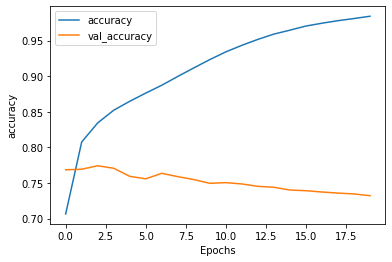

In [25]:
plot_graphs(history, 'accuracy')

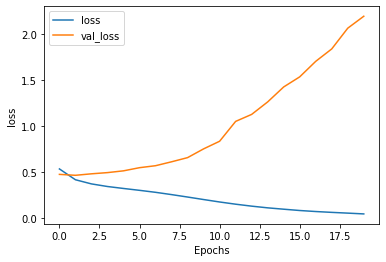

In [26]:
plot_graphs(history, 'loss')

On constate une amélioration de la précision sur le jeu de test par rapport un premier réseau de neurone d'environ 0,015, ce résultat peut paraître faible mais cela nous donne une indication sur la méthode a employer pour rendre notre modèle plus performant. En complexifiant encore notre modèle et en lui donnant plus de donnée d'entrée tout en l'entrainant sur un plus grand nombre d'époque nous pourrions obtenir un modèle tout à fait satifaisant.